<a href="https://colab.research.google.com/github/zhan5555/MachineLearningProject/blob/main/Song_Recommendation1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Recommendation System**

## **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

**song_data**

- song_id - A unique id given to every song
- title - Title of the song
- Release - Name of the released album
- Artist_name - Name of the artist
- year - Year of release

**count_data**

- user _id - A unique id given to the user
- song_id - A unique id given to the song
- play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

## **Importing Libraries and the Dataset**

In [1]:
# Run me 1 - Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libaries

In [ ]:
# Run me 2 - Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# To compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# Ran me 9-

# Import necessary libraries

# Install the surprise package using pip.
!pip install scikit-surprise

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

import random
from surprise.model_selection import GridSearchCV, train_test_split
from surprise import Dataset, Reader, SVD, accuracy, KNNBasic
from surprise.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from math import log2
from collections import defaultdict
import networkx as nx

### **Load the dataset**

In [ ]:
# Run me 3 - importing the datasets
count_df = pd.read_csv('/content/drive/MyDrive/Python Course/count_data.csv')
song_df = pd.read_csv('/content/drive/MyDrive/Python Course/song_data.csv')

### **Understanding the data by viewing a few observations**

In [ ]:
# Display the first 10 records of count_df
count_df.head(10)

Unnamed: 0                                   user_id             song_id  \
0           0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995   
1           1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B   
2           2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0   
3           3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D   
4           4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273   
5           5  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODDNQT12A6D4F5F7E   
6           6  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODXRTY12AB0180F3B   
7           7  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOFGUAY12AB017B0A8   
8           8  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOFRQTD12A81C233C0   
9           9  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOHQWYZ12A6D4FA701   

   play_count  
0           1  
1           2  
2           1  
3           1  
4           1  
5           5  
6           1  
7           1  
8           1  
9           1

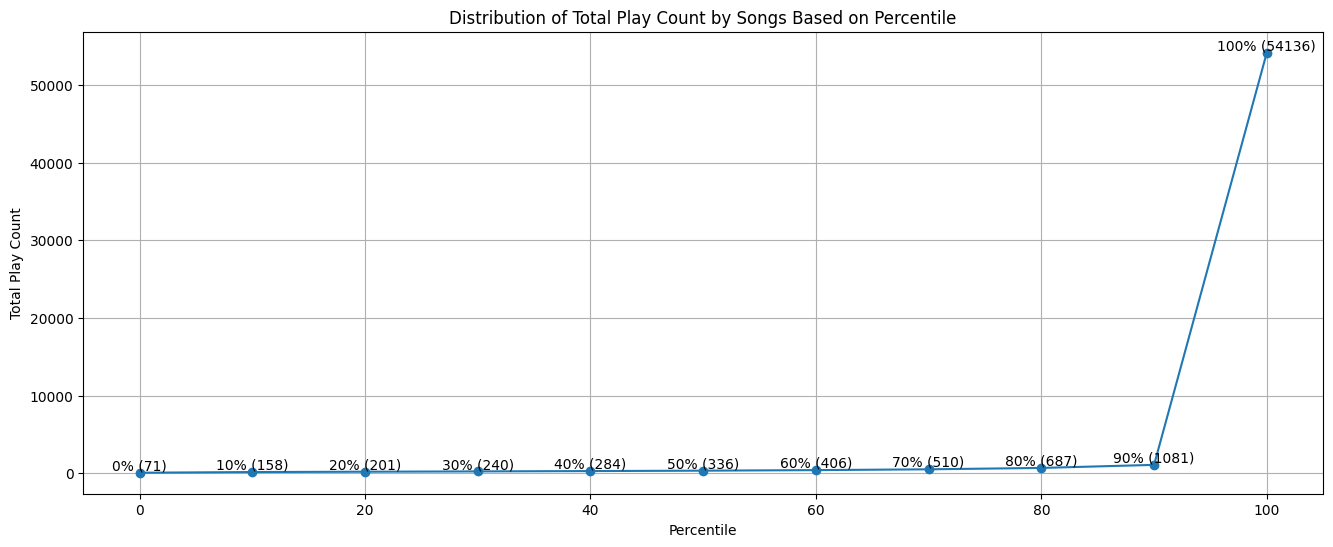

In [ ]:
# prompt: create a plot to show distribution of total play count by songs based on percentile in intervals of 10 and display percentage and values

# Calculate total play count for each song
song_play_counts = count_df.groupby('song_id')['play_count'].sum()

# Calculate percentiles for the play counts
percentiles = np.arange(0, 101, 10)
percentile_values = [np.percentile(song_play_counts, p) for p in percentiles]

# Create the plot
plt.figure(figsize=(16, 6))
plt.plot(percentiles, percentile_values, marker='o')
plt.xlabel('Percentile')
plt.ylabel('Total Play Count')
plt.title('Distribution of Total Play Count by Songs Based on Percentile')
plt.grid(True)

# Annotate the plot with percentage and values
for p, v in zip(percentiles, percentile_values):
    plt.text(p, v, f'{p}% ({v:.0f})', ha='center', va='bottom')

plt.show()


In [ ]:
# Display the first 10 records of song_df
song_df.head(10)

song_id                                              title  \
0  SOQMMHC12AB0180CB8                                       Silent Night   
1  SOVFVAK12A8C1350D9                                        Tanssi vaan   
2  SOGTUKN12AB017F4F1                                  No One Could Ever   
3  SOBNYVR12A8C13558C                                      Si Vos Querés   
4  SOHSBXH12A8C13B0DF                                   Tangle Of Aspens   
5  SOZVAPQ12A8C13B63C  Symphony No. 1 G minor "Sinfonie Serieuse"/All...   
6  SOQVRHI12A6D4FB2D7                                   We Have Got Love   
7  SOEYRFT12AB018936C                                  2 Da Beat Ch'yall   
8  SOPMIYT12A6D4F851E                                            Goodbye   
9  SOJCFMH12A8C13B0C2                         Mama_ mama can't you see ?   

                                release  \
0                 Monster Ballads X-Mas   
1                           Karkuteillä   
2                                Butter   
3                               De Culo   
4  Rene Ablaze Presents Winter Sessions   
5      Berwald: Symphonies Nos. 1/2/3/4   
6             Strictly The Best Vol. 34   
7                               Da Bomb   
8                             Danny Boy   
9  March to cadence with the US marines   

                                      artist_name  year  
0                                Faster Pussy cat  2003  
1                                Karkkiautomaatti  1995  
2                                  Hudson Mohawke  2006  
3                                     Yerba Brava  2003  
4                                      Der Mystic     0  
5                                David Montgomery     0  
6                              Sasha / Turbulence     0  
7                                      Kris Kross  1993  
8                                    Joseph Locke     0  
9  The Sun Harbor's Chorus-Documentary Recordings     0

### **Let us check the data types and and missing values of each column**

In [ ]:
# Display the info of count_df
rows, columns = count_df.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  2000000
No of columns:  4


In [ ]:
# prompt: get count of unique users from count_df and average total play count, max and min, and unique song IDs. and display number of duplicated song ID rows. Display number of duplicated rows.

# Count of unique users
unique_users = count_df['user_id'].nunique()
print("Number of Unique Users:", unique_users)

# Average total play count
average_play_count = count_df['play_count'].mean()
print("Average Play Count:", average_play_count)

# Maximum play count
max_play_count = count_df['play_count'].max()
print("Maximum Play Count:", max_play_count)

# Minimum play count
min_play_count = count_df['play_count'].min()
print("Minimum Play Count:", min_play_count)

# Number of unique song IDs
unique_song_ids = count_df['song_id'].nunique()
print("Number of Unique Song IDs:", unique_song_ids)

# Number of duplicated song ID rows
duplicated_song_rows = count_df[count_df.duplicated(subset=['song_id'], keep=False)].shape[0]
print("Number of Duplicated Song ID Rows:", duplicated_song_rows)

# Number of duplicated rows
duplicated_rows = count_df[count_df.duplicated(keep=False)].shape[0]
print("Number of Duplicated Rows:", duplicated_rows)



Number of Unique Users: 76353
Average Play Count: 3.0454845
Maximum Play Count: 2213
Minimum Play Count: 1
Number of Unique Song IDs: 10000
Number of Duplicated Song ID Rows: 2000000
Number of Duplicated Rows: 0


In [ ]:
# Display the info of song_df
rows, columns = song_df.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  1000000
No of columns:  5


In [ ]:
# check how many rows in song_df has 0 in the year column and as a percentage of total rows. and display number of users who have duplicated song IDs

# Check how many rows in song_df has 0 in the year column
rows_with_zero_year = song_df[song_df['year'] == 0].shape[0]
print("Number of rows with 0 in the year column:", rows_with_zero_year)

# Calculate the percentage of rows with 0 in the year column
total_rows = song_df.shape[0]
percentage_zero_year = (rows_with_zero_year / total_rows) * 100
print("Percentage of rows with 0 in the year column:", percentage_zero_year)

# Display the number of users who have duplicated song IDs in count_df
duplicate_song_users = count_df[count_df.duplicated(subset=['user_id', 'song_id'], keep=False)]['user_id'].nunique()
print("Number of users who have duplicated song IDs:", duplicate_song_users)


Number of rows with 0 in the year column: 484424
Percentage of rows with 0 in the year column: 48.4424
Number of users who have duplicated song IDs: 0


In [ ]:
# total number of duplicated rows in song df

# Calculate the total number of duplicated rows in song_df
total_duplicated_rows = song_df[song_df.duplicated(keep=False)].shape[0]

print("Total number of duplicated rows in song_df:", total_duplicated_rows)


Total number of duplicated rows in song_df: 982


In [ ]:
1000000-982

999018

### **Add additional features to final df**



In [ ]:
# Run me 4 - create final df
# drop duplicated rows in sound_df. Then join sound_df to count_df on song ID and drop the column 'Unnamed: 0'. name new dataset df. print how many songs did not get joined to count df,print number rows and columns of df, print number of unique user IDs and song IDs from df, print top 5 rows

# Drop duplicate rows in song_df based on 'song_id'
song_df = song_df.drop_duplicates(subset=['song_id'])

# Merge song_df and count_df on 'song_id'
df = pd.merge(count_df, song_df, on='song_id', how='left')

# Drop the 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in df.columns:
  df = df.drop('Unnamed: 0', axis=1)

# Calculate the number of songs that did not get joined
songs_not_joined = count_df.shape[0] - df.shape[0]
print(f"Number of songs that did not get joined to count_df: {songs_not_joined}")

# Print number of rows and columns of the merged DataFrame
print(f"Number of rows in df: {df.shape[0]}")
print(f"Number of columns in df: {df.shape[1]}")

# Print number of unique user IDs and song IDs from df
print(f"Number of unique user IDs: {df['user_id'].nunique()}")
print(f"Number of unique song IDs: {df['song_id'].nunique()}")

# Print the top 5 rows of df
print(df.head(5))


Number of songs that did not get joined to count_df: 0
Number of rows in df: 2000000
Number of columns in df: 7
Number of unique user IDs: 76353
Number of unique song IDs: 10000
                                    user_id             song_id  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B           2   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0           1   
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D           1   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273           1   

             title                        release    artist_name  year  
0         The Cove             Thicker Than Water   Jack Johnson     0  
1  Entre Dos Aguas            Flamenco Para Niños  Paco De Lucia  1976  
2         Stronger                     Graduation     Kanye West  2007  
3   Constellations              In Between Dreams   Jac

In [ ]:
# Check how many rows in df has 0 in the year column
rows_with_zero_year = df[df['year'] == 0].shape[0]
print("Number of rows with 0 in the year column:", rows_with_zero_year)

# Calculate the percentage of rows with 0 in the year column
total_rows = df.shape[0]
percentage_zero_year = (rows_with_zero_year / total_rows) * 100
print("Percentage of rows with 0 in the year column:", percentage_zero_year)

Number of rows with 0 in the year column: 372122
Percentage of rows with 0 in the year column: 18.6061


In [ ]:
# prompt: count number of rows and unique user id and song  from df

rows, columns = df.shape
print(f"Number of rows: {rows}")

unique_user_ids = df['user_id'].nunique()
unique_song_ids = df['song_id'].nunique()

print(f"Number of unique user IDs: {unique_user_ids}")
print(f"Number of unique song IDs: {unique_song_ids}")


Number of rows: 2000000
Number of unique user IDs: 76353
Number of unique song IDs: 10000


**Think About It:** As the user_id and song_id are encrypted. Can they be encoded to numeric features?

In [ ]:
# Run me 5 -  Apply label encoding for "user_id" and "song_id"
# # Label encoding code

from sklearn.preprocessing import LabelEncoder

le_user = LabelEncoder()
le_song = LabelEncoder()

df['user_id'] = le_user.fit_transform(df['user_id'])
df['song_id'] = le_song.fit_transform(df['song_id'])

print(df.head())


   user_id  song_id  play_count            title  \
0    54961      153           1         The Cove   
1    54961      413           2  Entre Dos Aguas   
2    54961      736           1         Stronger   
3    54961      750           1   Constellations   
4    54961     1188           1     Learn To Fly   

                         release    artist_name  year  
0             Thicker Than Water   Jack Johnson     0  
1            Flamenco Para Niños  Paco De Lucia  1976  
2                     Graduation     Kanye West  2007  
3              In Between Dreams   Jack Johnson  2005  
4  There Is Nothing Left To Lose   Foo Fighters  1999  


In [ ]:
# prompt: describe data type of each column

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   song_id      int64 
 2   play_count   int64 
 3   title        object
 4   release      object
 5   artist_name  object
 6   year         int64 
dtypes: int64(4), object(3)
memory usage: 106.8+ MB


**Think About It:** As the data also contains users who have listened to very few songs and vice versa, is it required to filter the data so that it contains users who have listened to a good count of songs and vice versa?

In [ ]:
# prompt: missing value in any of the columns? and any of the title paly count equal to 0? any artist name value is blank or n/a? any title value is n/a?

# Check for missing values in any of the columns
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check if any of the title play counts are equal to 0
title_play_count_zero = df[df['play_count'] == 0].shape[0]
print("\nNumber of rows with play_count equal to 0:", title_play_count_zero)

# Check if any artist name value is blank or 'n/a'
artist_name_blank_na = df[df['artist_name'].isnull() | (df['artist_name'] == '') | (df['artist_name'] == 'n/a')].shape[0]
print("\nNumber of rows with blank or 'n/a' artist name:", artist_name_blank_na)


# Check if any title value is 'n/a'
title_na = df[df['title'].isnull() | (df['title'] == 'n/a')].shape[0]
print("\nNumber of rows with 'n/a' title:", title_na)



Missing values in each column:
 user_id        0
song_id        0
play_count     0
title          0
release        0
artist_name    0
year           0
dtype: int64

Number of rows with play_count equal to 0: 0

Number of rows with blank or 'n/a' artist name: 0

Number of rows with 'n/a' title: 0


### **visualized / epxlore the data in the new dataset**

**Analyzing distribution of data on: 1. total play count per user 2. unique songs play count per user 3. total play count per song 4. unique user count per song. Then choose a cut off to reduce sparse in data for models.**

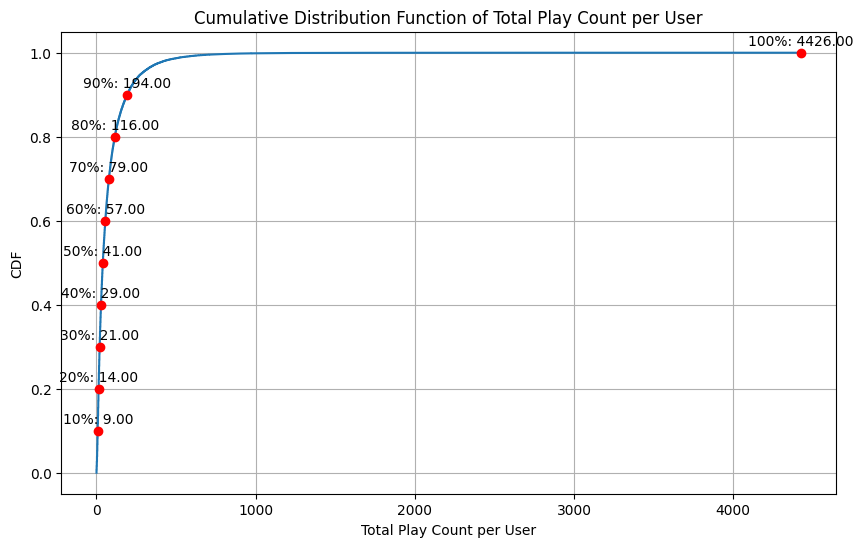

In [ ]:
# prompt: create a Cumulative Distribution Function (CDF) based on  total play count per user. display percentage and total play count  value for  in intervals of 10%

# Calculate total play count per user
user_play_counts = df.groupby('user_id')['play_count'].sum()

# Calculate the CDF
sorted_play_counts = np.sort(user_play_counts)
cdf = np.arange(1, len(sorted_play_counts) + 1) / len(sorted_play_counts)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_play_counts, cdf)
plt.xlabel('Total Play Count per User')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Total Play Count per User')

# Display percentage and total play count value in intervals of 10%
for percentile in range(10, 110, 10):
    value = np.percentile(sorted_play_counts, percentile)
    plt.plot(value, percentile / 100, marker='o', color='red')
    plt.text(value, percentile / 100 + 0.01, f'{percentile}%: {value:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()


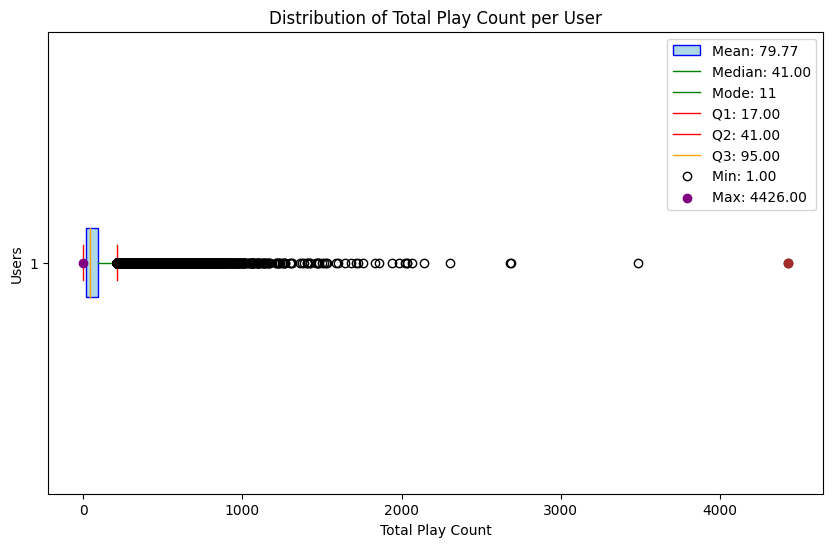

In [ ]:
#based on total play count per user.  create a horizontal box plot to show statistics,
# including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.

import matplotlib.pyplot as plt
import numpy as np

# Assuming df has been defined
# Calculate total play count per user
user_play_counts = df.groupby('user_id')['play_count'].sum()

# Create a horizontal box plot with custom statistics and colors
plt.figure(figsize=(10, 6))
plt.boxplot(user_play_counts, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='black'),
            medianprops=dict(color='orange'))

# Calculate and display statistics
mean_play_count = np.mean(user_play_counts)
median_play_count = np.median(user_play_counts)
mode_play_count = user_play_counts.mode()[0] if not user_play_counts.mode().empty else "N/A"
q1 = np.percentile(user_play_counts, 25)
q2 = np.percentile(user_play_counts, 50)
q3 = np.percentile(user_play_counts, 75)
q4 = np.percentile(user_play_counts, 100)
min_play_count = np.min(user_play_counts)
max_play_count = np.max(user_play_counts)

# Mark min and max on the plot
plt.scatter(min_play_count, 1, color='purple', label=f'Min: {min_play_count:.2f}', zorder=3)
plt.scatter(max_play_count, 1, color='brown', label=f'Max: {max_play_count:.2f}', zorder=3)

plt.xlabel('Total Play Count')
plt.ylabel('Users')
plt.title('Distribution of Total Play Count per User')

# Display legend with additional statistics
plt.legend([f'Mean: {mean_play_count:.2f}',
            f'Median: {median_play_count:.2f}',
            f'Mode: {mode_play_count}',
            f'Q1: {q1:.2f}',
            f'Q2: {q2:.2f}',
            f'Q3: {q3:.2f}',
            f'Min: {min_play_count:.2f}',
            f'Max: {max_play_count:.2f}'], loc='upper right')

plt.show()


In [ ]:
# prompt: what is the maximum and minimum total play count per user

# Calculate total play count per user
user_play_counts = df.groupby('user_id')['play_count'].sum()

# Find the maximum and minimum total play counts
max_play_count = user_play_counts.max()
min_play_count = user_play_counts.min()

print(f"Maximum total play count per user: {max_play_count}")
print(f"Minimum total play count per user: {min_play_count}")


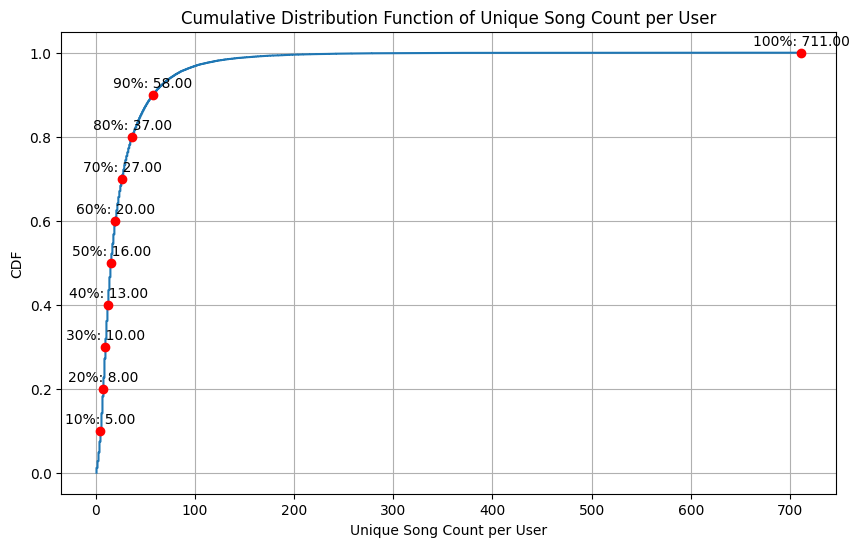

In [ ]:
# prompt: create a Cumulative Distribution Function (CDF) based on  unique song count per user. display percentage and total play count  value for  in intervals of 10%

# Calculate unique song count per user
user_unique_songs = df.groupby('user_id')['song_id'].nunique()

# Calculate the CDF
sorted_unique_songs = np.sort(user_unique_songs)
cdf = np.arange(1, len(sorted_unique_songs) + 1) / len(sorted_unique_songs)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_unique_songs, cdf)
plt.xlabel('Unique Song Count per User')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Unique Song Count per User')

# Display percentage and total play count value in intervals of 10%
for percentile in range(10, 110, 10):
    value = np.percentile(sorted_unique_songs, percentile)
    plt.plot(value, percentile / 100, marker='o', color='red')
    plt.text(value, percentile / 100 + 0.01, f'{percentile}%: {value:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()


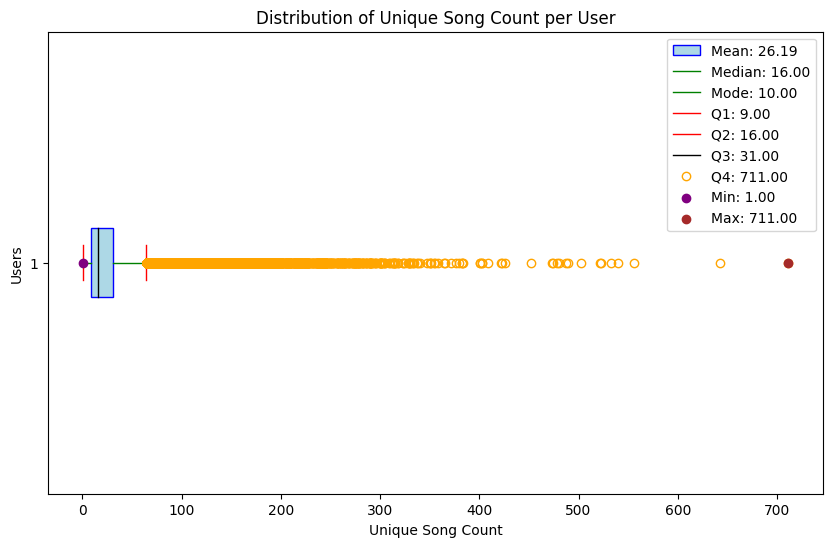

In [ ]:
# prompt: based on unique play count per user.  create a horizontal box plot to show statistics,
#  including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.
# add plt.scatter to display min and max

import matplotlib.pyplot as plt
import numpy as np

# Assuming df has been defined
# Calculate unique song count per user
user_unique_songs = df.groupby('user_id')['song_id'].nunique()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(user_unique_songs, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_unique_songs = np.mean(user_unique_songs)
median_unique_songs = np.median(user_unique_songs)
mode_unique_songs = user_unique_songs.mode()[0]
q1 = np.percentile(user_unique_songs, 25)
q2 = np.percentile(user_unique_songs, 50)
q3 = np.percentile(user_unique_songs, 75)
q4 = np.percentile(user_unique_songs, 100)
min_unique_songs = np.min(user_unique_songs)
max_unique_songs = np.max(user_unique_songs)

# Mark min and max on the plot
plt.scatter(min_unique_songs, 1, color='purple', label=f'Min: {min_unique_songs:.2f}', zorder=3)
plt.scatter(max_unique_songs, 1, color='brown', label=f'Max: {max_unique_songs:.2f}', zorder=3)

# Display the statistics in the legend
plt.legend([
    f'Mean: {mean_unique_songs:.2f}',
    f'Median: {median_unique_songs:.2f}',
    f'Mode: {mode_unique_songs:.2f}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_unique_songs:.2f}',
    f'Max: {max_unique_songs:.2f}'
], loc='upper right')

plt.xlabel('Unique Song Count')
plt.ylabel('Users')
plt.title('Distribution of Unique Song Count per User')
plt.show()



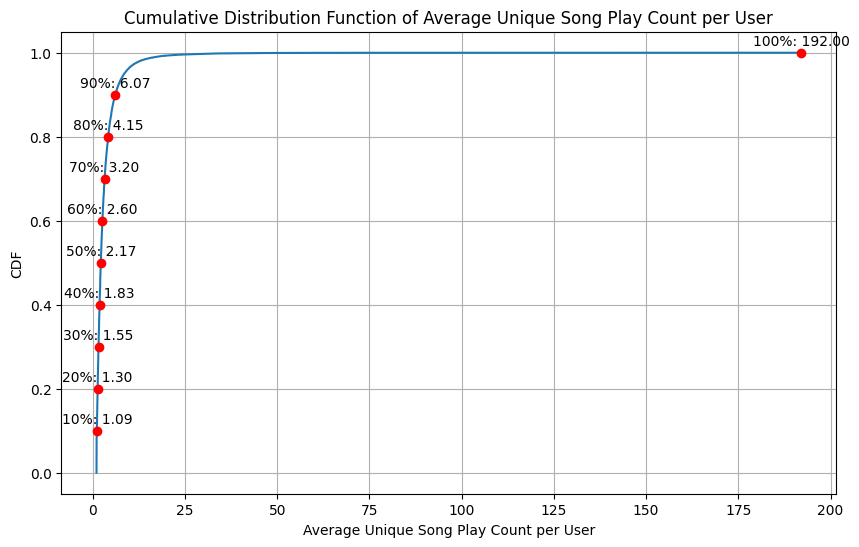

In [ ]:
# prompt: create a Cumulative Distribution Function (CDF) based on  average unique song play count per user. display percentage and total play count  value for  in intervals of 10%

# Calculate average unique song play count per user
user_avg_song_play_counts = df.groupby('user_id')['play_count'].mean()

# Calculate the CDF
sorted_avg_song_play_counts = np.sort(user_avg_song_play_counts)
cdf = np.arange(1, len(sorted_avg_song_play_counts) + 1) / len(sorted_avg_song_play_counts)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_avg_song_play_counts, cdf)
plt.xlabel('Average Unique Song Play Count per User')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Average Unique Song Play Count per User')

# Display percentage and total play count value in intervals of 10%
for percentile in range(10, 110, 10):
    value = np.percentile(sorted_avg_song_play_counts, percentile)
    plt.plot(value, percentile / 100, marker='o', color='red')
    plt.text(value, percentile / 100 + 0.01, f'{percentile}%: {value:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()


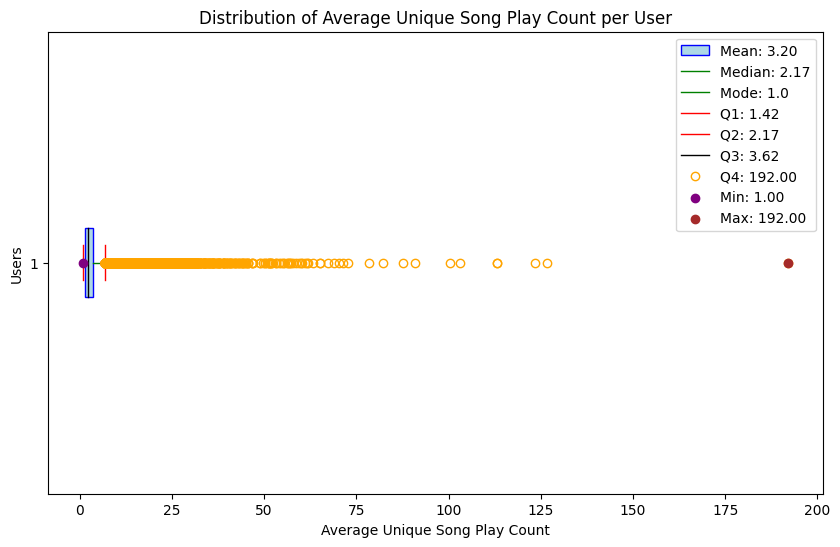

In [ ]:
# prompt: # prompt: based on average unique song play count per user.  create a horizontal box plot to show statistics,
# #  including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.
# # add plt.scatter

# Assuming df has been defined
# Calculate average unique song play count per user
user_avg_song_play_counts = df.groupby('user_id')['play_count'].mean()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(user_avg_song_play_counts, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_avg_song_play_counts = np.mean(user_avg_song_play_counts)
median_avg_song_play_counts = np.median(user_avg_song_play_counts)
mode_avg_song_play_counts = user_avg_song_play_counts.mode()[0] if not user_avg_song_play_counts.mode().empty else "N/A"
q1 = np.percentile(user_avg_song_play_counts, 25)
q2 = np.percentile(user_avg_song_play_counts, 50)
q3 = np.percentile(user_avg_song_play_counts, 75)
q4 = np.percentile(user_avg_song_play_counts, 100)
min_avg_song_play_counts = np.min(user_avg_song_play_counts)
max_avg_song_play_counts = np.max(user_avg_song_play_counts)


# Mark min and max on the plot
plt.scatter(min_avg_song_play_counts, 1, color='purple', label=f'Min: {min_avg_song_play_counts:.2f}', zorder=3)
plt.scatter(max_avg_song_play_counts, 1, color='brown', label=f'Max: {max_avg_song_play_counts:.2f}', zorder=3)

# Display the statistics in the legend
plt.legend([
    f'Mean: {mean_avg_song_play_counts:.2f}',
    f'Median: {median_avg_song_play_counts:.2f}',
    f'Mode: {mode_avg_song_play_counts}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_avg_song_play_counts:.2f}',
    f'Max: {max_avg_song_play_counts:.2f}'
], loc='upper right')


plt.xlabel('Average Unique Song Play Count')
plt.ylabel('Users')
plt.title('Distribution of Average Unique Song Play Count per User')
plt.show()


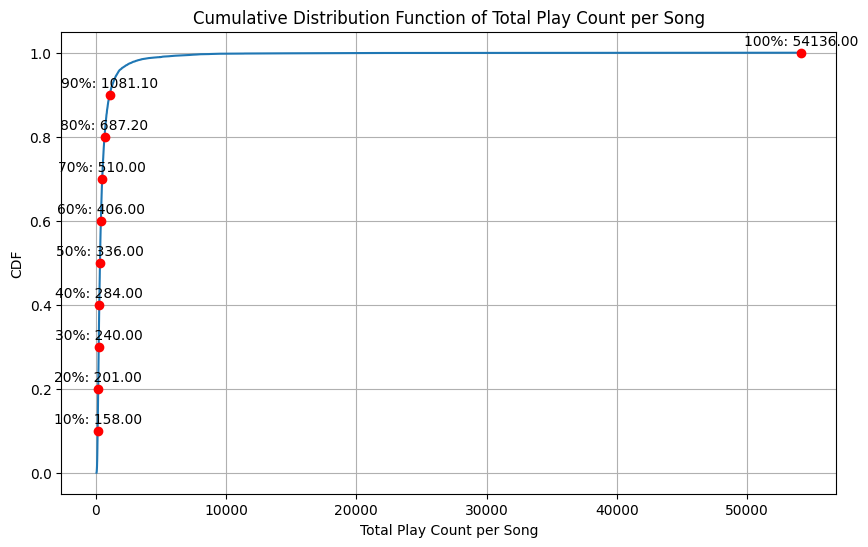

In [ ]:
# prompt: create a Cumulative Distribution Function (CDF) based on  total count per song. display percentage and total play count  value for  in intervals of 10%

# Calculate total play count per song
song_play_counts = df.groupby('song_id')['play_count'].sum()

# Calculate the CDF
sorted_play_counts = np.sort(song_play_counts)
cdf = np.arange(1, len(sorted_play_counts) + 1) / len(sorted_play_counts)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_play_counts, cdf)
plt.xlabel('Total Play Count per Song')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Total Play Count per Song')

# Display percentage and total play count value in intervals of 10%
for percentile in range(10, 110, 10):
    value = np.percentile(sorted_play_counts, percentile)
    plt.plot(value, percentile / 100, marker='o', color='red')
    plt.text(value, percentile / 100 + 0.01, f'{percentile}%: {value:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()


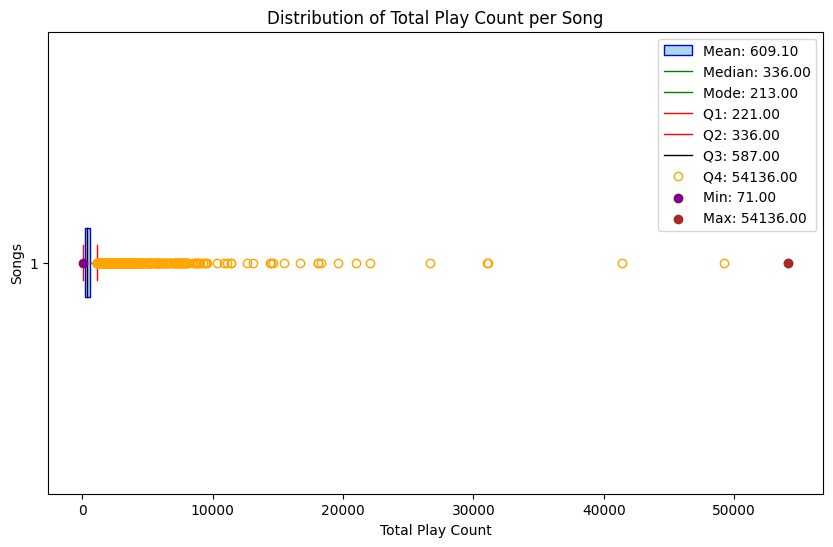

In [ ]:
# prompt: based on total play count per song.  create a horizontal box plot to show statistics,
# including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.
# add scatter

import matplotlib.pyplot as plt
import numpy as np

# Assuming df has been defined
# Calculate total play count per song
song_play_counts = df.groupby('song_id')['play_count'].sum()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(song_play_counts, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_play_count = np.mean(song_play_counts)
median_play_count = np.median(song_play_counts)
mode_play_count = song_play_counts.mode()[0]
q1 = np.percentile(song_play_counts, 25)
q2 = np.percentile(song_play_counts, 50)
q3 = np.percentile(song_play_counts, 75)
q4 = np.percentile(song_play_counts, 100)
min_play_count = np.min(song_play_counts)
max_play_count = np.max(song_play_counts)

# Mark min and max on the plot
plt.scatter(min_play_count, 1, color='purple', label=f'Min: {min_play_count:.2f}', zorder=3)
plt.scatter(max_play_count, 1, color='brown', label=f'Max: {max_play_count:.2f}', zorder=3)

# Create legend with statistics
plt.legend([
    f'Mean: {mean_play_count:.2f}',
    f'Median: {median_play_count:.2f}',
    f'Mode: {mode_play_count:.2f}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_play_count:.2f}',
    f'Max: {max_play_count:.2f}'
], loc='upper right')

plt.xlabel('Total Play Count')
plt.ylabel('Songs')
plt.title('Distribution of Total Play Count per Song')
plt.show()


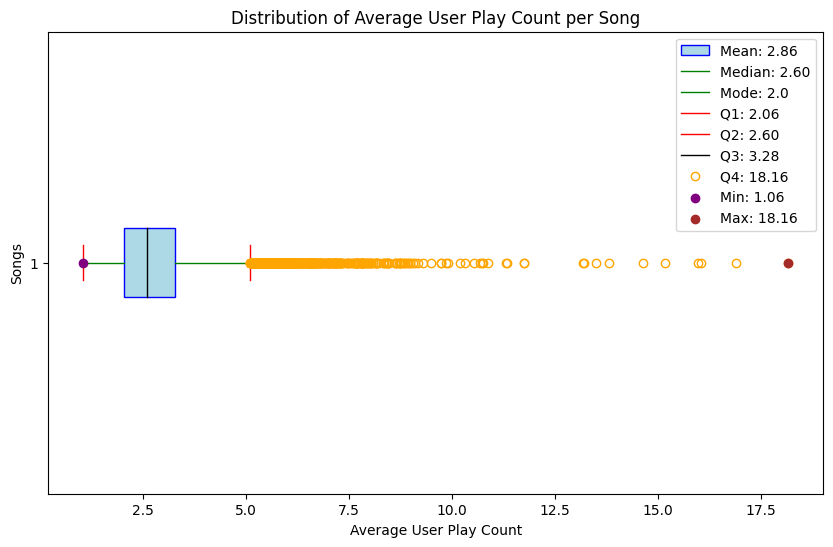

In [ ]:
# prompt: # prompt: based on average user play count per song.  create a horizontal box plot to show statistics,
# # including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.
# # add scatter

# Calculate average user play count per song
song_avg_user_play_counts = df.groupby('song_id')['play_count'].mean()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(song_avg_user_play_counts, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_avg_user_play_counts = np.mean(song_avg_user_play_counts)
median_avg_user_play_counts = np.median(song_avg_user_play_counts)
mode_avg_user_play_counts = song_avg_user_play_counts.mode()[0] if not song_avg_user_play_counts.mode().empty else "N/A"
q1 = np.percentile(song_avg_user_play_counts, 25)
q2 = np.percentile(song_avg_user_play_counts, 50)
q3 = np.percentile(song_avg_user_play_counts, 75)
q4 = np.percentile(song_avg_user_play_counts, 100)
min_avg_user_play_counts = np.min(song_avg_user_play_counts)
max_avg_user_play_counts = np.max(song_avg_user_play_counts)

# Mark min and max on the plot
plt.scatter(min_avg_user_play_counts, 1, color='purple', label=f'Min: {min_avg_user_play_counts:.2f}', zorder=3)
plt.scatter(max_avg_user_play_counts, 1, color='brown', label=f'Max: {max_avg_user_play_counts:.2f}', zorder=3)


# Display the statistics in the legend
plt.legend([
    f'Mean: {mean_avg_user_play_counts:.2f}',
    f'Median: {median_avg_user_play_counts:.2f}',
    f'Mode: {mode_avg_user_play_counts}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_avg_user_play_counts:.2f}',
    f'Max: {max_avg_user_play_counts:.2f}'
], loc='upper right')


plt.xlabel('Average User Play Count')
plt.ylabel('Songs')
plt.title('Distribution of Average User Play Count per Song')
plt.show()


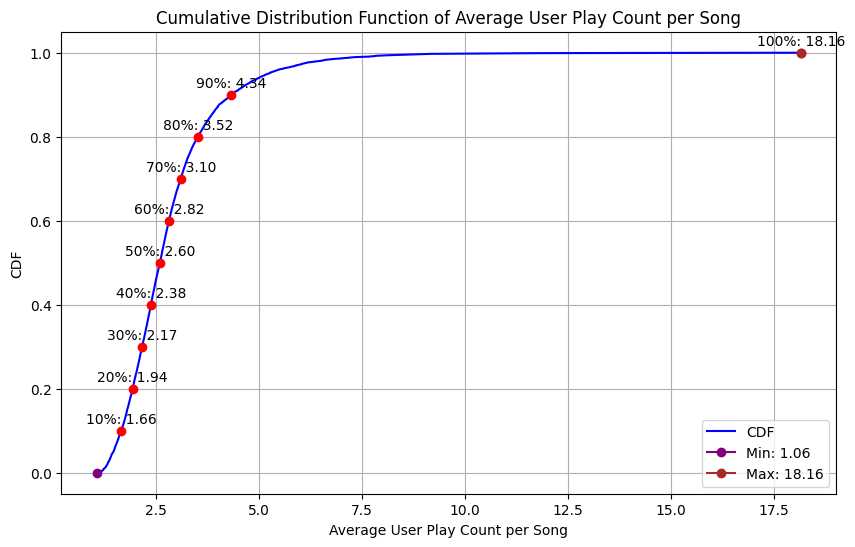

In [ ]:
# prompt: create a Cumulative Distribution Function (CDF) based on average user play count per song. display percentage and total play count value for  in intervals of 10%

import matplotlib.pyplot as plt
import numpy as np

# Assuming df has been defined
# Calculate average play count per song
song_avg_user_play_counts = df.groupby('song_id')['play_count'].mean()

# Calculate the CDF
sorted_avg_user_play_counts = np.sort(song_avg_user_play_counts)
cdf = np.arange(1, len(sorted_avg_user_play_counts) + 1) / len(sorted_avg_user_play_counts)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_avg_user_play_counts, cdf, label='CDF', color='blue')
plt.xlabel('Average User Play Count per Song')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Average User Play Count per Song')

# Display percentage and total play count value in intervals of 10%
for percentile in range(10, 110, 10):
    value = np.percentile(sorted_avg_user_play_counts, percentile)
    plt.plot(value, percentile / 100, marker='o', color='red')
    plt.text(value, percentile / 100 + 0.01, f'{percentile}%: {value:.2f}', ha='center', va='bottom')

# Calculate min and max values
min_avg_play_count = np.min(sorted_avg_user_play_counts)
max_avg_play_count = np.max(sorted_avg_user_play_counts)

# Mark the min and max values
plt.plot(min_avg_play_count, 0, marker='o', color='purple', label=f'Min: {min_avg_play_count:.2f}')
plt.plot(max_avg_play_count, 1, marker='o', color='brown', label=f'Max: {max_avg_play_count:.2f}')

# Add grid and legend
plt.grid(True)
plt.legend(loc='lower right')

plt.show()



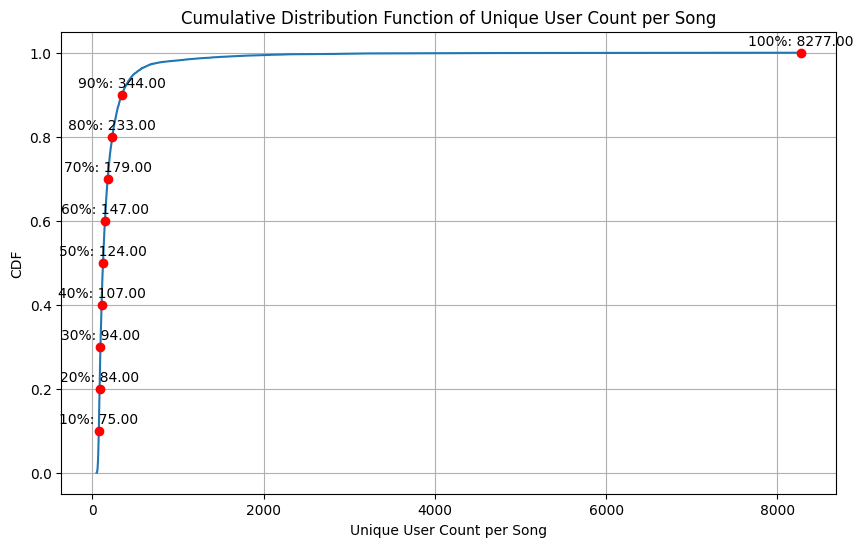

In [ ]:
# prompt: create a Cumulative Distribution Function (CDF) based on unique user count per song. display percentage and total play count  value for  in intervals of 10%

# Calculate unique user count per song
song_unique_users = df.groupby('song_id')['user_id'].nunique()

# Calculate the CDF
sorted_unique_users = np.sort(song_unique_users)
cdf = np.arange(1, len(sorted_unique_users) + 1) / len(sorted_unique_users)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_unique_users, cdf)
plt.xlabel('Unique User Count per Song')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Unique User Count per Song')

# Display percentage and total play count value in intervals of 10%
for percentile in range(10, 110, 10):
    value = np.percentile(sorted_unique_users, percentile)
    plt.plot(value, percentile / 100, marker='o', color='red')
    plt.text(value, percentile / 100 + 0.01, f'{percentile}%: {value:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()


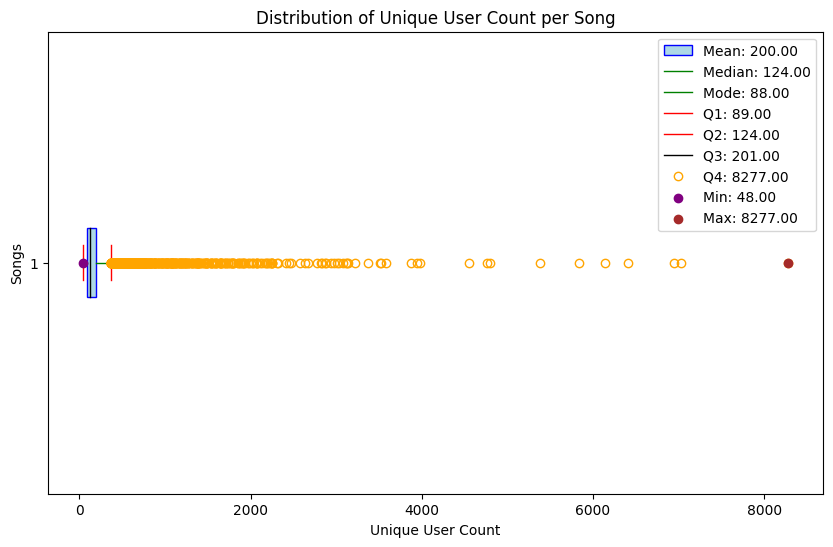

In [ ]:
# prompt: based on unique user count per song.  create a horizontal box plot to show statistics,
# including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.

import matplotlib.pyplot as plt
import numpy as np

# Assuming df has been defined
# Calculate unique user count per song
song_unique_users = df.groupby('song_id')['user_id'].nunique()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(song_unique_users, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_unique_users = np.mean(song_unique_users)
median_unique_users = np.median(song_unique_users)
mode_unique_users = song_unique_users.mode()[0]
q1 = np.percentile(song_unique_users, 25)
q2 = np.percentile(song_unique_users, 50)
q3 = np.percentile(song_unique_users, 75)
q4 = np.percentile(song_unique_users, 100)
min_unique_users = np.min(song_unique_users)
max_unique_users = np.max(song_unique_users)

# Mark min and max on the plot
plt.scatter(min_unique_users, 1, color='purple', label=f'Min: {min_unique_users:.2f}', zorder=3)
plt.scatter(max_unique_users, 1, color='brown', label=f'Max: {max_unique_users:.2f}', zorder=3)

# Create legend with statistics
plt.legend([
    f'Mean: {mean_unique_users:.2f}',
    f'Median: {median_unique_users:.2f}',
    f'Mode: {mode_unique_users:.2f}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_unique_users:.2f}',
    f'Max: {max_unique_users:.2f}'
], loc='upper right')

plt.xlabel('Unique User Count')
plt.ylabel('Songs')
plt.title('Distribution of Unique User Count per Song')
plt.show()


In [ ]:
# prompt: group rows by song ID and get how many songs with unique users played over 100 and 500

# Group by song ID and count unique users who played each song
song_user_counts = df.groupby('song_id')['user_id'].nunique()

# Count songs with unique users over 100
songs_over_100_users = (song_user_counts < 101).sum()

# Count songs with unique users over 500
songs_over_500_users = (song_user_counts > 500).sum()

print(f"Number of songs played by less 100 unique users: {songs_over_100_users}")
print(f"Number of songs played by over 500 unique users: {songs_over_500_users}")


Number of songs played by less 100 unique users: 3480
Number of songs played by over 500 unique users: 486


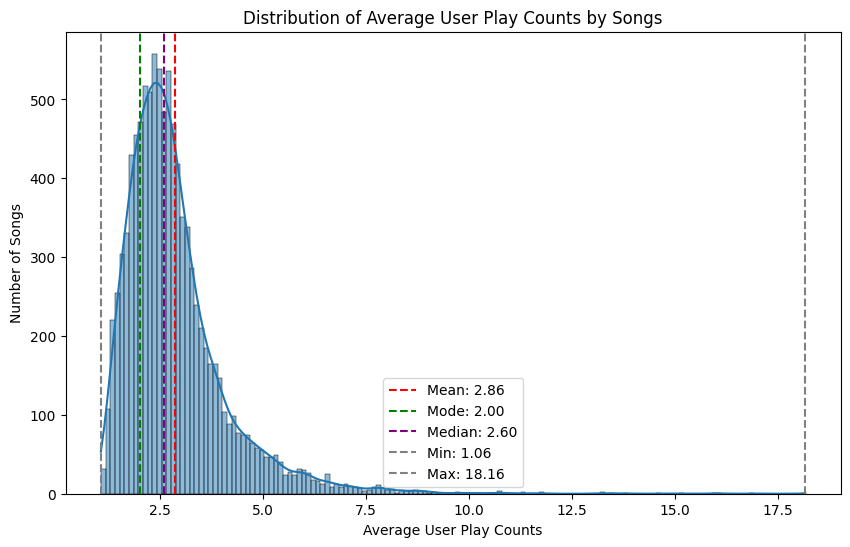

In [ ]:
# prompt: create a plot to show distribution of average user play counts by songs, y is number of songs, x is average user play counts. and add a red line to show mean a green line to show mode, and a purple line to show medium, a gray line to show min and max. Add a legend to show the values of mean, mode, medium, min, max

# Group rows by song ID and calculate the average play count for each song
song_avg_play_counts = df.groupby('song_id')['play_count'].mean()

# Calculate statistics
mean_avg_play_count = song_avg_play_counts.mean()
median_avg_play_count = song_avg_play_counts.median()
mode_avg_play_count = song_avg_play_counts.mode()[0]
min_avg_play_count = song_avg_play_counts.min()
max_avg_play_count = song_avg_play_counts.max()

# Create a plot to show the distribution curve
plt.figure(figsize=(10, 6))
sns.histplot(song_avg_play_counts, kde=True)

# Add lines for mean, mode, median, min, and max
plt.axvline(mean_avg_play_count, color='red', linestyle='--', label=f'Mean: {mean_avg_play_count:.2f}')
plt.axvline(mode_avg_play_count, color='green', linestyle='--', label=f'Mode: {mode_avg_play_count:.2f}')
plt.axvline(median_avg_play_count, color='purple', linestyle='--', label=f'Median: {median_avg_play_count:.2f}')
plt.axvline(min_avg_play_count, color='gray', linestyle='--', label=f'Min: {min_avg_play_count:.2f}')
plt.axvline(max_avg_play_count, color='gray', linestyle='--', label=f'Max: {max_avg_play_count:.2f}')


plt.xlabel('Average User Play Counts')
plt.ylabel('Number of Songs')
plt.title('Distribution of Average User Play Counts by Songs')
plt.legend()
plt.show()


In [ ]:
# investigate missing year songs
# prompt: minimum value of year and how many rows with this value, give 20 songs with this year and print the title

min_year = df_final['year'].min()
rows_with_min_year = df_final[df_final['year'] == min_year].shape[0]

print(f"Minimum year: {min_year}")
print(f"Number of rows with minimum year: {rows_with_min_year}")

# Get 20 songs with the minimum year
songs_with_min_year = df_final[df_final['year'] == min_year][['title', 'year']].drop_duplicates().head(20)

print("20 Songs with the Minimum Year:")
print(songs_with_min_year)

Minimum year: 0
Number of rows with minimum year: 182509
20 Songs with the Minimum Year:
                                                title  year
15                                           Uprising     0
17                              Lucky (Album Version)     0
22  American Idiot [feat. Green Day & The Cast Of ...     0
23                                   Hey_ Soul Sister     0
26                        The Funeral (Album Version)     0
30                                            Picture     0
33                 The Only Exception (Album Version)     0
35          Orange Trägt Nur Die Müllabfuhr (Go West)     0
36                                             Rianna     0
42  Billionaire [feat. Bruno Mars]  (Explicit Albu...     0
50                                 Heartbreak Warfare     0
51  Nothin' On You [feat. Bruno Mars] (Album Version)     0
53                                   What's Your Name     0
56                                   Half Of My Heart     0
64         

In [ ]:
# prompt: which year is the most frequent in the dataset other than 0

# Assuming df_final is your DataFrame
year_counts = df_final[df_final['year'] != 0]['year'].value_counts()
most_frequent_year = year_counts.idxmax()

print(f"The most frequent year (excluding 0) is: {most_frequent_year}")

The most frequent year (excluding 0) is: 2009


### **create the final dataset by adding new columns and filtering the dataset to keep highly interacted users**

In [ ]:
# Run me 6 - filter for FINAL DATASET

#We include users who have listened to at least 3 unique songs.
#Users have a total play count of 80 times or more.
#We include only songs that have an average user play count of over 2 times.

# Step 1: Filter songs that have an average play count of over 2 times
popular_songs = df.groupby('song_id')['play_count'].mean()
popular_songs = popular_songs[popular_songs > 2].index.tolist()
df_popular_songs = df[df['song_id'].isin(popular_songs)]

# Step 2: From the filtered songs, identify users who have total play counts of 80 or more and have listened to at least 3 unique songs
user_stats = df_popular_songs.groupby('user_id').agg({'play_count': 'sum', 'song_id': 'nunique'})
active_users = user_stats[(user_stats['play_count'] >= 80) & (user_stats['song_id'] >= 3)].index.tolist()
df_final = df_popular_songs[df_popular_songs['user_id'].isin(active_users)]


# Display info for the final DataFrame
print(f"Row count: {df_final.shape[0]}")
print(f"Column count: {df_final.shape[1]}")
print(f"Unique user IDs: {df_final['user_id'].nunique()}")
print(f"Unique song IDs: {df_final['song_id'].nunique()}")


Row count: 940730
Column count: 7
Unique user IDs: 20642
Unique song IDs: 7711


In [ ]:
# number of rows with year has value of 0 (we should exclude these rows when using content based later)

rows_with_year_0 = df_final[df_final['year'] == 0].shape[0]
print(f"Number of rows with year value 0: {rows_with_year_0}")


Number of rows with year value 0: 182509


In [ ]:
# prompt: find top 5 rows by play count with year value is 0 and print all columns

top_5_rows_year_0 = df_final[df_final['year'] == 0].nlargest(5, 'play_count')
print(top_5_rows_year_0)


         user_id  song_id  play_count  \
31179      56007     9882         796   
1731945    45183     3833         664   
1819571    73114     8426         605   
1875142    57320     9852         500   
578551     69642      573         431   

                                                 title  \
31179                                Paradise & Dreams   
1731945                                   Dance_ Dance   
1819571            Can't Help But Wait (Album Version)   
1875142                                      Glamorous   
578551   Nine Times Out Of Ten (1998 Digital Remaster)   

                           release                  artist_name  year  
31179                    Skydivin'                Darren Styles     0  
1731945               Dance_ Dance                 Fall Out Boy     0  
1819571  Kiss Presents The Mixtape                   Trey Songz     0  
1875142           Big Summer Tunes            Fergie / Ludacris     0  
578551     The Platinum Collection  Cliff Ri

In [ ]:
# Ran me 8
# add a new column to update df final name "Popularity Score", for each song
# the formula is Unique Users Played per song ×(Unique Users Played per song / Total Play Count per song) and normalized with min and max calues. Display top 5 rows

# Assuming df_final is your DataFrame with columns: user_id, song_id, play_count

# Step 1: Calculate total play count per song
df_total_play_count = df_final.groupby('song_id')['play_count'].sum().reset_index()
df_total_play_count.rename(columns={'play_count': 'total_play_count'}, inplace=True)

# Step 2: Calculate the average play per user for each song
df_avg_play_per_user = df_final.groupby('song_id')['play_count'].mean().reset_index()
df_avg_play_per_user.rename(columns={'play_count': 'avg_play_per_user'}, inplace=True)

# Step 3: Merge total play count and average play per user into one DataFrame
df_song_popularity = pd.merge(df_total_play_count, df_avg_play_per_user, on='song_id')

# Step 4: Normalize both total play count and average play per user
df_song_popularity['total_play_count_norm'] = (df_song_popularity['total_play_count'] - df_song_popularity['total_play_count'].min()) / \
                                              (df_song_popularity['total_play_count'].max() - df_song_popularity['total_play_count'].min())

df_song_popularity['avg_play_per_user_norm'] = (df_song_popularity['avg_play_per_user'] - df_song_popularity['avg_play_per_user'].min()) / \
                                               (df_song_popularity['avg_play_per_user'].max() - df_song_popularity['avg_play_per_user'].min())

# Step 5: Calculate the final popularity score by combining the normalized values (you can adjust the weights)
df_song_popularity['popularity_score'] = (df_song_popularity['total_play_count_norm'] * 0.6) + \
                                         (df_song_popularity['avg_play_per_user_norm'] * 0.4)

# Step 6: Merge the popularity score back to the original DataFrame
df_final = pd.merge(df_final, df_song_popularity[['song_id', 'popularity_score']], on='song_id', how='left')

# df_final now has a new column 'popularity_score'
print(df_final.head())


   user_id  song_id  play_count                                         title  \
0    22570     1286           6                              Somebody To Love   
1    22570     1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2    22570     2409           6                           My Dad's Gone Crazy   
3    22570     2430           4                                   Missing You   
4    22570     3781           2                                 Ya Nada Queda   

                release           artist_name  year  popularity_score  
0             My Worlds         Justin Bieber  2010          0.134081  
1      Ghosts 'n' Stuff              Deadmau5  2009          0.094275  
2       The Eminem Show  Eminem / Hailie Jade  2006          0.034575  
3          Love To Love            John Waite  1984          0.084749  
4  Ultimate Hits Latino                 Kudai  2004          0.037017  


Treat missing values in year column, Music-era columns

### **Explore the final dataset**

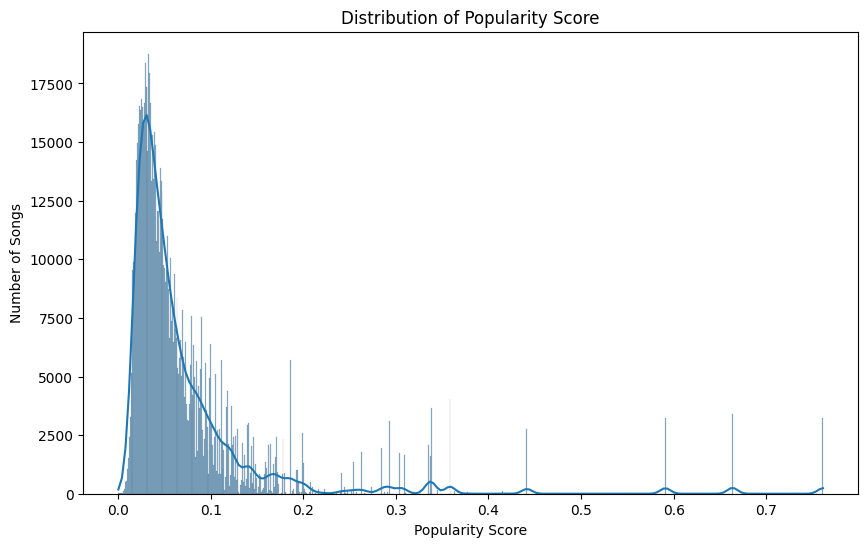

In [ ]:
# create a plot to show distribution of popularity_score

plt.figure(figsize=(10, 6))
sns.histplot(df_final['popularity_score'], kde=True)
plt.xlabel('Popularity Score')
plt.ylabel('Number of Songs')
plt.title('Distribution of Popularity Score')
plt.show()


In [ ]:
# number of unique artist name, unique release, max year

# Assuming df_final has been defined with 'artist_name', 'release_name', and 'year' columns
unique_artists = df_final['artist_name'].nunique()
unique_releases = df_final['release'].nunique()
max_year = df_final['year'].max()

print(f"Number of unique artists: {unique_artists}")
print(f"Number of unique releases: {unique_releases}")
print(f"Maximum year: {max_year}")


Number of unique artists: 3109
Number of unique releases: 4772
Maximum year: 2010


In [ ]:
# prompt: minimum average play count by song, minimum  average play count by user

# Calculate minimum average play count by song
min_avg_play_count_by_song = df_final.groupby('song_id')['play_count'].mean().min()

# Calculate minimum average play count by user
min_avg_play_count_by_user = df_final.groupby('user_id')['play_count'].mean().min()

print(f"Minimum average play count by song: {min_avg_play_count_by_song}")
print(f"Minimum average play count by user: {min_avg_play_count_by_user}")


Minimum average play count by song: 1.4864864864864864
Minimum average play count by user: 1.0


In [ ]:
# prompt: what is the minimum unique song ID count by user in df final

user_song_counts_final = df_final.groupby('user_id')['song_id'].nunique()
min_unique_song_count = user_song_counts_final.min()
print(f"The minimum unique song ID count by user in df_final is: {min_unique_song_count}")


The minimum unique song ID count by user in df_final is: 3


In [ ]:
# prompt: what is the minimum unique user ID count by songs in df final

song_user_counts_final = df_final.groupby('song_id')['user_id'].nunique()
min_unique_user_count = song_user_counts_final.min()
print(f"The minimum unique user ID count by songs in df_final is: {min_unique_user_count}")


The minimum unique user ID count by songs in df_final is: 14


In [ ]:
# prompt: print total rows and columns, and sum play counts, also check any duplicate rows

rows, columns = df_final.shape
print(f"Total rows: {rows}, Total columns: {columns}")
total_play_counts = df_final['play_count'].sum()
print(f"Sum of play counts: {total_play_counts}")

duplicate_rows = df_final[df_final.duplicated()].shape[0]
print(f"Number of duplicate rows: {duplicate_rows}")


Total rows: 940730, Total columns: 11
Sum of play counts: 3950912
Number of duplicate rows: 0


In [ ]:
print(df_final.describe())

             user_id     play_count           year  popularity_score  \
count  940730.000000  940730.000000  940730.000000     940730.000000   
mean    38135.722295       4.199836    1612.784843          0.071917   
std     22055.028999       9.043733     791.311066          0.086489   
min        10.000000       1.000000       0.000000          0.000222   
25%     19193.000000       1.000000    1983.000000          0.030251   
50%     37826.000000       2.000000    2002.000000          0.046726   
75%     57069.000000       4.000000    2007.000000          0.079961   
max     76348.000000    2213.000000    2010.000000          0.761244   

       play_count_log  play_count_scaled  log_play_count  
count   940730.000000      940730.000000   940730.000000  
mean         1.263137           0.001447        1.263137  
std          0.728733           0.004088        0.728733  
min          0.693147           0.000000        0.693147  
25%          0.693147           0.000000        0.693147

## **Exploratory Data Analysis in depth**

### **Let's check the total number of unique users, songs, artists in the data**

Total number of unique user id

In [ ]:
# prompt: get total count of unique user id, unique song id, unique artists, unique release name, release year range

unique_user_ids = df_final['user_id'].nunique()
unique_song_ids = df_final['song_id'].nunique()
unique_artists = df_final['artist_name'].nunique()
unique_release_names = df_final['release'].nunique()

min_release_year = df_final['year'].min()
max_release_year = df_final['year'].max()

print(f"Total number of unique user IDs: {unique_user_ids}")
print(f"Total number of unique song IDs: {unique_song_ids}")
print(f"Total number of unique artists: {unique_artists}")
print(f"Total number of unique release names: {unique_release_names}")
print(f"Release year range: {min_release_year} to {max_release_year}")


Total number of unique user IDs: 20642
Total number of unique song IDs: 7711
Total number of unique artists: 3109
Total number of unique release names: 4772
Release year range: 0 to 2010


In [ ]:
# prompt: show data type of each column

print(df_final.dtypes)


user_id               int64
song_id               int64
play_count            int64
title                object
release              object
artist_name          object
year                  Int64
Music_era            object
popularity_score    float64
dtype: object


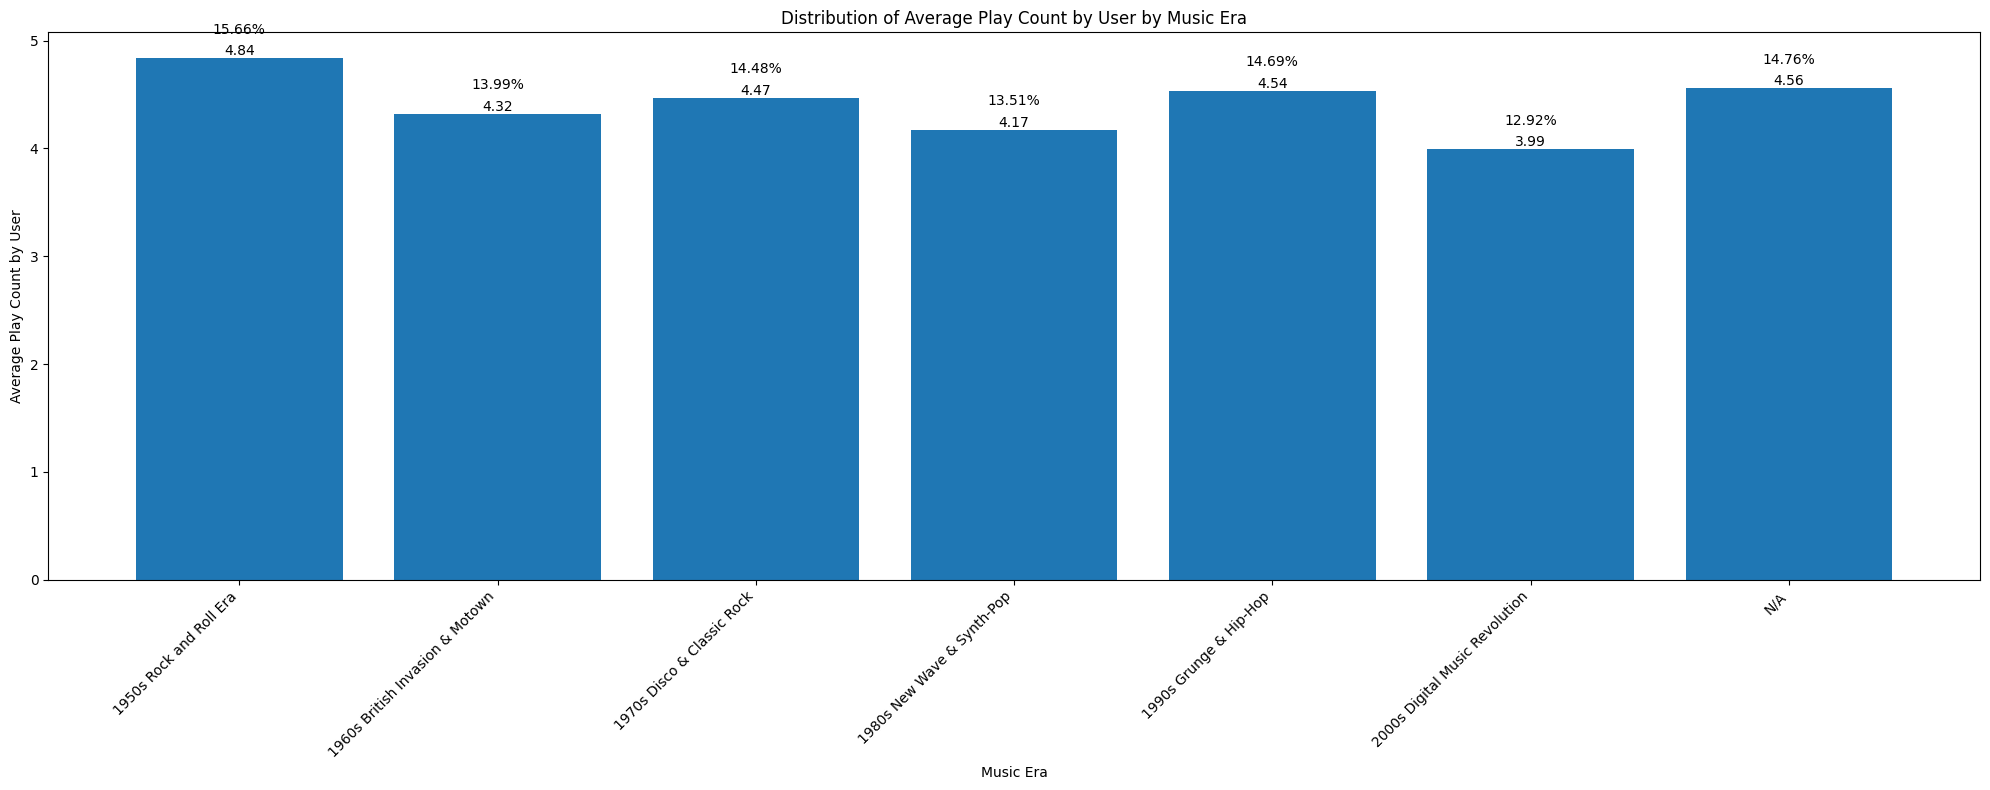

In [ ]:
# depracrate! create a bar plot to show distribution of average play count by user by music era and display value and percentage

import matplotlib.pyplot as plt

# Group by 'Music_era' and calculate the average play count per user
avg_play_count_by_era = df_final.groupby(['Music_era'])['play_count'].mean()

# Create the bar plot
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_play_count_by_era.index, avg_play_count_by_era.values)

# Add value labels above each bar (the average play count)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Calculate total average play count (sum of all averages)
total_avg_play_count = avg_play_count_by_era.sum()

# Calculate percentages
percentages = (avg_play_count_by_era / total_avg_play_count) * 100

# Add percentage labels above each bar, with more vertical space between values
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{round(percentage, 2)}%", ha='center', va='bottom')  # Increased vertical offset

# Set plot labels and title
plt.xlabel('Music Era')
plt.ylabel('Average Play Count by User')
plt.title('Distribution of Average Play Count by User by Music Era')
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()




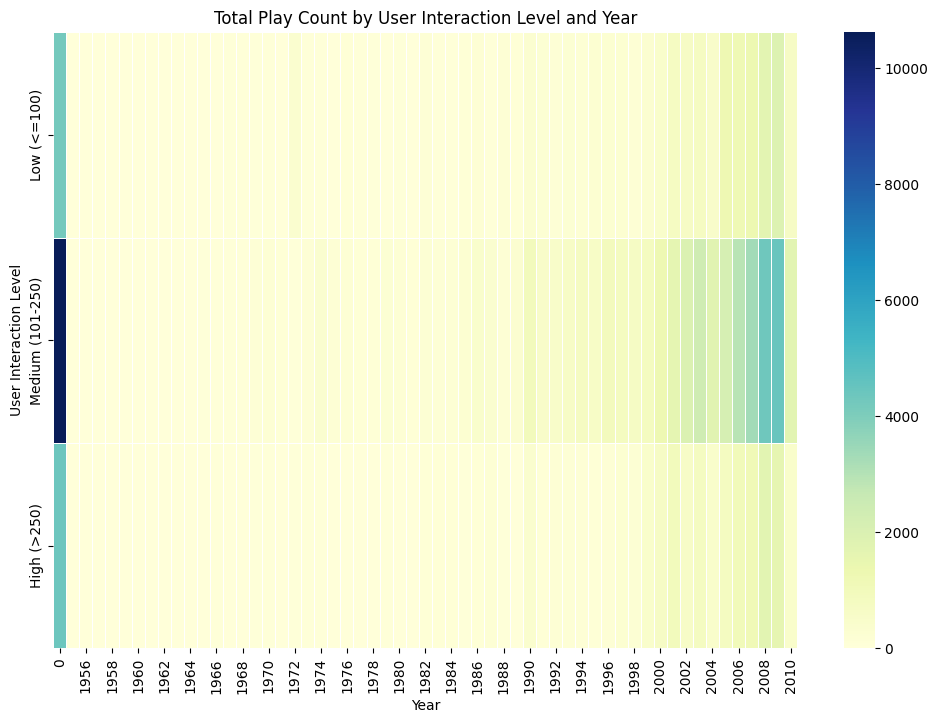

In [ ]:
# heat map: user activity level vs year
# Group data by user_id and calculate the total play count for each user
user_play_counts = df_final.groupby('user_id')['play_count'].sum()

# Define activity levels: low = 100 or fewer, medium = 101-250, high = 250+
activity_bins = [0, 100, 250, float('inf')]
activity_labels = ['Low (<=100)', 'Medium (101-250)', 'High (>250)']
df_final['user_activity_level'] = pd.cut(user_play_counts, bins=activity_bins, labels=activity_labels, include_lowest=True)

# Create a cross-tabulation to show total play count by user activity level and year
play_count_by_activity_and_year = pd.crosstab(df_final['user_activity_level'], df_final['year'], values=df_final['play_count'], aggfunc='sum')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(play_count_by_activity_and_year, annot=False, fmt='.2f', cmap='YlGnBu', linewidths=0.5)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('User Interaction Level')
plt.title('Total Play Count by User Interaction Level and Year')

# Show the plot
plt.show()

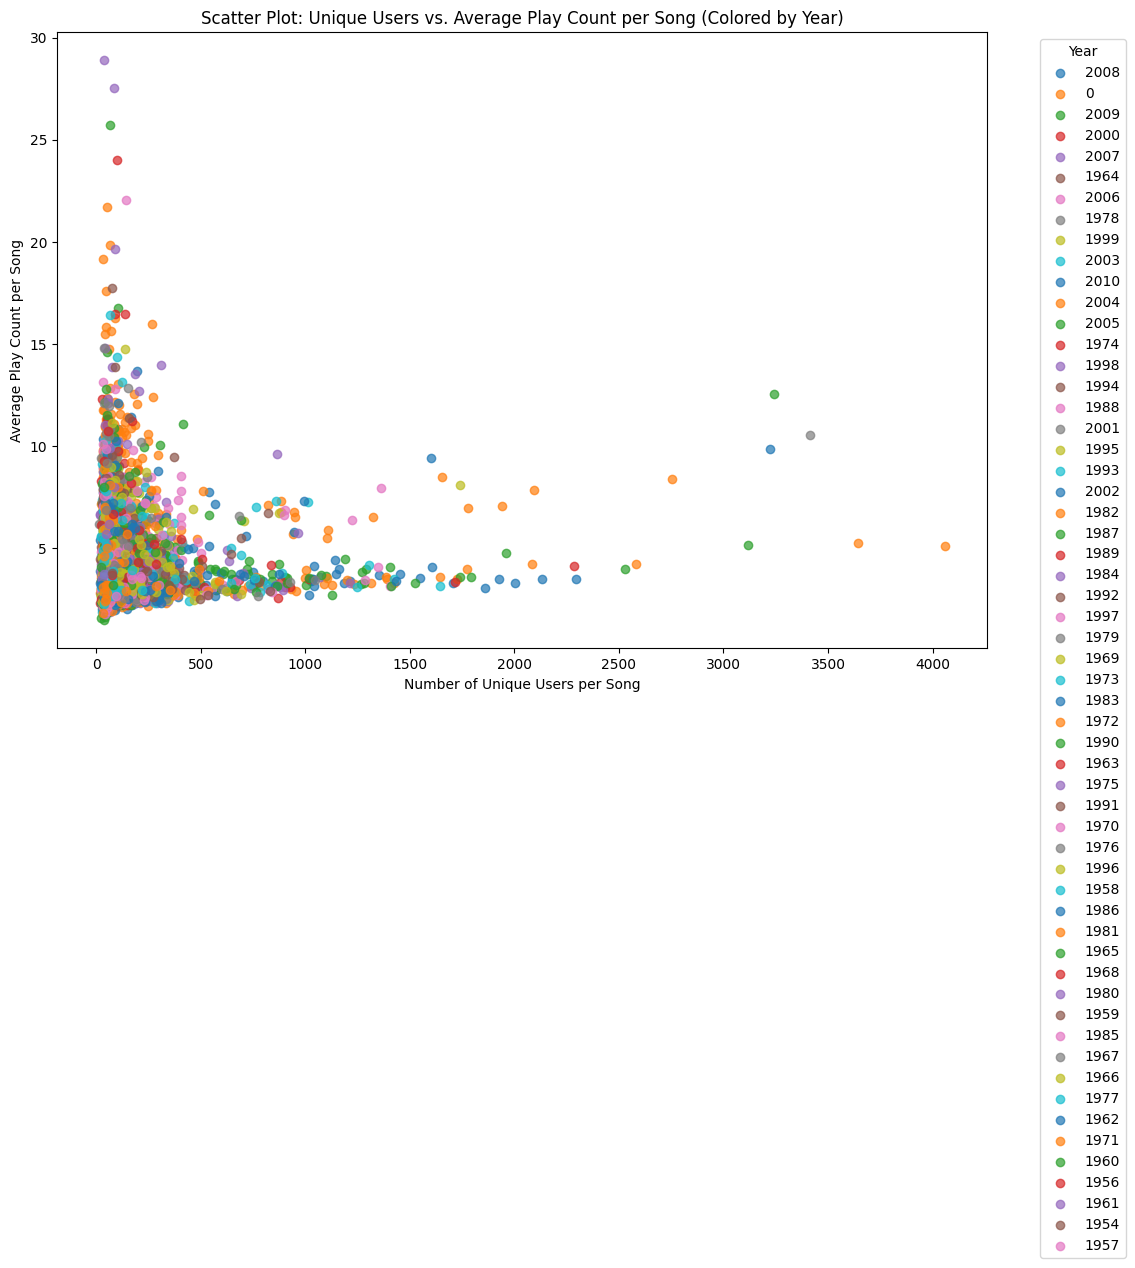

In [ ]:
# prompt: create a scatter plot, x is number of uniques users per song, y is average play count per song, color is year, use different for each year

# Assuming df_final has been defined and has 'song_id', 'user_id', 'play_count', and 'year' columns

# Calculate unique users per song
unique_users_per_song = df_final.groupby('song_id')['user_id'].nunique()

# Calculate average play count per song
avg_play_count_per_song = df_final.groupby('song_id')['play_count'].mean()

# Combine the two calculations into a DataFrame
song_stats = pd.DataFrame({'unique_users': unique_users_per_song, 'avg_play_count': avg_play_count_per_song})

# Merge with df_final to get the year for each song
song_stats = pd.merge(song_stats, df_final[['song_id', 'year']], on='song_id', how='left').drop_duplicates()

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Iterate through unique years and plot each year's data with a different color
for year in song_stats['year'].unique():
    song_stats_year = song_stats[song_stats['year'] == year]
    plt.scatter(song_stats_year['unique_users'], song_stats_year['avg_play_count'], label=str(year), alpha=0.7)

plt.xlabel('Number of Unique Users per Song')
plt.ylabel('Average Play Count per Song')
plt.title('Scatter Plot: Unique Users vs. Average Play Count per Song (Colored by Year)')
plt.legend(title='Year', loc='best', bbox_to_anchor=(1.05, 1))  # Adjust legend position as needed

plt.show()


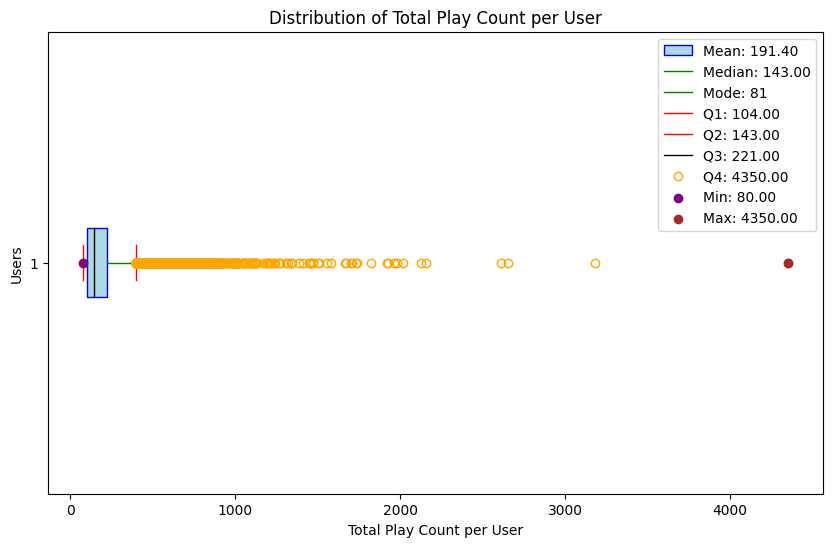

In [ ]:
# prompt: based on total play count per user.  create a horizontal box plot to show statistics,
# # # including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.
# # # add scatter

# Calculate total play count per user
user_total_play_counts = df_final.groupby('user_id')['play_count'].sum()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(user_total_play_counts, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_total_play_count = np.mean(user_total_play_counts)
median_total_play_count = np.median(user_total_play_counts)
mode_total_play_count = user_total_play_counts.mode()[0] if not user_total_play_counts.mode().empty else "N/A"
q1 = np.percentile(user_total_play_counts, 25)
q2 = np.percentile(user_total_play_counts, 50)
q3 = np.percentile(user_total_play_counts, 75)
q4 = np.percentile(user_total_play_counts, 100)
min_total_play_count = np.min(user_total_play_counts)
max_total_play_count = np.max(user_total_play_counts)

# Mark min and max on the plot
plt.scatter(min_total_play_count, 1, color='purple', label=f'Min: {min_total_play_count:.2f}', zorder=3)
plt.scatter(max_total_play_count, 1, color='brown', label=f'Max: {max_total_play_count:.2f}', zorder=3)


# Display the statistics in the legend
plt.legend([
    f'Mean: {mean_total_play_count:.2f}',
    f'Median: {median_total_play_count:.2f}',
    f'Mode: {mode_total_play_count}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_total_play_count:.2f}',
    f'Max: {max_total_play_count:.2f}'
], loc='upper right')


plt.xlabel('Total Play Count per User')
plt.ylabel('Users')
plt.title('Distribution of Total Play Count per User')
plt.show()


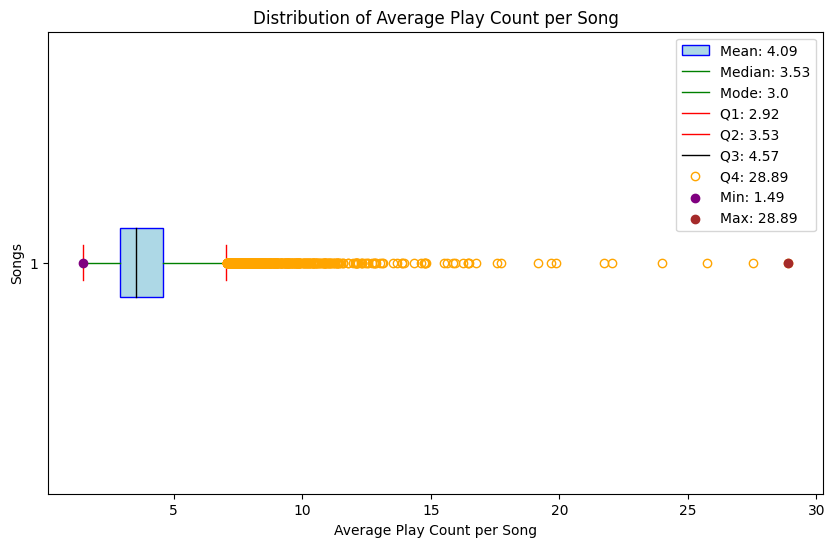

In [ ]:
# based on average play count per song.  create a horizontal box plot to show statistics,
# including mean,median, mode and q1, q2, q3, q4, min and max, use different line colors, and display values in the legend.
# add scatter

import matplotlib.pyplot as plt
import numpy as np

# Calculate average play count per song
avg_play_count_per_song = df_final.groupby('song_id')['play_count'].mean()

# Create a horizontal box plot
plt.figure(figsize=(10, 6))
plt.boxplot(avg_play_count_per_song, vert=False, patch_artist=True,
            boxprops=dict(color='blue', facecolor='lightblue'),
            capprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            flierprops=dict(markeredgecolor='orange'),
            medianprops=dict(color='black'))

# Calculate statistics
mean_avg_play_count = np.mean(avg_play_count_per_song)
median_avg_play_count = np.median(avg_play_count_per_song)
mode_avg_play_count = avg_play_count_per_song.mode()[0] if not avg_play_count_per_song.mode().empty else "N/A"
q1 = np.percentile(avg_play_count_per_song, 25)
q2 = np.percentile(avg_play_count_per_song, 50)
q3 = np.percentile(avg_play_count_per_song, 75)
q4 = np.percentile(avg_play_count_per_song, 100)
min_avg_play_count = np.min(avg_play_count_per_song)
max_avg_play_count = np.max(avg_play_count_per_song)

# Mark min and max on the plot
plt.scatter(min_avg_play_count, 1, color='purple', label=f'Min: {min_avg_play_count:.2f}', zorder=3)
plt.scatter(max_avg_play_count, 1, color='brown', label=f'Max: {max_avg_play_count:.2f}', zorder=3)


# Display the statistics in the legend
plt.legend([
    f'Mean: {mean_avg_play_count:.2f}',
    f'Median: {median_avg_play_count:.2f}',
    f'Mode: {mode_avg_play_count}',
    f'Q1: {q1:.2f}',
    f'Q2: {q2:.2f}',
    f'Q3: {q3:.2f}',
    f'Q4: {q4:.2f}',
    f'Min: {min_avg_play_count:.2f}',
    f'Max: {max_avg_play_count:.2f}'
], loc='upper right')

plt.xlabel('Average Play Count per Song')
plt.ylabel('Songs')
plt.title('Distribution of Average Play Count per Song')
plt.show()


#### **Observations and Insights:__________**


### **Let's find out about the most interacted songs and interacted users**

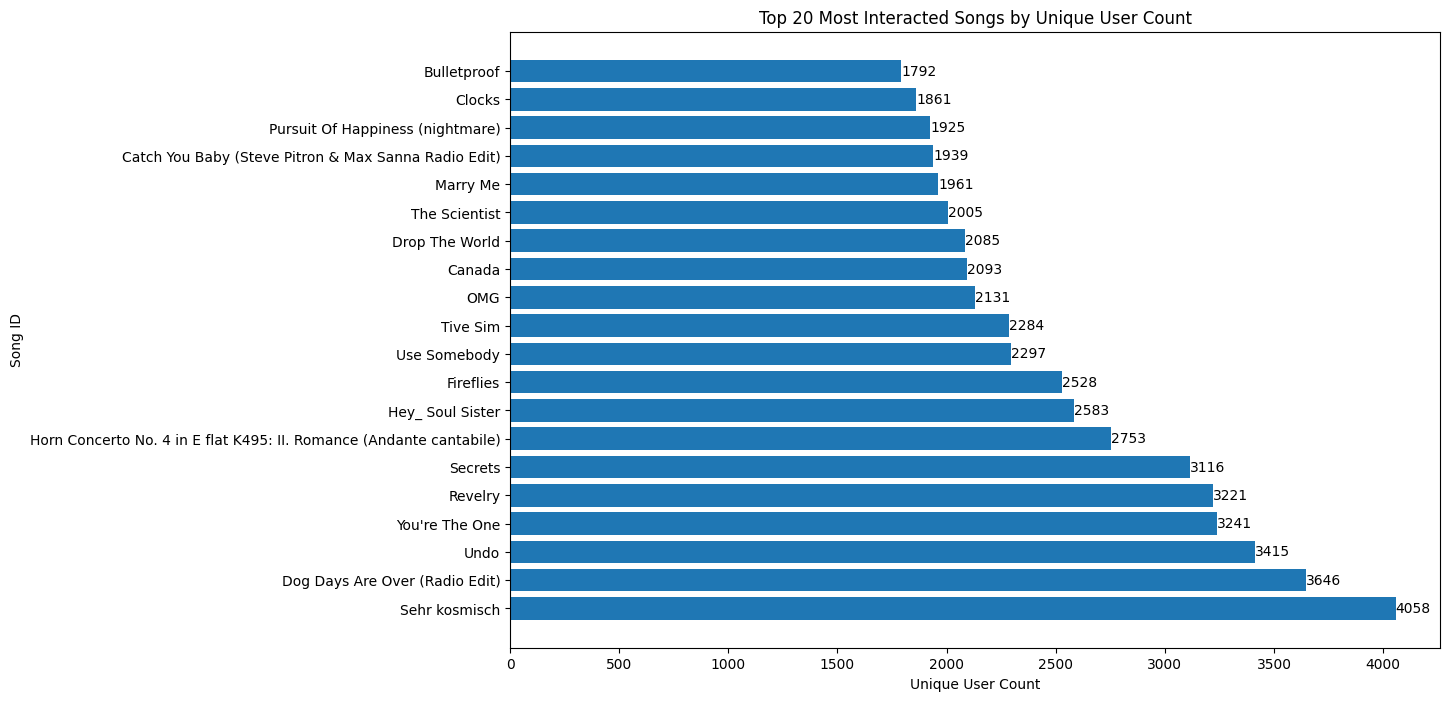

In [ ]:
# prompt: convert user_id and song_id to string, then create a horizontal plot to show top 20 Most interacted songs by unique user count. sort desceding. using song title and display values on each bar

# Convert user_id and song_id to strings
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Group by song_id and count unique users
song_user_counts = df_final.groupby('song_id')['user_id'].nunique()

# Sort in descending order and get the top 20
top_20_songs = song_user_counts.sort_values(ascending=False).head(20)

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(top_20_songs.index, top_20_songs.values)

# Add value labels on each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.0f}',
             ha='left', va='center')

# Set labels and title
plt.xlabel('Unique User Count')
plt.ylabel('Song ID')
plt.title('Top 20 Most Interacted Songs by Unique User Count')

# Add song titles to the y-axis if available in your df_final
if 'title' in df_final.columns:
    song_titles = df_final.groupby('song_id')['title'].first()
    plt.yticks(top_20_songs.index, [song_titles.get(song_id, song_id) for song_id in top_20_songs.index])

plt.show()


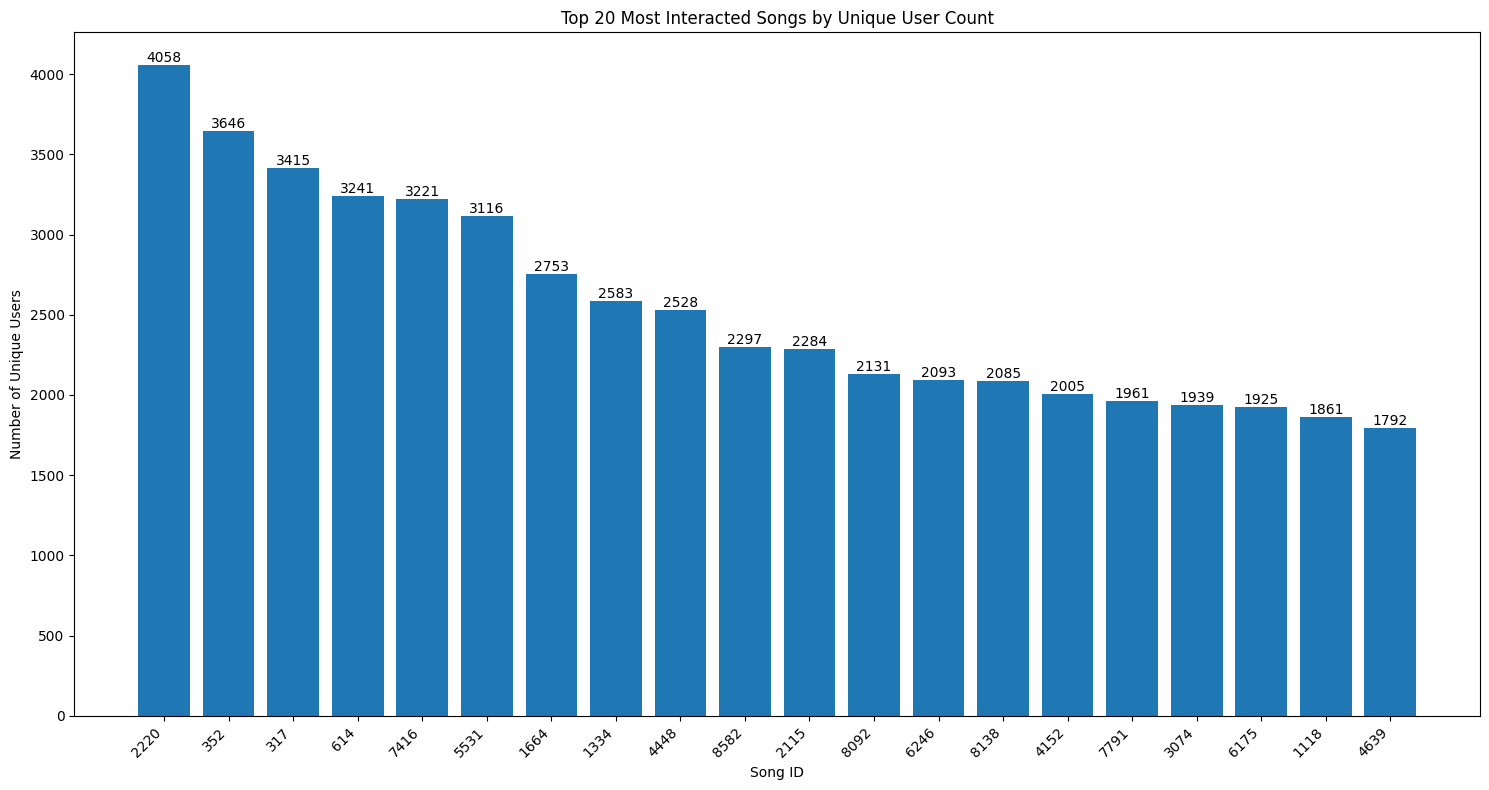

In [ ]:
# prompt: convert user_id and song_id to string, then create a plot to show top 20 Most interacted songs by unique user count and display values on each bar

# Convert user_id and song_id to string
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Group by song ID and count the number of unique users who played the song
song_user_counts = df_final.groupby('song_id')['user_id'].nunique()

# Sort the song user counts in descending order
top_20_songs = song_user_counts.sort_values(ascending=False)[:20]

# Create a bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(top_20_songs.index, top_20_songs.values)

# Add value labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Song ID')
plt.ylabel('Number of Unique Users')
plt.title('Top 20 Most Interacted Songs by Unique User Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


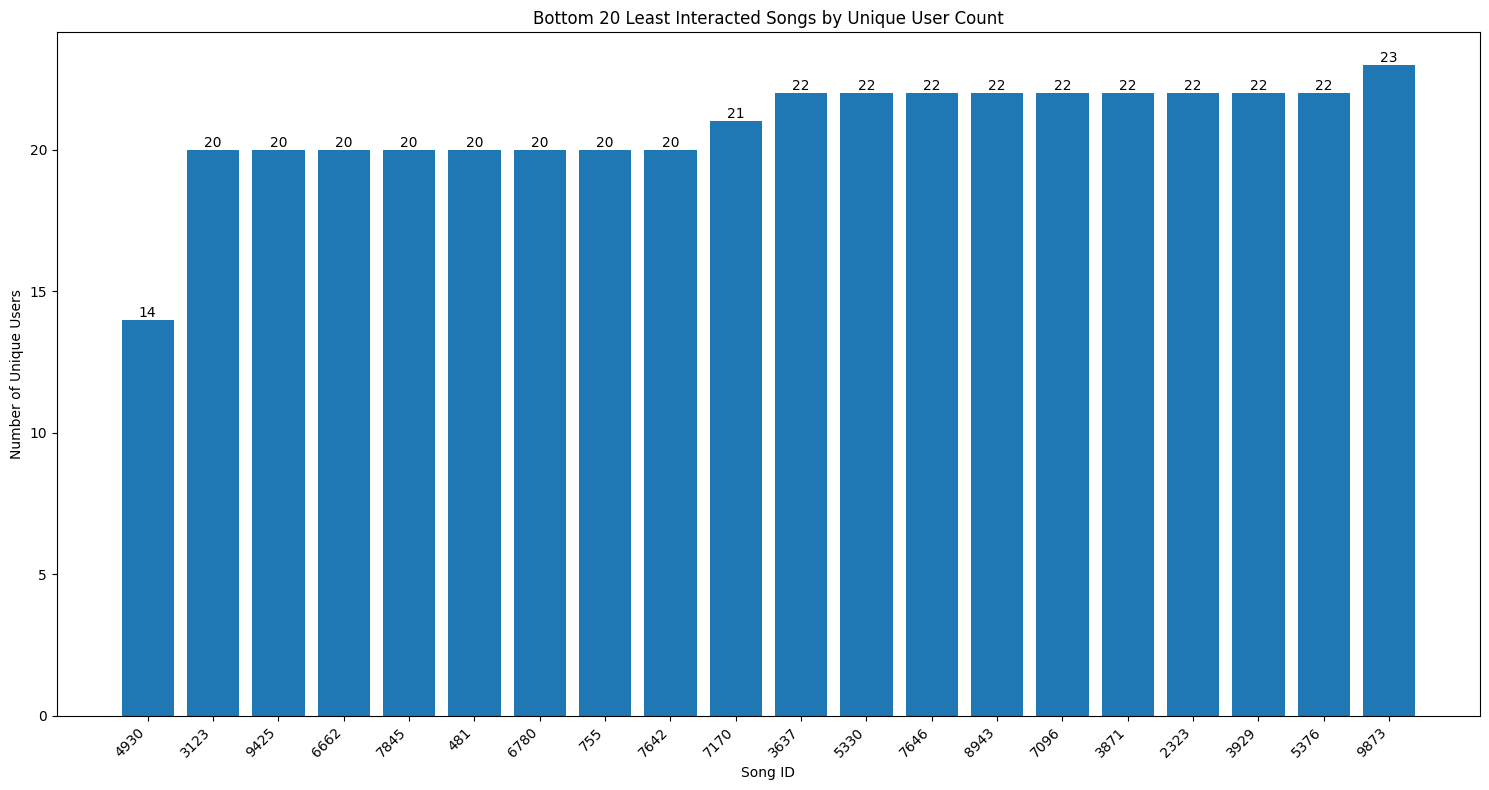

In [ ]:
# prompt:  convert user_id and song_id to string, then create a plot to show bottom 20 Most interacted songs by unique user count and display values on each bar

# Convert user_id and song_id to string (if not already done)
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Group by song ID and count the number of unique users who played the song
song_user_counts = df_final.groupby('song_id')['user_id'].nunique()

# Sort the song user counts in ascending order to get the bottom 20
bottom_20_songs = song_user_counts.sort_values(ascending=True)[:20]

# Create a bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(bottom_20_songs.index, bottom_20_songs.values)

# Add value labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Song ID')
plt.ylabel('Number of Unique Users')
plt.title('Bottom 20 Least Interacted Songs by Unique User Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


Most interacted users

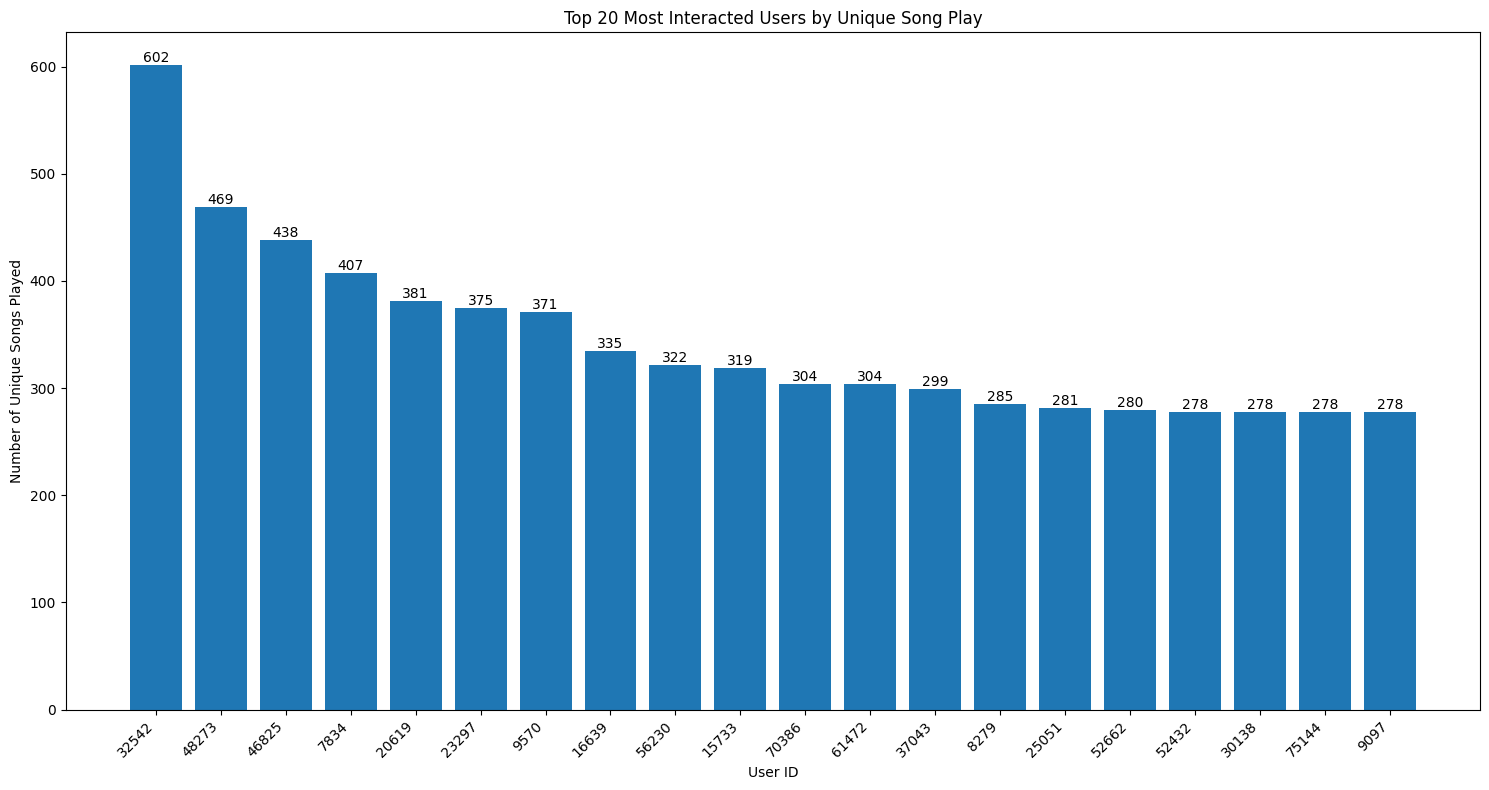

In [ ]:
# prompt: convert user_id and song_id to string, create a plot to show top 20 Most interacted users by unique song play

# Convert user_id and song_id to string (if not already done)
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Group by user ID and count the number of unique songs played by each user
user_song_counts = df_final.groupby('user_id')['song_id'].nunique()

# Sort the user song counts in descending order
top_20_users = user_song_counts.sort_values(ascending=False)[:20]

# Create a bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(top_20_users.index, top_20_users.values)

# Add value labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('User ID')
plt.ylabel('Number of Unique Songs Played')
plt.title('Top 20 Most Interacted Users by Unique Song Play')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


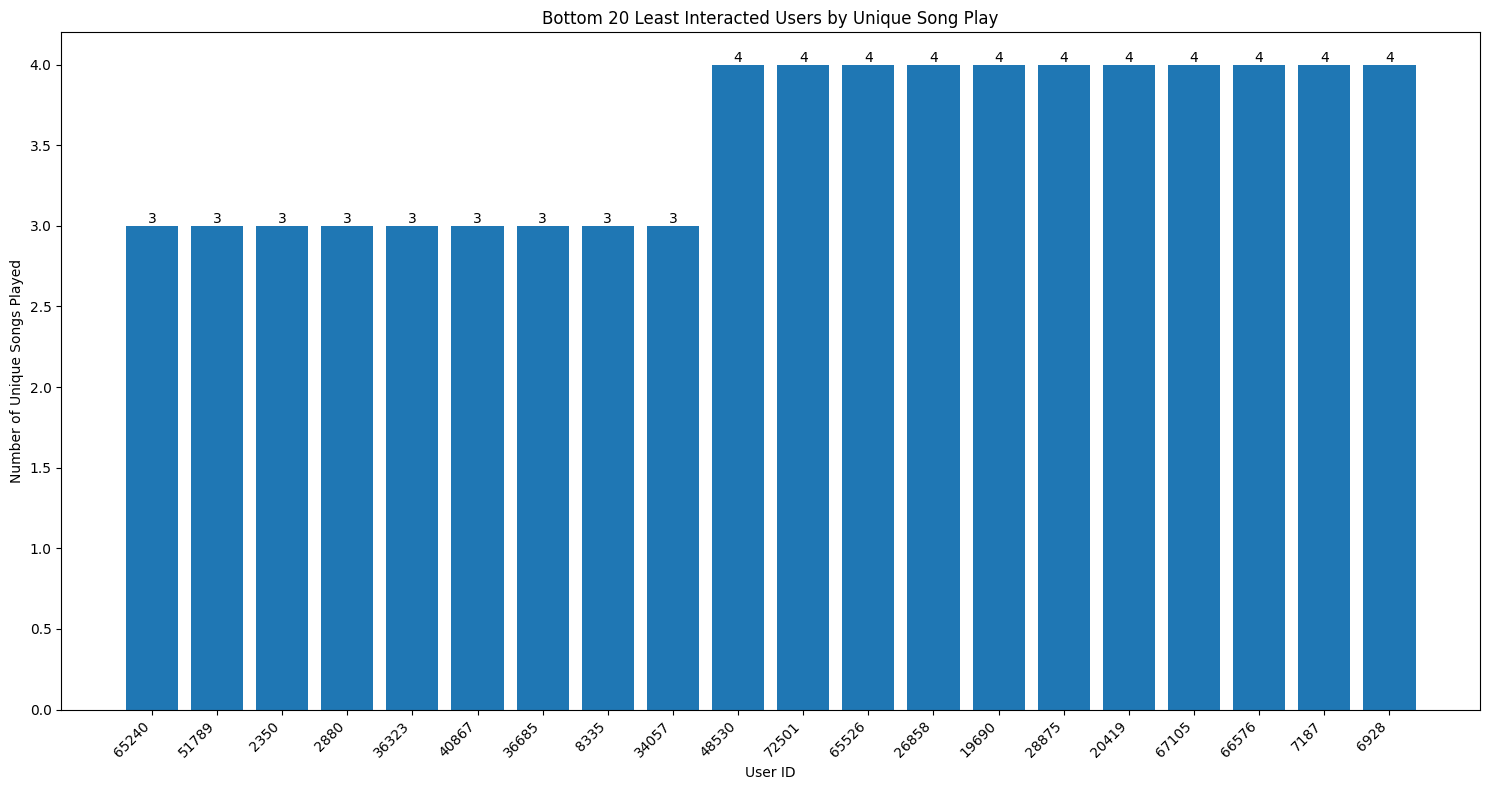

In [ ]:
# prompt: convert user_id and song_id to string, create a plot to show bottom 20 leasted interacted users by unique song play

# Convert user_id and song_id to string (if not already done)
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Group by user ID and count the number of unique songs played by each user
user_song_counts = df_final.groupby('user_id')['song_id'].nunique()

# Sort the user song counts in ascending order to get the bottom 20
bottom_20_users = user_song_counts.sort_values(ascending=True)[:20]

# Create a bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(bottom_20_users.index, bottom_20_users.values)

# Add value labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('User ID')
plt.ylabel('Number of Unique Songs Played')
plt.title('Bottom 20 Least Interacted Users by Unique Song Play')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


In [ ]:
#  what are the top 20 most popular and least popular songs, print the ID and song title

# Assuming 'df_final' is your DataFrame and it contains 'song_id', 'title', and 'popularity_score' columns.

# Sort songs by popularity score in descending order to get the top 20 most popular songs
top_20_popular_songs = df_final.sort_values('popularity_score', ascending=False).groupby('song_id').first().head(20)[['title']]

# Print the top 20 most popular songs
print("Top 20 Most Popular Songs:")
for song_id, row in top_20_popular_songs.iterrows():
  print(f"Song ID: {song_id}, Title: {row['title']}")

# Sort songs by popularity score in ascending order to get the top 20 least popular songs
top_20_least_popular_songs = df_final.sort_values('popularity_score', ascending=True).groupby('song_id').first().head(20)[['title']]

# Print the top 20 least popular songs
print("\nTop 20 Least Popular Songs:")
for song_id, row in top_20_least_popular_songs.iterrows():
  print(f"Song ID: {song_id}, Title: {row['title']}")


Top 20 Most Popular Songs:
Song ID: 0, Title: Orgelblut
Song ID: 1, Title: Cearc Agus Coileach / The Hen And Cock
Song ID: 2, Title: I Gotta Feeling (Edit)
Song ID: 3, Title: Godlovesugly
Song ID: 4, Title: Rome Wasn't Built In A Day
Song ID: 5, Title: Jesus Loves You (Album Version)
Song ID: 7, Title: So Confused (feat. Butta Creame) (amended album version)
Song ID: 8, Title: Stay Awhile
Song ID: 10, Title: Criminal
Song ID: 11, Title: Juke Box Hero (Remastered LP Version )
Song ID: 13, Title: Radio
Song ID: 14, Title: Love Don't Live Here Anymore
Song ID: 15, Title: My Shepherd (Psalms 23) (featuring Kurt Carr & Avalon)
Song ID: 16, Title: STARSTRUKK [FEATURINGKATYPERRY] (Explicit Bonus Version)
Song ID: 17, Title: Hallelujah (Album Version)
Song ID: 18, Title: Brand New Day
Song ID: 19, Title: Psycho
Song ID: 20, Title: Shadow Of The Day (Album Version)
Song ID: 21, Title: Back Against The Wall
Song ID: 22, Title: Halo

Top 20 Least Popular Songs:
Song ID: 0, Title: Orgelblut
Song I

#### **Observations and Insights:_______**


Songs released on yearly basis

In [ ]:
# count of the songs in an year using the title count
count_songs = df.groupby('year').count()['title']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace = True)
count.tail()

title
year        
2006  123331
2007  162573
2008  166788
2009  179168
2010   66914

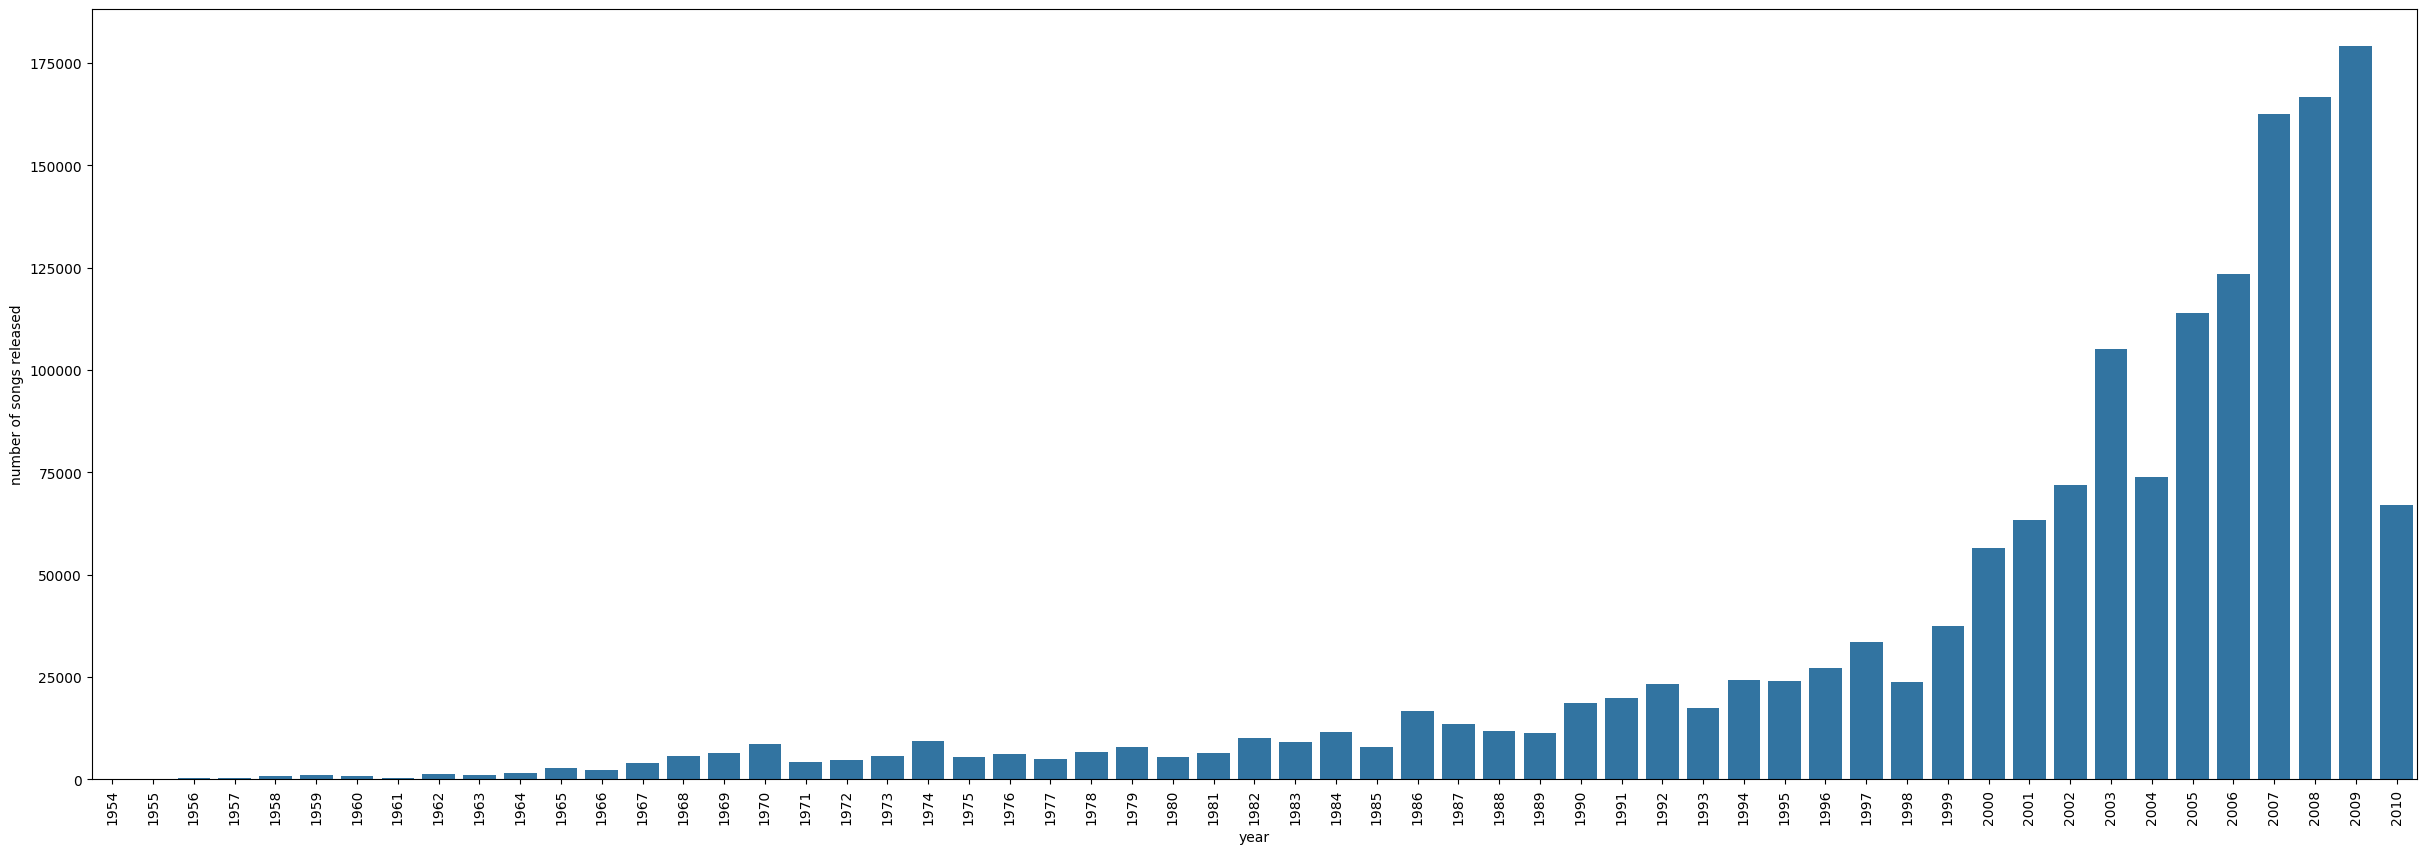

In [ ]:
plt.figure(figsize = (30,10))
ax = sns.barplot(x = count.index,
            y = 'title',
            data = count,
            estimator = np.median,)
for item in ax.get_xticklabels(): item.set_rotation(90)
plt.ylabel('number of songs released')
# Show the plot
plt.show()

#### **Observations and Insights:__________** #

**Think About It:** What other insights can be drawn using exploratory data analysis?

## **Important Insights from EDA**

What are the the most important observations and insights from the data based on the EDA performed?

Now that we have explored the data, let's apply different algorithms to build recommendation systems.

## Building various models

### **Custom Approach- Popularity-Based Recommendation Systems [hybird approach, popularity score, average play count]**

**1. Recommend most popular songs**

In [ ]:
# get a list of top 10 songs by popularity , print title, artitist, release, year, popularity score

# Assuming 'df_final' is your DataFrame and it contains 'song_id', 'title', 'artist_name', 'release', 'year', 'popularity_score' columns.

# Sort songs by popularity score in descending order to get the top 10 most popular songs
top_10_popular_songs = df_final.sort_values('popularity_score', ascending=False).groupby('song_id').first().head(10)[['title', 'artist_name', 'release', 'year', 'popularity_score']]

# Print the top 10 most popular songs
print("Top 10 Most Popular Songs:")
for song_id, row in top_10_popular_songs.iterrows():
  print(f"Song ID: {song_id}, Title: {row['title']}, Artist: {row['artist_name']}, Release: {row['release']}, Year: {row['year']}, Popularity Score: {row['popularity_score']}")


Top 10 Most Popular Songs:
Song ID: 0, Title: Orgelblut, Artist: Bohren & Der Club Of Gore, Release: Dolores, Year: 2008, Popularity Score: 0.03531449289703641
Song ID: 1, Title: Cearc Agus Coileach / The Hen And Cock, Artist: Mícheál Ó Súilleabháin, Release: Casadh/Turning, Year: 0, Popularity Score: 0.025998368312864183
Song ID: 2, Title: I Gotta Feeling (Edit), Artist: The Black Eyed Peas, Release: Now That's What I Call Music! 74, Year: 2009, Popularity Score: 0.021188210629985882
Song ID: 3, Title: Godlovesugly, Artist: Atmosphere, Release: God Loves Ugly, Year: 0, Popularity Score: 0.01466893001405951
Song ID: 4, Title: Rome Wasn't Built In A Day, Artist: Morcheeba, Release: Parts Of The Process, Year: 2000, Popularity Score: 0.016738241911653788
Song ID: 5, Title: Jesus Loves You (Album Version), Artist: Stellar Kart, Release: Expect The Impossible, Year: 2008, Popularity Score: 0.07692789923490134
Song ID: 7, Title: So Confused (feat. Butta Creame) (amended album version), Arti

**2. Recommend diverse songs for new discoveries. **

In [ ]:
# prompt: print top 2 songs based on average play count from percentile of popularity score in 5%, 10%, 20%. print each song's ID, title, artist, release, year, average play count

# Assuming 'df_final' is your DataFrame and it contains 'song_id', 'title', 'artist_name', 'release', 'year', 'popularity_score', 'play_count' columns.

for percentile in [5, 10, 20]:
  # Calculate the threshold for the percentile
  threshold = np.percentile(df_final['popularity_score'], percentile)

  # Filter songs within the percentile range
  songs_within_percentile = df_final[df_final['popularity_score'] <= threshold]

  # Group by song_id and calculate the average play count
  avg_play_count_per_song = songs_within_percentile.groupby('song_id')['play_count'].mean()

  # Sort by average play count in descending order and get the top 2 songs
  top_2_songs = avg_play_count_per_song.sort_values(ascending=False).head(2)

  print(f"\nTop 2 songs based on average play count within the {percentile}th percentile of popularity score:")

  for song_id in top_2_songs.index:
    song_data = df_final[df_final['song_id'] == song_id].groupby('song_id').first()
    print(f"Song ID: {song_id}, Title: {song_data['title'].values[0]}, Artist: {song_data['artist_name'].values[0]}, Release: {song_data['release'].values[0]}, Year: {song_data['year'].values[0]}, Average Play Count: {top_2_songs[song_id]:.2f}")




Top 2 songs based on average play count within the 5th percentile of popularity score:
Song ID: 8861, Title: Corn Bread, Artist: DAVE MATTHEWS BAND, Release: Europe 2009, Year: 2009, Average Play Count: 2.67
Song ID: 1838, Title: Outta Control, Artist: Rebelution, Release: Bright Side of Life, Year: 2009, Average Play Count: 2.67

Top 2 songs based on average play count within the 10th percentile of popularity score:
Song ID: 3944, Title: Felicidade, Artist: Suba  feat. Cibelle, Release: Sao Paulo Confessions, Year: 2001, Average Play Count: 2.93
Song ID: 6583, Title: Ask The Mountains, Artist: Vangelis, Release: Voices, Year: 1997, Average Play Count: 2.92

Top 2 songs based on average play count within the 20th percentile of popularity score:
Song ID: 7912, Title: Composure, Artist: August Burns Red, Release: Messengers, Year: 2007, Average Play Count: 3.31
Song ID: 4513, Title: Black Jack County Chains, Artist: The Del McCoury Band, Release: By Request, Year: 0, Average Play Count:

#### Draft approach:

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [ ]:
# prompt: # Calculating total play count, average play count per user, unique user count. Making a dataframe with the total play count as play_freq, average_count and  and unique user count  call final_play

# Group by song ID and calculate total play count, average play count per user, and unique user count
song_stats = df_final.groupby('song_id').agg({'play_count': ['sum', 'mean'], 'user_id': 'nunique'})

# Flatten the column names
song_stats.columns = ['_'.join(col) for col in song_stats.columns]

# Rename columns
song_stats = song_stats.rename(columns={
    'play_count_sum': 'play_freq',
    'play_count_mean': 'average_count',
    'user_id_nunique': 'unique_user_count'
})

# Create a new DataFrame called final_play
final_play = song_stats

print(final_play.head())


         play_freq  average_count  unique_user_count
song_id                                             
0              159       3.785714                 42
1              242       3.063291                 79
2              109       2.868421                 38
3               95       2.435897                 39
4              245       2.425743                101


In [ ]:
# Let us see the first five records of the final_play dataset
final_play.head()

play_freq  average_count  unique_user_count
song_id                                             
0              159       3.785714                 42
1              242       3.063291                 79
2              109       2.868421                 38
3               95       2.435897                 39
4              245       2.425743                101

In [ ]:
# what is the play freq and average count per user and unique user count in each percentile at 10 interval

percentiles = [10, 20 ,30 ,40 ,50 ,60 ,70 ,80 ,90]

for percentile in percentiles:
  play_freq_percentile = final_play['play_freq'].quantile(percentile / 100)
  average_count_percentile = final_play['average_count'].quantile(percentile / 100)
  unique_user_count_percentile = final_play['unique_user_count'].quantile(percentile / 100)

  print(f"At the {percentile}th percentile:")
  print(f"  Play Frequency: {play_freq_percentile}")
  print(f"  Average Count per User: {average_count_percentile}")
  print(f"  Unique User Count: {unique_user_count_percentile}")
  print("---")


At the 10th percentile:
  Play Frequency: 127.0
  Average Count per User: 2.563758389261745
  Unique User Count: 39.0
---
At the 20th percentile:
  Play Frequency: 160.0
  Average Count per User: 2.813953488372093
  Unique User Count: 46.0
---
At the 30th percentile:
  Play Frequency: 193.0
  Average Count per User: 3.0344827586206895
  Unique User Count: 52.0
---
At the 40th percentile:
  Play Frequency: 228.0
  Average Count per User: 3.272727272727273
  Unique User Count: 60.0
---
At the 50th percentile:
  Play Frequency: 272.0
  Average Count per User: 3.52755905511811
  Unique User Count: 71.0
---
At the 60th percentile:
  Play Frequency: 333.0
  Average Count per User: 3.847058823529412
  Unique User Count: 85.0
---
At the 70th percentile:
  Play Frequency: 423.0
  Average Count per User: 4.3
  Unique User Count: 104.0
---
At the 80th percentile:
  Play Frequency: 578.0
  Average Count per User: 4.9772727272727275
  Unique User Count: 140.0
---
At the 90th percentile:
  Play Freq

Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

**Recommend most popular songs currently:**

In [ ]:
# prompt: Build the function to find top n songs from final_play by unique user count average_count. pass a dynamic thresholds on minimum number of unique user count for a song in the 90 percentile and play frequency using the 90 percentile. print threshold values. print the top 10 ranked songs with user count, average count, total play count, music era, title, artist name.

def recommend_top_n_songs_by_unique_user_count(final_play, n=10, threshold_unique_user_count=None, threshold_play_freq=None):
  """
  Recommends the top N songs based on the average play count and user count
  """
  df_filtered = final_play.copy()
  if threshold_unique_user_count:
    df_filtered = df_filtered[df_filtered['unique_user_count'] >= threshold_unique_user_count]
  if threshold_play_freq:
    df_filtered = df_filtered[df_filtered['play_freq'] >= threshold_play_freq]
  top_n_songs = df_filtered.sort_values('unique_user_count', ascending=False).head(n)
  return top_n_songs

# Calculate the 90th percentile for unique user count and play frequency
threshold_unique_user_count = final_play['unique_user_count'].quantile(0.80)
threshold_play_freq = final_play['play_freq'].quantile(0.80)

print(f"Threshold for unique user count (80th percentile): {threshold_unique_user_count}")
print(f"Threshold for play frequency (80th percentile): {threshold_play_freq}")

# Get the top 10 songs
top_10_songs = recommend_top_n_songs_by_unique_user_count(final_play, n=10, threshold_unique_user_count=threshold_unique_user_count, threshold_play_freq=threshold_play_freq)

# Merge with df_final to get additional song information
top_10_songs_with_info = pd.merge(top_10_songs, df_final, on='song_id', how='left')

# Select the relevant columns to display
top_10_ranked_songs = top_10_songs_with_info[[
    'song_id', 'unique_user_count', 'average_count', 'play_freq', 'Music_era', 'title', 'artist_name'
]].drop_duplicates().head(10)

print(top_10_ranked_songs)


Threshold for unique user count (80th percentile): 140.0
Threshold for play frequency (80th percentile): 578.0
      song_id  unique_user_count  average_count  play_freq  \
0        2220               4058       5.104239      20713   
4058      352               3646       5.269062      19211   
7704      317               3415      10.538507      35989   
11119     614               3241      12.535020      40626   
14360    7416               3221       9.859360      31757   
17581    5531               3116       5.186457      16161   
20697    1664               2753       8.388304      23093   
23450    1334               2583       4.208285      10870   
26033    4448               2528       4.005934      10127   
28561    8582               2297       3.478015       7989   

                            Music_era  \
0                                 N/A   
4058                              N/A   
7704   2000s Digital Music Revolution   
11119          1990s Grunge & Hip-Hop   
1

**Recommend diversed songs for new discoveries- based on user input on music era **

> Add blockquote



In [ ]:
# prompt: create an another function to recommend 1 random song from each percentile of final_play: 5, 10, 20, 30, 40, 50, 60, 70, 80, 90 percentile from a music era
#  based on a user input of a music era. print the top 10 ranked songs with user count, average count, total play count, music era, title, artist name.

def recommend_songs_by_percentile_and_era(final_play, df_final, music_era, n_percentiles=10):
  """
  Recommends a random song from each percentile of final_play for a given music era.

  Args:
    final_play: DataFrame with song statistics.
    df_final: DataFrame with song details.
    music_era: The music era to filter songs.
    n_percentiles: The number of percentiles to consider (e.g., 10 for 10th, 20th,... 90th).

  Returns:
    A DataFrame with recommended songs.
  """

  # Filter songs by the given music era
  filtered_songs = df_final[df_final['Music_era'] == music_era]
  filtered_song_ids = filtered_songs['song_id'].unique()

  # Filter final_play to only include songs from the music era
  final_play_filtered = final_play[final_play.index.isin(filtered_song_ids)]

  recommended_songs = []

  # Loop through percentiles and recommend a song from each
  for i in range(5, 100, 10):  # Percentiles from 5th to 90th
      percentile = i / 100
      percentile_value = final_play_filtered['play_freq'].quantile(percentile)
      songs_in_percentile = final_play_filtered[
          final_play_filtered['play_freq'] >= percentile_value
      ]
      if not songs_in_percentile.empty:
          # Randomly select a song from the percentile
          random_song_id = songs_in_percentile.sample(1).index[0]

          recommended_songs.append(random_song_id)

  # Create a DataFrame of recommended songs
  recommended_songs_df = final_play.loc[recommended_songs]

  # Merge with original df to get song details
  recommended_songs_with_details = pd.merge(
      recommended_songs_df,
      df_final[['song_id', 'Music_era', 'title', 'artist_name', 'play_count']],
      left_index=True,
      right_on='song_id',
      how='left'
  ).drop_duplicates()

  # Calculate total play count for each song
  recommended_songs_with_details['total_play_count'] = recommended_songs_with_details['play_freq']

  # Sort by average count in descending order and get the top 10
  top_10_songs = recommended_songs_with_details.sort_values('average_count', ascending=False).head(10)

  return top_10_songs


# Get recommendations for a specific music era
music_era_to_recommend = "1970s Disco & Classic Rock"  # Change to desired music era
recommended_songs = recommend_songs_by_percentile_and_era(
    final_play, df_final, music_era_to_recommend
)

# Print the top 10 ranked songs
print(
    recommended_songs[[
        'song_id',
        'unique_user_count',
        'average_count',
        'total_play_count',
        'Music_era',
        'title',
        'artist_name',
    ]]
)


        song_id  unique_user_count  average_count  total_play_count  \
1997650    1649                 35      12.114286               424   
567246     1649                 35      12.114286               424   
63794      1649                 35      12.114286               424   
64495      1649                 35      12.114286               424   
140833     1649                 35      12.114286               424   
156871     1649                 35      12.114286               424   
236765     1649                 35      12.114286               424   
335019     1649                 35      12.114286               424   
367960     1649                 35      12.114286               424   
145834     1649                 35      12.114286               424   

                          Music_era                             title  \
1997650  1970s Disco & Classic Rock  Fight On (2002 Digital Remaster)   
567246   1970s Disco & Classic Rock  Fight On (2002 Digital Remaster)   

### **User User Similarity-Based Collaborative Filtering**

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

### performane metric functions

Below is the function to calculate precision@k and recall@k, RMSE and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

### **Modfied performance metrics precision_recall_at_k function to include: MAP, Diveristy, Novelty**

In [ ]:
from collections import defaultdict
import numpy as np

# Define the precision_recall_at_k function with NDCG and threshold for relevance
def precision_recall_at_k(model, testset, k=30, threshold=0.5, confidence_threshold=2.5):
    """Return and print precision, recall, MAP, diversity, novelty, and NDCG for implicit feedback data."""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    # Track unique recommendations for diversity
    unique_recommendations = set()

    # Store metrics for each user
    precisions = dict()
    recalls = dict()
    aps = dict()  # For MAP
    novelty_scores = dict()  # For novelty
    ndcgs = dict()  # For NDCG

    for uid, song_id, true_r, est, _ in predictions:
        # Append predicted interaction (est) and a proxy true value (true_r) (implicit feedback)
        user_est_true[uid].append((est, true_r))

    for uid, playing_count in user_est_true.items():

        # Sort play count by estimated value
        playing_count.sort(key=lambda x: x[0], reverse=True)

        # Filter based on confidence threshold
        playing_count = [(est, true_r) for (est, true_r) in playing_count if est >= confidence_threshold]

        # Number of relevant items (true_r >= threshold)
        n_rel = sum((true_r >= threshold) for (_, true_r) in playing_count)

        # Number of recommended items in top k (est >= threshold)
        n_rec_k = sum((est >= threshold) for (est, _) in playing_count[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in playing_count[:k])

        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP calculation
        running_sum = 0
        rel_count = 0
        for i, (est, true_r) in enumerate(playing_count[:k], 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / i
        aps[uid] = running_sum / rel_count if rel_count > 0 else 0

        # Track unique recommendations for diversity
        for est, _ in playing_count[:k]:
            unique_recommendations.add(est)

        # Novelty: based on how many times a recommended song has been played across users
        if len(playing_count[:k]) > 0:
            novelty_scores[uid] = np.mean([1 / (est + 0.2) for (est, _) in playing_count[:k]])
        else:
            novelty_scores[uid] = None  # Handle empty recommendation

        # NDCG calculation
        dcg = 0.0
        idcg = 0.0
        for i, (est, true_r) in enumerate(playing_count[:k], 1):
            rel = 1 if true_r >= threshold else 0  # Relevance: 1 if true rating is >= threshold
            dcg += (rel / np.log2(i + 1))
            idcg += (1 / np.log2(i + 1))  # Ideal DCG: assumes perfect ranking
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0

    # Mean of all the predicted precisions
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    # Mean of all the predicted recalls
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    # Mean Average Precision (MAP)
    map_score = round((sum(ap for ap in aps.values()) / len(aps)), 3)
    # Diversity: proportion of unique recommendations to total recommendations
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3)

    # Mean novelty score
    if len(novelty_scores) > 0:
        novelty_values = [novelty for novelty in novelty_scores.values() if novelty is not None]
        if len(novelty_values) > 0:
            novelty = round((sum(novelty_values) / len(novelty_values)), 3)
        else:
            novelty = None  # All novelty values were None
    else:
        novelty = None  # No recommendations

    # Mean NDCG score
    ndcg = round((sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)), 3)

    # Print the metrics with labels
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3))  # Formula to compute the F-1 score.
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"NDCG: {ndcg}")

    # Check for null or None values in novelty
    if novelty is None or np.isnan(novelty):
        print("Novelty: null (reason: no recommendations or division by zero)")
    else:
        print(f"Novelty: {novelty}")

    return precision, recall, map_score, diversity, novelty, ndcg


In [ ]:
# old code-  me for recommendation quality metrics
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import numpy as np

# Define the precision_recall_at_k function with NDCG and threshold for relevance
def precision_recall_at_k(model, testset, k=30, threshold=0.5, confidence_threshold=2.5):
    """Return and print precision, recall, MAP, diversity, novelty, RMSE, MAE, and NDCG for implicit feedback data."""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    # Track unique recommendations for diversity
    unique_recommendations = set()

    # Store metrics for each user
    precisions = dict()
    recalls = dict()
    aps = dict()  # For MAP
    novelty_scores = dict()  # For novelty
    ndcgs = dict()  # For NDCG

    for uid, song_id, true_r, est, _ in predictions:
        # Append predicted interaction (est) and a proxy true value (true_r) (implicit feedback)
        user_est_true[uid].append((est, true_r))

    for uid, playing_count in user_est_true.items():

        # Sort play count by estimated value
        playing_count.sort(key=lambda x: x[0], reverse=True)

        # Filter based on confidence threshold
        playing_count = [(est, true_r) for (est, true_r) in playing_count if est >= confidence_threshold]

        # Number of relevant items (true_r >= threshold)
        n_rel = sum((true_r >= threshold) for (_, true_r) in playing_count)

        # Number of recommended items in top k (est >= threshold)
        n_rec_k = sum((est >= threshold) for (est, _) in playing_count[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in playing_count[:k])

        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP calculation
        running_sum = 0
        rel_count = 0
        for i, (est, true_r) in enumerate(playing_count[:k], 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / i
        aps[uid] = running_sum / rel_count if rel_count > 0 else 0

        # Track unique recommendations for diversity
        for est, _ in playing_count[:k]:
            unique_recommendations.add(est)

        # Novelty: based on how many times a recommended song has been played across users
        if len(playing_count[:k]) > 0:
            novelty_scores[uid] = np.mean([1 / (est + 0.2) for (est, _) in playing_count[:k]])
        else:
            novelty_scores[uid] = None  # Handle empty recommendation

        # NDCG calculation
        dcg = 0.0
        idcg = 0.0
        for i, (est, true_r) in enumerate(playing_count[:k], 1):
            rel = 1 if true_r >= threshold else 0  # Relevance: 1 if true rating is >= threshold
            dcg += (rel / np.log2(i + 1))
            idcg += (1 / np.log2(i + 1))  # Ideal DCG: assumes perfect ranking
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0

    # Mean of all the predicted precisions
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    # Mean of all the predicted recalls
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    # Mean Average Precision (MAP)
    map_score = round((sum(ap for ap in aps.values()) / len(aps)), 3)
    # Diversity: proportion of unique recommendations to total recommendations
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3)

    # Mean novelty score
    if len(novelty_scores) > 0:
        novelty_values = [novelty for novelty in novelty_scores.values() if novelty is not None]
        if len(novelty_values) > 0:
            novelty = round((sum(novelty_values) / len(novelty_values)), 3)
        else:
            novelty = None  # All novelty values were None
    else:
        novelty = None  # No recommendations

    # Mean NDCG score
    ndcg = round((sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)), 3)

    # Print the metrics with labels
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3))  # Formula to compute the F-1 score.
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"NDCG: {ndcg}")

    # Check for null or None values in novelty
    if novelty is None or np.isnan(novelty):
        print("Novelty: null (reason: no recommendations or division by zero)")
    else:
        print(f"Novelty: {novelty}")

    return rmse, mae, precision, recall, map_score, diversity, novelty, ndcg



**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5?

 The threshold defines at what score a recommendation is considered "relevant," which directly affects the metric outcomes.

Below we are loading the **dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

default in struction: You will also notice here that we read the dataset by providing a scale of ratings. However, as you would know, we do not have ?ratings data of the songs?. In this case, we are going to use play_count as a proxy for ratings with the assumption that the more the user listens to a song, the higher the chance that they like the song

What is raw_ratings?
When you load data into a Dataset object in Surprise, it typically consists of four elements: user ID, item ID, rating, and timestamp. These elements together form the "raw ratings." The raw_ratings attribute holds all the ratings that were loaded into the Dataset.

###find users code

In [ ]:
# dont run

import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler

# Assuming df_final is your dataframe with 'user_id', 'song_id', and 'play_count' columns
# Scale play counts to the range 0-5 using Min-Max Scaling
#scaler = MinMaxScaler(feature_range=(0, 5))  # Scale play count between 0 and 5
#df_final['scaled_play_count'] = scaler.fit_transform(df_final[['play_count']])  # Apply scaling

# Now, use the scaled play count to load the data into Surprise Dataset - returns 0 on precision and recall
#reader = Reader(rating_scale=(0, 5))  # Use 0-5 scale for Surprise model
#data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'scaled_play_count']], reader)  # Load scaled data

# Now, use the original play counts to load the data into Surprise Dataset#
# reader = Reader(rating_scale=(df_final['play_count'].min(), df_final['play_count'].max()))  # Use actual play count range
# data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)  # Load original play count data

# Split the dataset into train and test sets (20% test size)
# trainset, testset = train_test_split(data, test_size=0.2,random_state=1)

**find test user pairs across models - need to fix code**

In [ ]:
import random

# Step 1: Find a user who has played a song in the trainset
def find_user_with_song(trainset):
    # Go through all users and items, find a user-item pair with a play count > 0
    all_users = trainset.all_users()  # Get all user internal IDs
    for user_id in all_users:
        # Get the internal user ID and convert to raw user ID
        raw_user_id = trainset.to_raw_uid(user_id)
        # Get all items (songs) this user has interacted with
        items_rated_by_user = trainset.ur[user_id]  # This is a list of (item_id, rating) tuples

        # Find a song that the user has rated
        for song_id, actual_play_count in items_rated_by_user:
            if actual_play_count > 0:
                # Convert internal song ID back to raw song ID
                raw_song_id = trainset.to_raw_iid(song_id)
                return raw_user_id, raw_song_id, actual_play_count

# Step 2: Find a user who hasn't played a specific song
def find_user_without_song(trainset, song_id):
    # Go through all users and find those who haven't interacted with the specific song_id
    all_users = trainset.all_users()  # Get all user internal IDs
    for user_id in all_users:
        # Check if this user has interacted with the specific song_id
        raw_user_id = trainset.to_raw_uid(user_id)
        items_rated_by_user = trainset.ur[user_id]  # This is a list of (item_id, rating) tuples

        # If song_id not in user's rated items, return this user
        if not any(trainset.to_raw_iid(item_id) == song_id for item_id, _ in items_rated_by_user):
            return raw_user_id

# Assuming trainset is the Surprise trainset
# Find a user who has played a particular song
user_with_song, song_id, actual_play_count = find_user_with_song(trainset)
print(f"User {user_with_song} has played song {song_id} with an actual play count of {actual_play_count}.")

# Find a different user who hasn't played the same song
user_without_song = find_user_without_song(trainset, song_id)
print(f"User {user_without_song} has NOT played song {song_id}.")


User 7241 has played song 4448 with an actual play count of 3.0.
User 57828 has NOT played song 4448.


In [ ]:
import random

# Step 1: Find a user who has played a song with an actual play count of 50 or more
def find_user_with_song_played_50_plus(trainset):
    # Go through all users and items, find a user-item pair with a play count >= 50
    all_users = trainset.all_users()  # Get all user internal IDs
    for user_id in all_users:
        # Get the internal user ID and convert to raw user ID
        raw_user_id = trainset.to_raw_uid(user_id)
        # Get all items (songs) this user has interacted with
        items_rated_by_user = trainset.ur[user_id]  # This is a list of (item_id, rating) tuples

        # Find a song that the user has rated with a play count >= 50
        for song_id, actual_play_count in items_rated_by_user:
            if actual_play_count >= 50:
                # Convert internal song ID back to raw song ID
                raw_song_id = trainset.to_raw_iid(song_id)
                return raw_user_id, raw_song_id, actual_play_count

# Step 2: Find a user who hasn't played the specific song
def find_user_without_song(trainset, song_id):
    # Go through all users and find those who haven't interacted with the specific song_id
    all_users = trainset.all_users()  # Get all user internal IDs
    for user_id in all_users:
        # Check if this user has interacted with the specific song_id
        raw_user_id = trainset.to_raw_uid(user_id)
        items_rated_by_user = trainset.ur[user_id]  # This is a list of (item_id, rating) tuples

        # If song_id not in user's rated items, return this user
        if not any(trainset.to_raw_iid(item_id) == song_id for item_id, _ in items_rated_by_user):
            return raw_user_id

# Assuming trainset is the Surprise trainset
# Find a user who has played a particular song 50 times or more
user_with_song, song_id, actual_play_count = find_user_with_song_played_50_plus(trainset)
print(f"User {user_with_song} has played song {song_id} with an actual play count of {actual_play_count} (50+ times).")

# Find a different user who hasn't played the same song
user_without_song = find_user_without_song(trainset, song_id)
print(f"User {user_without_song} has NOT played song {song_id}.")


User 65539 has played song 5849 with an actual play count of 55.0 (50+ times).
User 7241 has NOT played song 5849.


### Build the default model - full code

In [ ]:
# using log transformation


# Step 1: Apply log transformation to the play counts
df_final['log_play_count'] = np.log1p(df_final['play_count'])  # log(1 + play_count) to handle zeros

# Step 2: Define the reader and load the data with the log-transformed play counts
reader = Reader(rating_scale=(df_final['log_play_count'].min(), df_final['log_play_count'].max()))
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'log_play_count']], reader)

# Step 3: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Define similarity options for item-based collaborative filtering
sim_options = {
    'name': 'pearson_baseline',  # Use Pearson correlation similarity
    'user_based': False  # Set to False for item-based collaborative filtering
}

# Step 5: Initialize the KNNBasic model for item-based filtering
sim_user_user = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Step 6: Train the model on the log-transformed play counts
sim_user_user.fit(trainset)

# Step 7: Make predictions on the test set
predictions = sim_user_user.test(testset)

# Step 8: Evaluate the predictions with RMSE and MAE
print("Model Performance on Log-Transformed Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Call the already defined precision_recall_at_k function to calculate the metrics
precision, recall, map_score, diversity, novelty, ndcg = precision_recall_at_k(
    model=sim_user_user,  # Pass the renamed model here
    testset=testset,
    k=30,
    threshold=0.5,
    confidence_threshold=2.5
)

# Save the results for future reference
results = {
    "precision": precision,
    "recall": recall,
    "map_score": map_score,
    "diversity": diversity,
    "novelty": novelty,
    "ndcg": ndcg
}

# Step 9: Predict play count for User 22570 and Song 1286
pred_22570_1286 = sim_user_user.predict(22570, 1286)
print(f"Predicted play count (log) for User 22570 on Song 1286: {pred_22570_1286.est}")
print(f"Actual play count (log): {pred_22570_1286.r_ui if pred_22570_1286.r_ui else 'Not available in test set'}")

# Step 10: Predict play count for User 63855 and Song 1286
pred_63855_1286 = sim_user_user.predict(63855, 1286)
print(f"Predicted play count (log) for User 63855 on Song 1286: {pred_63855_1286.est}")
print(f"Actual play count (log): {pred_63855_1286.r_ui if pred_63855_1286.r_ui else 'Not available in test set'}")

# Step 11: Optional - convert log-transformed predicted play count back to original scale
predicted_play_count_22570_1286 = np.expm1(pred_22570_1286.est)  # Reverse log(1 + x) transformation
predicted_play_count_63855_1286 = np.expm1(pred_63855_1286.est)

print(f"Predicted play count for User 22570 on Song 1286 (original scale): {predicted_play_count_22570_1286}")
print(f"Predicted play count for User 63855 on Song 1286 (original scale): {predicted_play_count_63855_1286}")

Model Performance on Log-Transformed Play Counts
RMSE: 0.6614
MAE:  0.4659
Precision@30: 0.151
Recall@30: 0.151
F_1 score:  0.151
MAP (Mean Average Precision): 0.151
Diversity: 0.001
NDCG: 0.151
Novelty: 0.325
Predicted play count (log) for User 22570 on Song 1286: 1.2625969444580607
Actual play count (log): Not available in test set
Predicted play count (log) for User 63855 on Song 1286: 1.2625969444580607
Actual play count (log): Not available in test set
Predicted play count for User 22570 on Song 1286 (original scale): 2.5345887093904707
Predicted play count for User 63855 on Song 1286 (original scale): 2.5345887093904707


In [ ]:
#recommendation for user 22570:

# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))

   song_id                                     title      artist_name  \
2     6059                            Down In A Hole  Alice In Chains   
4     8533                                      Flux       Bloc Party   
3     8133               Girls Just Want To Have Fun     Cyndi Lauper   
0     2175  This Old House w/ When The Saints Medley    George Younce   
1     2517                         Down By The Water        PJ Harvey   

   play_count  predicted_play_count  
2          63              2.944439  
4          44              2.944439  
3         146              2.944439  
0          52              2.944439  
1          38              2.944439  


### old code= no log

In [ ]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import pickle

# Assuming df_final is your dataframe with 'user_id', 'song_id', and 'play_count' columns

# Step 1: Use the original play counts to load the data into the Surprise Dataset
reader = Reader(rating_scale=(df_final['play_count'].min(), df_final['play_count'].max()))  # Use actual play count range
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Step 2: Split the dataset into train and test sets (20% test size, random seed 1)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Step 3: Train a default KNNBasic model
# Define similarity options for the KNN algorithm (using Pearson correlation to avoid ZeroDivisionError)
sim_options = {'name': 'pearson_baseline', 'user_based': True}

# Initialize the KNNBasic algorithm with the defined similarity options
sim_user_user = KNNBasic(sim_options=sim_options)

# Train the model on the trainset (original play counts)
sim_user_user.fit(trainset)

# Make predictions on the test set (original play counts)
predictions = sim_user_user.test(testset)

# Calculate RMSE and MAE for the original play counts
print("Model Performance on Original Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Function to calculate and return RMSE, MAE, precision, recall, MAP, diversity, and novelty
def calculate_metrics(model, testset):
    # Use precision_recall_at_k function to calculate and print metrics
    rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k(model, testset)

    # Print calculated metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Precision@30: {precision}")
    print(f"Recall@30: {recall}")

    # Safely calculate F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"F_1 score: {round(f1_score, 3)}")
    else:
        print(f"F_1 score: N/A (Precision + Recall = 0)")

    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"Novelty: {novelty}")

    return rmse, mae, precision, recall, map_score, diversity, novelty

# Step 4: Call the function to calculate the metrics
calculate_metrics(sim_user_user, testset)

# Step 5: Save the trained model using pickle
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(sim_user_user, model_file)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Model Performance on Original Play Counts
RMSE: 8.6494
MAE:  3.3807
Precision@30: 0.599
Recall@30: 0.787
F_1 score:  0.68
MAP (Mean Average Precision): 0.68
Diversity: 0.01
RMSE: 8.649372563117849
MAE: 3.3806744816302094
Novelty: 0.188
RMSE: 8.649372563117849
MAE: 3.3806744816302094
Precision@30: 0.599
Recall@30: 0.787
F_1 score: 0.68
MAP (Mean Average Precision): 0.68
Diversity: 0.01
Novelty: 0.188


when scaling the play count to 0 to 5 rating. the data is highly skewed , model procudes 0 for both precision and recall. change back to use originial play count

In [ ]:
# calculate NDCG@30
import numpy as np
from collections import defaultdict

# Function to calculate DCG
def dcg_at_k(r, k=30):
    """Calculates DCG at k"""
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum((2**r - 1) / np.log2(np.arange(1, r.size + 1) + 1))
    return 0.

# Function to calculate NDCG
def ndcg_at_k(predictions, k=30):
    """Calculates NDCG at k for all users"""
    # First, group predictions by user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    ndcg_list = []

    # For each user, calculate the NDCG
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by the predicted estimate in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get the relevance scores for the top-k items (actual ratings)
        rel_scores = [true_r for (_, true_r) in user_ratings]

        # Calculate DCG for top-k recommendations
        dcg = dcg_at_k(rel_scores, k=k)

        # Sort the actual ratings to compute IDCG (Ideal DCG)
        ideal_ratings = sorted(rel_scores, reverse=True)
        idcg = dcg_at_k(ideal_ratings, k=k)

        # Avoid division by zero
        if idcg > 0:
            ndcg_list.append(dcg / idcg)
        else:
            ndcg_list.append(0)

    # Return the mean NDCG@k
    return np.mean(ndcg_list)

# Call this function after generating predictions with the sim_user_user model
# Example: predictions = sim_user_user.test(testset)
ndcg_30 = ndcg_at_k(predictions, k=30)
print(f"NDCG@30: {ndcg_30}")


NDCG@30: 0.7034401316912721


In [ ]:
# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))


   song_id                           title    artist_name  play_count  \
0     1791  Eternal Flame (Single Version)  Atomic Kitten          89   
1     2671      Anybody Wanna Take Me Home     Ryan Adams          52   
3     5067                   Coffee And TV           Blur          86   
2     4245                        What If?       Godsmack         110   
4     9834                   Neighborhoods   Matthew Dear         156   

   predicted_play_count  
0             63.478307  
1             52.000000  
3             46.127800  
2             44.364667  
4             43.000000  


### write prediction back to dataset as a new column: predicted_play_count_KNNBasicDefault

In [ ]:
import pandas as pd
from tqdm import tqdm  # Progress bar for long operations

# Generate predictions for all user-item pairs in the dataset
all_user_item_pairs = [(row['user_id'], row['song_id'], row['play_count']) for idx, row in df_final.iterrows()]

# Initialize a progress bar
tqdm.pandas()

# Predict play counts for all user-item pairs in batches
predictions_for_all = sim_user_user.test(all_user_item_pairs)

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions_for_all],
                              columns=['user_id', 'song_id', 'predicted_play_count'])

# Merge the predictions back into the original df_final
df_final = pd.merge(df_final, predictions_df, on=['user_id', 'song_id'], how='left')

# Optionally, display the first few rows to check the result
print(df_final.head())


KeyboardInterrupt: 

find samples users not listend to song 1286 and predicted play count

In [ ]:
# Step 1: Get the list of unique users who have interacted with song_id=1286
users_with_song_1286 = df_final[df_final['song_id'] == 1286]['user_id'].unique()

# Step 2: Get the list of all unique users in the dataset
all_users = df_final['user_id'].unique()

# Step 3: Find users who do not have a play count for song_id=1286
users_without_song_1286 = [user for user in all_users if user not in users_with_song_1286]

# Step 4: Make predictions for those users using the sim_user_user model
# Initialize an empty list to store the predictions
predictions_for_song_1286 = []

# Loop through each user without play count on song 1286 and make a prediction
for user_id in users_without_song_1286:
    # Use the model to predict the play count for song 1286 for this user
    pred = sim_user_user.predict(user_id, 1286)
    predictions_for_song_1286.append((user_id, 1286, pred.est))

# Step 5: Create a DataFrame to store the predictions
predictions_df = pd.DataFrame(predictions_for_song_1286, columns=['user_id', 'song_id', 'predicted_play_count'])

# Optionally, display the predictions
print(predictions_df.head())


   user_id  song_id  predicted_play_count
0    63855     1286              2.865048
1    27018     1286              3.663051
2    55837     1286              2.366287
3     3204     1286              2.501172
4    18808     1286              2.065743


In [ ]:
# prompt: list unique songs user 63855 played

# Assuming df_final is your DataFrame with user_id and song_id columns
user_63855_songs = df_final[df_final['user_id'] == 63855]['song_id'].unique()

print(user_63855_songs)


[  62   97  208  362  605  614  780  788 1200 1248 1334 1354 1486 1816
 2210 2532 2686 2851 3462 3870 4284 4448 5269 5273 5375 5531 5697 5812
 6222 6230 6287 7456 7548 7749 7791 7796 7889 7911 7998 8494 8537 8582
 8889 9139 9705 9931]


In [ ]:
# prompt: list user ids of all neighbors for user 63855

# Get the inner id of user 63855
inner_user_id = trainset.to_inner_uid(63855)

# Get the nearest neighbors of the user
neighbors = sim_user_user.get_neighbors(inner_user_id, k=10)  # Adjust k as needed

# Convert inner ids to raw user ids
neighbor_raw_ids = [trainset.to_raw_uid(inner_id) for inner_id in neighbors]

print(f"The neighbors of user 63855 are: {neighbor_raw_ids}")


The neighbors of user 63855 are: [63210, 43604, 74632, 61450, 30667, 72937, 72833, 74002, 15843, 31692]


In [ ]:
# optimized prediction for all code:
import pandas as pd
from tqdm import tqdm  # Progress bar for long operations

# Generate predictions for all user-item pairs in the dataset
all_user_item_pairs = [(row['user_id'], row['song_id'], row['play_count']) for idx, row in df_final.iterrows()]

# Initialize a progress bar
tqdm.pandas()

# Predict play counts for all user-item pairs in batches
predictions_for_all = sim_user_user.test(all_user_item_pairs)

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions_for_all],
                              columns=['user_id', 'song_id', 'predicted_play_count'])

# Merge the predictions back into the original df_final
df_final = pd.merge(df_final, predictions_df, on=['user_id', 'song_id'], how='left')

# Optionally, display the first few rows to check the result
print(df_final.head())


**Think About It:** How changing the test size would change the results and outputs?

**Observations and Insights:_________**

### Grid search

In [ ]:
# try search on large dataset

import random
from surprise import Dataset, KNNBasic, Reader
from surprise.model_selection import GridSearchCV, train_test_split


# Define the Reader with the rating scale (play count)
reader = Reader(rating_scale=(0, df_final['play_count'].max()))

# Load the dataset from the dataframe
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Access raw ratings from the dataset
raw_ratings = data.raw_ratings

# Shuffle and sample a smaller subset (e.g., X% of the original data)
random.seed(1)  # For reproducibility
subset_size = int(1 * len(raw_ratings))  # Adjust the fraction as needed
raw_ratings_subset = random.sample(raw_ratings, subset_size)

# Overwrite the data with the smaller subset of raw ratings
data.raw_ratings = raw_ratings_subset

# Split the reduced dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Define the parameter grid for tuning
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]},
             }

# Perform 3-fold cross-validation to tune hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=1)

# Fit the GridSearchCV on the reduced dataset
gs.fit(data)

# Retrieve the best RMSE score and the corresponding parameters
# print("Best RMSE: ", gs.best_score['rmse'])
# print("Best parameters for RMSE: ", gs.best_params['rmse'])

# Retrieve the best MAE score and the corresponding parameters
print("Best MAE: ", gs.best_score['mae'])
print("Best parameters for MAE: ", gs.best_params['mae'])


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix

Now, let's try to tune the model and see if we can improve the model performance.

In [ ]:
# Template- Setting up parameter grid to tune the hyperparameters
# param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [True], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

### **Train the optimized user-based KNNBasic model**

In [ ]:
# using log transformation

# Step 1: Apply log transformation to the play counts
df_final['log_play_count'] = np.log1p(df_final['play_count'])  # log(1 + play_count) to handle zeros

# Step 2: Define the reader and load the data with the log-transformed play counts
reader = Reader(rating_scale=(df_final['log_play_count'].min(), df_final['log_play_count'].max()))
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'log_play_count']], reader)

# Step 3: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Define similarity options for item-based collaborative filtering
sim_options = {
    'name': 'pearson_baseline',  # Use Pearson correlation similarity
    'user_based': False  # Set to False for item-based collaborative filtering
}

# Step 5: Initialize the KNNBasic model for item-based filtering
sim_user_user_op = KNNBasic(k=30, min_k=3, sim_options=sim_options,random_state = 1, verbose = True)

# Step 6: Train the model on the log-transformed play counts
sim_user_user_op.fit(trainset)

# Step 7: Make predictions on the test set
predictions = sim_user_user_op.test(testset)

# Step 8: Evaluate the predictions with RMSE and MAE
print("Model Performance on Log-Transformed Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Call the already defined precision_recall_at_k function to calculate the metrics
precision, recall, map_score, diversity, novelty, ndcg = precision_recall_at_k(
    model=sim_user_user_op,  # Pass the renamed model here
    testset=testset,
    k=30,
    threshold=0.5,
    confidence_threshold=2.5
)

# Save the results for future reference
results = {
    "precision": precision,
    "recall": recall,
    "map_score": map_score,
    "diversity": diversity,
    "novelty": novelty,
    "ndcg": ndcg
}

# Step 9: Predict play count for User 22570 and Song 1286
pred_22570_1286 = sim_user_user_op.predict(22570, 1286)
print(f"Predicted play count (log) for User 22570 on Song 1286: {pred_22570_1286.est}")
print(f"Actual play count (log): {pred_22570_1286.r_ui if pred_22570_1286.r_ui else 'Not available in test set'}")

# Step 10: Predict play count for User 63855 and Song 1286
pred_63855_1286 = sim_user_user_op.predict(63855, 1286)
print(f"Predicted play count (log) for User 63855 on Song 1286: {pred_63855_1286.est}")
print(f"Actual play count (log): {pred_63855_1286.r_ui if pred_63855_1286.r_ui else 'Not available in test set'}")

# Step 11: Optional - convert log-transformed predicted play count back to original scale
predicted_play_count_22570_1286 = np.expm1(pred_22570_1286.est)  # Reverse log(1 + x) transformation
predicted_play_count_63855_1286 = np.expm1(pred_63855_1286.est)

print(f"Predicted play count for User 22570 on Song 1286 (original scale): {predicted_play_count_22570_1286}")
print(f"Predicted play count for User 63855 on Song 1286 (original scale): {predicted_play_count_63855_1286}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Model Performance on Log-Transformed Play Counts
RMSE: 0.6484
MAE:  0.4640
Precision@30: 0.115
Recall@30: 0.115
F_1 score:  0.115
MAP (Mean Average Precision): 0.115
Diversity: 0.001
NDCG: 0.115
Novelty: 0.331
Predicted play count (log) for User 22570 on Song 1286: 1.263753259665735
Actual play count (log): Not available in test set
Predicted play count (log) for User 63855 on Song 1286: 1.263753259665735
Actual play count (log): Not available in test set
Predicted play count for User 22570 on Song 1286 (original scale): 2.53867817196624
Predicted play count for User 63855 on Song 1286 (original scale): 2.53867817196624


In [ ]:
#recommendation for user 22570:

# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user_op.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))

   song_id                      title             artist_name  play_count  \
2     3180            Everyday People  Sly & The Family Stone          44   
0      640   I'm A Little Rocket Ship                 Cracker          41   
4     8675          Train To Skaville          The Ethiopians          34   
3     3379                      Blind  Hercules & Love Affair          16   
1     1332  Ice Ice Baby (Radio Edit)             Vanilla Ice         115   

   predicted_play_count  
2              2.831557  
0              2.751998  
4              2.748398  
3              2.740465  
1              2.738416  


Interactions for user 22570:
    user_id song_id  play_count                                         title  \
0     22570    1286           6                              Somebody To Love   
1     22570    1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2     22570    2409           6                           My Dad's Gone Crazy   
3     22570    2430           4                                   Missing You   
4     22570    3781           2                                 Ya Nada Queda   
5     22570    4192           4                           The Real Slim Shady   
6     22570    4971           1                                    Forgive Me   
7     22570    8095           3                                   Say My Name   
8     22570    8268           5                                  Just Lose It   
9     22570    8610           1                                    16 Candles   
10    22570    8654           8                                    Without Me   

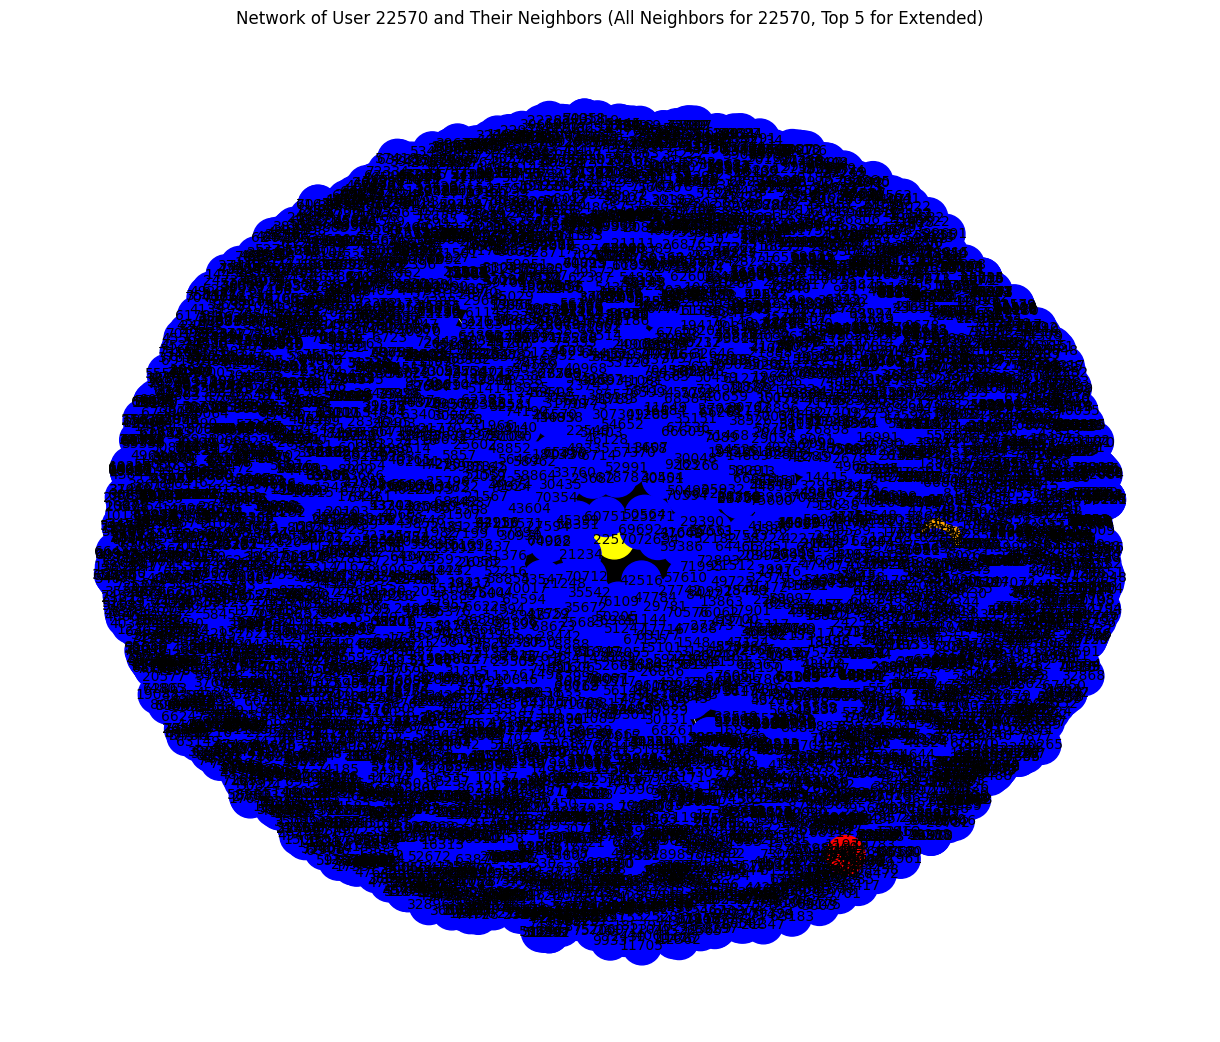

In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Ensure consistent data types between the user_id and the user_id column in df_final
user_id = 22570

# Convert df_final['user_id'] to the same type as user_id
df_final['user_id'] = df_final['user_id'].astype(type(user_id))

# Check if user 22570 exists in the dataset after ensuring the data types match
if user_id not in df_final['user_id'].unique():
    print(f"User {user_id} does not exist in the dataset.")
else:
    # Step 2: Print all the interactions of user 22570
    user_data = df_final[df_final['user_id'] == user_id]
    print(f"Interactions for user {user_id}:")
    print(user_data)

    # Step 3: Filter the dataset to include only user 22570 and their potential neighbors
    potential_neighbors = user_data['song_id'].unique()
    filtered_df = df_final[df_final['song_id'].isin(potential_neighbors)]

    # Print the first few rows of the filtered dataset to verify
    print("Filtered dataset for potential neighbors:")
    print(filtered_df.head())

    # Step 4: Ensure user 22570 is included in the filtered dataset
    if user_id not in filtered_df['user_id'].unique():
        print(f"User {user_id} is not in the filtered dataset, adding them back.")
        filtered_df = pd.concat([filtered_df, df_final[df_final['user_id'] == user_id]])

    # Step 5: Load the filtered dataset into Surprise format
    reader = Reader(rating_scale=(filtered_df['play_count'].min(), filtered_df['play_count'].max()))
    data = Dataset.load_from_df(filtered_df[['user_id', 'song_id', 'play_count']], reader)

    # Build the full trainset
    trainset = data.build_full_trainset()

    # Step 6: Define similarity options for the KNNBasic model
    sim_options = {
        'name': 'pearson_baseline',  # Use Pearson correlation similarity
        'user_based': True  # Set to True for user-based collaborative filtering
    }

    # Initialize KNNBasic with the provided options
    model = KNNBasic(k=30, min_k=3, sim_options=sim_options, random_state=1, verbose=True)

    # Step 7: Train the model on the filtered data
    model.fit(trainset)

    # Step 8: Retrieve **all** neighbors for user 22570
    if user_id in trainset._raw2inner_id_users:
        user_inner_id = trainset.to_inner_uid(user_id)
        # Get all neighbors of user 22570 (by sorting all users by similarity to user 22570)
        all_neighbors = np.argsort(model.sim[user_inner_id])[::-1][1:]  # Sort all neighbors by similarity

        # Convert inner IDs to raw user IDs
        all_neighbors_raw = [trainset.to_raw_uid(neighbor) for neighbor in all_neighbors]

        # Step 9: Retrieve top 5 neighbors of the top 5 closest neighbors (extended neighbors)
        extended_neighbors_raw = {}
        for neighbor_inner_id in all_neighbors[:5]:  # Limit to top 5 direct neighbors for the next level
            neighbor_raw_id = trainset.to_raw_uid(neighbor_inner_id)
            extended_neighbors_inner = model.get_neighbors(neighbor_inner_id, k=5)  # Top 5 neighbors of each neighbor
            extended_neighbors_raw[neighbor_raw_id] = [trainset.to_raw_uid(inner_id) for inner_id in extended_neighbors_inner]

        # Step 10: Create a graph and visualize
        G = nx.Graph()

        # Add user 22570 and all direct neighbors (in blue)
        G.add_node(user_id, color='blue')  # Main user node
        for neighbor in all_neighbors_raw:
            G.add_node(neighbor, color='blue')  # Direct neighbors
            G.add_edge(user_id, neighbor)

        # Add extended neighbors (in different colors)
        colors = ['red', 'green', 'purple', 'orange', 'yellow']  # Different colors for different neighbors' groups
        for i, (neighbor, n_neighbors) in enumerate(extended_neighbors_raw.items()):
            for n_neighbor in n_neighbors:
                G.add_node(n_neighbor, color=colors[i])  # Extended neighbors
                G.add_edge(neighbor, n_neighbor)

        # Set node colors based on the assigned colors
        node_colors = [G.nodes[node]['color'] for node in G]

        # Draw the graph
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G)  # Position the nodes using spring layout
        nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=800, font_size=10, edge_color='black')

        plt.title('Network of User 22570 and Their Neighbors (All Neighbors for 22570, Top 5 for Extended)')
        plt.show()

    else:
        print(f"User {user_id} is not part of the filtered training set.")


Interactions for user 22570:
    user_id song_id  play_count                                         title  \
0     22570    1286           6                              Somebody To Love   
1     22570    1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2     22570    2409           6                           My Dad's Gone Crazy   
3     22570    2430           4                                   Missing You   
4     22570    3781           2                                 Ya Nada Queda   
5     22570    4192           4                           The Real Slim Shady   
6     22570    4971           1                                    Forgive Me   
7     22570    8095           3                                   Say My Name   
8     22570    8268           5                                  Just Lose It   
9     22570    8610           1                                    16 Candles   
10    22570    8654           8                                    Without Me   

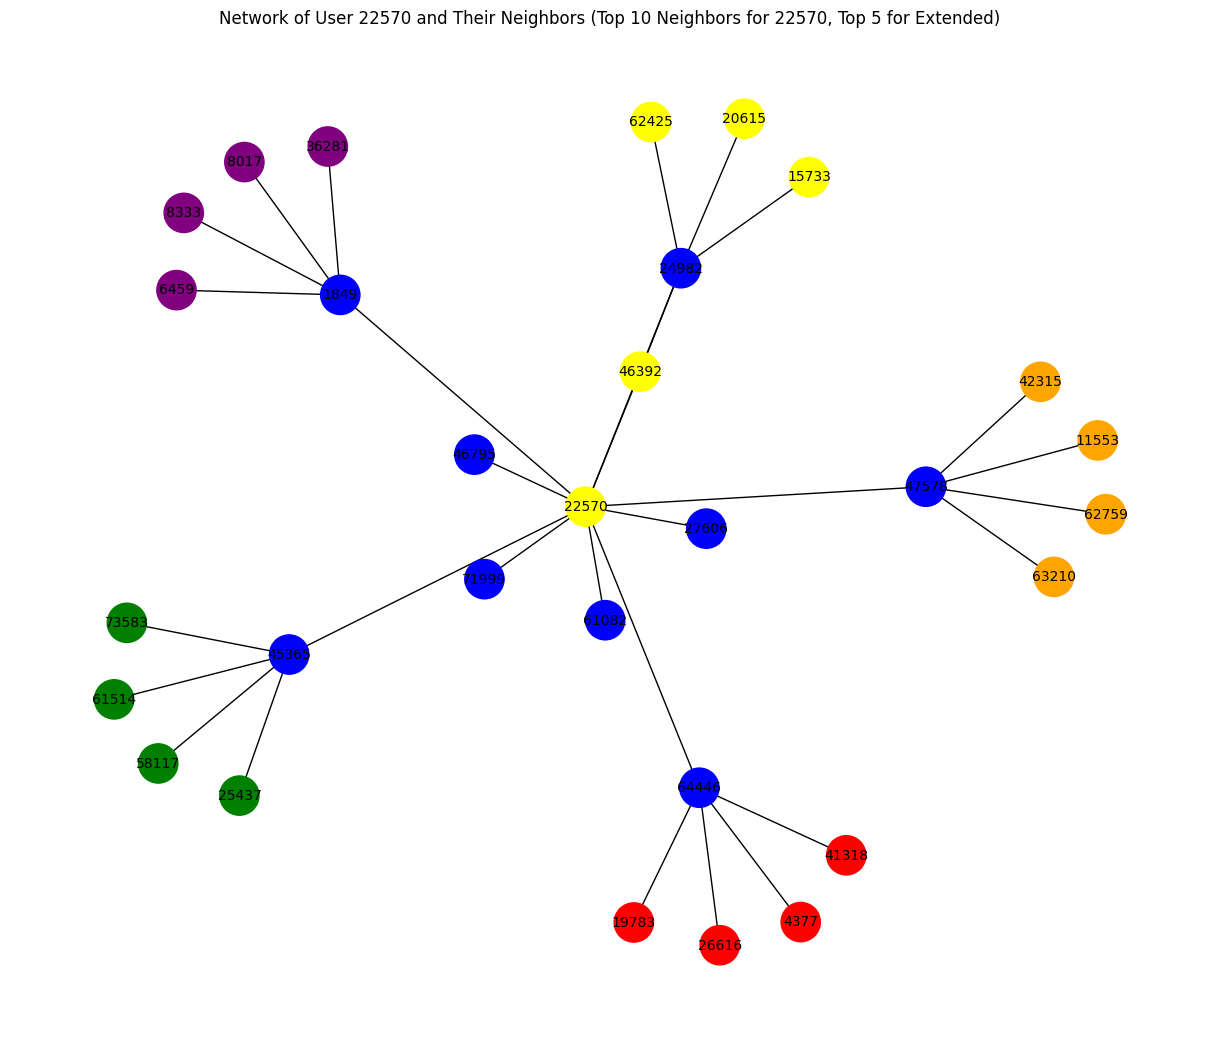

Graph saved as 'network_graph_user_22570.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Ensure consistent data types between the user_id and the user_id column in df_final
user_id = 22570

# Convert df_final['user_id'] to the same type as user_id
df_final['user_id'] = df_final['user_id'].astype(type(user_id))

# Check if user 22570 exists in the dataset after ensuring the data types match
if user_id not in df_final['user_id'].unique():
    print(f"User {user_id} does not exist in the dataset.")
else:
    # Step 2: Print all the interactions of user 22570
    user_data = df_final[df_final['user_id'] == user_id]
    print(f"Interactions for user {user_id}:")
    print(user_data)

    # Step 3: Filter the dataset to include only user 22570 and their potential neighbors
    potential_neighbors = user_data['song_id'].unique()
    filtered_df = df_final[df_final['song_id'].isin(potential_neighbors)]

    # Print the first few rows of the filtered dataset to verify
    print("Filtered dataset for potential neighbors:")
    print(filtered_df.head())

    # Step 4: Ensure user 22570 is included in the filtered dataset
    if user_id not in filtered_df['user_id'].unique():
        print(f"User {user_id} is not in the filtered dataset, adding them back.")
        filtered_df = pd.concat([filtered_df, df_final[df_final['user_id'] == user_id]])

    # Step 5: Load the filtered dataset into Surprise format
    reader = Reader(rating_scale=(filtered_df['play_count'].min(), filtered_df['play_count'].max()))
    data = Dataset.load_from_df(filtered_df[['user_id', 'song_id', 'play_count']], reader)

    # Build the full trainset
    trainset = data.build_full_trainset()

    # Step 6: Define similarity options for the KNNBasic model
    sim_options = {
        'name': 'pearson_baseline',  # Use Pearson correlation similarity
        'user_based': True  # Set to True for user-based collaborative filtering
    }

    # Initialize KNNBasic with the provided options
    model = KNNBasic(k=30, min_k=3, sim_options=sim_options, random_state=1, verbose=True)

    # Step 7: Train the model on the filtered data
    model.fit(trainset)

    # Step 8: Retrieve **top 10** neighbors for user 22570
    if user_id in trainset._raw2inner_id_users:
        user_inner_id = trainset.to_inner_uid(user_id)
        # Get top 10 neighbors of user 22570
        top_10_neighbors = np.argsort(model.sim[user_inner_id])[::-1][1:11]  # Top 10 neighbors by similarity

        # Convert inner IDs to raw user IDs
        top_10_neighbors_raw = [trainset.to_raw_uid(neighbor) for neighbor in top_10_neighbors]

        # Step 9: Retrieve top 5 neighbors of the top 5 closest neighbors (extended neighbors)
        extended_neighbors_raw = {}
        for neighbor_inner_id in top_10_neighbors[:5]:  # Limit to top 5 direct neighbors for the next level
            neighbor_raw_id = trainset.to_raw_uid(neighbor_inner_id)
            extended_neighbors_inner = model.get_neighbors(neighbor_inner_id, k=5)  # Top 5 neighbors of each neighbor
            extended_neighbors_raw[neighbor_raw_id] = [trainset.to_raw_uid(inner_id) for inner_id in extended_neighbors_inner]

        # Step 10: Create a graph and visualize
        G = nx.Graph()

        # Add user 22570 and top 10 neighbors (in blue)
        G.add_node(user_id, color='blue')  # Main user node
        for neighbor in top_10_neighbors_raw:
            G.add_node(neighbor, color='blue')  # Top 10 neighbors
            G.add_edge(user_id, neighbor)

        # Add extended neighbors (in different colors)
        colors = ['red', 'green', 'purple', 'orange', 'yellow']  # Different colors for different neighbors' groups
        for i, (neighbor, n_neighbors) in enumerate(extended_neighbors_raw.items()):
            for n_neighbor in n_neighbors:
                G.add_node(n_neighbor, color=colors[i])  # Extended neighbors
                G.add_edge(neighbor, n_neighbor)

        # Set node colors based on the assigned colors
        node_colors = [G.nodes[node]['color'] for node in G]

        # Step 11: Draw the graph
        try:
            plt.figure(figsize=(12, 10))
            pos = nx.spring_layout(G)  # Position the nodes using spring layout
            nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=800, font_size=10, edge_color='black')

            plt.title('Network of User 22570 and Their Neighbors (Top 10 Neighbors for 22570, Top 5 for Extended)')
            plt.show()  # Ensure the graph is shown
        except Exception as e:
            print(f"Error while displaying the graph: {e}")

        # Save the graph to a file as a fallback in case plt.show() fails
        plt.savefig("network_graph_user_22570.png")
        print("Graph saved as 'network_graph_user_22570.png'")

    else:
        print(f"User {user_id} is not part of the filtered training set.")


### old code

In [ ]:
#updated this based on new search reuslt if changed and update report - 10/13

import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import pickle
import numpy as np
from collections import defaultdict


# Step 1: Use the original play counts to load the data into the Surprise Dataset
reader = Reader(rating_scale=(df_final['play_count'].min(), df_final['play_count'].max()))  # Use actual play count range
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Step 2: Split the dataset into train and test sets (20% test size, random seed 1)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Step 3: Train a default KNNBasic model
# Define similarity options for the KNN algorithm (using Pearson correlation to avoid ZeroDivisionError)
sim_options = {'name': 'pearson_baseline', 'user_based': True}

# Initialize the KNNBasic algorithm with the defined similarity options
sim_user_user_optimized = KNNBasic(k=30, min_k=3, sim_options=sim_options,random_state = 1, verbose = False)

# Train the model on the trainset (original play counts)
sim_user_user_optimized.fit(trainset)

# Make predictions on the test set (original play counts)
predictions = sim_user_user_optimized.test(testset)

# Calculate RMSE and MAE for the original play counts
print("Model Performance on Original Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Function to calculate and return RMSE, MAE, precision, recall, MAP, diversity, and novelty
def calculate_metrics(model, testset):
    # Use precision_recall_at_k function to calculate and print metrics
    rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k(model, testset)

    # Print calculated metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Precision@30: {precision}")
    print(f"Recall@30: {recall}")

    # Safely calculate F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"F_1 score: {round(f1_score, 3)}")
    else:
        print(f"F_1 score: N/A (Precision + Recall = 0)")

    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"Novelty: {novelty}")

    return rmse, mae, precision, recall, map_score, diversity, novelty

# Step 4: Call the function to calculate the metrics
calculate_metrics(sim_user_user_optimized, testset)

# calculate NDCG@30
# Function to calculate DCG
def dcg_at_k(r, k=30):
    """Calculates DCG at k"""
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum((2**r - 1) / np.log2(np.arange(1, r.size + 1) + 1))
    return 0.

# Function to calculate NDCG
def ndcg_at_k(predictions, k=30):
    """Calculates NDCG at k for all users"""
    # First, group predictions by user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    ndcg_list = []

    # For each user, calculate the NDCG
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by the predicted estimate in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get the relevance scores for the top-k items (actual ratings)
        rel_scores = [true_r for (_, true_r) in user_ratings]

        # Calculate DCG for top-k recommendations
        dcg = dcg_at_k(rel_scores, k=k)

        # Sort the actual ratings to compute IDCG (Ideal DCG)
        ideal_ratings = sorted(rel_scores, reverse=True)
        idcg = dcg_at_k(ideal_ratings, k=k)

        # Avoid division by zero
        if idcg > 0:
            ndcg_list.append(dcg / idcg)
        else:
            ndcg_list.append(0)

    # Return the mean NDCG@k
    return np.mean(ndcg_list)

# Call this function after generating predictions with the sim_user_user_optimized model
# Example: predictions = sim_user_user_optimized.test(testset)
ndcg_30 = ndcg_at_k(predictions, k=30)
print(f"NDCG@30: {ndcg_30}")

# Step 5: Save the trained model using pickle
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(sim_user_user_optimized, model_file)


Model Performance on Original Play Counts
RMSE: 8.5793
MAE:  3.3599
Precision@30: 0.608
Recall@30: 0.817
F_1 score:  0.697
MAP (Mean Average Precision): 0.7
Diversity: 0.009
RMSE: 8.579256547769823
MAE: 3.359940902886485
Novelty: 0.194
RMSE: 8.579256547769823
MAE: 3.359940902886485
Precision@30: 0.608
Recall@30: 0.817
F_1 score: 0.697
MAP (Mean Average Precision): 0.7
Diversity: 0.009
Novelty: 0.194
NDCG@30: 0.7042338356490326


In [ ]:
# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user_optimized.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))


   song_id                              title     artist_name  play_count  \
0     1791     Eternal Flame (Single Version)   Atomic Kitten          89   
2     4245                           What If?        Godsmack         110   
3     6374                No Balanço Da Canoa   Alceu Valença         119   
4     8153  South Side (Digitally Remastered)     Louis Smith         122   
1     4237          I?'m A Steady Rollin? Man  Robert Johnson         140   

   predicted_play_count  
0             63.478307  
2             44.364667  
3             39.478800  
4             37.245481  
1             26.612796  


write back prediction to

In [ ]:
# Run prediction for all rows - re run this 10/14

import pandas as pd
from tqdm import tqdm  # Progress bar for long operations

# Generate predictions for all user-item pairs in the dataset
all_user_item_pairs = [(row['user_id'], row['song_id'], row['play_count']) for idx, row in df_final.iterrows()]

# Initialize a progress bar
tqdm.pandas()

# Predict play counts for all user-item pairs in batches
predictions_for_all = sim_user_user_optimized.test(all_user_item_pairs)

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions_for_all],
                              columns=['user_id', 'song_id', 'KNNBasic_Op_predicted_play_count'])

# Merge the predictions back into the original df_final
df_final = pd.merge(df_final, predictions_df, on=['user_id', 'song_id'], how='left')

# Optionally, display the first few rows to check the result
print(df_final.head())


Recommendation system:

In [ ]:
# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user_optimized.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']].drop_duplicates()

# Step 6: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 7: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))


### old code

In [ ]:
# # Load the dataset and use MAE optimized combination of parameters to build a optimized user based KNNBasic model to predict play_count.

import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler

# Define similarity options for the KNN algorithm (using Pearson correlation to avoid ZeroDivisionError)
sim_options = {'name': 'pearson', 'user_based': True}

# Initialize the KNNBasic, algorithm with the defined similarity options
sim_user_user_optimized = KNNBasic(k=10, min_k=3, sim_options=sim_options,random_state = 1, verbose = False)

# Train the model on the trainset (scaled play counts)
sim_user_user_optimized.fit(trainset)

# Make predictions on the test set (scaled play counts)
predictions = sim_user_user_optimized.test(testset)

# Calculate RMSE and MAE for scaled play counts
print("Model Performance on Scaled Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Use precision_recall_at_k function to calculate and print metrics
rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k(sim_user_user, testset)

# Print calculated metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision@30: {precision}")
print(f"Recall@30: {recall}")
print(f"F_1 score: {2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 'N/A'}")
print(f"MAP (Mean Average Precision): {map_score}")
print(f"Diversity: {diversity}")
print(f"Novelty: {novelty}")

# Optional: Reverse the scaling if you need to interpret the predictions back to original play counts
scaled_predictions = [pred.est for pred in predictions]
original_play_counts = scaler.inverse_transform([[pred] for pred in scaled_predictions])

# Optionally, print the original play counts
print("Predicted Original Play Counts:", original_play_counts)


Model Performance on Scaled Play Counts
RMSE: 8.8009
MAE:  3.9045
Precision@30: 0.643
Recall@30: 0.943
F_1 score:  0.765
MAP (Mean Average Precision): 0.748
Diversity: 0.009
RMSE: 8.854756566699427
MAE: 3.4872544646817594
Novelty: 0.191
RMSE: 8.854756566699427
MAE: 3.4872544646817594
Precision@30: 0.643
Recall@30: 0.943
F_1 score: 0.764626733921816
MAP (Mean Average Precision): 0.748
Diversity: 0.009
Novelty: 0.191
Predicted Original Play Counts: [[ 882.84086243]
 [2122.26200025]
 [1862.04930426]
 ...
 [1072.85988132]
 [1984.71588068]
 [ 620.36      ]]


**Observations and Insights:_________**

User 73829 has played song 2220 at least 5 times with an actual play count of 7.
User 34241 has NOT played song 2220.


In [ ]:
# Predict the play count for a user who has listened to the song.
sim_user_user.predict('73829', '2220', r_ui=7, verbose=True)

user: 73829      item: 2220       r_ui = 7.00   est = 4.21   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='73829', iid='2220', r_ui=7, est=4.206711808914354, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Predict the play count for a song that is not listened to by the user
sim_user_user.predict('34241', '2220', verbose=True)

user: 34241      item: 2220       r_ui = None   est = 4.21   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='34241', iid='2220', r_ui=None, est=4.206711808914354, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations and Insights:______________**

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?

In [ ]:
# prompt:  get 5 nearest neighbors (most similar) to song '2220'

# Get the inner id of the song '2220'
song_inner_id = sim_user_user_optimized.trainset.to_inner_iid('2220')

# Get the similarity row for the song
similarity_row = sim_user_user_optimized.sim[song_inner_id]

# Get the indices of the top 5 most similar songs (excluding itself)
most_similar_song_indices = np.argsort(similarity_row)[::-1][1:6]

# Get the inner ids of the top 5 most similar songs
most_similar_song_inner_ids = [sim_user_user_optimized.trainset.to_raw_iid(inner_id) for inner_id in most_similar_song_indices]


# Print the top 5 most similar songs
print(f"The top 5 most similar songs to song '2220' are: {most_similar_song_inner_ids}")


ValueError: Item 2220 is not part of the trainset.

In [ ]:
# Use inner id 0


Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended song ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'song_id', values = 'play_count')

    # Extracting those song ids which the user_id has not played yet
    non_interacted_songs = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the song ids which user_id has not interacted yet
    for item_id in non_interacted_songs:

        # Predicting the play_counts for those non played song ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted play_counts
        recommendations.append((item_id, est))

    # Sorting the predicted play_counts in descending order
    recommendations.sort(key = lambda x : x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted play_count songs for this user

In [ ]:
# Make top 5 recommendations for user_id 6958 with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "34242", 5, sim_user_user_optimized)

KeyError: '34242'

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_play_count'])

**Observations and Insights:______________**

### Correcting the play_counts and Ranking the above songs

This function essentially ranks songs based on both their predicted play counts and the actual play frequency data. The correction factor penalizes songs that are already popular, promoting songs that are less frequently played in the ranking.

In [ ]:
def ranking_songs(recommendations, playing_count):
    # Sort the songs based on play counts
    ranked_songs = playing_count.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending=False)[['play_freq']].reset_index()

    # Merge with the recommended songs to get predicted play_counts
    ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

    # Rank the songs based on corrected play_counts
    ranked_songs['corrected_play_count'] = ranked_songs['predicted_play_count'] - 1 / np.sqrt(ranked_songs['play_freq'])

    # Sort the songs based on corrected play_counts
    ranked_songs = ranked_songs.sort_values('corrected_play_count', ascending=False)

    return ranked_songs


**Think About It:** In the above function to correct the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
# Applying the ranking_songs function on the final_play data


**Observations and Insights:______________**

## Item Item Similarity-based collaborative filtering recommendation systems

### Build a default item based KNNBasic

In [ ]:
# updated using log transformation, accuracy function

import numpy as np
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split
import pickle
from collections import defaultdict

# Step 1: Apply log transformation to the play counts
df_final['log_play_count'] = np.log1p(df_final['play_count'])  # log(1 + play_count) to handle zeros

# Step 2: Use the log-transformed play counts to load the data into the Surprise Dataset
reader = Reader(rating_scale=(df_final['log_play_count'].min(), df_final['log_play_count'].max()))
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'log_play_count']], reader)

# Step 3: Split the dataset into train and test sets (20% test size, random seed 1)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Step 4: Train a default KNNBasic model using all CPU cores
sim_options = {'name': 'pearson_baseline', 'user_based': False}

# Initialize the KNNBasic algorithm with the defined similarity options
sim_user_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False, n_jobs=-1)

# Step 5: Train the model on the trainset (log-transformed play counts)
sim_user_item.fit(trainset)

# Step 6: Make predictions on the test set (log-transformed play counts)
predictions = sim_user_item.test(testset)

# Step 7: Evaluate the model performance on log-transformed play counts
print("Model Performance on Log-Transformed Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Step 8: Call the precision_recall_at_k function to calculate and print the metrics
precision, recall, map_score, diversity, novelty, ndcg = precision_recall_at_k(
    model=sim_user_item,
    testset=testset,
    k=30,
    threshold=0.5,  # Adjust the threshold if necessary based on log-transformed play counts
    confidence_threshold=2.5  # Adjust confidence threshold
)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision@30: {precision}")
print(f"Recall@30: {recall}")
print(f"MAP: {map_score}")
print(f"Diversity: {diversity}")
print(f"Novelty: {novelty}")
print(f"NDCG@30: {ndcg}")

# Step 9: Predict play count for User 22570 and Song 1286
pred_22570_1286 = sim_user_item.predict(22570, 1286)
print(f"Predicted play count (log scale) for User 22570 on Song 1286: {pred_22570_1286.est}")

# Step 10: Predict play count for User 63855 and Song 1286
pred_63855_1286 = sim_user_item.predict(63855, 1286)
print(f"Predicted play count (log scale) for User 63855 on Song 1286: {pred_63855_1286.est}")

# Step 11: Reverse the log transformation to get the original play counts
predicted_play_count_22570_1286 = np.expm1(pred_22570_1286.est)  # Reverse log(1 + x) transformation
predicted_play_count_63855_1286 = np.expm1(pred_63855_1286.est)

# Step 12: Print the original scale predictions
print(f"Predicted play count for User 22570 on Song 1286 (original scale): {predicted_play_count_22570_1286}")
print(f"Predicted play count for User 63855 on Song 1286 (original scale): {predicted_play_count_63855_1286}")

# Optional: Save the trained model using pickle
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(sim_user_item, model_file)


Model Performance on Log-Transformed Play Counts
RMSE: 0.6586
MAE:  0.4647
Precision@30: 0.153
Recall@30: 0.153
F_1 score:  0.153
MAP (Mean Average Precision): 0.153
Diversity: 0.001
NDCG: 0.153
Novelty: 0.326
RMSE: 0.6487730166183076
MAE: 0.4919757595554824
Precision@30: 0.153
Recall@30: 0.153
MAP: 0.153
Diversity: 0.001
Novelty: 0.326
NDCG@30: 0.153
Predicted play count (log scale) for User 22570 on Song 1286: 1.263109284561823
Predicted play count (log scale) for User 63855 on Song 1286: 1.263109284561823
Predicted play count for User 22570 on Song 1286 (original scale): 2.536400084917137
Predicted play count for User 63855 on Song 1286 (original scale): 2.536400084917137


In [ ]:
#recommendation for user 22570:

# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_item.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))

   song_id                                     title    artist_name  \
0     5395                             Lonely Lonely          Feist   
1     5933                             Twisted Logic       Coldplay   
2     6661                              Kiss Of Life           Sade   
3     7817                                Nitpickin'   Danny Gatton   
4     8389  Road To Nowhere (Remastered LP Version )  Talking Heads   

   play_count  predicted_play_count  
0          16              2.944439  
1          16              2.944439  
2          48              2.944439  
3          28              2.944439  
4          21              2.944439  


### old code - no log transformation

In [ ]:
# updated 10/14

# Step 1: Use the original play counts to load the data into the Surprise Dataset
reader = Reader(rating_scale=(df_final['play_count'].min(), df_final['play_count'].max()))  # Use actual play count range
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Step 2: Split the dataset into train and test sets (20% test size, random seed 1)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Step 3: Train a default KNNBasic model
# Define similarity options for the KNN algorithm (using Pearson correlation to avoid ZeroDivisionError)
sim_options = {'name': 'pearson_baseline', 'user_based': False}

# Initialize the KNNBasic algorithm with the defined similarity options
sim_user_item = KNNBasic(sim_options=sim_options,random_state = 1, verbose = False)

# Train the model on the trainset (original play counts)
sim_user_item.fit(trainset)

# Make predictions on the test set (original play counts)
predictions = sim_user_item.test(testset)

# Calculate RMSE and MAE for the original play counts
print("Model Performance on Original Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Function to calculate and return RMSE, MAE, precision, recall, MAP, diversity, and novelty
def calculate_metrics(model, testset):
    # Use precision_recall_at_k function to calculate and print metrics
    precision, recall, map_score, diversity, novelty = precision_recall_at_k(model, testset)

    # Print calculated metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Precision@30: {precision}")
    print(f"Recall@30: {recall}")

    # Safely calculate F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"F_1 score: {round(f1_score, 3)}")
    else:
        print(f"F_1 score: N/A (Precision + Recall = 0)")

    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"Novelty: {novelty}")

    return rmse, mae, precision, recall, map_score, diversity, novelty

# Step 4: Call the function to calculate the metrics
calculate_metrics(sim_user_item, testset)



# Step 5: Save the trained model using pickle
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(sim_user_item, model_file)


Model Performance on Original Play Counts
RMSE: 8.8181
MAE:  3.3292
Precision@30: 0.573
Recall@30: 0.735
F_1 score:  0.644
MAP (Mean Average Precision): 0.641
Diversity: 0.012
RMSE: 8.81811311834895
MAE: 3.329168413981989
Novelty: 0.171
RMSE: 8.81811311834895
MAE: 3.329168413981989
Precision@30: 0.573
Recall@30: 0.735
F_1 score: 0.644
MAP (Mean Average Precision): 0.641
Diversity: 0.012
Novelty: 0.171
NDCG@30: 0.6929860626968882


In [ ]:
# Predict the play count for User 22570 on Song 1283
pred_22570_1283 = sim_user_item.predict(22570, 1283)
print(f"Predicted play count for User 22570 on Song 1283: {pred_22570_1283.est}")

# Predict the play count for User 63855 on Song 1283
pred_63855_1283 = sim_user_item.predict(63855, 1283)
print(f"Predicted play count for User 63855 on Song 1283: {pred_63855_1283.est}")


Predicted play count for User 22570 on Song 1283: 13.0
Predicted play count for User 63855 on Song 1283: 6.897351925766726


In [ ]:
# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user_optimized.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))


   song_id                              title     artist_name  play_count  \
0     1791     Eternal Flame (Single Version)   Atomic Kitten          89   
2     4245                           What If?        Godsmack         110   
3     6374                No Balanço Da Canoa   Alceu Valença         119   
4     8153  South Side (Digitally Remastered)     Louis Smith         122   
1     4237          I?'m A Steady Rollin? Man  Robert Johnson         140   

   predicted_play_count  
0             63.478307  
2             44.364667  
3             39.478800  
4             37.245481  
1             26.612796  


### grid search under item-itemr, searched on both user and item

In [ ]:
import random
from surprise import Dataset, KNNBasic, Reader
from surprise.model_selection import GridSearchCV, train_test_split

# Define the Reader with the rating scale (play count)
reader = Reader(rating_scale=(0, df_final['play_count'].max()))

# Load the dataset from the dataframe
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Access raw ratings from the dataset
raw_ratings = data.raw_ratings

# Shuffle and sample a smaller subset (e.g., X% of the original data)
random.seed(1)  # For reproducibility
subset_size = int(1 * len(raw_ratings))  # Adjust the fraction as needed
raw_ratings_subset = random.sample(raw_ratings, subset_size)

# Overwrite the data with the smaller subset of raw ratings
data.raw_ratings = raw_ratings_subset

# Split the reduced dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Define the parameter grid for tuning
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['pearson', 'pearson_baseline'],
                              'user_based': [False]},
             }

# Perform 3-fold cross-validation to tune hyperparameters using all available CPU cores
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)  # Set n_jobs to -1 for parallel processing

# Fit the GridSearchCV on the reduced dataset
gs.fit(data)

# Retrieve the best RMSE score and the corresponding parameters
# print("Best RMSE: ", gs.best_score['rmse'])
# print("Best parameters for RMSE: ", gs.best_params['rmse'])

# Retrieve the best MAE score and the corresponding parameters
print("Best MAE: ", gs.best_score['mae'])
print("Best parameters for MAE: ", gs.best_params['mae'])


Best MAE:  3.3266186629532903
Best parameters for MAE:  {'k': 30, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

### Build the optimized item based model

In [ ]:
# using log transformation

import numpy as np
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split

# Step 1: Apply log transformation to the play counts
df_final['log_play_count'] = np.log1p(df_final['play_count'])  # log(1 + play_count) to handle zeros

# Step 2: Define the reader and load the data with the log-transformed play counts
reader = Reader(rating_scale=(df_final['log_play_count'].min(), df_final['log_play_count'].max()))
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'log_play_count']], reader)

# Step 3: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Define similarity options for item-based collaborative filtering
sim_options = {
    'name': 'pearson_baseline',  # Use Pearson correlation similarity
    'user_based': False  # Set to False for item-based collaborative filtering
}

# Step 5: Initialize the KNNBasic model for item-based filtering
sim_user_item_optimized2 = KNNBasic(k=30, min_k=3, sim_options=sim_options, random_state=1, verbose=False)

# Step 6: Train the model on the log-transformed play counts
sim_user_item_optimized2.fit(trainset)

# Step 7: Make predictions on the test set
predictions = sim_user_item_optimized2.test(testset)

# Step 8: Evaluate the predictions with RMSE and MAE
print("Model Performance on Log-Transformed Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Call the already defined precision_recall_at_k function to calculate the metrics
precision, recall, map_score, diversity, novelty, ndcg = precision_recall_at_k(
    model=sim_user_item_optimized2,  # Pass the renamed model here
    testset=testset,
    k=30,
    threshold=0.5,
    confidence_threshold=2.5
)

# Save the results for future reference
results = {
    "precision": precision,
    "recall": recall,
    "map_score": map_score,
    "diversity": diversity,
    "novelty": novelty,
    "ndcg": ndcg
}

# Step 9: Predict play count for User 22570 and Song 1286
pred_22570_1286 = sim_user_item_optimized2.predict(22570, 1286)
print(f"Predicted play count (log) for User 22570 on Song 1286: {pred_22570_1286.est}")
print(f"Actual play count (log): {pred_22570_1286.r_ui if pred_22570_1286.r_ui else 'Not available in test set'}")

# Step 10: Predict play count for User 63855 and Song 1286
pred_63855_1286 = sim_user_item_optimized2.predict(63855, 1286)
print(f"Predicted play count (log) for User 63855 on Song 1286: {pred_63855_1286.est}")
print(f"Actual play count (log): {pred_63855_1286.r_ui if pred_63855_1286.r_ui else 'Not available in test set'}")

# Step 11: Optional - convert log-transformed predicted play count back to original scale
predicted_play_count_22570_1286 = np.expm1(pred_22570_1286.est)  # Reverse log(1 + x) transformation
predicted_play_count_63855_1286 = np.expm1(pred_63855_1286.est)

print(f"Predicted play count for User 22570 on Song 1286 (original scale): {predicted_play_count_22570_1286}")
print(f"Predicted play count for User 63855 on Song 1286 (original scale): {predicted_play_count_63855_1286}")

Model Performance on Log-Transformed Play Counts
RMSE: 0.6482
MAE:  0.4632
Precision@30: 0.116
Recall@30: 0.116
F_1 score:  0.116
MAP (Mean Average Precision): 0.116
Diversity: 0.001
NDCG: 0.116
Novelty: 0.333
Predicted play count (log) for User 22570 on Song 1286: 1.2634570612757536
Actual play count (log): Not available in test set
Predicted play count (log) for User 63855 on Song 1286: 1.2634570612757536
Actual play count (log): Not available in test set
Predicted play count for User 22570 on Song 1286 (original scale): 2.5376301764040026
Predicted play count for User 63855 on Song 1286 (original scale): 2.5376301764040026


In [ ]:
#recommendation for user 22570:

# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_item_optimized2.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))

   song_id                            title       artist_name  play_count  \
0     1066  Paradise By The Dashboard Light         Meat Loaf          13   
2     5357                          Breathe           Prodigy          25   
4     8462                           Freeze              K-OS          21   
3     6714         Yellin' At The Xmas Tree        Billy Idol          47   
1     3080                     Safety Dance  Men Without Hats          19   

   predicted_play_count  
0              2.916260  
2              2.890725  
4              2.862528  
3              2.844337  
1              2.822739  


### old code- no log

In [ ]:
# working but not using log transformation

import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import pickle
import numpy as np
from collections import defaultdict


# Step 1: Use the original play counts to load the data into the Surprise Dataset
reader = Reader(rating_scale=(df_final['play_count'].min(), df_final['play_count'].max()))  # Use actual play count range
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Step 2: Split the dataset into train and test sets (20% test size, random seed 1)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Step 3: Train a default KNNBasic model
# Define similarity options for the KNN algorithm (using Pearson correlation to avoid ZeroDivisionError)
sim_options = {'name': 'pearson_baseline', 'user_based': True}

# Initialize the KNNBasic algorithm with the defined similarity options
sim_user_item_optimized = KNNBasic(k=30, min_k=3, sim_options=sim_options,random_state = 1, verbose = True)

# Train the model on the trainset (original play counts)
sim_user_item_optimized.fit(trainset)

# Make predictions on the test set (original play counts)
predictions = sim_user_item_optimized.test(testset)

# Calculate RMSE and MAE for the original play counts
print("Model Performance on Original Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Function to calculate and return RMSE, MAE, precision, recall, MAP, diversity, and novelty
def calculate_metrics(model, testset):
    # Use precision_recall_at_k function to calculate and print metrics
    rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k(model, testset)

    # Print calculated metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Precision@30: {precision}")
    print(f"Recall@30: {recall}")

    # Safely calculate F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"F_1 score: {round(f1_score, 3)}")
    else:
        print(f"F_1 score: N/A (Precision + Recall = 0)")

    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"Novelty: {novelty}")

    return rmse, mae, precision, recall, map_score, diversity, novelty

# Step 4: Call the function to calculate the metrics
calculate_metrics(sim_user_item_optimized, testset)

# calculate NDCG@30
# Function to calculate DCG
def dcg_at_k(r, k=30):
    """Calculates DCG at k"""
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum((2**r - 1) / np.log2(np.arange(1, r.size + 1) + 1))
    return 0.

# Function to calculate NDCG
def ndcg_at_k(predictions, k=30):
    """Calculates NDCG at k for all users"""
    # First, group predictions by user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    ndcg_list = []

    # For each user, calculate the NDCG
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by the predicted estimate in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get the relevance scores for the top-k items (actual ratings)
        rel_scores = [true_r for (_, true_r) in user_ratings]

        # Calculate DCG for top-k recommendations
        dcg = dcg_at_k(rel_scores, k=k)

        # Sort the actual ratings to compute IDCG (Ideal DCG)
        ideal_ratings = sorted(rel_scores, reverse=True)
        idcg = dcg_at_k(ideal_ratings, k=k)

        # Avoid division by zero
        if idcg > 0:
            ndcg_list.append(dcg / idcg)
        else:
            ndcg_list.append(0)

    # Return the mean NDCG@k
    return np.mean(ndcg_list)

# Call this function after generating predictions with the sim_user_item_optimized model
# Example: predictions = sim_user_item_optimized.test(testset)
ndcg_30 = ndcg_at_k(predictions, k=30)
print(f"NDCG@30: {ndcg_30}")

# Step 5: Save the trained model using pickle
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(sim_user_item_optimized, model_file)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Model Performance on Original Play Counts
RMSE: 8.5793
MAE:  3.3599
Precision@30: 0.608
Recall@30: 0.817
F_1 score:  0.697
MAP (Mean Average Precision): 0.7
Diversity: 0.009
RMSE: 8.579256547769823
MAE: 3.359940902886485
Novelty: 0.194
RMSE: 8.579256547769823
MAE: 3.359940902886485
Precision@30: 0.608
Recall@30: 0.817
F_1 score: 0.697
MAP (Mean Average Precision): 0.7
Diversity: 0.009
Novelty: 0.194
NDCG@30: 0.7042338356490326


get the predicted play count for two specific user-song pairs: User 22570 for Song 1283 and User 63855 for Song 1283 using the sim_user_user_optimized model

In [ ]:
# Predict the play count for User 22570 on Song 1283
pred_22570_1283 = sim_user_user_optimized.predict(22570, 1283)
print(f"Predicted play count for User 22570 on Song 1283: {pred_22570_1283.est}")

# Predict the play count for User 63855 on Song 1283
pred_63855_1283 = sim_user_user_optimized.predict(63855, 1283)
print(f"Predicted play count for User 63855 on Song 1283: {pred_63855_1283.est}")


Predicted play count for User 22570 on Song 1283: 4.199476736151712
Predicted play count for User 63855 on Song 1283: 4.718939086999255


recommend songs to user 22570

In [ ]:
# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = sim_user_user_optimized.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))


   song_id                              title     artist_name  play_count  \
0     1791     Eternal Flame (Single Version)   Atomic Kitten          89   
2     4245                           What If?        Godsmack         110   
3     6374                No Balanço Da Canoa   Alceu Valença         119   
4     8153  South Side (Digitally Remastered)     Louis Smith         122   
1     4237          I?'m A Steady Rollin? Man  Robert Johnson         140   

   predicted_play_count  
0             63.478307  
2             44.364667  
3             39.478800  
4             37.245481  
1             26.612796  


### find similar items to song 1286

In [ ]:
# find similar items to song 1286 and print their titles, play count

# Step 1: Get the inner ID of song 1286 from the training set
song_1286_inner_id = sim_user_item_optimized2.trainset.to_inner_iid(1286)

# Step 2: Get the similarity scores of song 1286 with other songs
similarity_scores = sim_user_item_optimized2.sim[song_1286_inner_id]

# Step 3: Get the inner IDs of the most similar songs (excluding song 1286 itself)
similar_song_inner_ids = np.argsort(similarity_scores)[::-1][1:6]  # Get top 5 similar songs

# Step 4: Convert the inner IDs back to raw IDs
similar_song_raw_ids = [sim_user_item_optimized2.trainset.to_raw_iid(inner_id) for inner_id in similar_song_inner_ids]

# Step 5: Get details (title, play count) for the similar songs
similar_songs = df_final[df_final['song_id'].isin(similar_song_raw_ids)][['song_id', 'title', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
similar_songs = similar_songs.loc[similar_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Print the details of the similar songs
print(similar_songs[['song_id', 'title', 'play_count']])



        song_id                              title  play_count
369600     4536                          He Hit Me          19
392062     5506  Milonga Del Marinero Y El Capitan          12
643972     6972                            Gave Up          35
20168      7430                         Petit Bois          71
354765     8179                        Cherry Bomb          56


### visuals on neighbors

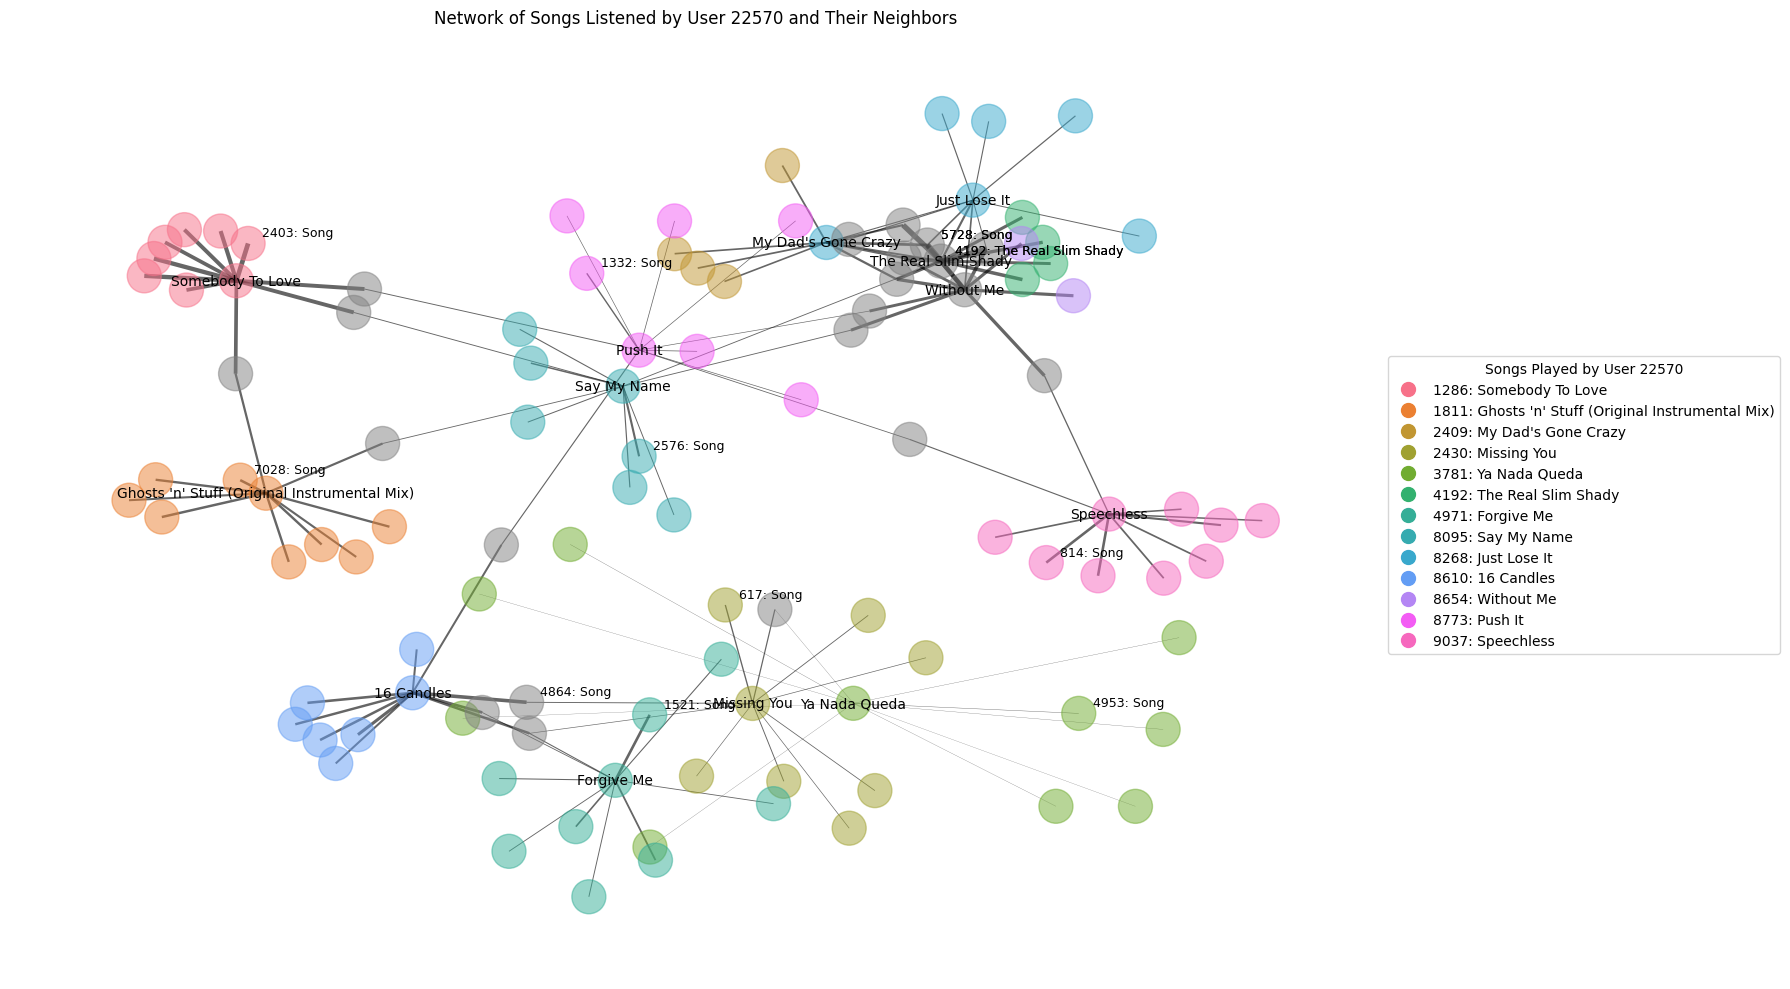

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the model on the trainset (log-transformed or original play counts)
sim_user_item_optimized2.fit(trainset)

# Step 2: Get the similarity matrix (computed during training)
similarity_matrix = sim_user_item_optimized2.sim

# Step 3: Retrieve the list of songs that user 22570 played, along with titles
user_22570_songs_df = df_final[df_final['user_id'] == 22570][['song_id', 'title']].drop_duplicates()
user_22570_songs = user_22570_songs_df['song_id'].unique()

# Step 4: Create a NetworkX graph
G = nx.Graph()

# Generate a unique color for each song user 22570 played
colors = sns.color_palette("husl", len(user_22570_songs))

# Dictionary to map song_id to title for displaying in the legend
song_titles = {row['song_id']: row['title'] for _, row in user_22570_songs_df.iterrows()}

# Dictionary to keep track of how many times each neighbor appears
neighbor_count = {}
closest_neighbors = {}  # To store the closest neighbor for each main song

# Step 5: Add each song that user 22570 played as a main node and find its neighbors
for i, song_id in enumerate(user_22570_songs):
    song_inner_id = sim_user_item_optimized2.trainset.to_inner_iid(song_id)  # Convert to internal ID

    # Add the main song node to the graph
    G.add_node(song_id, label=f'Song {song_id}', color=colors[i])

    # Find neighbors (similar songs) for the current song
    neighbors = sim_user_item_optimized2.get_neighbors(song_inner_id, k=10)  # Find top 10 neighbors

    max_score = -1  # To track the closest neighbor based on similarity score

    # Add neighbors with the same color as the main song node
    for neighbor in neighbors:
        neighbor_raw_id = sim_user_item_optimized2.trainset.to_raw_iid(neighbor)  # Convert internal ID to raw song ID
        score = similarity_matrix[song_inner_id, neighbor]  # Get similarity score

        # Track how many times each neighbor appears
        if neighbor_raw_id in neighbor_count:
            neighbor_count[neighbor_raw_id] += 1
        else:
            neighbor_count[neighbor_raw_id] = 1

        # Check if this neighbor is the closest (highest similarity score)
        if score > max_score:
            max_score = score
            closest_neighbors[song_id] = neighbor_raw_id

        # Add the neighbor node with the same color as the main song
        G.add_node(neighbor_raw_id, label=f'Song {neighbor_raw_id}', color=colors[i])

        # Add an edge between the main song and its neighbor with similarity score
        G.add_edge(song_id, neighbor_raw_id, weight=score)

# Step 6: Update the color of common nodes (neighbors appearing more than once) to gray
for node in neighbor_count:
    if neighbor_count[node] > 1:
        G.nodes[node]['color'] = 'gray'  # Set the color of common nodes to gray

# Step 7: Create a layout for the network graph
pos = nx.spring_layout(G, seed=42)  # Spring layout for visualization

# Step 8: Adjust plot size (network graph size)
plt.figure(figsize=(18, 10))  # Adjust width and height for the plot size

# Step 9: Draw the nodes with adjusted sizes and colors
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600, alpha=0.5)  # Adjust node_size here

# Draw the edges with widths proportional to the similarity scores
edges = G.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, width=[weight * 10 for weight in edge_weights], alpha=0.6)

# Step 10: Draw labels for the main nodes (songs user 22570 listened to)
nx.draw_networkx_labels(G, pos, {song_id: song_titles.get(song_id, f'Song {song_id}') for song_id in user_22570_songs}, font_size=10)

# Step 11: Annotate the closest neighbor for each main node
for song_id, closest_neighbor_id in closest_neighbors.items():
    # Get the position of the closest neighbor
    x, y = pos[closest_neighbor_id]

    # Annotate with the song ID or title, use a small offset to avoid overlapping
    plt.annotate(f'{closest_neighbor_id}: {song_titles.get(closest_neighbor_id, "Song")}',
                 xy=(x, y), xytext=(10, 5), textcoords='offset points', fontsize=9, color='black')

# Step 12: Prepare the legend outside the plot
legend_handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='') for color in colors]
legend_labels = [f"{song_id}: {song_titles.get(song_id, 'Song')}" for song_id in user_22570_songs]
plt.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Songs Played by User 22570")

# Step 13: Show the plot
plt.title('Network of Songs Listened by User 22570 and Their Neighbors', fontsize=12)
plt.tight_layout()
plt.axis('off')  # Turn off axis
plt.show()


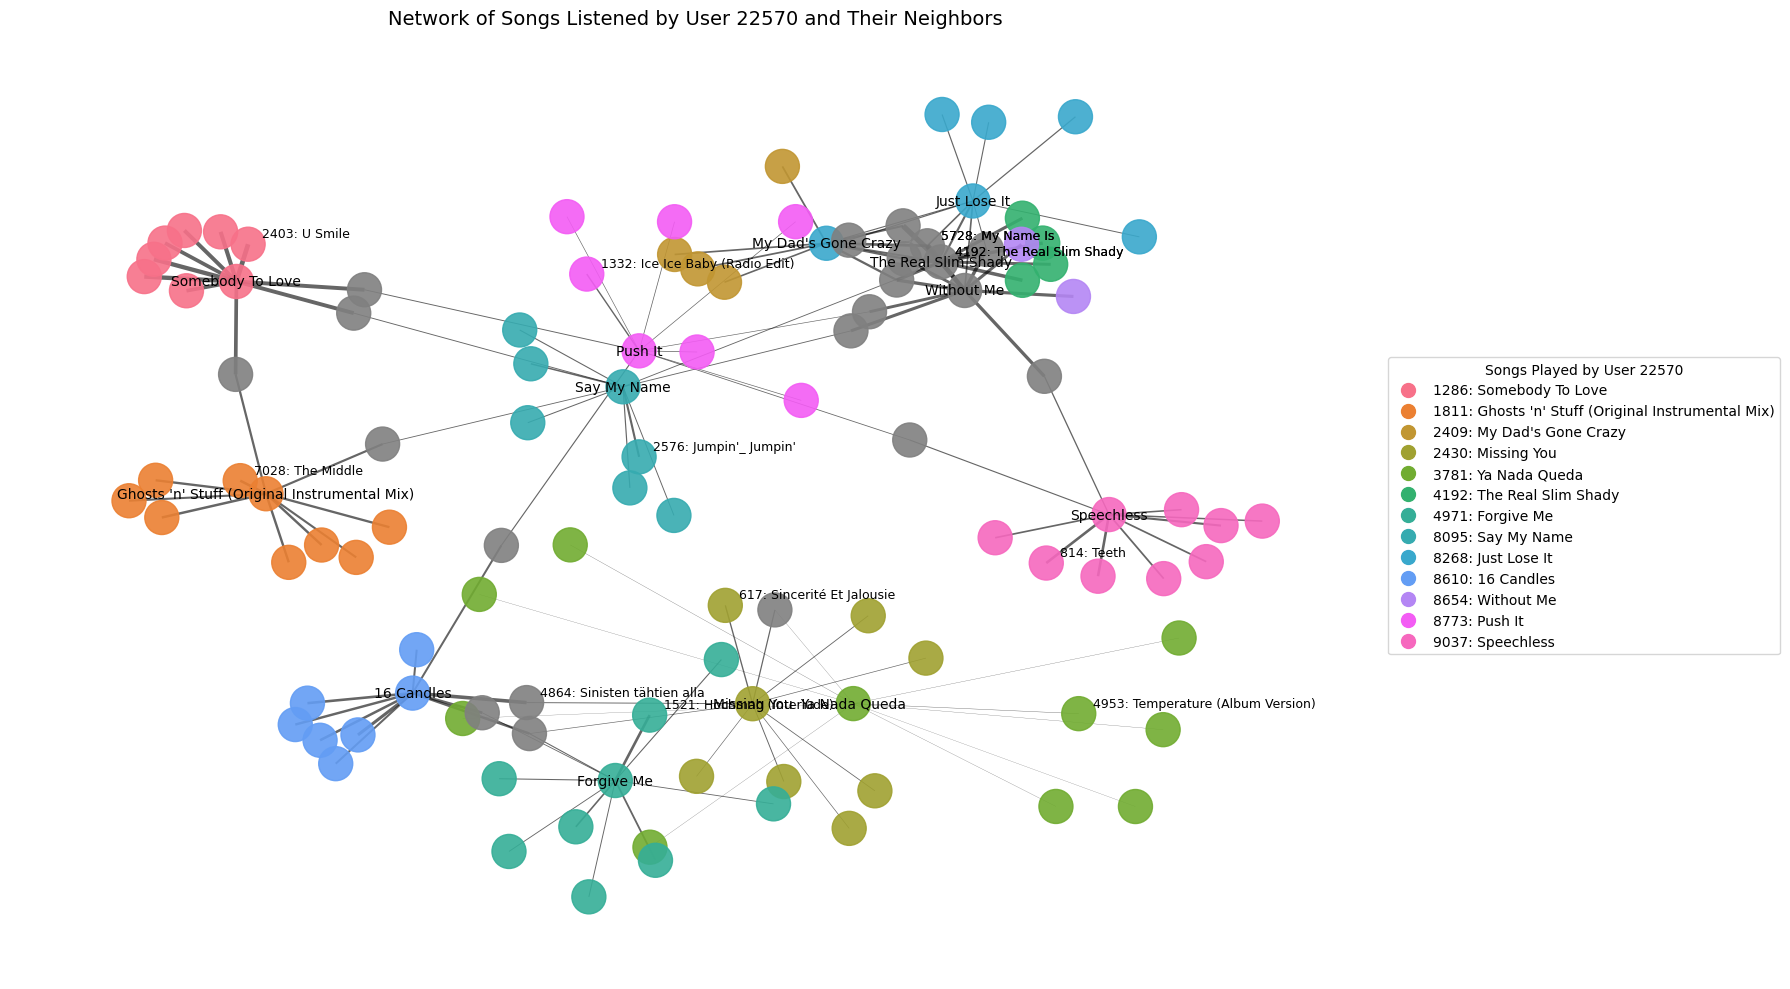

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the model on the trainset (log-transformed or original play counts)
sim_user_item_optimized2.fit(trainset)

# Step 2: Get the similarity matrix (computed during training)
similarity_matrix = sim_user_item_optimized2.sim

# Step 3: Retrieve the list of songs that user 22570 played, along with titles
user_22570_songs_df = df_final[df_final['user_id'] == 22570][['song_id', 'title']].drop_duplicates()
user_22570_songs = user_22570_songs_df['song_id'].unique()

# Step 4: Create a dictionary of all song titles for easy lookup (including neighbor songs)
all_song_titles = df_final[['song_id', 'title']].drop_duplicates().set_index('song_id')['title'].to_dict()

# Step 5: Create a NetworkX graph
G = nx.Graph()

# Generate a unique color for each song user 22570 played
colors = sns.color_palette("husl", len(user_22570_songs))

# Dictionary to keep track of how many times each neighbor appears
neighbor_count = {}
closest_neighbors = {}  # To store the closest neighbor for each main song

# Step 6: Add each song that user 22570 played as a main node and find its neighbors
for i, song_id in enumerate(user_22570_songs):
    song_inner_id = sim_user_item_optimized2.trainset.to_inner_iid(song_id)  # Convert to internal ID

    # Add the main song node to the graph
    G.add_node(song_id, label=f'Song {song_id}', color=colors[i])

    # Find neighbors (similar songs) for the current song
    neighbors = sim_user_item_optimized2.get_neighbors(song_inner_id, k=10)  # Find top 10 neighbors

    max_score = -1  # To track the closest neighbor based on similarity score

    # Add neighbors with the same color as the main song node
    for neighbor in neighbors:
        neighbor_raw_id = sim_user_item_optimized2.trainset.to_raw_iid(neighbor)  # Convert internal ID to raw song ID
        score = similarity_matrix[song_inner_id, neighbor]  # Get similarity score

        # Track how many times each neighbor appears
        if neighbor_raw_id in neighbor_count:
            neighbor_count[neighbor_raw_id] += 1
        else:
            neighbor_count[neighbor_raw_id] = 1

        # Check if this neighbor is the closest (highest similarity score)
        if score > max_score:
            max_score = score
            closest_neighbors[song_id] = neighbor_raw_id

        # Add the neighbor node with the same color as the main song
        G.add_node(neighbor_raw_id, label=f'Song {neighbor_raw_id}', color=colors[i])

        # Add an edge between the main song and its neighbor with similarity score
        G.add_edge(song_id, neighbor_raw_id, weight=score)

# Step 7: Update the color of common nodes (neighbors appearing more than once) to gray
for node in neighbor_count:
    if neighbor_count[node] > 1:
        G.nodes[node]['color'] = 'gray'  # Set the color of common nodes to gray

# Step 8: Create a layout for the network graph
pos = nx.spring_layout(G, seed=42)  # Spring layout for visualization

# Step 9: Adjust plot size (network graph size)
plt.figure(figsize=(18, 10))  # Adjust width and height for the plot size

# Step 10: Draw the nodes with adjusted sizes and colors
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600, alpha=0.9)  # Adjust node_size here

# Draw the edges with widths proportional to the similarity scores
edges = G.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, width=[weight * 10 for weight in edge_weights], alpha=0.6)

# Step 11: Draw labels for the main nodes (songs user 22570 listened to)
nx.draw_networkx_labels(G, pos, {song_id: all_song_titles.get(song_id, f'Song {song_id}') for song_id in user_22570_songs}, font_size=10)

# Step 12: Annotate the closest neighbor for each main node
for song_id, closest_neighbor_id in closest_neighbors.items():
    # Get the position of the closest neighbor
    x, y = pos[closest_neighbor_id]

    # Annotate with the song title of the closest neighbor, use a small offset to avoid overlapping
    plt.annotate(f'{closest_neighbor_id}: {all_song_titles.get(closest_neighbor_id, "Song")}',
                 xy=(x, y), xytext=(10, 5), textcoords='offset points', fontsize=9, color='black')

# Step 13: Prepare the legend outside the plot
legend_handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='') for color in colors]
legend_labels = [f"{song_id}: {all_song_titles.get(song_id, 'Song')}" for song_id in user_22570_songs]
plt.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Songs Played by User 22570")

# Step 14: Show the plot
plt.title('Network of Songs Listened by User 22570 and Their Neighbors', fontsize=14)
plt.tight_layout()
plt.axis('off')  # Turn off axis
plt.show()


### old code

In [ ]:
# OLD CODE-
#Apply the best model found in the grid search
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
#Train default KNNBasic model

# Define similarity options for the KNN algorithm (using Pearson correlation to avoid ZeroDivisionError)
sim_options = {'name': 'pearson', 'user_based': False}

# Initialize the KNNBasic algorithm with the defined similarity options
sim_user_item_optimized = KNNBasic(k=10, min_k=3, sim_options=sim_options, random_state = 1, verbose = False)

# Train the model on the trainset (scaled play counts)
sim_user_item_optimized.fit(trainset)

# Make predictions on the test set (scaled play counts)
predictions = sim_user_item_optimized.test(testset)

# Calculate RMSE and MAE for scaled play counts
print("Model Performance on Scaled Play Counts")
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Use precision_recall_at_k function to calculate and print metrics
rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k(sim_user_item_optimized, testset)

# Print calculated metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision@30: {precision}")
print(f"Recall@30: {recall}")
print(f"F_1 score: {2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 'N/A'}")
print(f"MAP (Mean Average Precision): {map_score}")
print(f"Diversity: {diversity}")
print(f"Novelty: {novelty}")

# Optional: Reverse the scaling if you need to interpret the predictions back to original play counts
scaled_predictions = [pred.est for pred in predictions]
original_play_counts = scaler.inverse_transform([[pred] for pred in scaled_predictions])

# Optionally, print the original play counts
print("Predicted Original Play Counts:", original_play_counts)

Model Performance on Scaled Play Counts
RMSE: 8.5619
MAE:  3.4842
Precision@30: 0.599
Recall@30: 0.933
F_1 score:  0.73
MAP (Mean Average Precision): 0.697
Diversity: 0.009
RMSE: 8.56188361202438
MAE: 3.4841559029327556
Novelty: 0.2
RMSE: 8.56188361202438
MAE: 3.4841559029327556
Precision@30: 0.599
Recall@30: 0.933
F_1 score: 0.7295913838120104
MAP (Mean Average Precision): 0.697
Diversity: 0.009
Novelty: 0.2
Predicted Original Play Counts: [[1299.16619111]
 [1063.11022662]
 [1862.04930426]
 ...
 [ 480.68949396]
 [8042.85300187]
 [2660.12798671]]


**Observations and Insights:______________**

## Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### default model

Default SVD Model with log transformation

In [ ]:
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Apply log transformation to the play counts (add 1 to avoid log(0))
df_final['play_count_log'] = np.log1p(df_final['play_count'])

# Define the Reader object with a fixed rating scale that fits your transformed play counts
min_log = df_final['play_count_log'].min()
max_log = df_final['play_count_log'].max()
reader = Reader(rating_scale=(min_log, max_log))

# Load data into surprise Dataset using the correct columns
data_log = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count_log']], reader)

# Train-test split
trainset, testset = train_test_split(data_log, test_size=0.2, random_state=1)

# Train the SVD model
SVDModel_log = SVD()
SVDModel_log.fit(trainset)

# Make predictions on the test set
predictions = SVDModel_log.test(testset)

# Calculate RMSE and MAE for the entire dataset
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

# Call the precision_recall_at_k function to calculate precision, recall, and other metrics
precision, recall, map_score, diversity, novelty, ndcg = precision_recall_at_k(
    model=SVDModel_log,  # Pass the trained model here
    testset=testset,
    k=30,
    threshold=1.5,
    confidence_threshold=2.5
)

# Predict the play count for user 22570 on song 1286 and user 63855 on song 1286
def predict_play_count(user_id, song_id, model):
    """
    Predict the play count for a given user and song using a trained SVD model.
    This function handles log-transformed data and applies the inverse log transformation
    to revert the prediction back to the original scale.

    Parameters:
    - user_id: The ID of the user.
    - song_id: The ID of the song.
    - model: The trained SVD model.

    Returns:
    - Predicted play count in the original scale.
    """
    prediction = model.predict(uid=user_id, iid=song_id)

    # Get the estimated log-transformed play count
    predicted_play_count_log = prediction.est

    # Apply the inverse log transformation to get back the original play count
    predicted_play_count = np.expm1(predicted_play_count_log)

    return predicted_play_count

# Example predictions for specific users and songs
predicted_play_count_22570 = predict_play_count(user_id=22570, song_id=1286, model=SVDModel_log)
predicted_play_count_63855 = predict_play_count(user_id=63855, song_id=1286, model=SVDModel_log)

print(f"Predicted play count for User 22570 on Song 1286 (original scale): {predicted_play_count_22570}")
print(f"Predicted play count for User 63855 on Song 1286 (original scale): {predicted_play_count_63855}")

# Store the results for future reference
results = {
    "rmse": rmse,
    "mae": mae,
    "precision": precision,
    "recall": recall,
    "map_score": map_score,
    "diversity": diversity,
    "novelty": novelty,
    "ndcg": ndcg,
    "predicted_play_count_22570": predicted_play_count_22570,
    "predicted_play_count_63855": predicted_play_count_63855
}

# Example output
print("Final results:")
for metric, value in results.items():
    print(f"{metric}: {value}")


RMSE: 0.6488
MAE:  0.4920
Precision@30: 0.025
Recall@30: 0.026
F_1 score:  0.025
MAP (Mean Average Precision): 0.026
Diversity: 0.0
NDCG: 0.025
Novelty: 0.348
Predicted play count for User 22570 on Song 1286 (original scale): 2.536400084917137
Predicted play count for User 63855 on Song 1286 (original scale): 2.536400084917137
Final results:
rmse: 0.6487730166183076
mae: 0.4919757595554824
precision: 0.025
recall: 0.026
map_score: 0.026
diversity: 0.0
novelty: 0.348
ndcg: 0.025
predicted_play_count_22570: 2.536400084917137
predicted_play_count_63855: 2.536400084917137


In [ ]:
# Calculate the global average play count
global_avg_play_count = df_final['play_count'].mean()
print(f"Global average play count: {global_avg_play_count}")


Global average play count: 4.199836297343552


In [ ]:
#recommendation for user 22570:

# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = SVDModel_log.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))

  song_id                                              title      artist_name  \
1      32                                                221  keller williams   
2    3859                    Clara meets Slope - Hard To Say       Clara Hill   
0     207                        Cold Blooded (Acid Cleanse)     The fFormula   
3    8362                                       Encore Break        Pearl Jam   
4    9269  Death Ain't No Big Deal (Tribute To Jake Hess ...        Jake Hess   

   play_count  predicted_play_count  
1         295              2.470182  
2         137              2.421942  
0         208              2.274226  
3         159              2.268192  
4         109              2.241048  


#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [ ]:

# Apply log transformation to the play counts (add 1 to avoid log(0))
df_final['play_count_log'] = np.log1p(df_final['play_count'])

# Define the Reader object with a fixed rating scale that fits your transformed play counts
min_log = df_final['play_count_log'].min()
max_log = df_final['play_count_log'].max()
reader = Reader(rating_scale=(min_log, max_log))

# Load data into surprise Dataset using the correct columns
data_log = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count_log']], reader)

# Define the parameter grid for hyperparameter search
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Perform grid search over the specified parameter range using SVD with 3-fold cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_search.fit(data_log)

# Get the best SVD model based on the grid search
best_model = grid_search.best_estimator['rmse']

# Output the best parameters and scores
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters for RMSE:", grid_search.best_params['rmse'])


Best RMSE score: 0.6469566039068705
Best parameters for RMSE: {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

### Optimized SVD model with log transformation

In [ ]:
import numpy as np

# Apply log transformation to the play counts (add 1 to avoid log(0))
df_final['play_count_log'] = np.log1p(df_final['play_count'])

# Train the model on the log-transformed play counts
data_log = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count_log']], reader)

# Train-test split
trainset, testset = train_test_split(data_log, test_size=0.2, random_state=1)

# Train the SVD model
SVDModel_log_Op = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)
SVDModel_log_Op.fit(trainset)

# Calculate RMSE and MAE
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

# Call the already defined precision_recall_at_k function to calculate the metrics
precision, recall, map_score, diversity, novelty, ndcg = precision_recall_at_k(
    model=SVDModel_log_Op,  # Pass the model here
    testset=testset,
    k=30,
    threshold=0.5,
    confidence_threshold=2.5
)

# Save the results for future reference
results = {
    "precision": precision,
    "recall": recall,
    "map_score": map_score,
    "diversity": diversity,
    "novelty": novelty,
    "ndcg": ndcg
}

def predict_play_count(user_id, song_id, model):
    """
    Predict the play count for a given user and song using a trained SVD model.
    This function handles log-transformed data and applies the inverse log transformation
    to revert the prediction back to the original scale.

    Parameters:
    - user_id: The ID of the user.
    - song_id: The ID of the song.
    - model: The trained SVD model.

    Returns:
    - Predicted play count in the original scale.
    """
    prediction = model.predict(uid=user_id, iid=song_id)

    # Get the estimated log-transformed play count
    predicted_play_count_log = prediction.est

    # Apply the inverse log transformation to get back the original play count
    predicted_play_count = np.expm1(predicted_play_count_log)

    return predicted_play_count

# Example usage:
predicted_play_count_22570 = predict_play_count(user_id=22570, song_id=1286, model=SVDModel_log_Op)
print(f"Predicted play count for User 22570 on Song 1286 (original scale): {predicted_play_count_22570}")

predicted_play_count_63855 = predict_play_count(user_id=63855, song_id=1283, model=SVDModel_log_Op)
print(f"Predicted play count for User 63855 on Song 1283 (original scale): {predicted_play_count_63855}")

RMSE: 0.6488
MAE:  0.4920
Precision@30: 0.024
Recall@30: 0.024
F_1 score:  0.024
MAP (Mean Average Precision): 0.024
Diversity: 0.0
NDCG: 0.024
Novelty: 0.347
Predicted play count for User 22570 on Song 1286 (original scale): 2.536400084917137
Predicted play count for User 63855 on Song 1283 (original scale): 2.536400084917137


train default model with MinMax scaler to see if there is difference

recommendations

In [ ]:
#recommendation for user 22570:

# Step 1: Find all songs the user has already listened to
listened_songs = df_final[df_final['user_id'] == 22570]['song_id'].unique()

# Step 2: Get a list of songs the user hasn't listened to yet
all_songs = df_final['song_id'].unique()
unlistened_songs = [song for song in all_songs if song not in listened_songs]

# Step 3: Make predictions for the unlistened songs using the KNNBasic model
recommendations = []

for song_id in unlistened_songs:
    # Predict the play count for each unlistened song
    pred = SVDModel_log_Op.predict(22570, song_id)
    recommendations.append((song_id, pred.est))  # Store song_id and predicted play count

# Step 4: Sort the songs by predicted play count in descending order
top_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Get details (song title, artist, actual play count) for the top 5 recommended songs
recommended_songs = df_final[df_final['song_id'].isin([rec[0] for rec in top_recommendations])][['song_id', 'title', 'artist_name', 'play_count']]

# Step 6: For each song, keep only the row with the maximum play count to remove duplicates
recommended_songs = recommended_songs.loc[recommended_songs.groupby('song_id')['play_count'].idxmax()]

# Step 7: Merge the recommendations with the actual song details
recommended_songs = recommended_songs.merge(pd.DataFrame(top_recommendations, columns=['song_id', 'predicted_play_count']), on='song_id', how='inner')

# Step 8: Display the top 5 recommendations with song details
print(recommended_songs[['song_id', 'title', 'artist_name', 'play_count', 'predicted_play_count']].sort_values(by='predicted_play_count', ascending=False))

   song_id                                              title  \
0       32                                                221   
3     3859                    Clara meets Slope - Hard To Say   
1      207                        Cold Blooded (Acid Cleanse)   
4     9269  Death Ain't No Big Deal (Tribute To Jake Hess ...   
2     2659                              Working With Homesick   

       artist_name  play_count  predicted_play_count  
0  keller williams         295              2.606094  
3       Clara Hill         137              2.529757  
1     The fFormula         208              2.471720  
4        Jake Hess         109              2.455763  
2   Homesick James         353              2.436312  


In [ ]:
# old code, without scaling
# Building the optimized SVD model using optimal hyperparameters

# Creating an instance of the SVD algorithm.
svd_optimized = SVD(n_epochs=10, lr_all=0.001, reg_all=0.2, random_state=1)

# Train the algorithm on the training set
svd_optimized.fit(trainset)

# Evaluate the model's performance using precision@k, recall@k, F1-score, and RMSE
precision_recall_at_k(svd_optimized, testset)

Precision@30: 0.617
Recall@30: 0.976
F_1 score:  0.756
MAP (Mean Average Precision): 0.727
Diversity: 0.02
RMSE: 8.248969559720354
MAE: 3.5649654039680208
Novelty: 0.212


(8.248969559720354, 3.5649654039680208, 0.617, 0.976, 0.727, 0.02, 0.212)

**Observations and Insights:_________**

## Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

Create a new precision_recall_at_k_cluster function to evaluate cluster models using threshold=1.5 and confidence_threshold=3.

Create a basic KMeans model uses hybird user and iten based approaches. Using Music_era as item true label, include popularity_score columns as a feature, random state =1. Apply any scaling or normalization is needed to reduce compute. Final prediction output should be converted back to play count for interpretability.

Default Parameters in the Model:

Recommendation Metrics:

Top-K (k): 30
Relevance Threshold (threshold): 1.5
Confidence Threshold (confidence_threshold): 3.5
KMeans Clustering:

Number of User Clusters (n_clusters_users): 10
Number of Item Clusters (n_clusters_items): 20
Random State: 42 (for reproducibility)
Data Handling:

User and Item Features: Assumed to be provided as NumPy arrays.
Predictions Format: List of tuples (user_id, song_id, true_r, est, _)

In [ ]:
df_final.head()

user_id  song_id  play_count                                         title  \
0    22570     1286           6                              Somebody To Love   
1    22570     1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2    22570     2409           6                           My Dad's Gone Crazy   
3    22570     2430           4                                   Missing You   
4    22570     3781           2                                 Ya Nada Queda   

                release           artist_name  year  popularity_score  
0             My Worlds         Justin Bieber  2010          0.134081  
1      Ghosts 'n' Stuff              Deadmau5  2009          0.094275  
2       The Eminem Show  Eminem / Hailie Jade  2006          0.034575  
3          Love To Love            John Waite  1984          0.084749  
4  Ultimate Hits Latino                 Kudai  2004          0.037017

when using PCA compoenents: cannot be more than number of features

create a **pick_closer_cluster function** to pick predicted play count from either user or item based cluster for whichever cluster is the user is closer to.
Then passs this function to precision_recall_at_k_cluster to calcuate top 30 reocmmendations.

Craete a new precision_recall_at_k_cluster function just for clustering models. Model training code should pass both (KMeansUsers and KMeansItems) to this function. This function only output recommendation quality metrics. Clustering metrics are calcuated within model training code.

Build a KMeans model using default paramaters. Hybird user-item, choosing closer of the two predicted value to calcuate recommendation metrics. Scale paly count and revert back.

In [ ]:
# prompt: descirbe df final

df_final.describe()


user_id        song_id     play_count           year  \
count  940730.000000  940730.000000  940730.000000  940730.000000   
mean    38135.722295    4999.101603       4.199836    1612.784843   
std     22055.028999    2889.050601       9.043733     791.311066   
min        10.000000       0.000000       1.000000       0.000000   
25%     19193.000000    2456.000000       1.000000    1983.000000   
50%     37826.000000    5093.000000       2.000000    2002.000000   
75%     57069.000000    7534.000000       4.000000    2007.000000   
max     76348.000000    9999.000000    2213.000000    2010.000000   

       popularity_score  
count     940730.000000  
mean           0.071917  
std            0.086489  
min            0.000222  
25%            0.030251  
50%            0.046726  
75%            0.079961  
max            0.761244

create a user/ item hybird cluster model. useRobustScaler, MinMaxScaler to properly scale dataset which has a lot of outliers.

https://chatgpt.com/c/67086aca-8e38-8004-8368-b57adb90da91

Final code to create baseline KMeans model:

Create a pick_closer_cluster function to get average predicted play count from user and item kMeans model.
Add ndcg_at_k metrics.
prediction_at_k_Kmeans(predictions, user_features, item_features, user_cluster_centers,
                           item_cluster_centers, user_cluster_labels, item_cluster_labels, scaler,
                           k=30, threshold=1.5, confidence_threshold=3.5).
          

### Train KMeasn Defalut model

In [ ]:
# ============================
# Import Libraries
# ============================
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from math import log2
from collections import defaultdict

# ============================
# Define Helper Functions
# ============================
def ndcg_at_k(relevant, recommended, k):
    dcg = 0.0
    for i in range(min(k, len(recommended))):
        if recommended[i] in relevant:
            dcg += 1 / log2(i + 2)  # positions i start at 0
    idcg = sum(1 / log2(i + 2) for i in range(min(k, len(relevant))))
    return dcg / idcg if idcg > 0 else 0.0

def pick_closer_cluster(user_id, song_id, user_features, item_features,
                        overall_avg_play_count, cluster_playcount_avg_dict):
    # Find user's cluster
    user_cluster = user_features.loc[user_features['user_id'] == user_id, 'user_cluster'].values
    if len(user_cluster) == 0:
        return overall_avg_play_count
    user_cluster = user_cluster[0]

    # Find item's cluster
    item_cluster = item_features.loc[item_features['song_id'] == song_id, 'item_cluster'].values
    if len(item_cluster) == 0:
        return overall_avg_play_count
    item_cluster = item_cluster[0]

    # Lookup average play count for this cluster pair
    key = (user_cluster, item_cluster)
    est = cluster_playcount_avg_dict.get(key, overall_avg_play_count)
    return est

def prediction_at_k_Kmeans(predictions, k=30, threshold=0.5, confidence_threshold=2.5):
    user_est_true = defaultdict(list)
    unique_recommendations = set()
    precisions = dict()
    recalls = dict()
    aps = dict()
    novelty_scores = dict()
    ndcgs = dict()

    # Map predictions to each user
    for user_id, song_id, true_r, est, _ in predictions:
        if est is not None:
            user_est_true[user_id].append((song_id, est, true_r))

    for user_id, interactions in user_est_true.items():
        # Sort interactions by estimated value in descending order
        interactions.sort(key=lambda x: x[1], reverse=True)

        # Filter based on confidence threshold
        filtered = [(song_id, est, true_r) for (song_id, est, true_r) in interactions if est >= confidence_threshold]

        # Number of relevant items
        n_rel = sum(1 for (_, _, true_r) in filtered if true_r >= threshold)

        # Number of recommended items in top k
        top_k = filtered[:k]
        n_rec_k = len(top_k)

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(1 for (_, est, true_r) in top_k if true_r >= threshold and est >= threshold)

        # Precision@K
        precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP calculation
        running_sum = 0.0
        rel_count = 0
        for i, (song_id, est, true_r) in enumerate(top_k, 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / i
        aps[user_id] = running_sum / rel_count if rel_count > 0 else 0

        # Track unique recommendations for diversity
        for (song_id, est, _) in top_k:
            unique_recommendations.add(song_id)

        # Novelty: based on estimated scores
        if top_k:
            novelty_scores[user_id] = np.mean([1 / (est + 0.2) for (_, est, _) in top_k])
        else:
            novelty_scores[user_id] = np.nan

        # NDCG@K
        relevant_items = set([song_id for (song_id, est, true_r) in filtered if true_r >= threshold])
        recommended_items = [song_id for (song_id, est, _) in top_k]
        ndcgs[user_id] = ndcg_at_k(relevant_items, recommended_items, k)

    # Compute mean metrics
    precision = round(np.mean(list(precisions.values())), 3) if precisions else 0
    recall = round(np.mean(list(recalls.values())), 3) if recalls else 0
    map_score = round(np.mean(list(aps.values())), 3) if aps else 0
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3) if predictions else 0
    mean_novelty = (
        round(np.nanmean([n for n in novelty_scores.values() if not np.isnan(n)]), 3)
        if any(not np.isnan(n) for n in novelty_scores.values())
        else None
    )
    mean_ndcg = round(np.mean(list(ndcgs.values())), 3) if ndcgs else 0

    # Aggregate all metrics
    results = {
        'Precision@K': precision,
        'Recall@K': recall,
        'F1_Score': round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) > 0 else 0,
        'MAP': map_score,
        'Diversity': diversity,
        'Novelty': mean_novelty,
        'NDCG@K': mean_ndcg,
    }

    # Print the metrics with labels
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1 Score: {results['F1_Score']}")
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"NDCG@{k}: {mean_ndcg}")
    print(f"Novelty: {mean_novelty if mean_novelty is not None else 'null (no recommendations or division by zero)'}")

    return results

# ============================
# Load and Prepare Data
# ============================
# Assuming df_final is already loaded and contains the required columns
# Ensure 'user_id' and 'song_id' are strings
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Drop 'user_cluster' and 'item_cluster' from df_final if they exist
df_final = df_final.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')

# Split data into train and test
train_data, test_data = train_test_split(df_final, test_size=0.2, random_state=1)

# Ensure 'user_id' and 'song_id' are strings in train and test data
train_data['user_id'] = train_data['user_id'].astype(str)
train_data['song_id'] = train_data['song_id'].astype(str)
test_data['user_id'] = test_data['user_id'].astype(str)
test_data['song_id'] = test_data['song_id'].astype(str)

# **Drop 'user_cluster' and 'item_cluster' from train_data and test_data if they exist**
train_data = train_data.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')
test_data = test_data.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')

# ============================
# User-Based Clustering
# ============================
# User aggregation
user_agg = train_data.groupby('user_id').agg({
    'play_count': 'sum',
    'song_id': 'nunique'
}).reset_index()

user_agg.rename(columns={'song_id': 'unique_song_count'}, inplace=True)

# Feature engineering
user_features_list = ['play_count', 'unique_song_count']
user_agg_log = user_agg[user_features_list].applymap(lambda x: np.log1p(x))
X_users = user_agg_log.values.astype('float32')

# Perform KMeans clustering for users
kmeans_users = KMeans(random_state=1)
user_clusters = kmeans_users.fit_predict(X_users)
user_agg['user_cluster'] = user_clusters

# ============================
# Item-Based Clustering
# ============================
# Item aggregation
item_agg = train_data.groupby('song_id').agg({
    'play_count': 'sum',
    'user_id': 'nunique'
}).reset_index()

item_agg.rename(columns={'user_id': 'unique_user_count'}, inplace=True)

# Feature engineering
item_features_list = ['play_count', 'unique_user_count']
item_agg_log = item_agg[item_features_list].applymap(lambda x: np.log1p(x))
X_items = item_agg_log.values.astype('float32')

# Perform KMeans clustering for items
kmeans_items = KMeans(random_state=1)
item_clusters = kmeans_items.fit_predict(X_items)
item_agg['item_cluster'] = item_clusters

# ============================
# Compute Average Play Counts per Cluster Combination
# ============================
# Merge user and item clusters with the training data
train_data_with_clusters = train_data.merge(
    user_agg[['user_id', 'user_cluster']], on='user_id', how='left'
).merge(
    item_agg[['song_id', 'item_cluster']], on='song_id', how='left'
)

# Drop 'user_cluster' and 'item_cluster' from train_data_with_clusters if they have suffixes
train_data_with_clusters = train_data_with_clusters.drop(
    columns=[col for col in train_data_with_clusters.columns if col.endswith(('_x', '_y'))],
    errors='ignore'
)

# Check columns
print("Columns in train_data_with_clusters:", train_data_with_clusters.columns.tolist())

# Check for missing values
print("\nMissing values in 'user_cluster' after merge:")
print(train_data_with_clusters['user_cluster'].isnull().sum())

print("Missing values in 'item_cluster' after merge:")
print(train_data_with_clusters['item_cluster'].isnull().sum())

# Fill missing clusters with a default value (-1)
train_data_with_clusters['user_cluster'].fillna(-1, inplace=True)
train_data_with_clusters['item_cluster'].fillna(-1, inplace=True)

# Ensure clusters are integers
train_data_with_clusters['user_cluster'] = train_data_with_clusters['user_cluster'].astype(int)
train_data_with_clusters['item_cluster'] = train_data_with_clusters['item_cluster'].astype(int)

# Compute the average play_count for each (user_cluster, item_cluster) pair
cluster_playcount_avg = train_data_with_clusters.groupby(
    ['user_cluster', 'item_cluster']
)['play_count'].mean().reset_index()
cluster_playcount_avg.rename(columns={'play_count': 'avg_play_count'}, inplace=True)

# Create a dictionary for quick lookup
cluster_playcount_avg_dict = {
    (row['user_cluster'], row['item_cluster']): row['avg_play_count']
    for _, row in cluster_playcount_avg.iterrows()
}

# Compute the overall average play count
overall_avg_play_count = train_data_with_clusters['play_count'].mean()

# ============================
# Store Features for Clusters
# ============================
user_features_processed = user_agg[['user_id', 'user_cluster']]
item_features_processed = item_agg[['song_id', 'item_cluster']]

# ============================
# Prepare Predictions from Test Data
# ============================
# For each user-song pair in test data, prepare a prediction tuple
predictions = []
for _, row in test_data.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    true_r = row['play_count']
    est = pick_closer_cluster(
        user_id, song_id, user_features_processed, item_features_processed,
        overall_avg_play_count, cluster_playcount_avg_dict
    )
    predictions.append((user_id, song_id, true_r, est, None))

# ============================
# Calculate and Print Clustering Metrics
# ============================
# Calculate metrics using scikit-learn
silhouette_users = silhouette_score(X_users, user_clusters)
davies_users = davies_bouldin_score(X_users, user_clusters)

silhouette_items = silhouette_score(X_items, item_clusters)
davies_items = davies_bouldin_score(X_items, item_clusters)

# Print the scores
print("\n=== Clustering Evaluation Metrics ===\n")
print("User Clusters:")
print(f"  Silhouette Score: {silhouette_users:.3f}")
print(f"  Davies-Bouldin Index: {davies_users:.3f}")
print(f"  Number of Clusters: {len(set(user_clusters))}")
print("  Users per Cluster:")
print(user_agg['user_cluster'].value_counts().sort_index())
print("\nItem Clusters:")
print(f"  Silhouette Score: {silhouette_items:.3f}")
print(f"  Davies-Bouldin Index: {davies_items:.3f}")
print(f"  Number of Clusters: {len(set(item_clusters))}")
print("  Items per Cluster:")
print(item_agg['item_cluster'].value_counts().sort_index())
print("\n")

# ============================
# Call the prediction_at_k_Kmeans Function
# ============================
results = prediction_at_k_Kmeans(
    predictions=predictions,
    k=30,
    threshold=0.5,
    confidence_threshold=2.5
)

# ============================
# Write Prediction Results Back to df_final
# ============================
# Drop 'user_cluster' and 'item_cluster' from df_final if they exist
df_final = df_final.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')

# Merge df_final with user and item clusters
df_final_with_clusters = df_final.merge(
    user_features_processed, on='user_id', how='left'
).merge(
    item_features_processed, on='song_id', how='left'
)

# **Ensure 'user_cluster' and 'item_cluster' are present in df_final_with_clusters**
print("Columns in df_final_with_clusters before renaming:")
print(df_final_with_clusters.columns.tolist())

# Rename cluster columns with prefix 'KMeans1_'
df_final_with_clusters.rename(columns={
    'user_cluster': 'KMeans1_user_cluster',
    'item_cluster': 'KMeans1_item_cluster'
}, inplace=True)

# **Verify that 'KMeans1_user_cluster' and 'KMeans1_item_cluster' are now in the DataFrame**
print("Columns in df_final_with_clusters after renaming:")
print(df_final_with_clusters.columns.tolist())

# Merge with cluster_playcount_avg to get predicted play counts
df_final_with_clusters = df_final_with_clusters.merge(
    cluster_playcount_avg,
    left_on=['KMeans1_user_cluster', 'KMeans1_item_cluster'],
    right_on=['user_cluster', 'item_cluster'],
    how='left'
)

# Assign predicted play count
df_final_with_clusters['KMeans1_predicted_play_count'] = df_final_with_clusters['avg_play_count']

# Fill missing predicted play counts with overall average
df_final_with_clusters['KMeans1_predicted_play_count'].fillna(overall_avg_play_count, inplace=True)

# Drop redundant columns after merge
df_final_with_clusters.drop(['user_cluster', 'item_cluster', 'avg_play_count'], axis=1, inplace=True)

# Round predicted play counts to two decimal places
df_final_with_clusters['KMeans1_predicted_play_count'] = df_final_with_clusters['KMeans1_predicted_play_count'].round(2)

# ============================
# Display a Sample of the Updated df_final
# ============================
print("\n=== Sample of df_final with KMeans Predictions ===\n")
print(df_final_with_clusters.head())


Columns in train_data_with_clusters: ['user_id', 'song_id', 'play_count', 'title', 'release', 'artist_name', 'year', 'popularity_score', 'play_count_log', 'user_cluster', 'item_cluster']

Missing values in 'user_cluster' after merge:
0
Missing values in 'item_cluster' after merge:
0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-589cc73cc3d0>", line 267, in <cell line: 263>
    est = pick_closer_cluster(
  File "<ipython-input-12-589cc73cc3d0>", line 26, in pick_closer_cluster
    user_cluster = user_features.loc[user_features['user_id'] == user_id, 'user_cluster'].values
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1182, in __getitem__
    if self._is_scalar_access(key):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1261, in _is_scalar_access
    if len(key) != self.ndim:
  File "indexing.pyx", line 23, in pandas._libs.indexing.NDFrameIndexerBase.ndim.__get__
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 696, in ndim
    @final
KeyboardInterrupt

During handling of the above exception, another e

TypeError: object of type 'NoneType' has no len()

In [ ]:
# ============================
# Calculate MAE and RMSE on Log-Transformed Play Counts
# ============================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure the necessary columns exist in df_final_with_clusters
# 'play_count' for actual values
# 'KMeansOptimized_predicted_play_count' for predicted values

# Apply log transformation to 'play_count' and 'KMeans1_predicted_play_count'
df_final_with_clusters['log_play_count'] = df_final_with_clusters['play_count'].apply(lambda x: np.log1p(x))
df_final_with_clusters['log_predicted_play_count'] = df_final_with_clusters['KMeans1_predicted_play_count'].apply(lambda x: np.log1p(x))

# Extract the log-transformed actual and predicted play counts
true_log_play_counts = df_final_with_clusters['log_play_count'].values
predicted_log_play_counts = df_final_with_clusters['log_predicted_play_count'].values

# Calculate Mean Absolute Error (MAE) on log-transformed data
mae_log = mean_absolute_error(true_log_play_counts, predicted_log_play_counts)
print(f"Log-Transformed Mean Absolute Error (MAE): {mae_log:.4f}")

# Calculate Root Mean Squared Error (RMSE) on log-transformed data
rmse_log = np.sqrt(mean_squared_error(true_log_play_counts, predicted_log_play_counts))
print(f"Log-Transformed Root Mean Squared Error (RMSE): {rmse_log:.4f}")


Log-Transformed Mean Absolute Error (MAE): 0.6170
Log-Transformed Root Mean Squared Error (RMSE): 0.7468


predict play count on song 1286 for user 63855 who has no play count on this song

In [ ]:
# ============================
# Predict Play Count for User '63855' on Song '1286'
# ============================

# Ensure user_id and song_id are strings
user_id = '63855'
song_id = '1286'

# Check if the user exists in user_features_processed
if user_id not in user_features_processed['user_id'].values:
    print(f"User {user_id} does not exist in the user features. Cannot predict play count.")
else:
    # Check if the song exists in item_features_processed
    if song_id not in item_features_processed['song_id'].values:
        print(f"Song {song_id} does not exist in the item features. Cannot predict play count.")
    else:
        # Predict the play count using the pick_closer_cluster function
        predicted_play_count = pick_closer_cluster(
            user_id, song_id, user_features_processed, item_features_processed,
            overall_avg_play_count, cluster_playcount_avg_dict
        )

        # Retrieve the song title
        song_title = df_final.loc[df_final['song_id'] == song_id, 'title'].iloc[0]

        # Print the predicted play count along with the song title
        print(f"Predicted play count for user {user_id} on song '{song_title}' (ID: {song_id}): {predicted_play_count:.2f}")


Predicted play count for user 63855 on song 'Somebody To Love' (ID: 1286): 10.96


### recommend songs

In [ ]:
# ============================
# Recommend Top 5 Songs to User '22570'
# ============================

# Ensure user_id is a string
user_id_to_recommend = '22570'

# Check if the user exists in the user features
if user_id_to_recommend not in user_features_processed['user_id'].values:
    print(f"User {user_id_to_recommend} does not exist in the user features. Cannot generate recommendations.")
else:
    # Get all songs
    all_songs = df_final['song_id'].unique()

    # Get songs the user has already interacted with
    user_interactions = df_final[df_final['user_id'] == user_id_to_recommend]['song_id'].unique()

    # Get songs the user has not interacted with yet
    songs_to_predict = np.setdiff1d(all_songs, user_interactions)

    # Prepare a DataFrame to store predictions
    predictions_df = pd.DataFrame(songs_to_predict, columns=['song_id'])

    # Predict play counts for each song
    predicted_play_counts = []
    for song_id in songs_to_predict:
        est = pick_closer_cluster(
            user_id_to_recommend, song_id, user_features_processed, item_features_processed,
            overall_avg_play_count, cluster_playcount_avg_dict
        )
        predicted_play_counts.append(est)

    # Add predicted play counts to the DataFrame
    predictions_df['predicted_play_count'] = predicted_play_counts

    # Merge with song titles
    predictions_df = predictions_df.merge(
        df_final[['song_id', 'title']].drop_duplicates('song_id'),
        on='song_id', how='left'
    )

    # Since the user hasn't interacted with these songs, actual play counts are zero
    predictions_df['actual_play_count'] = 0

    # Sort the songs by predicted play count in descending order
    top_recommendations = predictions_df.sort_values(by='predicted_play_count', ascending=False).head(5)

    # Reorder columns for clarity
    top_recommendations = top_recommendations[['title', 'predicted_play_count']]

    # Print the top 5 recommendations
    print(f"\nTop 5 song recommendations for user {user_id_to_recommend}:\n")
    print(top_recommendations.to_string(index=False))


Top 5 song recommendations for user 22570:

                                       title  predicted_play_count
        She Wouldn't Be Gone (Album Version)             12.240517
                                   Real Girl             12.240517
                          Ready to Flow 2008             12.240517
                            In The Moonlight             12.240517
I Wanna Love You (Akon Cover) ( Compilation)             12.240517


### Optimizde Model


---


n_cltr_u = 8  # Number of user clusters
n_cltr_i = 8  # Number of item clusters
n_init = 10   # Number of initializations

In [ ]:
# ============================
# Import Libraries
# ============================
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from math import log2
from collections import defaultdict
from joblib import Parallel, delayed

# ============================
# Define Helper Functions
# ============================
def ndcg_at_k(relevant, recommended, k):
    dcg = 0.0
    for i in range(min(k, len(recommended))):
        if recommended[i] in relevant:
            dcg += 1 / log2(i + 2)  # positions i start at 0
    idcg = sum(1 / log2(i + 2) for i in range(min(k, len(relevant))))
    return dcg / idcg if idcg > 0 else 0.0

def pick_closer_cluster(user_id, song_id, user_features, item_features,
                        overall_avg_log_play_count, cluster_playcount_avg_dict):
    # Find user's cluster
    user_cluster = user_features.loc[user_features['user_id'] == user_id, 'user_cluster'].values
    if len(user_cluster) == 0:
        return overall_avg_log_play_count
    user_cluster = user_cluster[0]

    # Find item's cluster
    item_cluster = item_features.loc[item_features['song_id'] == song_id, 'item_cluster'].values
    if len(item_cluster) == 0:
        return overall_avg_log_play_count
    item_cluster = item_cluster[0]

    # Lookup average log play count for this cluster pair
    key = (user_cluster, item_cluster)
    est_log = cluster_playcount_avg_dict.get(key, overall_avg_log_play_count)
    return est_log

def prediction_at_k_Kmeans(predictions, k=30, threshold=0.5, confidence_threshold=2.5):
    user_est_true = defaultdict(list)
    unique_recommendations = set()
    precisions = dict()
    recalls = dict()
    aps = dict()
    novelty_scores = dict()
    ndcgs = dict()

    # Map predictions to each user
    for user_id, song_id, true_r, est, _ in predictions:
        if est is not None:
            user_est_true[user_id].append((song_id, est, true_r))

    for user_id, interactions in user_est_true.items():
        # Sort interactions by estimated value in descending order
        interactions.sort(key=lambda x: x[1], reverse=True)

        # Filter based on confidence threshold
        filtered = [(song_id, est, true_r) for (song_id, est, true_r) in interactions if est >= confidence_threshold]

        # Number of relevant items
        n_rel = sum(1 for (_, _, true_r) in filtered if true_r >= threshold)

        # Number of recommended items in top k
        top_k = filtered[:k]
        n_rec_k = len(top_k)

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(1 for (_, est, true_r) in top_k if true_r >= threshold and est >= threshold)

        # Precision@K
        precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP calculation
        running_sum = 0.0
        rel_count = 0
        for i, (song_id, est, true_r) in enumerate(top_k, 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / i
        aps[user_id] = running_sum / rel_count if rel_count > 0 else 0

        # Track unique recommendations for diversity
        for (song_id, est, _) in top_k:
            unique_recommendations.add(song_id)

        # Novelty: based on estimated scores
        if top_k:
            novelty_scores[user_id] = np.mean([1 / (est + 0.2) for (_, est, _) in top_k])
        else:
            novelty_scores[user_id] = np.nan

        # NDCG@K
        relevant_items = set([song_id for (song_id, est, true_r) in filtered if true_r >= threshold])
        recommended_items = [song_id for (song_id, est, _) in top_k]
        ndcgs[user_id] = ndcg_at_k(relevant_items, recommended_items, k)

    # Compute mean metrics
    precision = round(np.mean(list(precisions.values())), 3) if precisions else 0
    recall = round(np.mean(list(recalls.values())), 3) if recalls else 0
    map_score = round(np.mean(list(aps.values())), 3) if aps else 0
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3) if predictions else 0
    mean_novelty = (
        round(np.nanmean([n for n in novelty_scores.values() if not np.isnan(n)]), 3)
        if any(not np.isnan(n) for n in novelty_scores.values())
        else None
    )
    mean_ndcg = round(np.mean(list(ndcgs.values())), 3) if ndcgs else 0

    # Aggregate all metrics
    results = {
        'Precision@K': precision,
        'Recall@K': recall,
        'F1_Score': round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) > 0 else 0,
        'MAP': map_score,
        'Diversity': diversity,
        'Novelty': mean_novelty,
        'NDCG@K': mean_ndcg,
    }

    # Print the metrics with labels
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1 Score: {results['F1_Score']}")
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"NDCG@{k}: {mean_ndcg}")
    print(f"Novelty: {mean_novelty if mean_novelty is not None else 'null (no recommendations or division by zero)'}")

    return results

# ============================
# Load and Prepare Data
# ============================
# Assuming df_final is already loaded and contains the required columns
# Ensure 'user_id' and 'song_id' are strings
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Drop 'user_cluster' and 'item_cluster' from df_final if they exist
df_final = df_final.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')

# Use the entire dataset for training as per instruction
full_data = df_final.copy()

# ============================
# User-Based Clustering with Best Hyperparameters
# ============================
n_cltr_u = 8  # Number of user clusters
n_cltr_i = 8  # Number of item clusters
n_init = 10   # Number of initializations

# User aggregation
user_agg = full_data.groupby('user_id').agg({
    'play_count': 'sum',
    'song_id': 'nunique'
}).reset_index()

user_agg.rename(columns={'song_id': 'unique_song_count'}, inplace=True)

# Feature engineering
user_features_list = ['play_count', 'unique_song_count']
# Apply log transformation
user_agg_log = user_agg[user_features_list].applymap(lambda x: np.log1p(x))
X_users = user_agg_log.values.astype('float32')

# Perform KMeans clustering for users with best hyperparameters
kmeans_users = KMeans(n_clusters=n_cltr_u, n_init=n_init, init='k-means++', random_state=1)
user_clusters = kmeans_users.fit_predict(X_users)
user_agg['user_cluster'] = user_clusters

# ============================
# Item-Based Clustering with Best Hyperparameters
# ============================
# Item aggregation
item_agg = full_data.groupby('song_id').agg({
    'play_count': 'sum',
    'user_id': 'nunique'
}).reset_index()

item_agg.rename(columns={'user_id': 'unique_user_count'}, inplace=True)

# Feature engineering
item_features_list = ['play_count', 'unique_user_count']
# Apply log transformation
item_agg_log = item_agg[item_features_list].applymap(lambda x: np.log1p(x))
X_items = item_agg_log.values.astype('float32')

# Perform KMeans clustering for items with best hyperparameters
kmeans_items = KMeans(n_clusters=n_cltr_i, n_init=n_init, init='k-means++', random_state=1)
item_clusters = kmeans_items.fit_predict(X_items)
item_agg['item_cluster'] = item_clusters

# ============================
# Compute Average Play Counts per Cluster Combination
# ============================
# Merge user and item clusters with the full data
data_with_clusters = full_data.merge(
    user_agg[['user_id', 'user_cluster']], on='user_id', how='left'
).merge(
    item_agg[['song_id', 'item_cluster']], on='song_id', how='left'
)

# Fill missing clusters with a default value (-1)
data_with_clusters['user_cluster'].fillna(-1, inplace=True)
data_with_clusters['item_cluster'].fillna(-1, inplace=True)

# Ensure clusters are integers
data_with_clusters['user_cluster'] = data_with_clusters['user_cluster'].astype(int)
data_with_clusters['item_cluster'] = data_with_clusters['item_cluster'].astype(int)

# Compute the average log-transformed play_count for each (user_cluster, item_cluster) pair
# Apply log transformation to 'play_count'
data_with_clusters['log_play_count'] = data_with_clusters['play_count'].apply(lambda x: np.log1p(x))

cluster_playcount_avg = data_with_clusters.groupby(
    ['user_cluster', 'item_cluster']
)['log_play_count'].mean().reset_index()
cluster_playcount_avg.rename(columns={'log_play_count': 'avg_log_play_count'}, inplace=True)

# Create a dictionary for quick lookup
cluster_playcount_avg_dict = {
    (row['user_cluster'], row['item_cluster']): row['avg_log_play_count']
    for _, row in cluster_playcount_avg.iterrows()
}

# Compute the overall average log play count
overall_avg_log_play_count = data_with_clusters['log_play_count'].mean()

# ============================
# Store Features for Clusters
# ============================
user_features_processed = user_agg[['user_id', 'user_cluster']]
item_features_processed = item_agg[['song_id', 'item_cluster']]

# ============================
# Prepare Predictions from Full Data (Parallelized)
# ============================
# Define the prediction function
def predict_play_count(row):
    user_id = row['user_id']
    song_id = row['song_id']
    true_r = row['play_count']
    est_log = pick_closer_cluster(
        user_id, song_id, user_features_processed, item_features_processed,
        overall_avg_log_play_count, cluster_playcount_avg_dict
    )
    est = np.expm1(est_log)  # Revert log transformation
    return (user_id, song_id, true_r, est, None)

# Apply the function in parallel
predictions = Parallel(n_jobs=-1)(
    delayed(predict_play_count)(row) for _, row in data_with_clusters.iterrows()
)

# ============================
# Calculate and Print Recommendation Quality Metrics
# ============================
results = prediction_at_k_Kmeans(
    predictions=predictions,
    k=30,
    threshold=0.5,
    confidence_threshold=2.5
)

# ============================
# Write Prediction Results Back to df_final_KmeansOptimized
# ============================
df_final_KmeansOptimized = data_with_clusters.copy()

# Rename cluster columns with prefix 'KMeansOptimized_'
df_final_KmeansOptimized.rename(columns={
    'user_cluster': 'KMeansOptimized_user_cluster',
    'item_cluster': 'KMeansOptimized_item_cluster'
}, inplace=True)

# Merge with cluster_playcount_avg to get predicted log play counts
df_final_KmeansOptimized = df_final_KmeansOptimized.merge(
    cluster_playcount_avg,
    left_on=['KMeansOptimized_user_cluster', 'KMeansOptimized_item_cluster'],
    right_on=['user_cluster', 'item_cluster'],
    how='left'
)

# Assign predicted log play count
df_final_KmeansOptimized['KMeansOptimized_predicted_log_play_count'] = df_final_KmeansOptimized['avg_log_play_count']

# Fill missing predicted log play counts with overall average
df_final_KmeansOptimized['KMeansOptimized_predicted_log_play_count'].fillna(overall_avg_log_play_count, inplace=True)

# Revert log transformation to get predicted play counts
df_final_KmeansOptimized['KMeansOptimized_predicted_play_count'] = df_final_KmeansOptimized['KMeansOptimized_predicted_log_play_count'].apply(lambda x: np.expm1(x))

# Drop redundant columns after merge
df_final_KmeansOptimized.drop(['user_cluster', 'item_cluster', 'avg_log_play_count', 'log_play_count'], axis=1, inplace=True)

# Round predicted play counts to two decimal places
df_final_KmeansOptimized['KMeansOptimized_predicted_play_count'] = df_final_KmeansOptimized['KMeansOptimized_predicted_play_count'].round(2)

# ============================
# Display a Sample of df_final_KmeansOptimized
# ============================
print("\n=== Sample of df_final_KmeansOptimized with KMeansOptimized Predictions ===\n")
print(df_final_KmeansOptimized.head())

# ============================
# Make a Prediction for User 63855 and Song 1286
# ============================
user_id_test = '63855'
song_id_test = '1286'

est_log = pick_closer_cluster(
    user_id_test, song_id_test, user_features_processed, item_features_processed,
    overall_avg_log_play_count, cluster_playcount_avg_dict
)
est = np.expm1(est_log)  # Revert log transformation
print(f"\nPredicted play count for user {user_id_test} and song {song_id_test}: {est:.2f}")


Precision@30: 0.678
Recall@30: 0.603
F1 Score: 0.638
MAP (Mean Average Precision): 0.678
Diversity: 0.0
NDCG@30: 0.678
Novelty: 0.264

=== Sample of df_final_KmeansOptimized with KMeansOptimized Predictions ===

  user_id song_id  play_count                                         title  \
0   22570    1286           6                              Somebody To Love   
1   22570    1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2   22570    2409           6                           My Dad's Gone Crazy   
3   22570    2430           4                                   Missing You   
4   22570    3781           2                                 Ya Nada Queda   

                release           artist_name  year  popularity_score  \
0             My Worlds         Justin Bieber  2010          0.134081   
1      Ghosts 'n' Stuff              Deadmau5  2009          0.094275   
2       The Eminem Show  Eminem / Hailie Jade  2006          0.034575   
3          Love To Lo

In [ ]:
# ============================
# Calculate MAE and RMSE on Log-Transformed Play Counts
# ============================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure the necessary columns exist in df_final_KmeansOptimized
# 'play_count' for actual values
# 'KMeansOptimized_predicted_play_count' for predicted values

# Apply log transformation to 'play_count' and 'KMeansOptimized_predicted_play_count'
df_final_KmeansOptimized['log_play_count'] = df_final_KmeansOptimized['play_count'].apply(lambda x: np.log1p(x))
df_final_KmeansOptimized['log_predicted_play_count'] = df_final_KmeansOptimized['KMeansOptimized_predicted_play_count'].apply(lambda x: np.log1p(x))

# Extract the log-transformed actual and predicted play counts
true_log_play_counts = df_final_KmeansOptimized['log_play_count'].values
predicted_log_play_counts = df_final_KmeansOptimized['log_predicted_play_count'].values

# Calculate Mean Absolute Error (MAE) on log-transformed data
mae_log = mean_absolute_error(true_log_play_counts, predicted_log_play_counts)
print(f"Log-Transformed Mean Absolute Error (MAE): {mae_log:.4f}")

# Calculate Root Mean Squared Error (RMSE) on log-transformed data
rmse_log = np.sqrt(mean_squared_error(true_log_play_counts, predicted_log_play_counts))
print(f"Log-Transformed Root Mean Squared Error (RMSE): {rmse_log:.4f}")


Log-Transformed Mean Absolute Error (MAE): 0.5266
Log-Transformed Root Mean Squared Error (RMSE): 0.6731


In [ ]:
# ============================
# Recommend Top 5 New Songs to User 22570 (Using df_final)
# ============================

# User ID for which to generate recommendations
user_id_recommend = '22570'

# Ensure 'user_id' and 'song_id' are strings
df_final_KmeansOptimized['user_id'] = df_final_KmeansOptimized['user_id'].astype(str)
df_final_KmeansOptimized['song_id'] = df_final_KmeansOptimized['song_id'].astype(str)

# Get all unique songs and their titles from df_final
# Assuming 'df_final' has columns 'song_id' and 'song_title'
all_songs_df = df_final_KmeansOptimized[['song_id', 'title']].drop_duplicates()

# Get all unique songs
all_songs = set(all_songs_df['song_id'])

# Get songs that the user has already listened to
user_songs = set(df_final_KmeansOptimized[df_final_KmeansOptimized['user_id'] == user_id_recommend]['song_id'].unique())

# Find songs that the user has not listened to yet
new_songs = all_songs - user_songs

# Create a DataFrame for new songs with song titles
new_songs_df = all_songs_df[all_songs_df['song_id'].isin(new_songs)]

# Function to predict play count for a user and a song
def predict_play_count_for_user_song(user_id, song_id):
    est_log = pick_closer_cluster(
        user_id, song_id, user_features_processed, item_features_processed,
        overall_avg_log_play_count, cluster_playcount_avg_dict
    )
    est = np.expm1(est_log)  # Revert log transformation
    return est

# Prepare a list to store predictions
predictions = []

# Loop over new songs and predict play counts
for _, row in new_songs_df.iterrows():
    song_id = row['song_id']
    title = row['title']
    est = predict_play_count_for_user_song(user_id_recommend, song_id)
    predictions.append({'song_id': song_id, 'title': title, 'predicted_play_count': est})

# Convert to DataFrame for easier sorting
predictions_df = pd.DataFrame(predictions)

# Sort the predictions in descending order of predicted play count
top_recommendations = predictions_df.sort_values(by='predicted_play_count', ascending=False).head(5)

# Display the top 5 recommended songs with titles
print(f"\nTop 5 Recommended Songs for User {user_id_recommend}:\n")
print(top_recommendations[['song_id', 'title', 'predicted_play_count']])



Top 5 Recommended Songs for User 22570:

     song_id                 title  predicted_play_count
5611    9332  Again I Go Unnoticed              6.718656
6692    3479      Love And Respect              6.718656
1950     260   Take A Chance On Me              6.718656
6019    2685          Désenchantée              6.718656
4057    1576      So Nice So Smart              6.718656


In [ ]:
# ============================
# Print Cluster Details from the Optimized Model
# ============================

# **User Clusters**

print("\n=== User Cluster Details ===")

# Number of users in each cluster
user_cluster_counts = user_agg['user_cluster'].value_counts().sort_index()
print("\nNumber of Users in Each Cluster:")
print(user_cluster_counts)

# Cluster centroids for users (based on original features)
user_agg_features = user_agg[user_features_list + ['user_cluster']]
user_cluster_centroids = user_agg_features.groupby('user_cluster').mean()
print("\nUser Cluster Centroids (Mean Feature Values):")
print(user_cluster_centroids)

# **Item Clusters**

print("\n=== Item Cluster Details ===")

# Number of items in each cluster
item_cluster_counts = item_agg['item_cluster'].value_counts().sort_index()
print("\nNumber of Items in Each Cluster:")
print(item_cluster_counts)

# Cluster centroids for items (based on original features)
item_agg_features = item_agg[item_features_list + ['item_cluster']]
item_cluster_centroids = item_agg_features.groupby('item_cluster').mean()
print("\nItem Cluster Centroids (Mean Feature Values):")
print(item_cluster_centroids)


=== User Cluster Details ===

Number of Users in Each Cluster:
0    1655
1    1150
2    3888
3    2475
4    1433
5    2758
6    2969
7    4314
Name: user_cluster, dtype: int64

User Cluster Centroids (Mean Feature Values):
              play_count  unique_song_count
user_cluster                               
0             239.946224          17.932326
1             520.729565         136.178261
2             110.722994          51.375000
3             108.687273          12.142222
4             444.254013          46.612003
5             214.219362          82.470631
6             192.063995          39.573594
7             106.119379          26.171998

=== Item Cluster Details ===

Number of Items in Each Cluster:
0     675
1     857
2    1839
3     169
4    1221
5     457
6    1430
7    1063
Name: item_cluster, dtype: int64

Item Cluster Centroids (Mean Feature Values):
               play_count  unique_user_count
item_cluster                                
0              373.485

### visulizations on KMeans optimized model

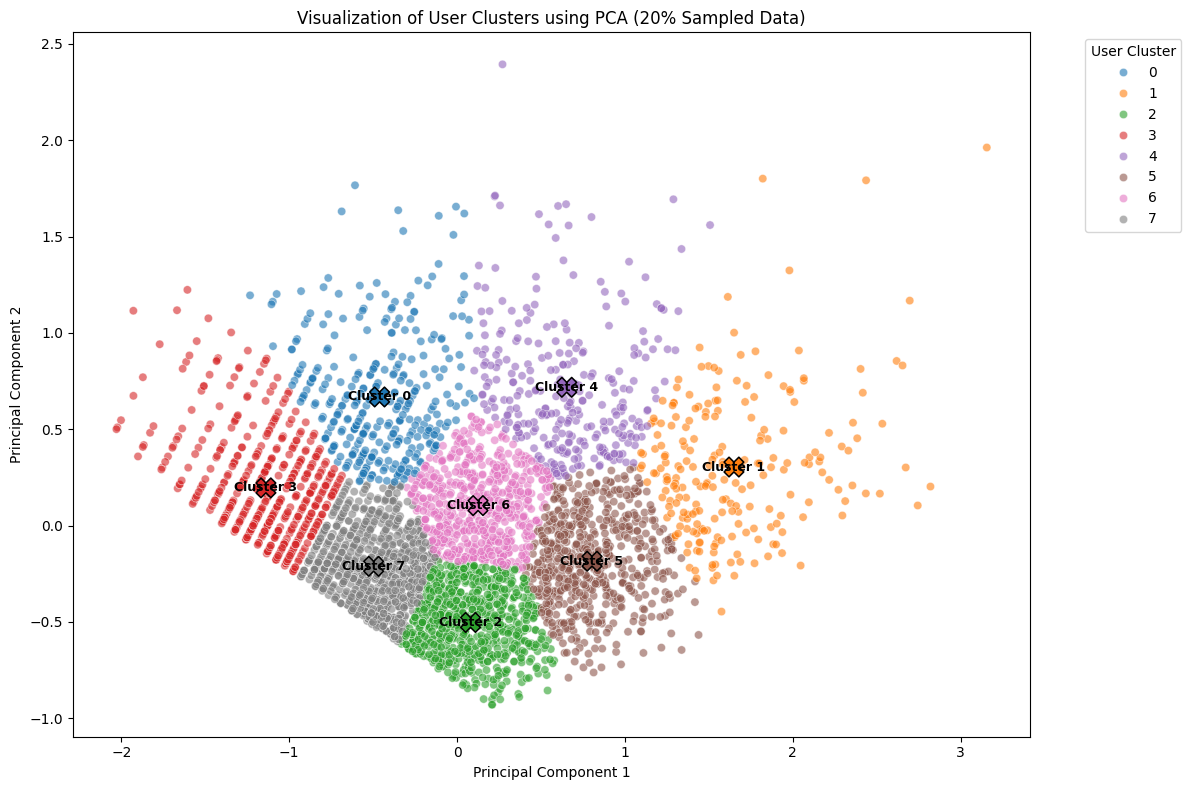

In [ ]:
# ============================
# Visualize User Clusters with PCA and Cluster Centroids (Using 20% of the Dataset)- user based
# ============================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Select the features used for clustering (log-transformed features)
# Use the log-transformed features from user_agg_log
user_features_log = user_agg_log.copy()
user_features_log['user_cluster'] = user_clusters  # Add cluster labels

# Combine the features and cluster labels into one DataFrame
user_features_log.reset_index(drop=True, inplace=True)
user_features_log['user_id'] = user_agg['user_id']

# Sample 20% of the users for visualization
sample_fraction = 0.2  # Use 20% of the data
user_features_sampled = user_features_log.sample(frac=sample_fraction, random_state=1)

# Extract the features and cluster labels for the sampled data
X_sampled = user_features_sampled[user_features_list].values
clusters_sampled = user_features_sampled['user_cluster'].values

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2, random_state=1)
user_features_pca = pca.fit_transform(X_sampled)

# Create a DataFrame with the reduced dimensions and cluster labels
user_pca_df = pd.DataFrame({
    'PC1': user_features_pca[:, 0],
    'PC2': user_features_pca[:, 1],
    'user_cluster': clusters_sampled
})

# Compute cluster centroids in the reduced PCA space
centroids_pca = user_pca_df.groupby('user_cluster')[['PC1', 'PC2']].mean().reset_index()

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=user_pca_df,
    x='PC1',
    y='PC2',
    hue='user_cluster',
    palette='tab10',
    legend='full',
    alpha=0.6
)

# Plot the centroids
sns.scatterplot(
    data=centroids_pca,
    x='PC1',
    y='PC2',
    hue='user_cluster',
    palette='tab10',
    legend=False,
    marker='X',
    s=200,
    edgecolor='black'
)

# Annotate centroids
for _, row in centroids_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], f"Cluster {int(row['user_cluster'])}", fontsize=9,
             horizontalalignment='center', verticalalignment='center', fontweight='bold')

plt.title('Visualization of User Clusters using PCA (20% Sampled Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='User Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


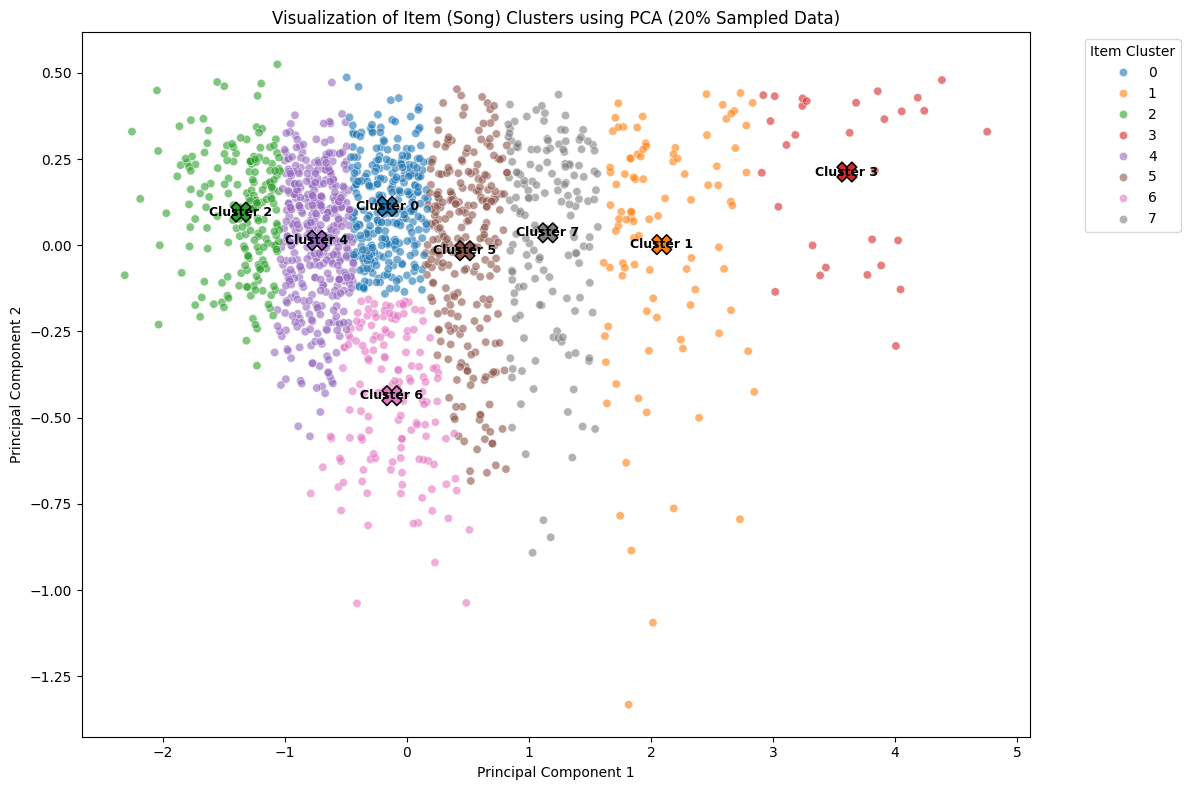

In [ ]:
# item based
from sklearn.decomposition import PCA


# Select the features used for clustering (log-transformed features)
# Use the log-transformed features from item_agg_log (songs data)
item_features_log = item_agg_log.copy()
item_features_log['item_cluster'] = item_clusters  # Add cluster labels

# Combine the features and cluster labels into one DataFrame
item_features_log.reset_index(drop=True, inplace=True)
item_features_log['song_id'] = item_agg['song_id']

# Sample 20% of the songs for visualization
sample_fraction = 0.2  # Use 20% of the data
item_features_sampled = item_features_log.sample(frac=sample_fraction, random_state=1)

# Extract the features and cluster labels for the sampled data
X_sampled = item_features_sampled[item_features_list].values  # Replace with the correct feature columns
clusters_sampled = item_features_sampled['item_cluster'].values

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2, random_state=1)
item_features_pca = pca.fit_transform(X_sampled)

# Create a DataFrame with the reduced dimensions and cluster labels
item_pca_df = pd.DataFrame({
    'PC1': item_features_pca[:, 0],
    'PC2': item_features_pca[:, 1],
    'item_cluster': clusters_sampled
})

# Compute cluster centroids in the reduced PCA space
centroids_pca = item_pca_df.groupby('item_cluster')[['PC1', 'PC2']].mean().reset_index()

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=item_pca_df,
    x='PC1',
    y='PC2',
    hue='item_cluster',
    palette='tab10',
    legend='full',
    alpha=0.6
)

# Plot the centroids
sns.scatterplot(
    data=centroids_pca,
    x='PC1',
    y='PC2',
    hue='item_cluster',
    palette='tab10',
    legend=False,
    marker='X',
    s=200,
    edgecolor='black'
)

# Annotate centroids
for _, row in centroids_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], f"Cluster {int(row['item_cluster'])}", fontsize=9,
             horizontalalignment='center', verticalalignment='center', fontweight='bold')

plt.title('Visualization of Item (Song) Clusters using PCA (20% Sampled Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Item Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


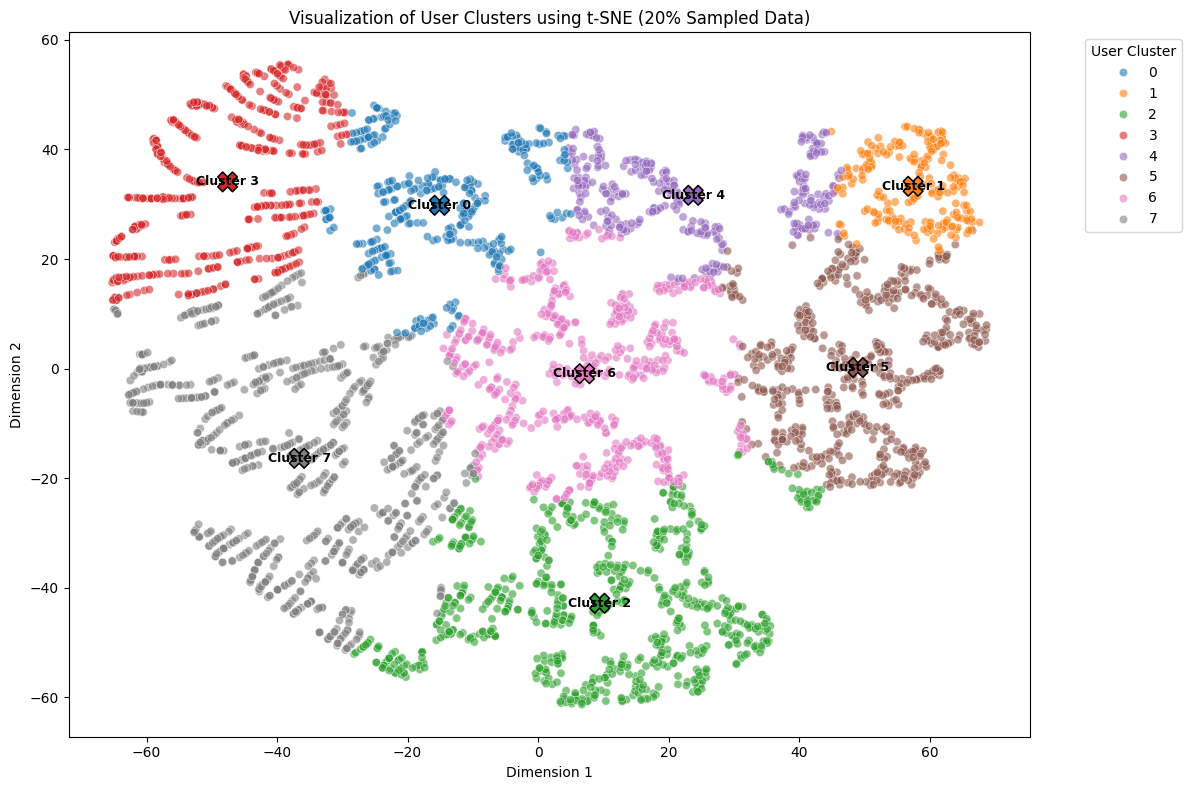

In [ ]:
# ============================
# Visualize User Clusters with t-SNE and Cluster Centroids (Using 20% of the Dataset) -user-based
# ============================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Select the features used for clustering (log-transformed features)
user_features_log = user_agg_log.copy()
user_features_log['user_cluster'] = user_clusters  # Add cluster labels

# Combine the features and cluster labels into one DataFrame
user_features_log.reset_index(drop=True, inplace=True)
user_features_log['user_id'] = user_agg['user_id']

# Sample 20% of the users for visualization
sample_fraction = 0.2  # Use 20% of the data
user_features_sampled = user_features_log.sample(frac=sample_fraction, random_state=1)

# Extract the features and cluster labels for the sampled data
X_sampled = user_features_sampled[user_features_list].values
clusters_sampled = user_features_sampled['user_cluster'].values

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1, n_iter=1000)
user_features_tsne = tsne.fit_transform(X_sampled)

# Create a DataFrame with the reduced dimensions and cluster labels
user_tsne_df = pd.DataFrame({
    'Dim1': user_features_tsne[:, 0],
    'Dim2': user_features_tsne[:, 1],
    'user_cluster': clusters_sampled
})

# Compute cluster centroids in the reduced t-SNE space
centroids_tsne = user_tsne_df.groupby('user_cluster')[['Dim1', 'Dim2']].mean().reset_index()

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=user_tsne_df,
    x='Dim1',
    y='Dim2',
    hue='user_cluster',
    palette='tab10',
    legend='full',
    alpha=0.6
)

# Plot the centroids
sns.scatterplot(
    data=centroids_tsne,
    x='Dim1',
    y='Dim2',
    hue='user_cluster',
    palette='tab10',
    legend=False,
    marker='X',
    s=200,
    edgecolor='black'
)

# Annotate centroids
for _, row in centroids_tsne.iterrows():
    plt.text(row['Dim1'], row['Dim2'], f"Cluster {int(row['user_cluster'])}", fontsize=9,
             horizontalalignment='center', verticalalignment='center', fontweight='bold')

plt.title('Visualization of User Clusters using t-SNE (20% Sampled Data)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='User Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


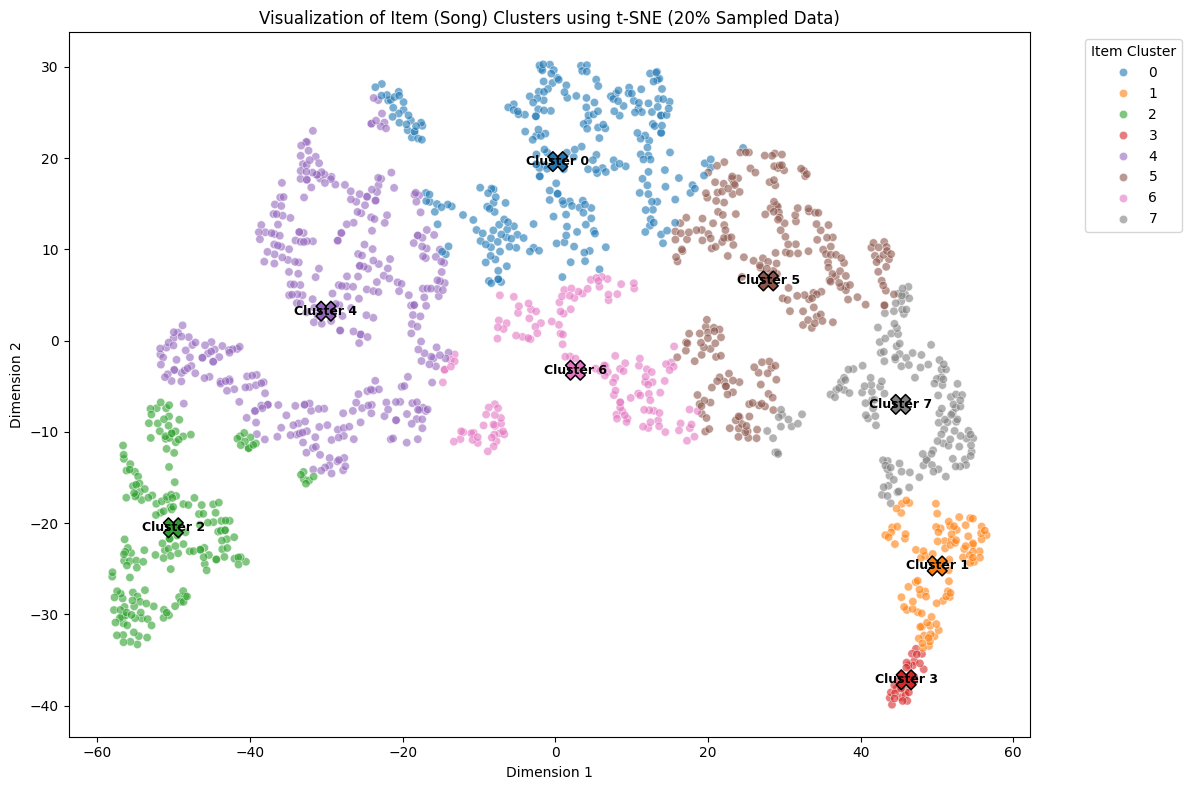

In [ ]:
# item based
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Select the features used for clustering (log-transformed features)
item_features_log = item_agg_log.copy()  # Replace user_agg_log with item_agg_log (log-transformed item features)
item_features_log['item_cluster'] = item_clusters  # Add cluster labels for items

# Combine the features and cluster labels into one DataFrame
item_features_log.reset_index(drop=True, inplace=True)
item_features_log['song_id'] = item_agg['song_id']  # Use 'song_id' instead of 'user_id'

# Sample 20% of the items for visualization
sample_fraction = 0.2  # Use 20% of the data
item_features_sampled = item_features_log.sample(frac=sample_fraction, random_state=1)

# Extract the features and cluster labels for the sampled data
X_sampled = item_features_sampled[item_features_list].values  # Replace 'user_features_list' with the item feature list
clusters_sampled = item_features_sampled['item_cluster'].values

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1, n_iter=1000)
item_features_tsne = tsne.fit_transform(X_sampled)

# Create a DataFrame with the reduced dimensions and cluster labels
item_tsne_df = pd.DataFrame({
    'Dim1': item_features_tsne[:, 0],
    'Dim2': item_features_tsne[:, 1],
    'item_cluster': clusters_sampled
})

# Compute cluster centroids in the reduced t-SNE space
centroids_tsne = item_tsne_df.groupby('item_cluster')[['Dim1', 'Dim2']].mean().reset_index()

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=item_tsne_df,
    x='Dim1',
    y='Dim2',
    hue='item_cluster',
    palette='tab10',
    legend='full',
    alpha=0.6
)

# Plot the centroids
sns.scatterplot(
    data=centroids_tsne,
    x='Dim1',
    y='Dim2',
    hue='item_cluster',
    palette='tab10',
    legend=False,
    marker='X',
    s=200,
    edgecolor='black'
)

# Annotate centroids
for _, row in centroids_tsne.iterrows():
    plt.text(row['Dim1'], row['Dim2'], f"Cluster {int(row['item_cluster'])}", fontsize=9,
             horizontalalignment='center', verticalalignment='center', fontweight='bold')

plt.title('Visualization of Item (Song) Clusters using t-SNE (20% Sampled Data)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Item Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Understanding the KMeans1_predicted_play_count Column
Cluster Assignments:

KMeans1_user_cluster: Indicates which user cluster a specific user belongs to, as determined by the kmeans_users model.
KMeans1_item_cluster: Indicates which item (song) cluster a specific song belongs to, as determined by the kmeans_items model.
Prediction Mechanism:

The predicted play count (KMeans1_predicted_play_count) for a user-song pair is not based on the "closeness" of clusters. Instead, it is derived from the average play count of all interactions within the specific (user_cluster, item_cluster) pair in the training data.
Formula:
Predicted Play Count
=
Average Play Count of (user_cluster, item_cluster)
Predicted Play Count=Average Play Count of (user_cluster, item_cluster)
Fallback:
If a particular (user_cluster, item_cluster) pair doesn't exist in the training data (i.e., there's no average play count recorded for that combination), the prediction defaults to the overall average play count across all data.
Why Only One Prediction Column?

The prediction is a single numerical value representing the estimated play count for the specific user-song pair. This value encapsulates the combined influence of both the user’s cluster and the song’s cluster.
Having separate prediction columns for user and item clusters isn't necessary because the prediction inherently accounts for both through their combination.

#### Improving clustering-based recommendation system by tuning its hyper-parameters

n_cltr_u: Number of clusters for users.
n_cltr_i: Number of clusters for items.
n_epochs: Number of iterations (or epochs) in the clustering process.
We can combine user-based and item-based clustering with cross-validation by applying separate K-Means clustering for users (n_cltr_u) and items (n_cltr_i), then evaluate the resulting clusters using RMSE and MAE.

param grid to search best paramaters for user-item KMeans:
using full data set

Install rapids https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#scrollTo=m0jdXBRiDSzj

### Install rapids

https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#scrollTo=Dlsyk9m9NN2K

In [ ]:
!nvidia-smi

Mon Oct 14 22:53:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# Step 1
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (256/256), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 525 (delta 168), reused 129 (delta 94), pack-reused 269 (from 1)
Receiving objects: 100% (525/525), 168.72 KiB | 738.00 KiB/s, done.
Resolving deltas: 100% (270/270), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.3 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



In [ ]:
# Step 2
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Found existing installation: cupy-cuda12x 12.2.0
Uninstalling cupy-cuda12x-12.2.0:
  Successfully uninstalled cupy-cuda12x-12.2.0
restarting Colab...


In [ ]:
# Step 3
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


In [ ]:
# Step 4
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Step 5
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!cd rapidsai-csp-utils
!git checkout https://github.com/rapidsai-community/rapidsai-csp-utils/tree/taureandyernv-colab-cu12
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

fatal: not a git repository (or any of the parent directories): .git
  Using cached pynvml-11.5.3-py3-none-any.whl.metadata (8.8 kB)
Using cached pynvml-11.5.3-py3-none-any.whl (53 kB)
Found existing installation: cffi 1.16.0
Uninstalling cffi-1.16.0:
  Successfully uninstalled cffi-1.16.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.3/446.3 kB 22.6 MB/s eta 0:00:00
Installing RAPIDS Stable 23.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    archspec-0.2.3             |     pyhd8ed1ab_0          48 KB  conda-forge
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1

In [ ]:
# DONT need this - Install RAPIDS using an alternative method for Colab
!wget -nc https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
!chmod +x rapids-colab.sh
!./rapids-colab.sh 23.06

--2024-10-15 23:15:33--  https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2516 (2.5K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   2.46K  --.-KB/s    in 0s      

2024-10-15 23:15:33 (57.2 MB/s) - ‘rapids-colab.sh’ saved [2516/2516]

PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We ha

In [ ]:
   # step 6
   # install compatitble version of numpy
   !pip install numpy==1.24

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cucim 23.12.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.12.1 requires cubinlinker, which is not installed.
cudf 23.12.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.12.1 requires ptxcompiler, which is not installed.
cugraph 23.12.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cugraph 23.12.0 requires rapids-dask-dependency==23.12.*, which is not installed.
cuml 23.12.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.12.0 requires rapids-dask-dependency==23.12.*, which is not installed.
cuxfilter 23.12.0 requires cupy-cuda11x>

In [ ]:
# step 7
#upgrade numba, find current version from https://pypi.org/search
!pip install numba==0.60.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.40.1
    Uninstalling llvmlite-0.40.1:
      Successfully uninstalled llvmlite-0.40.1
  Attempting uninstall: numba
    Found existing installation: numba 0.57.1
    Uninstalling numba-0.57.1:
      Successfully uninstalled numba-0.57.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.12.1 requires cubinlinker, which is not installed.
cudf 23.12.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.12.1 requires ptxcompiler, which is not installed.
cugraph 23.12.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cugraph 23.12.0 requires rapids-dask-dependency==23.12.*, which is not installed.
cuml 23.12.0 req

In [ ]:
# test it out
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

AttributeError: module 'cudf' has no attribute 'utils'

In [ ]:
import cudf, cuml, cugraph, cuspatial

### KMeans Grid Search updated

In [ ]:
# ============================
# Import Libraries
# ============================
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

# ============================
# Load and Prepare Data
# ============================
# Assuming df_final is already loaded and contains the required columns
# Ensure 'user_id' and 'song_id' are strings
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['song_id'] = df_final['song_id'].astype(str)

# Remove 'user_cluster' and 'item_cluster' columns if they exist
df_final = df_final.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')

# Prepare K-Fold Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=1)

# Define Hyperparameter Grid
param_grid = {
    'n_cltr_u': [8, 10, 12, 16],  # Number of user clusters
    'n_cltr_i': [8, 10, 12, 16],   # Number of item clusters
    'n_init': [10, 20, 30] # The algorithm runs X times with different centroid seeds.
}

# Initialize list to store results
grid_search_results = []

# Grid Search Loop
for n_cltr_u in param_grid['n_cltr_u']:
    for n_cltr_i in param_grid['n_cltr_i']:
        for n_init in param_grid['n_init']:
            cv_silhouette_users = []
            cv_silhouette_items = []
            print(f"\nEvaluating n_cltr_u = {n_cltr_u}, n_cltr_i = {n_cltr_i}, n_init = {n_init}")
            for fold, (train_index, test_index) in enumerate(kf.split(df_final)):
                print(f"  Fold {fold + 1}")
                # Split data into train and test for this fold
                train_data = df_final.iloc[train_index]
                # test_data = df_final.iloc[test_index]  # Not needed for clustering evaluation

                # Ensure 'user_id' and 'song_id' are strings in train data
                train_data['user_id'] = train_data['user_id'].astype(str)
                train_data['song_id'] = train_data['song_id'].astype(str)

                # Remove 'user_cluster' and 'item_cluster' from train_data if they exist
                train_data = train_data.drop(columns=['user_cluster', 'item_cluster'], errors='ignore')

                # ============================
                # User-Based Clustering
                # ============================
                # User aggregation
                user_agg = train_data.groupby('user_id').agg({
                    'play_count': 'sum',
                    'song_id': 'nunique'
                }).reset_index()

                user_agg.rename(columns={'song_id': 'unique_song_count'}, inplace=True)

                # Feature engineering
                user_features_list = ['play_count', 'unique_song_count']
                user_agg_log = user_agg[user_features_list].applymap(lambda x: np.log1p(x))
                X_users = user_agg_log.values.astype('float32')

                # Perform KMeans clustering for users with n_init
                kmeans_users = KMeans(
                    n_clusters=n_cltr_u,
                    n_init=n_init,
                    init='k-means++',
                    random_state=1
                )
                user_clusters = kmeans_users.fit_predict(X_users)
                user_agg['user_cluster'] = user_clusters

                # Compute Silhouette score for user clusters
                silhouette_user = silhouette_score(X_users, user_clusters)
                cv_silhouette_users.append(silhouette_user)

                # ============================
                # Item-Based Clustering
                # ============================
                # Item aggregation
                item_agg = train_data.groupby('song_id').agg({
                    'play_count': 'sum',
                    'user_id': 'nunique'
                }).reset_index()

                item_agg.rename(columns={'user_id': 'unique_user_count'}, inplace=True)

                # Feature engineering
                item_features_list = ['play_count', 'unique_user_count']
                item_agg_log = item_agg[item_features_list].applymap(lambda x: np.log1p(x))
                X_items = item_agg_log.values.astype('float32')

                # Perform KMeans clustering for items with n_init
                kmeans_items = KMeans(
                    n_clusters=n_cltr_i,
                    n_init=n_init,
                    init='k-means++',
                    random_state=1
                )
                item_clusters = kmeans_items.fit_predict(X_items)
                item_agg['item_cluster'] = item_clusters

                # Compute Silhouette score for item clusters
                silhouette_item = silhouette_score(X_items, item_clusters)
                cv_silhouette_items.append(silhouette_item)

            # Compute average Silhouette scores across folds
            avg_silhouette_user = np.mean(cv_silhouette_users)
            avg_silhouette_item = np.mean(cv_silhouette_items)
            print(f"  Average Silhouette Score (Users): {avg_silhouette_user:.4f}")
            print(f"  Average Silhouette Score (Items): {avg_silhouette_item:.4f}")

            # Store the results
            grid_search_results.append({
                'n_cltr_u': n_cltr_u,
                'n_cltr_i': n_cltr_i,
                'n_init': n_init,
                'avg_silhouette_user': avg_silhouette_user,
                'avg_silhouette_item': avg_silhouette_item
            })

# ============================
# Find the Best Hyperparameters
# ============================
# You can decide whether to prioritize user clustering, item clustering, or a combination
# For this example, we'll consider the average of both Silhouette scores
for result in grid_search_results:
    result['avg_silhouette'] = (result['avg_silhouette_user'] + result['avg_silhouette_item']) / 2

# Find the result with the maximum average Silhouette score
best_result = max(grid_search_results, key=lambda x: x['avg_silhouette'])

print("\n=== Best Hyperparameters ===")
print(f"Number of User Clusters (n_cltr_u): {best_result['n_cltr_u']}")
print(f"Number of Item Clusters (n_cltr_i): {best_result['n_cltr_i']}")
print(f"Number of Initializations (n_init): {best_result['n_init']}")
print(f"Average Silhouette Score (Users): {best_result['avg_silhouette_user']:.4f}")
print(f"Average Silhouette Score (Items): {best_result['avg_silhouette_item']:.4f}")
print(f"Overall Average Silhouette Score: {best_result['avg_silhouette']:.4f}")

# ============================
# Optional: Re-train Model with Best Hyperparameters on Full Data
# ============================
# You can now retrain your model using the best hyperparameters on the full dataset



Evaluating n_cltr_u = 8, n_cltr_i = 8, n_init = 10
  Fold 1
  Fold 2
  Fold 3
  Average Silhouette Score (Users): 0.3317
  Average Silhouette Score (Items): 0.3590

Evaluating n_cltr_u = 8, n_cltr_i = 8, n_init = 20
  Fold 1
  Fold 2
  Fold 3
  Average Silhouette Score (Users): 0.3316
  Average Silhouette Score (Items): 0.3590

Evaluating n_cltr_u = 8, n_cltr_i = 8, n_init = 30
  Fold 1
  Fold 2
  Fold 3
  Average Silhouette Score (Users): 0.3316
  Average Silhouette Score (Items): 0.3590

Evaluating n_cltr_u = 8, n_cltr_i = 10, n_init = 10
  Fold 1
  Fold 2
  Fold 3
  Average Silhouette Score (Users): 0.3317
  Average Silhouette Score (Items): 0.3555

Evaluating n_cltr_u = 8, n_cltr_i = 10, n_init = 20
  Fold 1
  Fold 2
  Fold 3
  Average Silhouette Score (Users): 0.3316
  Average Silhouette Score (Items): 0.3555

Evaluating n_cltr_u = 8, n_cltr_i = 10, n_init = 30
  Fold 1
  Fold 2
  Fold 3
  Average Silhouette Score (Users): 0.3316
  Average Silhouette Score (Items): 0.3558

Evalua

### experiment grid search code with GPU acceleration (install rapids first)

In [ ]:
# updated to use log transformation and use GPU acceleration
import pandas as pd
import numpy as np
from cuml.cluster import KMeans as cuKMeans  # GPU-accelerated KMeans from cuML
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import KFold, ParameterGrid
from joblib import Parallel, delayed

# ============================
# Define Helper Functions
# ============================

def compute_metrics(params, train_users, val_users, train_items, val_items, sample_size=1000):
    """
    Compute Silhouette Score, Inertia, Calinski-Harabasz, and Davies-Bouldin Index for a given set of parameters.

    Args:
        params (dict): Dictionary with 'n_cltr_u', 'n_cltr_i', and 'n_epochs'.
        train_users (DataFrame): Training user features.
        val_users (DataFrame): Validation user features.
        train_items (DataFrame): Training item features.
        val_items (DataFrame): Validation item features.
        sample_size (int): Number of samples to compute metrics.

    Returns:
        dict: Dictionary containing metrics for user and item clusters.
    """
    metrics = {}

    # User Clustering (cuML for GPU-accelerated KMeans)
    kmeans_users = cuKMeans(n_clusters=params['n_cltr_u'],
                            random_state=1,
                            max_iter=params['n_epochs'],
                            n_init=10)
    kmeans_users.fit(train_users.drop('user_id', axis=1).to_pandas())  # Convert to pandas for cuML compatibility
    user_clusters = kmeans_users.predict(val_users.drop('user_id', axis=1).to_pandas())
    val_users['user_cluster'] = user_clusters

    # Item Clustering (cuML for GPU-accelerated KMeans)
    kmeans_items = cuKMeans(n_clusters=params['n_cltr_i'],
                            random_state=1,
                            max_iter=params['n_epochs'],
                            n_init=10)
    kmeans_items.fit(train_items.drop('song_id', axis=1).to_pandas())
    item_clusters = kmeans_items.predict(val_items.drop('song_id', axis=1).to_pandas())
    val_items['item_cluster'] = item_clusters

    # Sampling for Silhouette Score
    if len(val_users) > sample_size:
        user_sample = val_users.sample(n=sample_size, random_state=1)
    else:
        user_sample = val_users

    if len(val_items) > sample_size:
        item_sample = val_items.sample(n=sample_size, random_state=1)
    else:
        item_sample = val_items

    # Compute Silhouette Score for users and items
    if user_sample['user_cluster'].nunique() > 1:
        user_silhouette = silhouette_score(
            user_sample.drop(['user_id', 'user_cluster'], axis=1).to_pandas(),
            user_sample['user_cluster']
        )
    else:
        user_silhouette = 0

    if item_sample['item_cluster'].nunique() > 1:
        item_silhouette = silhouette_score(
            item_sample.drop(['song_id', 'item_cluster'], axis=1).to_pandas(),
            item_sample['item_cluster']
        )
    else:
        item_silhouette = 0

    # Track the Silhouette Scores
    metrics['user_silhouette'] = user_silhouette
    metrics['item_silhouette'] = item_silhouette
    metrics['average_silhouette_score'] = (user_silhouette + item_silhouette) / 2

    # Track Inertia (Inertia from cuML KMeans)
    metrics['user_inertia'] = kmeans_users.inertia_
    metrics['item_inertia'] = kmeans_items.inertia_

    # Track Calinski-Harabasz Score (higher is better)
    metrics['calinski_harabasz'] = calinski_harabasz_score(
        val_items.drop(['song_id', 'item_cluster'], axis=1).to_pandas(), item_clusters)

    # Track Davies-Bouldin Score (lower is better)
    metrics['davies_bouldin'] = davies_bouldin_score(
        val_items.drop(['song_id', 'item_cluster'], axis=1).to_pandas(), item_clusters)

    return {**params, **metrics}

def evaluate_parameter(params, folds, train_data, user_features_scaled, item_features_scaled):
    """
    Evaluate a single parameter set across all cross-validation folds.

    Args:
        params (dict): Parameter set with 'n_cltr_u', 'n_cltr_i', and 'n_epochs'.
        folds (list): List of train and validation indices for each fold.
        train_data (DataFrame): Training data.
        user_features_scaled (DataFrame): Scaled user features.
        item_features_scaled (DataFrame): Scaled item features.

    Returns:
        dict: Parameters with the corresponding average metrics.
    """
    fold_metrics = []
    for train_idx, val_idx in folds:
        train_fold_data = train_data.iloc[train_idx]
        val_fold_data = train_data.iloc[val_idx]

        # Aggregate user and item features for training and validation
        train_users = train_fold_data.groupby('user_id').agg({
            'play_count': 'sum',
            'song_id': 'nunique',
            'year': 'mean',
            'Music_era': 'nunique'
        }).reset_index()

        val_users = val_fold_data.groupby('user_id').agg({
            'play_count': 'sum',
            'song_id': 'nunique',
            'year': 'mean',
            'Music_era': 'nunique'
        }).reset_index()

        # Merge with scaled features
        train_users = pd.merge(train_users, user_features_scaled, on='user_id', how='left')
        val_users = pd.merge(val_users, user_features_scaled, on='user_id', how='left')

        train_items = train_fold_data.groupby('song_id').agg({
            'play_count': 'sum',
            'user_id': 'nunique',
            'year': 'mean',
            'Music_era': 'nunique',
            'popularity_score': 'mean'
        }).reset_index()

        val_items = val_fold_data.groupby('song_id').agg({
            'play_count': 'sum',
            'user_id': 'nunique',
            'year': 'mean',
            'Music_era': 'nunique',
            'popularity_score': 'mean'
        }).reset_index()

        train_items = pd.merge(train_items, item_features_scaled, on='song_id', how='left')
        val_items = pd.merge(val_items, item_features_scaled, on='song_id', how='left')

        # Compute metrics for this fold
        metrics = compute_metrics(params, train_users, val_users, train_items, val_items)
        fold_metrics.append(metrics)

    # Average metrics across all folds
    avg_metrics = {key: np.mean([f[key] for f in fold_metrics]) for key in fold_metrics[0]}
    return avg_metrics

# ============================
# Load and Prepare Data
# ============================

# Assuming df_final is already loaded
# Log transform 'play_count' and 'popularity_score' to handle skewed distributions
df_final['log_play_count'] = np.log1p(df_final['play_count'])
df_final['log_popularity_score'] = np.log1p(df_final['popularity_score'])

# ============================
# Prepare K-Folds for Cross-Validation
# ============================

kf = KFold(n_splits=3, shuffle=True, random_state=1)
folds = list(kf.split(df_final))

# ============================
# Perform Grid Search with Cross-Validation
# ============================

param_grid = {
    'n_cltr_u': [5, 6, 7, 8],
    'n_cltr_i': [5, 6, 7, 8],
    'n_epochs': [10, 20, 30]
}

grid = list(ParameterGrid(param_grid))

# Assuming user_features_scaled and item_features_scaled are already created
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(evaluate_parameter)(params, folds, df_final, user_features_scaled, item_features_scaled)
    for params in grid
)

# ============================
# Analyze Grid Search Results
# ============================

results_df = pd.DataFrame(results)
print("Grid Search Results:")
print(results_df)

# Find best parameters based on Silhouette Score
best_result = results_df.loc[results_df['average_silhouette_score'].idxmax()]
print("\nBest Parameters based on Silhouette Score:")
print(best_result)


NameError: name 'df_final' is not defined

conduct paramater search to find best combination for both RMSE and MAE

K-Means aims to minimize within-cluster variance (i.e., the distance between points and their respective cluster centroids), which is what it's designed to do.
Key Metrics for K-Means:
Within-Cluster Sum of Squares (Inertia):

Definition: Inertia measures the sum of squared distances between each data point and its closest cluster center. K-Means inherently tries to minimize this.
Goal: The lower the inertia, the more compact and well-separated the clusters are.
Use Case: Use this if your goal is to evaluate how well K-Means forms clusters.
Silhouette Score:

Definition: The silhouette score measures how similar a point is to its own cluster compared to other clusters. It ranges from -1 (bad clustering) to 1 (good clustering).
Goal: A higher silhouette score indicates that the clusters are more clearly defined.
Use Case: This metric is useful when you want to evaluate the overall quality of the clusters, including separation and cohesion.
Dunn Index:

Definition: The Dunn index measures the ratio between the minimum inter-cluster distance and the maximum intra-cluster distance.
Goal: A higher Dunn index indicates better clustering with clear boundaries between clusters.
Use Case: It is useful for evaluating the tightness of the clusters and their separation.

**build user/item optimized KMeans model**

First use PCA to reduce dimensionality. Then cluster teh data.
User features:
    'play_count': 'sum',            # Total play counts
    'song_id': 'nunique',           # Unique number of songs listened to
    'year': 'mean',                 # Average year of the songs
    'Music_era': 'nunique'          # Number of unique music eras


---
Item features:
•	'play_count': 'sum',             # Total play counts per song
•	'user_id': 'nunique',            # Unique number of users who played the song
•	'year': 'mean',                  # Average release year
•	'Music_era': 'nunique',          # Number of unique music eras
•	'popularity_score': 'mean'       # Average popularity score


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import log2
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict

# ============================
# Define Helper Functions
# ============================

def ndcg_at_k(relevant, recommended, k):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at K.

    Args:
        relevant: Set of relevant song IDs.
        recommended: List of recommended song IDs.
        k: Rank position.

    Returns:
        NDCG score.
    """
    dcg = 0.0
    for i in range(min(k, len(recommended))):
        if recommended[i] in relevant:
            dcg += 1 / log2(i + 2)  # positions i start at 0
    idcg = sum(1 / log2(i + 2) for i in range(min(k, len(relevant))))  # Corrected closing parenthesis
    return dcg / idcg if idcg > 0 else 0.0

# ============================
# Load and Prepare Data
# ============================

# Assuming df_final is already loaded as your dataset

# ============================
# Split Data into Training and Testing Sets
# ============================

# Use the full dataset without sampling
# Split into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(df_final, test_size=0.2, random_state=1)

# ============================
# User-Based Clustering
# ============================

# Aggregate data at the user level in training data
user_agg = train_data.groupby('user_id').agg({
    'play_count': 'sum',            # Total play counts
    'song_id': 'nunique',           # Unique number of songs listened to
    'year': 'mean',                 # Average year of the songs
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# Feature engineering: Select relevant features for clustering
user_features_list = ['play_count', 'song_id', 'year', 'Music_era']

# Initialize RobustScaler and MinMaxScaler for users
robust_scaler_user = RobustScaler()
minmax_scaler_user = MinMaxScaler(feature_range=(0, 5))

# Apply RobustScaler followed by MinMaxScaler to user features
X_users_robust = robust_scaler_user.fit_transform(user_agg[user_features_list])
X_users_scaled = minmax_scaler_user.fit_transform(X_users_robust)

# Apply PCA to reduce dimensionality for users
pca_user = PCA(n_components=0.90, svd_solver='full')  # Retain 90% variance
X_users_pca = pca_user.fit_transform(X_users_scaled)

# Perform KMeans clustering for users with specified parameters
kmeans_users_Optimized = KMeans(n_clusters=7, max_iter=20, random_state=1)  # n_cltr_u = 7, n_epochs = 20
user_clusters = kmeans_users_Optimized.fit_predict(X_users_pca)

# Assign cluster labels to users
user_agg['user_cluster'] = user_clusters

# ============================
# Item-Based Clustering
# ============================

# Aggregate data at the item (song) level in training data
item_agg = train_data.groupby('song_id').agg({
    'play_count': 'sum',             # Total play counts per song
    'user_id': 'nunique',            # Unique number of users who played the song
    'year': 'mean',                  # Average release year
    'Music_era': 'nunique',          # Number of unique music eras
    'popularity_score': 'mean'       # Average popularity score
}).reset_index()

# Feature engineering: Select relevant features for clustering
item_features_list = ['play_count', 'user_id', 'year', 'Music_era', 'popularity_score']

# Initialize RobustScaler and MinMaxScaler for items
robust_scaler_item = RobustScaler()
minmax_scaler_item = MinMaxScaler(feature_range=(0, 5))

# Apply RobustScaler followed by MinMaxScaler to item features
X_items_robust = robust_scaler_item.fit_transform(item_agg[item_features_list])
X_items_scaled = minmax_scaler_item.fit_transform(X_items_robust)

# Apply PCA to reduce dimensionality for items
pca_item = PCA(n_components=0.90, svd_solver='full')  # Retain 90% variance
X_items_pca = pca_item.fit_transform(X_items_scaled)

# Perform KMeans clustering for items with specified parameters
kmeans_items_Optimized = KMeans(n_clusters=5, max_iter=20, random_state=1)  # n_cltr_i = 5, n_epochs = 20
item_clusters = kmeans_items_Optimized.fit_predict(X_items_pca)

# Assign cluster labels to items
item_agg['item_cluster'] = item_clusters

# ============================
# Compute Average Play Counts per Cluster Combination
# ============================

# Merge user and item clusters with the training data to get cluster assignments
train_data_with_clusters = train_data.merge(user_agg[['user_id', 'user_cluster']], on='user_id', how='left') \
                                     .merge(item_agg[['song_id', 'item_cluster']], on='song_id', how='left')

# Compute the average play_count for each (user_cluster, item_cluster) pair
cluster_playcount_avg = train_data_with_clusters.groupby(['user_cluster', 'item_cluster'])['play_count'].mean().reset_index()
cluster_playcount_avg.rename(columns={'play_count': 'avg_play_count'}, inplace=True)

# Create a dictionary for quick lookup
cluster_playcount_avg_dict = {}
for _, row in cluster_playcount_avg.iterrows():
    cluster_playcount_avg_dict[(row['user_cluster'], row['item_cluster'])] = row['avg_play_count']

# Compute the overall average play count
overall_avg_play_count = train_data_with_clusters['play_count'].mean()

# ============================
# Store Features for Clusters
# ============================
# Store user features and item features
user_features_processed = user_agg[['user_id', 'user_cluster']]
item_features_processed = item_agg[['song_id', 'item_cluster']]

# Extract required additional arguments (use optimized models)
user_cluster_centers = kmeans_users_Optimized.cluster_centers_
item_cluster_centers = kmeans_items_Optimized.cluster_centers_
user_cluster_labels = kmeans_users_Optimized.labels_
item_cluster_labels = kmeans_items_Optimized.labels_

# Combine scalers into tuples for users and items (no change needed here)
scaler_user_tuple = (robust_scaler_user, minmax_scaler_user)
scaler_item_tuple = (robust_scaler_item, minmax_scaler_item)


# ============================
# Prepare Predictions from Test Data
# ============================

# Prepare Predictions from Test Data
# For each user-song pair in test data, prepare a prediction tuple
# (user_id, song_id, true_r, est, _)

# Here, 'true_r' is the actual play_count in test data
# 'est' is the predicted play_count via 'pick_closer_cluster'
# The last field is undefined, set it as None

predictions = []
for _, row in test_data.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    true_r = row['play_count']  # Assuming 'play_count' is the true rating
    est = pick_closer_cluster(user_id, song_id, user_cluster_centers, item_cluster_centers,
                              user_cluster_labels, item_cluster_labels, user_features_processed,
                              item_features_processed, scaler_user_tuple)
    predictions.append((user_id, song_id, true_r, est, None))


# ============================
# Calculate and Print Silhouette Score and Davies-Bouldin Index
# ============================

# Calculate Silhouette Score and Davies-Bouldin Index for user clusters
silhouette_users = silhouette_score(X_users_pca, user_cluster_labels)
davies_users = davies_bouldin_score(X_users_pca, user_cluster_labels)

# Calculate Silhouette Score and Davies-Bouldin Index for item clusters
silhouette_items = silhouette_score(X_items_pca, item_cluster_labels)
davies_items = davies_bouldin_score(X_items_pca, item_cluster_labels)

# Print the scores
print("\n=== Clustering Evaluation Metrics ===\n")
print("User Clusters:")
print(f"  Silhouette Score: {silhouette_users:.3f}")
print(f"  Davies-Bouldin Index: {davies_users:.3f}")
print(f"  Number of Clusters: {len(set(user_cluster_labels))}")
print("  Users per Cluster:")
print(user_agg['user_cluster'].value_counts().sort_index())
print("\nItem Clusters:")
print(f"  Silhouette Score: {silhouette_items:.3f}")
print(f"  Davies-Bouldin Index: {davies_items:.3f}")
print(f"  Number of Clusters: {len(set(item_cluster_labels))}")
print("  Items per Cluster:")
print(item_agg['item_cluster'].value_counts().sort_index())
print("\n")

# ============================
# Call the prediction_at_k_Kmeans Function
# ============================

# Call the evaluation function with k=30
results = prediction_at_k_Kmeans(
    predictions=predictions,
    user_features=user_features_processed,  # no change
    item_features=item_features_processed,  # no change
    user_cluster_centers=kmeans_users_Optimized.cluster_centers_,  # use Optimized model
    item_cluster_centers=kmeans_items_Optimized.cluster_centers_,  # use Optimized model
    user_cluster_labels=kmeans_users_Optimized.labels_,  # use Optimized model
    item_cluster_labels=kmeans_items_Optimized.labels_,  # use Optimized model
    scaler=(scaler_user_tuple, scaler_item_tuple),  # no change
    k=30,
    threshold=1.5,
    confidence_threshold=3.5
)


# ============================
# Display Evaluation Metrics
# ============================

print("\n=== Evaluation Metrics ===")
for metric, value in results.items():
    print(f"{metric}: {value}")

# ============================
# Write Prediction Results Back to df_final
# ============================

# Merge df_final with user clusters
df_final_with_predictions = df_final.merge(user_features_processed, on='user_id', how='left')
df_final_with_predictions = df_final_with_predictions.merge(item_features_processed, on='song_id', how='left')

# Rename cluster columns with the prefix 'KMeans_Optimized'
df_final_with_predictions.rename(columns={
    'user_cluster': 'KMeans_Optimized_user_cluster',
    'item_cluster': 'KMeans_Optimized_item_cluster'
}, inplace=True)

# Merge with the cluster_playcount_avg (no Optimized in the variable name)
df_final_with_predictions = df_final_with_predictions.merge(
    cluster_playcount_avg,  # No "Optimized" here
    left_on=['KMeans_Optimized_user_cluster', 'KMeans_Optimized_item_cluster'],
    right_on=['user_cluster', 'item_cluster'],
    how='left'
)

# Assign predicted play count
df_final_with_predictions['KMeans_Optimized_predicted_play_count'] = df_final_with_predictions['avg_play_count']

# Fill missing predicted play counts with the overall average
df_final_with_predictions['KMeans_Optimized_predicted_play_count'].fillna(overall_avg_play_count, inplace=True)

# Drop redundant columns after the merge
df_final_with_predictions.drop(['user_cluster', 'item_cluster', 'avg_play_count'], axis=1, inplace=True)

# If you want to format 'KMeans_Optimized_predicted_play_count' as integer, you can cast it
df_final_with_predictions['KMeans_Optimized_predicted_play_count'] = df_final_with_predictions['KMeans_Optimized_predicted_play_count'].round(2)

# ============================
# Save the Updated df_final (Optional)
# ============================

# Optionally, save the updated df_final to a new CSV file
# df_final_with_predictions.to_csv('df_final_with_predictions.csv', index=False)

# ============================
# Display a Sample of the Updated df_final
# ============================

print("\n=== Sample of df_final with KMeans Optimized Predictions ===\n")
print(df_final_with_predictions.head())



=== Clustering Evaluation Metrics ===

User Clusters:
  Silhouette Score: 0.479
  Davies-Bouldin Index: 0.803
  Number of Clusters: 7
  Users per Cluster:
user_cluster
0    1643
1    5307
2    3298
3    3944
4    2688
5    1472
6    2290
Name: count, dtype: int64

Item Clusters:
  Silhouette Score: 0.688
  Davies-Bouldin Index: 0.396
  Number of Clusters: 5
  Items per Cluster:
item_cluster
0    3834
1    1435
2     610
3    1481
4     351
Name: count, dtype: int64


Precision@30: 0.582
Recall@30: 0.889
F1 Score: 0.703
MAP (Mean Average Precision): 0.678
Diversity: 0.001
NDCG@30: 0.753
RMSE: 8.662358863227896
MAE: 3.8541293212367407
Novelty: 0.208

=== Evaluation Metrics ===
Precision@K: 0.582
Recall@K: 0.889
F1_Score: 0.703
MAP: 0.678
Diversity: 0.001
Novelty: 0.208
NDCG@K: 0.753
RMSE: 8.662358863227896
MAE: 3.8541293212367407

=== Sample of df_final with KMeans Optimized Predictions ===

   user_id  song_id  play_count                                         title  \
0    22570     

#### Analyze / Visual on the KMeans_Optimized_predicted_play_count dataframe from the optimized Hybird KMeans models with hyperparamters of:
 n_cltr_i  =                   5
n_cltr_u =                    7
n_epochs =                   20
average_silhouette_score     0.714725


In [ ]:
# prompt: number rows, columns, unique user id,  unique song id, number of rows with 0 in KMeans_Optimized_predicted_play_count , number of duplicated rows

# Number of rows
num_rows = df_final_with_predictions.shape[0]

# Number of columns
num_cols = df_final_with_predictions.shape[1]

# Number of unique user IDs
num_unique_users = df_final_with_predictions['user_id'].nunique()

# Number of unique song IDs
num_unique_songs = df_final_with_predictions['song_id'].nunique()

# Number of rows with 0 in 'KMeans_Optimized_predicted_play_count'
num_rows_zero_pred = df_final_with_predictions[
    df_final_with_predictions['KMeans_Optimized_predicted_play_count'] == 0
].shape[0]

# Number of duplicated rows
num_duplicated_rows = df_final_with_predictions.duplicated().sum()

# Print the results
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")
print(f"Number of unique user IDs: {num_unique_users}")
print(f"Number of unique song IDs: {num_unique_songs}")
print(f"Number of rows with 0 in 'KMeans_Optimized_predicted_play_count': {num_rows_zero_pred}")
print(f"Number of duplicated rows: {num_duplicated_rows}")


Number of rows: 940730
Number of columns: 12
Number of unique user IDs: 20642
Number of unique song IDs: 7711
Number of rows with 0 in 'KMeans_Optimized_predicted_play_count': 0
Number of duplicated rows: 0


In [ ]:
# prompt: print number of PCA compoenents generated for each user and item features from training model above

print("Number of PCA components for user features:", pca_user.n_components_)
print("Number of PCA components for item features:", pca_item.n_components_)


Number of PCA components for user features: 2
Number of PCA components for item features: 1


In [ ]:
print(f"Size of user_agg: {len(user_agg)}")
print(f"Size of X_users_pca: {X_users_pca.shape[0]}")
print(f"Size of df_final_with_predictions: {len(df_final_with_predictions)}")
print(f"Size of df_final_with_predictions_pca (after filtering): {len(df_final_with_predictions_pca)}")

Size of user_agg: 20642
Size of X_users_pca: 20642
Size of df_final_with_predictions: 940730
Size of df_final_with_predictions_pca (after filtering): 940730


In [ ]:
# Find missing user_ids in df_final_with_predictions
missing_in_predictions = user_agg[~user_agg['user_id'].isin(df_final_with_predictions['user_id'])]

# Find extra user_ids in df_final_with_predictions
extra_in_predictions = df_final_with_predictions[~df_final_with_predictions['user_id'].isin(user_agg['user_id'])]

print(f"Missing user_ids in df_final_with_predictions: {len(missing_in_predictions)}")
print(f"Extra user_ids in df_final_with_predictions: {len(extra_in_predictions)}")

# Display some examples of missing and extra user_ids
print("Examples of missing user_ids:", missing_in_predictions['user_id'].head())
print("Examples of extra user_ids:", extra_in_predictions['user_id'].head())


Missing user_ids in df_final_with_predictions: 0
Extra user_ids in df_final_with_predictions: 0
Examples of missing user_ids: Series([], Name: user_id, dtype: int64)
Examples of extra user_ids: Series([], Name: user_id, dtype: int64)


In [ ]:
# Check for duplicates in user_agg
duplicate_user_agg = user_agg[user_agg.duplicated('user_id', keep=False)]
print(f"Duplicate user_id in user_agg: {len(duplicate_user_agg)}")

# Check for duplicates in df_final_with_predictions
duplicate_predictions = df_final_with_predictions[df_final_with_predictions.duplicated('user_id', keep=False)]
print(f"Duplicate user_id in df_final: {len(duplicate_predictions)}")

# Remove duplicate user_ids, keeping only the first occurrence
user_agg_unique = user_agg.drop_duplicates(subset='user_id', keep='first')
df_final_with_predictions_unique = df_final_with_predictions.drop_duplicates(subset='user_id', keep='first')

# Verify the sizes again after removing duplicates
print(f"Size of user_agg after removing duplicates: {len(user_agg_unique)}")
print(f"Size of df_final_with_predictions after removing duplicates: {len(df_final_with_predictions_unique)}")



Duplicate user_id in user_agg: 0
Duplicate user_id in df_final: 940730
Size of user_agg after removing duplicates: 20642
Size of df_final_with_predictions after removing duplicates: 20642


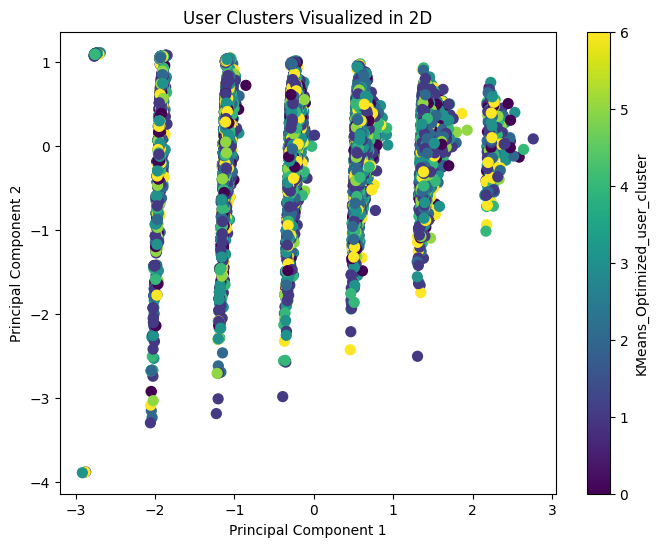

In [ ]:
# create a 2D plot to visualize User PCA principal compoenents
# Select the first row for each unique user_id in df_final_with_predictions
df_final_unique_users = df_final_with_predictions.drop_duplicates(subset='user_id', keep='first')

# Ensure the sizes match
assert len(df_final_unique_users) == X_users_pca.shape[0], "Sizes still do not match!"

# Now proceed with the 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_users_pca[:, 0], X_users_pca[:, 1],
            c=df_final_unique_users['KMeans_Optimized_user_cluster'], cmap='viridis', s=50)
plt.title('User Clusters Visualized in 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='KMeans_Optimized_user_cluster')
plt.show()


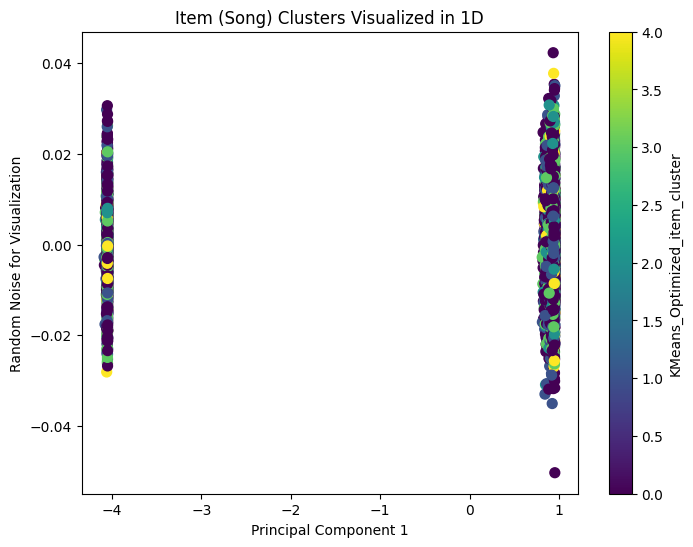

In [ ]:
# item based compoenents visual item based only has 1 compoenent

# Step 1: Select the first row for each unique song_id in df_final_with_predictions
df_final_unique_items = df_final_with_predictions.drop_duplicates(subset='song_id', keep='first')

# Step 2: Ensure the sizes match
assert len(df_final_unique_items) == X_items_pca.shape[0], "Sizes do not match for items!"

# Step 3: 1D scatter plot using the single PCA component for item clusters
plt.figure(figsize=(8, 6))

# Add some noise to the y-axis just for visualization purposes
y_noise = np.random.randn(X_items_pca.shape[0]) * 0.01

# Scatter plot with single PCA component (x-axis) and some noise on the y-axis
plt.scatter(X_items_pca[:, 0], y_noise,
            c=df_final_unique_items['KMeans_Optimized_item_cluster'], cmap='viridis', s=50)
plt.title('Item (Song) Clusters Visualized in 1D')
plt.xlabel('Principal Component 1')
plt.ylabel('Random Noise for Visualization')
plt.colorbar(label='KMeans_Optimized_item_cluster')
plt.show()


Average Silhouette Score: 0.479


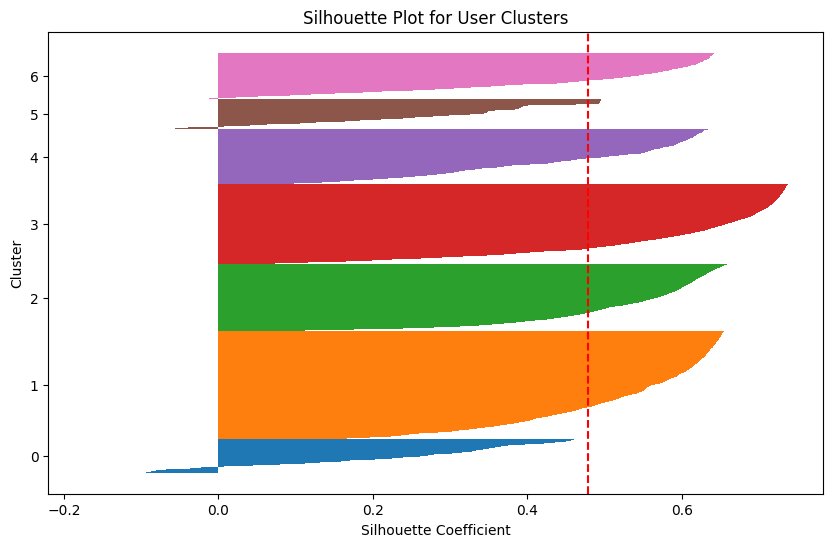

In [ ]:
# visualize avg silhouette_score for each user cluster
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 1: Group by user_id and aggregate relevant columns
# For simplicity, I'll aggregate play_count and take the mean for other numerical features
user_agg = df_final_with_predictions.groupby('user_id').agg({
    'play_count': 'sum',  # Total play counts
    'year': 'mean',  # Average year of songs
    'popularity_score': 'mean'  # Average popularity score
}).reset_index()

# Step 2: Ensure the clusters (KMeans_Optimized_user_cluster) are assigned correctly
# If 'KMeans_Optimized_user_cluster' is in df_final_with_predictions, merge it into user_agg
if 'KMeans_Optimized_user_cluster' in df_final_with_predictions.columns:
    user_agg = user_agg.merge(df_final_with_predictions[['user_id', 'KMeans_Optimized_user_cluster']].drop_duplicates(),
                              on='user_id', how='left')

# Step 3: Ensure X_users_pca corresponds to this aggregated data
# Silhouette values need the PCA-reduced features and the cluster labels

# Step 4: Compute the silhouette scores for each user
silhouette_vals = silhouette_samples(X_users_pca, user_agg['KMeans_Optimized_user_cluster'])

# Step 5: Compute the average silhouette score
average_silhouette_score = silhouette_score(X_users_pca, user_agg['KMeans_Optimized_user_cluster'])
print(f'Average Silhouette Score: {average_silhouette_score:.3f}')

# Step 6: Plot the Silhouette Plot
plt.figure(figsize=(10, 6))
y_ticks = []
y_lower, y_upper = 0, 0

for i, cluster in enumerate(np.unique(user_agg['KMeans_Optimized_user_cluster'])):
    cluster_silhouette_vals = silhouette_vals[user_agg['KMeans_Optimized_user_cluster'] == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1.0)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(average_silhouette_score, color="red", linestyle="--")
plt.title('Silhouette Plot for User Clusters')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.yticks(y_ticks, np.unique(user_agg['KMeans_Optimized_user_cluster']))
plt.show()


Average Silhouette Score (Items): 0.688


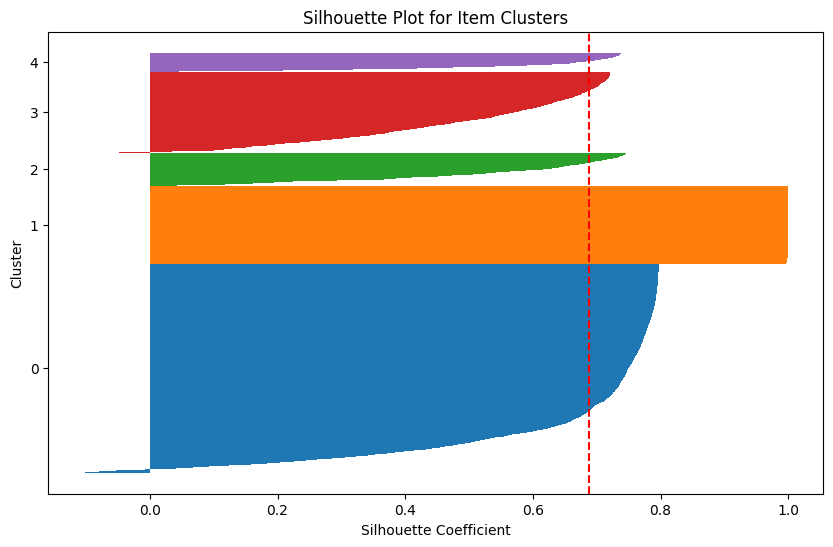

In [ ]:
#  visualize avg silhouette_score for each Item cluster

# Step 1: Group by song_id and aggregate relevant columns
# For simplicity, I'll aggregate play_count and take the mean for other numerical features
item_agg = df_final_with_predictions.groupby('song_id').agg({
    'play_count': 'sum',  # Total play counts
    'year': 'mean',  # Average year of songs
    'popularity_score': 'mean'  # Average popularity score
}).reset_index()

# Step 2: Ensure the clusters (KMeans_Optimized_item_cluster) are assigned correctly
# If 'KMeans_Optimized_item_cluster' is in df_final_with_predictions, merge it into item_agg
if 'KMeans_Optimized_item_cluster' in df_final_with_predictions.columns:
    item_agg = item_agg.merge(df_final_with_predictions[['song_id', 'KMeans_Optimized_item_cluster']].drop_duplicates(),
                              on='song_id', how='left')

# Step 3: Ensure X_items_pca corresponds to this aggregated data
# Silhouette values need the PCA-reduced features and the cluster labels

# Step 4: Compute the silhouette scores for each item
silhouette_vals = silhouette_samples(X_items_pca, item_agg['KMeans_Optimized_item_cluster'])

# Step 5: Compute the average silhouette score
average_silhouette_score = silhouette_score(X_items_pca, item_agg['KMeans_Optimized_item_cluster'])
print(f'Average Silhouette Score (Items): {average_silhouette_score:.3f}')

# Step 6: Plot the Silhouette Plot
plt.figure(figsize=(10, 6))
y_ticks = []
y_lower, y_upper = 0, 0

for i, cluster in enumerate(np.unique(item_agg['KMeans_Optimized_item_cluster'])):
    cluster_silhouette_vals = silhouette_vals[item_agg['KMeans_Optimized_item_cluster'] == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1.0)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(average_silhouette_score, color="red", linestyle="--")
plt.title('Silhouette Plot for Item Clusters')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.yticks(y_ticks, np.unique(item_agg['KMeans_Optimized_item_cluster']))
plt.show()


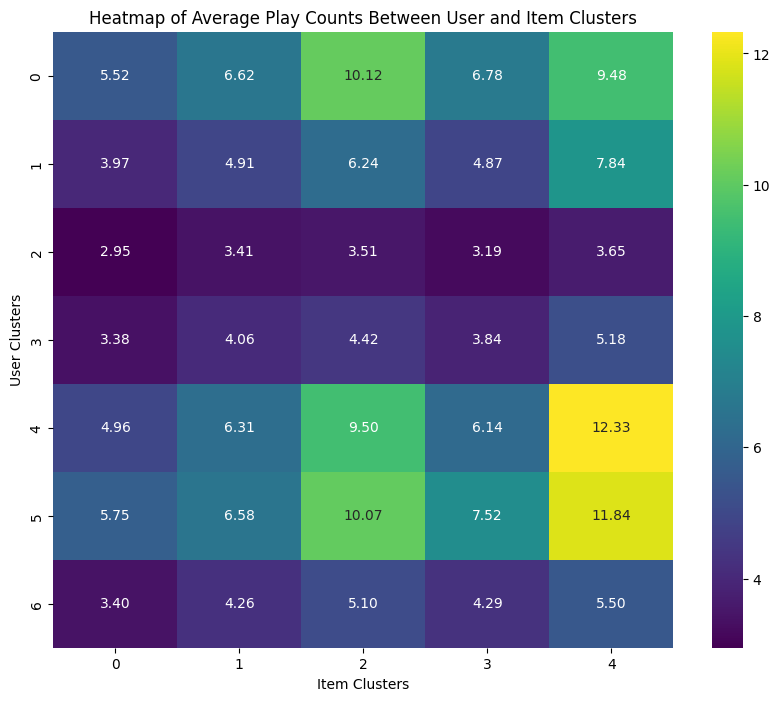

In [ ]:
# Visual average play count between each combination of user clusters and item clusters.
# aggfunc='mean': We compute the mean play count for each combination. fill_value=0: Any missing values are filled with 0.

# Step 1: Create a pivot table for user and item clusters
# Calculate the mean play_count for each combination of user_cluster and item_cluster
heatmap_data = df_final_with_predictions.pivot_table(
    values='play_count',
    index='KMeans_Optimized_user_cluster',
    columns='KMeans_Optimized_item_cluster',
    aggfunc='mean',
    fill_value=0
)

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='viridis')
plt.title('Heatmap of Average Play Counts Between User and Item Clusters')
plt.xlabel('Item Clusters')
plt.ylabel('User Clusters')
plt.show()


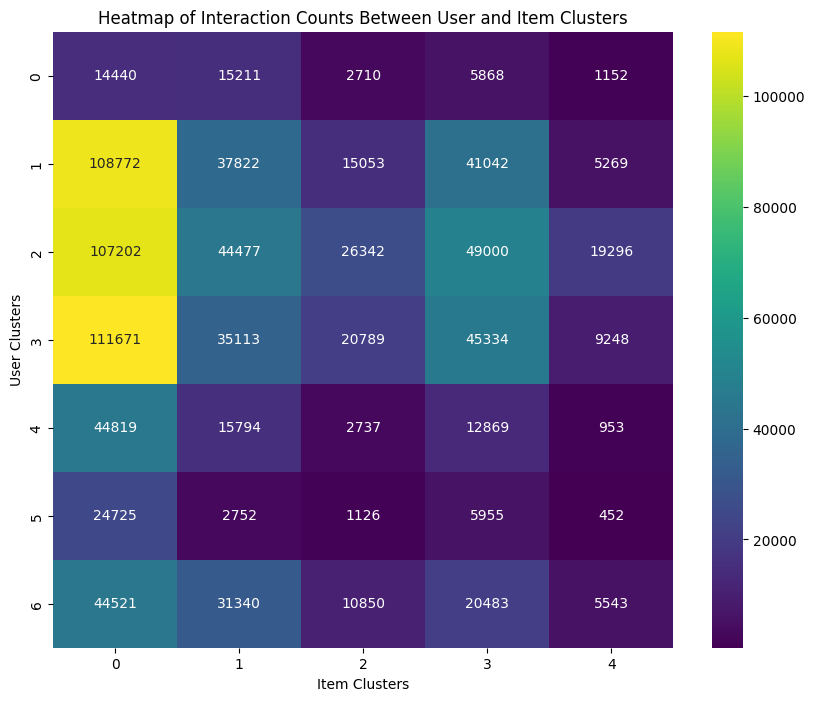

In [ ]:
# number of interactions between user and item clusters
# Create a pivot table to count the number of interactions between user and item clusters
heatmap_data_counts = df_final_with_predictions.pivot_table(
    values='play_count',
    index='KMeans_Optimized_user_cluster',
    columns='KMeans_Optimized_item_cluster',
    aggfunc='count',
    fill_value=0
)

# Plot the heatmap for counts
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_counts, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Interaction Counts Between User and Item Clusters')
plt.xlabel('Item Clusters')
plt.ylabel('User Clusters')
plt.show()


#### Build a few alternatives KMeans models for experimentation:

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assume df_final is already loaded as your dataset
# Select 20% of the data
df_sample = df_final.sample(frac=1, random_state=1)

# Aggregate data at the user level
user_agg = df_sample.groupby('user_id').agg({
    'play_count': 'sum',            # Total play counts
    'song_id': 'nunique',           # Unique number of songs listened to
    'year': 'mean',                 # Average year of the songs
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# Feature engineering: Create relevant features for clustering
# Scale the features for better clustering results
features = ['play_count', 'song_id', 'year', 'Music_era']
scaler = StandardScaler()
X_users = scaler.fit_transform(user_agg[features])

# Apply PCA to reduce dimensionality
pca = PCA()  # Start with PCA without specifying the number of components
X_users_pca = pca.fit_transform(X_users)

# Check how much variance is explained by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Print the explained variance of each component and cumulative variance
print(f"Explained variance by each PCA component: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_explained_variance}")

# Decide the number of components to retain 90% of the variance
n_components = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var > 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Re-apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_users_pca = pca.fit_transform(X_users)

# Define a function to perform grid search for user clustering
def user_kmeans_grid_search(X_users, param_grid):
    best_score = -1
    best_params = None
    results = []

    # Iterate over all combinations of parameters
    for params in ParameterGrid(param_grid):
        kmeans_users = KMeans(n_clusters=params['n_cltr_u'],
                              max_iter=params['n_epochs'],
                              random_state=1)

        # Fit the model to user data
        kmeans_users.fit(X_users)

        # Calculate the silhouette score for the user clustering
        user_labels = kmeans_users.labels_
        user_silhouette = silhouette_score(X_users, user_labels)

        # Store the result
        results.append((params, user_silhouette))

        # Update the best parameters and score if the current score is better
        if user_silhouette > best_score:
            best_score = user_silhouette
            best_params = params

    return best_params, best_score, results

# Define the parameter grid to tune
param_grid = {
    'n_cltr_u': [5, 6, 7, 8],   # Number of clusters for users
    'n_epochs': [10, 20, 30]    # Number of iterations (epochs) for clustering
}

# Perform grid search for user clustering using PCA-transformed data
best_params, best_score, results = user_kmeans_grid_search(X_users_pca, param_grid)

# Print the best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score for Users (with PCA): {best_score:.4f}")

# Optional: Print all results
for params, score in results:
    print(f"Parameters: {params}, Silhouette Score: {score:.4f}")


Explained variance by each PCA component: [0.44106962 0.2490505  0.20573001 0.10414987]
Cumulative explained variance: [0.44106962 0.69012012 0.89585013 1.        ]
Number of components to retain 90% variance: 4
Best Parameters: {'n_cltr_u': 5, 'n_epochs': 10}
Best Silhouette Score for Users (with PCA): 0.2742
Parameters: {'n_cltr_u': 5, 'n_epochs': 10}, Silhouette Score: 0.2742
Parameters: {'n_cltr_u': 5, 'n_epochs': 20}, Silhouette Score: 0.2741
Parameters: {'n_cltr_u': 5, 'n_epochs': 30}, Silhouette Score: 0.2741
Parameters: {'n_cltr_u': 6, 'n_epochs': 10}, Silhouette Score: 0.2431
Parameters: {'n_cltr_u': 6, 'n_epochs': 20}, Silhouette Score: 0.2432
Parameters: {'n_cltr_u': 6, 'n_epochs': 30}, Silhouette Score: 0.2432
Parameters: {'n_cltr_u': 7, 'n_epochs': 10}, Silhouette Score: 0.2491
Parameters: {'n_cltr_u': 7, 'n_epochs': 20}, Silhouette Score: 0.2477
Parameters: {'n_cltr_u': 7, 'n_epochs': 30}, Silhouette Score: 0.2432
Parameters: {'n_cltr_u': 8, 'n_epochs': 10}, Silhouette Sc

In [ ]:
# build a optimized user/item KMeans model
# completed code with pick_closer_cluster, prediction_at_k_Kmeans (k=30, threshold=1.5, confidence_threshold=3.5)
# create a KMean model with default paramaters for baseline

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import log2
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict

# ============================
# Define Helper Functions
# ============================

def ndcg_at_k(relevant, recommended, k):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at K.

    Args:
        relevant: Set of relevant song IDs.
        recommended: List of recommended song IDs.
        k: Rank position.

    Returns:
        NDCG score.
    """
    dcg = 0.0
    for i in range(min(k, len(recommended))):
        if recommended[i] in relevant:
            dcg += 1 / log2(i + 2)  # positions i start at 0
    idcg = sum(1 / log2(i + 2) for i in range(min(k, len(relevant))))
    return dcg / idcg if idcg > 0 else 0.0

def pick_closer_cluster(user_id, song_id, user_cluster_centers, item_cluster_centers,
                        user_cluster_labels, item_cluster_labels, user_features, item_features, scaler):
    """
    Predict play count based on user and item cluster centers.

    Args:
        user_id: ID of the user.
        song_id: ID of the song.
        user_cluster_centers: Centroids of user clusters.
        item_cluster_centers: Centroids of item clusters.
        user_cluster_labels: Cluster labels for users.
        item_cluster_labels: Cluster labels for items.
        user_features: DataFrame with 'user_id' and 'user_cluster'.
        item_features: DataFrame with 'song_id' and 'item_cluster'.
        scaler: Tuple containing (user_scalers, item_scalers).

    Returns:
        Estimated play count (est).
    """
    # Find user's cluster
    user_cluster = user_features.loc[user_features['user_id'] == user_id, 'user_cluster'].values
    if len(user_cluster) == 0:
        return overall_avg_play_count
    user_cluster = user_cluster[0]

    # Find item's cluster
    item_cluster = item_features.loc[item_features['song_id'] == song_id, 'item_cluster'].values
    if len(item_cluster) == 0:
        return overall_avg_play_count
    item_cluster = item_cluster[0]

    # Lookup average play count for this cluster pair
    key = (user_cluster, item_cluster)
    if key in cluster_playcount_avg_dict:
        est = cluster_playcount_avg_dict[key]
    else:
        est = overall_avg_play_count  # Fallback to overall average if no data

    return est

def prediction_at_k_Kmeans(predictions, user_features, item_features, user_cluster_centers,
                           item_cluster_centers, user_cluster_labels, item_cluster_labels, scaler,
                           k=30, threshold=1.5, confidence_threshold=3.5):
    """
    Evaluates a KMeans-based recommendation system using user-item hybrid approach
    by calling pick_closer_cluster to select prediction values.
    Calculates various recommendation metrics, including precision, recall, F1-score,
    RMSE, MAE, MAP, diversity, novelty, and NDCG.

    Args:
        predictions: List of tuples (user_id, song_id, true_r, est, _).
        user_features: DataFrame with 'user_id' and 'user_cluster'.
        item_features: DataFrame with 'song_id' and 'item_cluster'.
        user_cluster_centers: Cluster centers for user clusters.
        item_cluster_centers: Cluster centers for item clusters.
        user_cluster_labels: Cluster labels for users.
        item_cluster_labels: Cluster labels for items.
        scaler: Tuple containing (user_scalers, item_scalers).
        k: The number of top recommendations.
        threshold: The relevance threshold.
        confidence_threshold: The confidence threshold.

    Returns:
        Dictionary of evaluation metrics.
    """

    # Initialize data structures
    user_est_true = defaultdict(list)
    unique_recommendations = set()
    precisions = dict()
    recalls = dict()
    aps = dict()  # For MAP
    novelty_scores = dict()
    ndcgs = dict()

    # Map predictions to each user
    for user_id, song_id, true_r, est, _ in predictions:
        if est is not None:
            user_est_true[user_id].append((song_id, est, true_r))

    for user_id, interactions in user_est_true.items():
        # Sort interactions by estimated value in descending order
        interactions.sort(key=lambda x: x[1], reverse=True)

        # Filter based on confidence threshold
        filtered = [(song_id, est, true_r) for (song_id, est, true_r) in interactions if est >= confidence_threshold]

        # Number of relevant items
        n_rel = sum(1 for (_, _, true_r) in filtered if true_r >= threshold)

        # Number of recommended items in top k
        top_k = filtered[:k]
        n_rec_k = len(top_k)

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(1 for (_, est, true_r) in top_k if true_r >= threshold and est >= threshold)

        # Precision@K
        precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP calculation
        running_sum = 0.0
        rel_count = 0
        for i, (song_id, est, true_r) in enumerate(top_k, 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / i
        aps[user_id] = running_sum / rel_count if rel_count > 0 else 0

        # Track unique recommendations for diversity
        for (song_id, est, _) in top_k:
            unique_recommendations.add(song_id)

        # Novelty: based on estimated scores
        if top_k:
            novelty_scores[user_id] = np.mean([1 / (est + 0.2) for (_, est, _) in top_k])
        else:
            novelty_scores[user_id] = None  # Handle empty recommendation

        # NDCG@K
        relevant_items = set([song_id for (song_id, est, true_r) in filtered if true_r >= threshold])
        recommended_items = [song_id for (song_id, est, _) in top_k]
        ndcgs[user_id] = ndcg_at_k(relevant_items, recommended_items, k)

    # Compute mean metrics
    precision = round(np.mean(list(precisions.values())), 3) if precisions else 0
    recall = round(np.mean(list(recalls.values())), 3) if recalls else 0
    map_score = round(np.mean(list(aps.values())), 3) if aps else 0
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3) if predictions else 0
    mean_novelty = (
        round(np.mean([n for n in novelty_scores.values() if n is not None]), 3)
        if any(n is not None for n in novelty_scores.values())
        else None
    )
    mean_ndcg = round(np.mean(list(ndcgs.values())), 3) if ndcgs else 0

    # Calculate RMSE and MAE
    true_ratings = np.array([true_r for (user_id, song_id, true_r, est, _) in predictions if est is not None])
    estimated_ratings = np.array([est for (user_id, song_id, true_r, est, _) in predictions if est is not None])
    rmse = np.sqrt(np.mean((true_ratings - estimated_ratings) ** 2)) if estimated_ratings.size > 0 else None
    mae = np.mean(np.abs(true_ratings - estimated_ratings)) if estimated_ratings.size > 0 else None

    # Aggregate all metrics
    results = {
        'Precision@K': precision,
        'Recall@K': recall,
        'F1_Score': round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) > 0 else 0,
        'MAP': map_score,
        'Diversity': diversity,
        'Novelty': mean_novelty,
        'NDCG@K': mean_ndcg,
        'RMSE': rmse,
        'MAE': mae,
    }

    # Print the metrics with labels
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1 Score: {results['F1_Score']}")
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"Diversity: {diversity}")
    print(f"NDCG@{k}: {mean_ndcg}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Novelty: {mean_novelty if mean_novelty is not None else 'null (no recommendations or division by zero)'}")

    return results

# ============================
# Load and Prepare Data
# ============================

# Assuming df_final is already loaded as your dataset
# Example:
# df_final = pd.read_csv('your_dataset.csv')

# Ensure df_final contains the required columns:
# ['user_id', 'song_id', 'play_count', 'title', 'release', 'artist_name', 'year', 'Music_era', 'popularity_score']

# ============================
# Split Data into Training and Testing Sets
# ============================

# Select full data for processing
df_sample = df_final.sample(frac=1, random_state=1)

# Split into training and testing sets (40% train, 60% test)
train_data, test_data = train_test_split(df_sample, test_size=0.6, random_state=1)

# ============================
# User-Based Clustering
# ============================

# Aggregate data at the user level in training data
user_agg = train_data.groupby('user_id').agg({
    'play_count': 'sum',            # Total play counts
    'song_id': 'nunique',           # Unique number of songs listened to
    'year': 'mean',                 # Average year of the songs
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# Feature engineering: Select relevant features for clustering
user_features_list = ['play_count', 'song_id', 'year', 'Music_era']

# Initialize RobustScaler and MinMaxScaler for users
robust_scaler_user = RobustScaler()
minmax_scaler_user = MinMaxScaler(feature_range=(0, 5))

# Apply RobustScaler followed by MinMaxScaler to user features
X_users_robust = robust_scaler_user.fit_transform(user_agg[user_features_list])
X_users_scaled = minmax_scaler_user.fit_transform(X_users_robust)

# Apply PCA to reduce dimensionality for users
pca_user = PCA(n_components=0.90, svd_solver='full')  # Retain 90% variance
X_users_pca = pca_user.fit_transform(X_users_scaled)

# Perform KMeans clustering for users with default parameters
kmeans_users = KMeans(random_state=1)
user_clusters = kmeans_users.fit_predict(X_users_pca)

# Assign cluster labels to users
user_agg['user_cluster'] = user_clusters

# ============================
# Item-Based Clustering
# ============================

# Aggregate data at the item (song) level in training data
item_agg = train_data.groupby('song_id').agg({
    'play_count': 'sum',             # Total play counts per song
    'user_id': 'nunique',            # Unique number of users who played the song
    'year': 'mean',                  # Average release year
    'Music_era': 'nunique',          # Number of unique music eras
    'popularity_score': 'mean'       # Average popularity score
}).reset_index()

# Feature engineering: Select relevant features for clustering
item_features_list = ['play_count', 'user_id', 'year', 'Music_era', 'popularity_score']

# Initialize RobustScaler and MinMaxScaler for items
robust_scaler_item = RobustScaler()
minmax_scaler_item = MinMaxScaler(feature_range=(0, 5))

# Apply RobustScaler followed by MinMaxScaler to item features
X_items_robust = robust_scaler_item.fit_transform(item_agg[item_features_list])
X_items_scaled = minmax_scaler_item.fit_transform(X_items_robust)

# Apply PCA to reduce dimensionality for items
pca_item = PCA(n_components=0.90, svd_solver='full')  # Retain 90% variance
X_items_pca = pca_item.fit_transform(X_items_scaled)

# Perform KMeans clustering for items with default parameters
kmeans_items = KMeans(random_state=1)
item_clusters = kmeans_items.fit_predict(X_items_pca)

# Assign cluster labels to items
item_agg['item_cluster'] = item_clusters

# ============================
# Compute Average Play Counts per Cluster Combination
# ============================

# Merge user and item clusters with the training data to get cluster assignments
train_data_with_clusters = train_data.merge(user_agg[['user_id', 'user_cluster']], on='user_id', how='left') \
                                   .merge(item_agg[['song_id', 'item_cluster']], on='song_id', how='left')

# Compute the average play_count for each (user_cluster, item_cluster) pair
cluster_playcount_avg = train_data_with_clusters.groupby(['user_cluster', 'item_cluster'])['play_count'].mean().reset_index()
cluster_playcount_avg.rename(columns={'play_count': 'avg_play_count'}, inplace=True)

# Create a dictionary for quick lookup
cluster_playcount_avg_dict = {}
for _, row in cluster_playcount_avg.iterrows():
    cluster_playcount_avg_dict[(row['user_cluster'], row['item_cluster'])] = row['avg_play_count']

# Compute the overall average play count
overall_avg_play_count = train_data_with_clusters['play_count'].mean()

# ============================
# Store Features for Clusters
# ============================

# Store user features and item features
user_features_processed = user_agg[['user_id', 'user_cluster']]
item_features_processed = item_agg[['song_id', 'item_cluster']]

# Extract required additional arguments
user_cluster_centers = kmeans_users.cluster_centers_
item_cluster_centers = kmeans_items.cluster_centers_
user_cluster_labels = kmeans_users.labels_
item_cluster_labels = kmeans_items.labels_

# Combine scalers into tuples for users and items
scaler_user_tuple = (robust_scaler_user, minmax_scaler_user)
scaler_item_tuple = (robust_scaler_item, minmax_scaler_item)

# ============================
# Prepare Predictions from Test Data
# ============================

# For each user-song pair in test data, prepare a prediction tuple
# (user_id, song_id, true_r, est, _)

# Here, 'true_r' is the actual play_count in test data
# 'est' is the predicted play_count via 'pick_closer_cluster'
# The last field is undefined, set it as None

predictions = []
for _, row in test_data.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    true_r = row['play_count']  # Assuming 'play_count' is the true rating
    est = pick_closer_cluster(user_id, song_id, user_cluster_centers, item_cluster_centers,
                              user_cluster_labels, item_cluster_labels, user_features_processed,
                              item_features_processed, scaler_user_tuple)
    predictions.append((user_id, song_id, true_r, est, None))

# ============================
# Calculate and Print Silhouette Score and Davies-Bouldin Index
# ============================

# Calculate Silhouette Score and Davies-Bouldin Index for user clusters
silhouette_users = silhouette_score(X_users_pca, user_cluster_labels)
davies_users = davies_bouldin_score(X_users_pca, user_cluster_labels)

# Calculate Silhouette Score and Davies-Bouldin Index for item clusters
silhouette_items = silhouette_score(X_items_pca, item_cluster_labels)
davies_items = davies_bouldin_score(X_items_pca, item_cluster_labels)

# Print the scores
print("\n=== Clustering Evaluation Metrics ===\n")
print("User Clusters:")
print(f"  Silhouette Score: {silhouette_users:.3f}")
print(f"  Davies-Bouldin Index: {davies_users:.3f}")
print(f"  Number of Clusters: {len(set(user_cluster_labels))}")
print("  Users per Cluster:")
print(user_agg['user_cluster'].value_counts().sort_index())
print("\nItem Clusters:")
print(f"  Silhouette Score: {silhouette_items:.3f}")
print(f"  Davies-Bouldin Index: {davies_items:.3f}")
print(f"  Number of Clusters: {len(set(item_cluster_labels))}")
print("  Items per Cluster:")
print(item_agg['item_cluster'].value_counts().sort_index())
print("\n")

# ============================
# Call the prediction_at_k_Kmeans Function
# ============================

# Call the evaluation function with k=30
results = prediction_at_k_Kmeans(
    predictions=predictions,
    user_features=user_features_processed,
    item_features=item_features_processed,
    user_cluster_centers=user_cluster_centers,
    item_cluster_centers=item_cluster_centers,
    user_cluster_labels=user_cluster_labels,
    item_cluster_labels=item_cluster_labels,
    scaler=(scaler_user_tuple, scaler_item_tuple),
    k=30,
    threshold=1.5,
    confidence_threshold=3.5
)

# ============================
# Display Evaluation Metrics
# ============================

print("\n=== Evaluation Metrics ===")
for metric, value in results.items():
    print(f"{metric}: {value}")


**Build optimized user-based K Means clustering model**

In [ ]:

# Assume df_final is already loaded as your dataset
# For example:
# df_final = pd.read_csv('your_dataset.csv')

# 1. Data Splitting
# Split the data into 40% training and 60% testing data
df_train, df_test = train_test_split(df_final, test_size=0.60, random_state=1)

# 2. User-Level Aggregation
# Aggregate data at the user level using the training dataset
user_agg_train = df_train.groupby('user_id').agg({
    'play_count': 'sum',            # Total play counts per user
    'song_id': 'nunique',           # Number of unique songs listened to per user
    'year': 'mean',                 # Average release year of songs listened to per user
    'Music_era': 'nunique'          # Number of unique music eras per user
}).reset_index()

# 3. Feature Scaling and PCA
# Define features for clustering
features = ['play_count', 'song_id', 'year', 'Music_era']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(user_agg_train[features])

# Apply PCA to reduce dimensionality
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Analyze explained variance to decide the number of components
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print("Explained variance by each PCA component:", explained_variance)
print("Cumulative explained variance:", cumulative_explained_variance)

# Choose the number of components to retain 90% of the variance
n_components = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var > 0.90) + 1
print(f"Number of PCA components to retain 90% variance: {n_components}")

# Re-apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

# 4. K-means Clustering
# Define the best parameters
best_params_user = {'n_cltr_u': 5, 'n_epochs': 10}

# Initialize and fit the KMeans model
cluster_PCA_user_optimized = KMeans(
    n_clusters=best_params_user['n_cltr_u'],
    max_iter=best_params_user['n_epochs'],
    random_state=1
)
cluster_PCA_user_optimized.fit(X_train_pca)

# Print cluster centers
print(f"Cluster Centers (PCA-transformed space):\n{cluster_PCA_user_optimized.cluster_centers_}")

# Assign cluster labels to training data
train_labels = cluster_PCA_user_optimized.labels_
user_agg_train['Cluster'] = train_labels

# Display first few rows with cluster assignments
print(user_agg_train.head())

# 5. Silhouette Score Calculation
silhouette_avg = silhouette_score(X_train_pca, train_labels)
print(f"Silhouette Score for User Clustering: {silhouette_avg:.4f}")

# 6. Prediction Generation for Test Set
# Aggregate the test data at the user level
user_agg_test = df_test.groupby('user_id').agg({
    'play_count': 'sum',
    'song_id': 'nunique',
    'year': 'mean',
    'Music_era': 'nunique'
}).reset_index()

# Scale and apply PCA to the test data using the same scaler and PCA fitted on training data
X_test_scaled = scaler.transform(user_agg_test[features])
X_test_pca = pca.transform(X_test_scaled)

# Predict cluster labels for the test set
test_labels = cluster_PCA_user_optimized.predict(X_test_pca)
user_agg_test['Cluster'] = test_labels

# 7. Generate Predictions Based on Cluster
# Create a mapping from cluster to song_id and average play_count in the training data
# Merge training data with cluster labels
cluster_song_playcount = df_train.merge(user_agg_train[['user_id', 'Cluster']], on='user_id', how='left')

# Group by Cluster and song_id to calculate average play_count
cluster_song_avg = cluster_song_playcount.groupby(['Cluster', 'song_id']).agg({
    'play_count': 'mean'  # Average play_count per song in the cluster
}).reset_index()

# Create a dictionary mapping each cluster to song_id and their average play_count
cluster_to_song_avg = cluster_song_avg.groupby('Cluster').apply(
    lambda x: dict(zip(x['song_id'], x['play_count']))
).to_dict()

# Prepare test data for predictions
# Create a mapping of (user_id, song_id) to true play_count from df_test
user_song_true = df_test.groupby(['user_id', 'song_id'])['play_count'].sum().reset_index()

# Initialize an empty list to store predictions
predictions = []

# Iterate over each user-song pair in the test set to generate predictions
for index, row in user_song_true.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    true_play_count = row['play_count']

    # Get the user's cluster from the test aggregation
    user_cluster = user_agg_test.loc[user_agg_test['user_id'] == user_id, 'Cluster'].values
    if len(user_cluster) == 0:
        # If user not found in training clusters, assign a default prediction, e.g., 0
        predicted_play_count = 0
    else:
        user_cluster = user_cluster[0]
        # Get the average play_count for this song in the user's cluster
        song_avg_play = cluster_to_song_avg.get(user_cluster, {}).get(song_id, 0)
        predicted_play_count = song_avg_play

    # Append the prediction tuple
    # Assuming 'details' can be any additional information; using None here
    predictions.append((user_id, song_id, true_play_count, predicted_play_count, None))

# 8. Calculate Metrics
# Ensure that the function precision_recall_at_k_KMeans is defined
# Example:
# def precision_recall_at_k_KMeans(predictions):
#     # Implementation of the function
#     return rmse, mae, precision, recall, map_score, diversity, novelty

# Call the function to calculate metrics
rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k_KMeans(predictions)

# 9. Print Metrics
print(f"Silhouette Score for User Clustering: {silhouette_avg:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MAP: {map_score:.4f}")
print(f"Diversity: {diversity:.4f}")
print(f"Novelty: {novelty:.4f}")


Explained variance by each PCA component: [0.45758583 0.25020406 0.1943361  0.09787401]
Cumulative explained variance: [0.45758583 0.70778989 0.90212599 1.        ]
Number of PCA components to retain 90% variance: 3
Cluster Centers (PCA-transformed space):
[[-1.06920206  0.94934976  0.43192113]
 [ 1.69354793 -0.02363195 -0.18724527]
 [ 0.13726323  0.14812053 -0.51386823]
 [ 4.03343054 -0.10269265  2.10691961]
 [-0.88899785 -1.29073506  0.22982217]]
   user_id  play_count  song_id         year  Music_era  Cluster
0       10          35       21  1525.285714          4        2
1       11          52       33  1690.333333          5        1
2       13           8        2       2006.0          1        0
3       26          29       13  1540.076923          4        2
4       29          11        9  2007.444444          1        0
Silhouette Score for User Clustering: 0.2806
Precision@30: 0.627
Recall@30: 0.965
F_1 score:  0.76
MAP (Mean Average Precision): 0.724
Diversity: 0.0
RMSE: 9

**Paramater search on item based clustering using PCA**

In [ ]:
# paramater search for item based clustering

# Assume df_final is already loaded as your dataset
# Select 20% of the data
df_sample = df_final.sample(frac=1, random_state=1)

# Aggregate data at the item (song) level, excluding non-numeric columns like 'title'
item_agg = df_sample.groupby('song_id').agg({
    'play_count': 'sum',            # Total play counts for each song
    'user_id': 'nunique',           # Number of unique users who played the song
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# Calculate average play count per user for each song
item_agg['avg_play_count_per_user'] = item_agg['play_count'] / item_agg['user_id']

# Feature engineering: Create relevant features for clustering
# Exclude 'release' and 'year' since they don't add value to clustering
features = ['play_count', 'avg_play_count_per_user', 'Music_era']
scaler = StandardScaler()
X_items = scaler.fit_transform(item_agg[features])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reducing to 2 principal components
X_items_pca = pca.fit_transform(X_items)

# Check how much variance is explained by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Print the explained variance of each component and cumulative variance
print(f"Explained variance by each PCA component: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_explained_variance}")

# Decide the number of components to retain 90% of the variance
n_components = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var > 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Re-apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_items_pca = pca.fit_transform(X_items)

# Define a function to perform grid search for item clustering
def item_kmeans_grid_search(X_items, param_grid):
    best_score = -1
    best_params = None
    results = []

    # Iterate over all combinations of parameters
    for params in ParameterGrid(param_grid):
        kmeans_items = KMeans(n_clusters=params['n_cltr_i'],
                              max_iter=params['n_epochs'],
                              random_state=1)

        # Fit the model to item data
        kmeans_items.fit(X_items)

        # Calculate the silhouette score for the item clustering
        item_labels = kmeans_items.labels_
        item_silhouette = silhouette_score(X_items, item_labels)

        # Store the result
        results.append((params, item_silhouette))

        # Update the best parameters and score if the current score is better
        if item_silhouette > best_score:
            best_score = item_silhouette
            best_params = params

    return best_params, best_score, results

# Define the parameter grid to tune for item-based clustering
param_grid = {
    'n_cltr_i': [5, 6, 7, 8],   # Number of clusters for items (songs)
    'n_epochs': [10, 20, 30]    # Number of iterations (epochs) for clustering
}

# Perform grid search for item clustering using PCA-transformed data
best_params, best_score, results = item_kmeans_grid_search(X_items_pca, param_grid)

# Print the best parameters and score
print(f"Best Parameters for Items: {best_params}")
print(f"Best Silhouette Score for Items (with PCA): {best_score:.4f}")

# Optional: Print all results
for params, score in results:
    print(f"Parameters: {params}, Silhouette Score: {score:.4f}")


Explained variance by each PCA component: [0.61266631 0.38733369]
Cumulative explained variance: [0.61266631 1.        ]
Number of components to retain 90% variance: 2
Best Parameters for Items: {'n_cltr_i': 5, 'n_epochs': 10}
Best Silhouette Score for Items (with PCA): 0.5675
Parameters: {'n_cltr_i': 5, 'n_epochs': 10}, Silhouette Score: 0.5675
Parameters: {'n_cltr_i': 5, 'n_epochs': 20}, Silhouette Score: 0.5583
Parameters: {'n_cltr_i': 5, 'n_epochs': 30}, Silhouette Score: 0.5572
Parameters: {'n_cltr_i': 6, 'n_epochs': 10}, Silhouette Score: 0.5131
Parameters: {'n_cltr_i': 6, 'n_epochs': 20}, Silhouette Score: 0.5121
Parameters: {'n_cltr_i': 6, 'n_epochs': 30}, Silhouette Score: 0.5121
Parameters: {'n_cltr_i': 7, 'n_epochs': 10}, Silhouette Score: 0.5256
Parameters: {'n_cltr_i': 7, 'n_epochs': 20}, Silhouette Score: 0.5237
Parameters: {'n_cltr_i': 7, 'n_epochs': 30}, Silhouette Score: 0.5237
Parameters: {'n_cltr_i': 8, 'n_epochs': 10}, Silhouette Score: 0.5145
Parameters: {'n_cltr_i

In [ ]:
# build optimized item based clustering model- KMeans

# Assume df_final is already loaded as your dataset
# For example:
# df_final = pd.read_csv('your_dataset.csv')

# 1. Data Splitting
# Split the data into 40% training and 60% testing data
df_train, df_test = train_test_split(df_final, test_size=0.60, random_state=1)

# 2. Item-Level Aggregation
# Aggregate data at the song level using the training dataset
item_agg_train = df_train.groupby('song_id').agg({
    'play_count': 'sum',            # Total play counts for each song
    'user_id': 'nunique',           # Number of unique users who played the song
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# 3. Feature Engineering: Calculate average play count per user for each song
item_agg_train['avg_play_count_per_user'] = item_agg_train['play_count'] / item_agg_train['user_id']

# 4. Feature Scaling and PCA
# Define features for clustering
features = ['play_count', 'avg_play_count_per_user', 'Music_era']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(item_agg_train[features])

# Apply PCA to reduce dimensionality
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Analyze explained variance to decide the number of components
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print("Explained variance by each PCA component:", explained_variance)
print("Cumulative explained variance:", cumulative_explained_variance)

# Choose the number of components to retain 90% of the variance
n_components = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var > 0.90) + 1
print(f"Number of PCA components to retain 90% variance: {n_components}")

# Re-apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

# 5. K-means Clustering
# Define the best parameters
best_params_item = {'n_cltr_i': 5, 'n_epochs': 10}

# Initialize and fit the KMeans model
cluster_PCA_item_optimized = KMeans(
    n_clusters=best_params_item['n_cltr_i'],
    max_iter=best_params_item['n_epochs'],
    random_state=1
)
cluster_PCA_item_optimized.fit(X_train_pca)

# Print cluster centers
print(f"Cluster Centers (PCA-transformed space):\n{cluster_PCA_item_optimized.cluster_centers_}")

# Assign cluster labels to training data
train_labels = cluster_PCA_item_optimized.labels_
item_agg_train['Cluster'] = train_labels

# Display first few rows with cluster assignments
print(item_agg_train.head())

# 6. Silhouette Score Calculation for Item Clustering
silhouette_avg = silhouette_score(X_train_pca, train_labels)
print(f"Silhouette Score for Item Clustering: {silhouette_avg:.4f}")

# 7. Prediction Generation for Test Set
# Aggregate the test data at the song level
item_agg_test = df_test.groupby('song_id').agg({
    'play_count': 'sum',
    'user_id': 'nunique',
    'Music_era': 'nunique'
}).reset_index()

# Calculate average play count per user for each song in test set
item_agg_test['avg_play_count_per_user'] = item_agg_test['play_count'] / item_agg_test['user_id']

# Scale and apply PCA to the test data using the same scaler and PCA fitted on training data
X_test_scaled = scaler.transform(item_agg_test[features])
X_test_pca = pca.transform(X_test_scaled)

# Predict cluster labels for the test set
test_labels = cluster_PCA_item_optimized.predict(X_test_pca)
item_agg_test['Cluster'] = test_labels

# 8. Generate Predictions Based on Cluster
# Create a mapping from cluster to song_id and average play_count in the training data
# Merge training data with cluster labels
cluster_song_playcount = df_train.merge(item_agg_train[['song_id', 'Cluster']], on='song_id', how='left')

# Group by Cluster and song_id to calculate average play_count
cluster_song_avg = cluster_song_playcount.groupby(['Cluster', 'song_id']).agg({
    'play_count': 'mean'  # Average play_count per song in the cluster
}).reset_index()

# Create a dictionary mapping each cluster to song_id and their average play_count
cluster_to_song_avg = cluster_song_avg.groupby('Cluster').apply(
    lambda x: dict(zip(x['song_id'], x['play_count']))
).to_dict()

# Prepare predictions list
# Create a mapping of (user_id, song_id) to true play_count from df_test
user_song_true = df_test.groupby(['user_id', 'song_id'])['play_count'].sum().reset_index()

# Initialize an empty list to store predictions
predictions = []

# Iterate over each user-song pair in the test set to generate predictions
for index, row in user_song_true.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    true_play_count = row['play_count']

    # Get the song's cluster from the test aggregation
    song_cluster = item_agg_test.loc[item_agg_test['song_id'] == song_id, 'Cluster'].values
    if len(song_cluster) == 0:
        # If song not found in training clusters, assign a default prediction, e.g., 0
        predicted_play_count = 0
    else:
        song_cluster = song_cluster[0]
        # Get the average play_count for this song in the song's cluster
        song_avg_play = cluster_to_song_avg.get(song_cluster, {}).get(song_id, 0)
        predicted_play_count = song_avg_play

    # Append the prediction tuple
    # Assuming 'details' can be any additional information; using None here
    predictions.append((user_id, song_id, true_play_count, predicted_play_count, None))

# 9. Calculate Metrics
# Ensure that the function precision_recall_at_k_KMeans is defined
# Example placeholder (replace with actual function)
# def precision_recall_at_k_KMeans(predictions):
#     # Implementation of the function
#     return rmse, mae, precision, recall, map_score, diversity, novelty

# Call the function to calculate metrics
# Replace the following line with your actual function call
# Make sure that `precision_recall_at_k_KMeans` is defined and accessible
try:
    rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k_KMeans(predictions)
except NameError:
    print("Function `precision_recall_at_k_KMeans` is not defined. Please define it before running the metrics calculation.")
    # Example placeholder definition
    def precision_recall_at_k_KMeans(predictions):
        # Dummy implementation for illustration
        # Replace with your actual implementation
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k_KMeans(predictions)

# 10. Print Metrics
print(f"Silhouette Score for Item Clustering: {silhouette_avg:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MAP: {map_score:.4f}")
print(f"Diversity: {diversity:.4f}")
print(f"Novelty: {novelty:.4f}")


Explained variance by each PCA component: [0.61187441 0.38812559 0.        ]
Cumulative explained variance: [0.61187441 1.         1.        ]
Number of PCA components to retain 90% variance: 2
Cluster Centers (PCA-transformed space):
[[-0.33581127  0.12723299]
 [ 1.41807327 -1.18470277]
 [23.47623774 19.15714423]
 [10.06657087  8.15342557]
 [ 2.38704348  2.13764594]]
   song_id  play_count  user_id  Music_era  avg_play_count_per_user  Cluster
0        0          44       17          1                 2.588235        0
1        1         128       37          1                 3.459459        0
2        2          38       17          1                 2.235294        0
3        3          31       15          1                 2.066667        0
4        4         111       47          1                 2.361702        0
Silhouette Score for Item Clustering: 0.6508
Precision@30: 0.613
Recall@30: 0.973
F_1 score:  0.752
MAP (Mean Average Precision): 0.729
Diversity: 0.0
RMSE: 9.49616075

## **Clustering using a better DBSCAN model with optimized paramaters**

For datasets with many outliers and sparse data, the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm is often the best choice:
Handles Outliers Effectively:

DBSCAN automatically identifies and excludes outliers as "noise" points that don't belong to any cluster.
Works Well with Sparse Data:

It clusters based on the density of data points, which is beneficial for sparse datasets where traditional algorithms like K-means may struggle.
No Need to Specify Number of Clusters:

Unlike K-means, you don't need to predefine the number of clusters. DBSCAN determines clusters based on data density.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Assume df_final is already loaded as your dataset
# For example:
# df_final = pd.read_csv('your_dataset.csv')

# 1. Data Splitting
# Split the data into 40% training and 60% testing data
df_train, df_test = train_test_split(df_final, test_size=0.60, random_state=1)

# 2. Item-Level Aggregation for Training Data
# Aggregate data at the song level using the training dataset
item_agg_train = df_train.groupby('song_id').agg({
    'play_count': 'sum',            # Total play counts for each song
    'user_id': 'nunique',           # Number of unique users who played the song
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# 3. Feature Engineering: Calculate average play count per user for each song
item_agg_train['avg_play_count_per_user'] = item_agg_train['play_count'] / item_agg_train['user_id']

# 4. Feature Scaling and PCA for Training Data
# Define features for clustering
features = ['play_count', 'avg_play_count_per_user', 'Music_era']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(item_agg_train[features])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 components
X_train_pca = pca.fit_transform(X_train_scaled)

# 5. K-means Clustering with Best Parameters
# Define the best parameters
best_params_item = {'n_cltr_i': 5, 'n_epochs': 10}

# Initialize and fit the KMeans model
cluster_PCA_item_optimized = KMeans(
    n_clusters=best_params_item['n_cltr_i'],
    max_iter=best_params_item['n_epochs'],
    random_state=1
)
cluster_PCA_item_optimized.fit(X_train_pca)

# Print cluster centers
print(f"Cluster Centers (PCA-transformed space):\n{cluster_PCA_item_optimized.cluster_centers_}")

# Assign cluster labels to training data
train_labels = cluster_PCA_item_optimized.labels_
item_agg_train['Cluster'] = train_labels

# Display first few rows with cluster assignments
print(item_agg_train.head())

# 6. Silhouette Score Calculation for Item Clustering
silhouette_avg = silhouette_score(X_train_pca, train_labels)
print(f"Silhouette Score for Item Clustering: {silhouette_avg:.4f}")

# 7. Assign Clusters to Test Data
# Aggregate data at the song level using the test dataset
item_agg_test = df_test.groupby('song_id').agg({
    'play_count': 'sum',            # Total play counts for each song
    'user_id': 'nunique',           # Number of unique users who played the song
    'Music_era': 'nunique'          # Number of unique music eras
}).reset_index()

# Calculate average play count per user for each song in test set
item_agg_test['avg_play_count_per_user'] = item_agg_test['play_count'] / item_agg_test['user_id']

# Scale and apply PCA to the test data using the same scaler and PCA fitted on training data
X_test_scaled = scaler.transform(item_agg_test[features])
X_test_pca = pca.transform(X_test_scaled)

# Predict cluster labels for the test set
test_labels = cluster_PCA_item_optimized.predict(X_test_pca)
item_agg_test['Cluster'] = test_labels

# Display first few rows of test data with cluster assignments
print(item_agg_test.head())

# 8. Generate Predictions Based on Cluster
# Create a mapping from cluster to song_id and average play_count in the training data

# Merge training data with cluster labels
cluster_song_playcount = df_train.merge(item_agg_train[['song_id', 'Cluster']], on='song_id', how='left')

# Group by Cluster and song_id to calculate average play_count
cluster_song_avg = cluster_song_playcount.groupby(['Cluster', 'song_id']).agg({
    'play_count': 'mean'  # Average play_count per song in the cluster
}).reset_index()

# Create a dictionary mapping each cluster to song_id and their average play_count
cluster_to_song_avg = cluster_song_avg.groupby('Cluster').apply(
    lambda x: dict(zip(x['song_id'], x['play_count']))
).to_dict()

# Prepare predictions list
# Create a mapping of (song_id) to true play_count from df_test
# Assuming that for prediction we need (user_id, song_id, true_play_count, predicted_play_count, details)

# Initialize an empty list to store predictions
predictions = []

# Iterate over each user-song pair in the test set to generate predictions
for index, row in df_test.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    true_play_count = row['play_count']

    # Get the song's cluster from the test aggregation
    song_cluster = item_agg_test.loc[item_agg_test['song_id'] == song_id, 'Cluster'].values
    if len(song_cluster) == 0:
        # If song not found in training clusters, assign a default prediction, e.g., 0
        predicted_play_count = 0
    else:
        song_cluster = song_cluster[0]
        # Get the average play_count for this song in the song's cluster
        song_avg_play = cluster_to_song_avg.get(song_cluster, {}).get(song_id, 0)
        predicted_play_count = song_avg_play

    # Append the prediction tuple
    # Assuming 'details' can be any additional information; using None here
    predictions.append((user_id, song_id, true_play_count, predicted_play_count, None))

# 9. Calculate Metrics
# Ensure that the function precision_recall_at_k_KMeans is defined
# Replace the following line with your actual function call
# The function should accept 'predictions' list and return the required metrics

# Example placeholder definition (remove this if the function is already defined)
def precision_recall_at_k_KMeans(predictions):
    # Placeholder implementation
    # Replace this with your actual implementation
    # Example: Compute RMSE and MAE
    true_play_counts = [pred[2] for pred in predictions]
    predicted_play_counts = [pred[3] for pred in predictions]

    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(true_play_counts) - np.array(predicted_play_counts)) ** 2))

    # Calculate MAE
    mae = np.mean(np.abs(np.array(true_play_counts) - np.array(predicted_play_counts)))

    # Placeholder values for other metrics
    precision = 0.0
    recall = 0.0
    map_score = 0.0
    diversity = 0.0
    novelty = 0.0

    return rmse, mae, precision, recall, map_score, diversity, novelty

# Call the function to calculate metrics
rmse, mae, precision, recall, map_score, diversity, novelty = precision_recall_at_k_KMeans(predictions)

# 10. Print Metrics
print(f"Silhouette Score for Item Clustering: {silhouette_avg:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MAP: {map_score:.4f}")
print(f"Diversity: {diversity:.4f}")
print(f"Novelty: {novelty:.4f}")


NameError: name 'df_final' is not defined

**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [ ]:
# Train the tuned Coclustering algorithm


**Observations and Insights:_________**

In [ ]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671


In [ ]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline play_count


**Observations and Insights:_________**

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
clustering_recommendations = _______

### content-based

**Observations and Insights:_________**

Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

**collabrative filterving vs content based recommendation:**

**Collaborative Filtering**

Focus: Recommends items based on the preferences of similar users. It leverages the "wisdom of the crowd."
Data: Relies on user-item interaction data (e.g., ratings, purchases, play counts).
How it works:
Identifies users with similar taste profiles.
Recommends items that those similar users have liked.
Pros:
Can discover unexpected items a user might not find on their own.
Doesn't require detailed item information.
Cons:
Cold start problem: Difficult to recommend items to new users or new items with no interaction history.
Data sparsity: Requires a significant amount of user data to be effective.
Limited to existing preferences: Struggles to recommend items outside a user's established preferences.

**Content-Based Filtering** [embedding song featutres]

Focus: Recommends items similar in content to what a user has liked in the past.
Data: Relies on item features (e.g., genre, actors, description for movies; artist, year, music era for songs).
How it works:
Creates a profile of the user's preferences based on the features of items they like.
Recommends items with similar features.
Pros:
No cold start problem for new items (as long as you have item features).
Can recommend niche items.
Provides explanations for recommendations (based on item features).
Cons:
Requires good item feature representation.
Can be limited to recommending items very similar to what a user already likes (less serendipity).
Can be challenging to capture complex user preferences from item features alone.





We use text embeddings as features for your KNN model (or another algorithm). This would allow the model to find songs that are semantically similar to the songs a user has previously enjoyed, leading to more relevant recommendations.
Embedding text features like title and release can:
Capturing Semantic Meaning, Handling Variability in Text, Creating a "Music Space",.

Embeddings add multiple new features (columns) to your dataset, representing the semantic meaning of your text data. In your content-based model, these features are song-specific, not user-specific.

Let's say you have a song with the title "Summer Love" and you use an embedding model that generates 3-dimensional embeddings (for simplicity). The embedding for "Summer Love" might be something like:

[0.25, 0.81, -0.43]

You would then add 3 new columns to your dataset for this song:

title_emb_1: 0.25
title_emb_2: 0.81
title_emb_3: -0.43
These new columns would be the same for all users who interact with this song.

####**Simple Content Based Approach using tfidf_matrix [completed]**

step 1. Import dataset

 - copy the dataframe df_final to df_final_content and create a new column text by concatenating 'title', 'release', and 'artist_name'.
 - filter the dataframe down to selected columns, drop duplicates based on 'title', and set 'title' as the index.

In [ ]:
df_small = df_final

In [ ]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
# Create a new column 'text' by concatenating 'title', 'release', and 'artist_name'
df_final_content = df_final.copy()
df_final_content['text'] = df_final_content['title'] + ' ' + df_final_content['release'] + ' ' + df_final_content['artist_name']

In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_final_content data

# Drop the duplicates from the title column
# Set the title column as the index
# See the first 5 records of the df_final_content dataset

df_final_content = df_final_content[['user_id', 'song_id', 'play_count', 'title', 'text']]
df_final_content = df_final_content.drop_duplicates(subset=['title'])
df_final_content = df_final_content.set_index('title')
print(df_final_content.head(5))


                                              user_id song_id  play_count  \
title                                                                       
Somebody To Love                                22570    1286           6   
Ghosts 'n' Stuff (Original Instrumental Mix)    22570    1811          13   
My Dad's Gone Crazy                             22570    2409           6   
Missing You                                     22570    2430           4   
Ya Nada Queda                                   22570    3781           2   

                                                                                           text  
title                                                                                            
Somebody To Love                                       Somebody To Love My Worlds Justin Bieber  
Ghosts 'n' Stuff (Original Instrumental Mix)  Ghosts 'n' Stuff (Original Instrumental Mix) G...  
My Dad's Gone Crazy                           My Dad's Gone Crazy Th

In [ ]:
# Importing necessary packages
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# NLTK downloads
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Function to tokenize text
def tokenize(text):
    # Remove all non-letter characters and lowercase the text
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords (English)
    words = [word for word in tokens if word not in stopwords.words("english")]

    # Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

# Data Preparation (done once)
df_final_content = df_final.copy()  # Fixed typo

# Concatenate 'title', 'release', and 'artist_name' to form a combined 'text' column
# Handling any missing values by replacing them with empty strings
df_final_content['text'] = (df_final_content['title'].fillna('') + ' ' +
                            df_final_content['release'].fillna('') + ' ' +
                            df_final_content['artist_name'].fillna(''))

# Keep only relevant columns
df_final_content = df_final_content[['user_id', 'song_id', 'play_count', 'title', 'text', 'artist_name', 'release', 'year']]

# Drop duplicates based on the 'title' column
df_final_content = df_final_content.drop_duplicates(subset=['title'])

# Set the 'title' column as the index
df_final_content = df_final_content.set_index('title')

# Create a Series of indices from the data
indices = pd.Series(df_final_content.index)

# Create a TfidfVectorizer object and calculate cosine similarity
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words="english")

# Fit and transform the 'text' column
tfidf_matrix = tfidf.fit_transform(df_final_content['text'])

# Compute the cosine similarity matrix directly
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Displaying the first 5x5 part of the matrix for verification
print(cosine_sim[:5, :5])

# Corrected syntax for printing the dataframe
print(df_final_content.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[[1.         0.         0.         0.15270369 0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.15270369 0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]
                                              user_id song_id  play_count  \
title                                                                       
Somebody To Love                                22570    1286           6   
Ghosts 'n' Stuff (Original Instrumental Mix)    22570    1811          13   
My Dad's Gone Crazy                             22570    2409           6   
Missing You                                     22570    2430           4   
Ya Nada Queda                                   22570    3781           2   

                                                                                           text  \
title                                                                 

In [ ]:
# Function to get song recommendations with similarity scores
def recommend_songs(user_id, song_id, df, cosine_sim):
    # Ensure the song_id is treated as a string
    song_id = str(song_id)

    # Reset the index to bring 'title' back as a column (if it was the index)
    df = df.reset_index()

    # Check the columns after resetting the index
    print(df.columns)

    # Convert the song_id column to string and strip any leading/trailing spaces
    df['song_id'] = df['song_id'].astype(str).str.strip()

    # Check if the song_id exists in the dataframe
    if song_id not in df['song_id'].values:
        raise ValueError(f"Song ID {song_id} not found in the dataset.")

    # Get the positional index of the song in the cosine similarity matrix
    song_idx = df[df['song_id'] == song_id].index[0]

    # Get pairwise similarity scores for this song with all other songs
    sim_scores = list(enumerate(cosine_sim[song_idx]))

    # Sort the songs based on the similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the most similar songs
    song_indices = [i[0] for i in sim_scores]

    # Filter songs the user has not listened to
    unheard_songs = get_unheard_songs(df, user_id)

    # Map the similarity scores based on the song_id, not on index
    unheard_songs = unheard_songs.reset_index(drop=True)
    unheard_song_ids = unheard_songs['song_id'].values

    # Filter the similarity scores for songs that the user hasn't listened to
    filtered_scores = [(i, score) for i, score in sim_scores if df['song_id'][i] in unheard_song_ids]

    # Get the indices of the most similar unheard songs and their similarity scores
    unheard_recommendations = [df.iloc[i] for i, _ in filtered_scores[:10]]
    unheard_scores = [score for _, score in filtered_scores[:10]]

    # Create a DataFrame for the recommendations
    recommendations = pd.DataFrame(unheard_recommendations)
    recommendations['similarity_score'] = unheard_scores

    # Return the top 10 recommendations with similarity scores
    return recommendations[['song_id', 'title', 'artist_name', 'similarity_score']].head(10)

# Example usage:
user_id = 22570  # Sample user ID
song_id = 1286   # Sample song ID (example: "Somebody To Love")

# Assuming df_final_content is already loaded and cosine_sim is the cosine similarity matrix
# Get recommendations
recommended_songs = recommend_songs(user_id, song_id, df_final_content, cosine_sim)

# Display recommended songs along with similarity scores
print(recommended_songs)


Index(['title', 'user_id', 'song_id', 'play_count', 'text', 'artist_name',
       'release', 'year'],
      dtype='object')
     song_id              title            artist_name  similarity_score
397     2734            Love Me          Justin Bieber          0.844694
403     3241  That Should Be Me          Justin Bieber          0.791397
3072    3893                 Up          Justin Bieber          0.791397
443     7921   Never Let You Go          Justin Bieber          0.702064
1205    1470       Runaway Love          Justin Bieber          0.697716
390     2098      Down To Earth          Justin Bieber          0.668293
4024    7411             Bigger          Justin Bieber          0.626419
393     2403            U Smile          Justin Bieber          0.611344
458     9735      Favorite Girl          Justin Bieber          0.611186
3189    9441        First Dance  Justin Bieber / Usher          0.604459


**Observations and Insights:_________**

## **Using DistilBERT**

Better compute and less mannual pre pocessing steps

In [ ]:
df_final.head()

user_id  song_id  play_count                                         title  \
0    22570     1286           6                              Somebody To Love   
1    22570     1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2    22570     2409           6                           My Dad's Gone Crazy   
3    22570     2430           4                                   Missing You   
4    22570     3781           2                                 Ya Nada Queda   

                release           artist_name  year  popularity_score  
0             My Worlds         Justin Bieber  2010          0.134081  
1      Ghosts 'n' Stuff              Deadmau5  2009          0.094275  
2       The Eminem Show  Eminem / Hailie Jade  2006          0.034575  
3          Love To Love            John Waite  1984          0.084749  
4  Ultimate Hits Latino                 Kudai  2004          0.037017

**Blcok 1: text processing**

In [ ]:
# Make a copy of df_final
df_Bert = df_final.copy()

# Ensure all parts being concatenated are strings and create a new column 'text'
df_Bert['text'] = df_Bert['title'].astype(str) + " " + df_Bert['release'].astype(str) + " " + df_Bert['artist_name'].astype(str)

# Print the first few rows of df_Bert to check if the new column was added and the original columns were retained
print(df_Bert[['title', 'release', 'artist_name', 'text']].head())

# Optionally, print the column names to ensure no columns were dropped
print(df_Bert.columns)

                                          title               release  \
0                              Somebody To Love             My Worlds   
1  Ghosts 'n' Stuff (Original Instrumental Mix)      Ghosts 'n' Stuff   
2                           My Dad's Gone Crazy       The Eminem Show   
3                                   Missing You          Love To Love   
4                                 Ya Nada Queda  Ultimate Hits Latino   

            artist_name                                               text  
0         Justin Bieber           Somebody To Love My Worlds Justin Bieber  
1              Deadmau5  Ghosts 'n' Stuff (Original Instrumental Mix) G...  
2  Eminem / Hailie Jade  My Dad's Gone Crazy The Eminem Show Eminem / H...  
3            John Waite                Missing You Love To Love John Waite  
4                 Kudai           Ya Nada Queda Ultimate Hits Latino Kudai  
Index(['user_id', 'song_id', 'play_count', 'title', 'release', 'artist_name',
       'year', 'popul

**Block 2: Generate Embeddings Using DistilBERT [compute effiency optimized]**


---

Load the DistilBERT Model and Tokenizer
Generate DistilBERT Embeddings for the text Column
Ensure Efficient Memory Use with Batch Processing

Since we are using a pre-trained model for embeddings, we can use the model strictly for inference (predictions) without training or fine tuning needed.

**Compute optimization methods used:**

Batch Processing:
The batch_size argument controls how many text entries are processed at a time. By processing in smaller batches (e.g., 32 or 64), the memory consumption is reduced.
You can adjust the batch size based on Colab’s memory limits.

Inference Mode:
The model is set to inference mode by using distilbert_model.trainable = False. This ensures that the model is used strictly for generating embeddings and not accidentally retrained or fine-tuned, which would increase memory usage.


Sequence Length:
By reducing the max_length (in this case, 35), the amount of padding and the size of the input tensors is reduced. This has a direct impact on memory usage
and speed.

Memory Management:
After each batch is processed, memory is explicitly cleared using tf.keras.backend.clear_session(). This helps free up memory that might otherwise accumulate during batch processing.


**Run Embedding code (final version) -** 25 mins run

In [ ]:
pip install tensorflow

In [ ]:
pip install transformers

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# code block to emebed all rows using DistilBert

from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
import logging  # You need to import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Step 1: Configure dynamic GPU memory allocation (optional but recommended)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Dynamic memory allocation
        print("Dynamic GPU memory allocation enabled.")
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)

# Step 2: Set up TensorFlow mixed precision policy (for FP16)
# This is TensorFlow's way of enabling FP16 computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 3: Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load DistilBERT model in default precision (FP32), but using mixed precision globally
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Ensure the model is used in inference mode (no training)
distilbert_model.trainable = False

# Step 4: Efficient function to generate DistilBERT embeddings
def generate_distilbert_embeddings(text_data, batch_size=64, max_len=35):
    """
    Generate DistilBERT embeddings for text data in batches.

    Args:
    - text_data: List of concatenated text strings.
    - batch_size: Number of texts to process per batch.
    - max_len: Maximum sequence length for DistilBERT input.

    Returns:
    - embeddings: Numpy array of DistilBERT embeddings for the text data.
    """
    embeddings = []

    # Process data in batches to manage memory
    for i in range(0, len(text_data), batch_size):
        logging.info(f"Processing batch {i // batch_size + 1} / {len(text_data) // batch_size + 1}...")

        # Get the current batch
        batch_texts = text_data[i:i + batch_size]

        # Tokenize text inputs
        inputs = tokenizer(batch_texts, return_tensors="tf", padding=True, truncation=True, max_length=max_len)

        # Run model inference with DistilBERT to get embeddings
        outputs = distilbert_model(inputs)

        # Extract [CLS] token embedding (the first token)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        # Accumulate embeddings
        embeddings.append(batch_embeddings)

        logging.info(f"Finished processing batch {i // batch_size + 1}.")

        # Clear memory after each batch
        del batch_embeddings
        tf.keras.backend.clear_session()

        logging.info("Cleared memory after batch processing.")

    # Concatenate all batch embeddings
    return np.concatenate(embeddings, axis=0)

# Step 5: Run DistilBERT on the 'text' column in df_Bert
logging.info("Generating embeddings...")
text_data = df_Bert['text'].tolist()  # Convert the 'text' column to a list of strings
distilbert_embeddings = generate_distilbert_embeddings(text_data, batch_size=128, max_len=35)  # Adjust batch size as needed

# Check the output shape to ensure successful embedding generation
print(f"Generated DistilBERT embeddings shape: {distilbert_embeddings.shape}")

np.save('distilbert_embeddings.npy', distilbert_embeddings)  # Save to file

Dynamic GPU memory allocation enabled.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Generated DistilBERT embeddings shape: (940730, 768)


In [ ]:
# Load the saved embeddings
distilbert_embeddings = np.load('distilbert_embeddings.npy')

# Verify the shape to ensure it matches the number of rows in df_Bert
print(f"Loaded embeddings shape: {distilbert_embeddings.shape}")
print(f"DataFrame shape: {df_Bert.shape}")

# Add the embeddings as a new column in df_final_content
df_Bert['distilbert_embeddings'] = list(distilbert_embeddings)

df_Bert.head()

Loaded embeddings shape: (940730, 768)
DataFrame shape: (940730, 9)


user_id  song_id  play_count                                         title  \
0    22570     1286           6                              Somebody To Love   
1    22570     1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2    22570     2409           6                           My Dad's Gone Crazy   
3    22570     2430           4                                   Missing You   
4    22570     3781           2                                 Ya Nada Queda   

                release           artist_name  year  popularity_score  \
0             My Worlds         Justin Bieber  2010          0.134081   
1      Ghosts 'n' Stuff              Deadmau5  2009          0.094275   
2       The Eminem Show  Eminem / Hailie Jade  2006          0.034575   
3          Love To Love            John Waite  1984          0.084749   
4  Ultimate Hits Latino                 Kudai  2004          0.037017   

                                                text  \
0           Somebody To Love My Worlds Justin Bieber   
1  Ghosts 'n' Stuff (Original Instrumental Mix) G...   
2  My Dad's Gone Crazy The Eminem Show Eminem / H...   
3                Missing You Love To Love John Waite   
4           Ya Nada Queda Ultimate Hits Latino Kudai   

                               distilbert_embeddings  
0  [-0.04434, -0.112, 0.1095, 0.02342, -0.03546, ...  
1  [0.02524, -0.3823, 0.0945, 0.084, -0.2047, -0....  
2  [0.0693, -0.05838, 0.0692, 0.007416, -0.1354, ...  
3  [-0.1532, 0.004635, -0.1385, -0.1584, 0.07886,...  
4  [-0.3386, -0.3452, 0.3577, 0.1147, -0.3657, -0...

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load user 22570's play history from df_Bert
user_id = 22570
user_history = df_Bert[df_Bert['user_id'] == user_id]

# Step 2: Get all songs in df_Bert and find unlistened songs
all_songs = df_Bert['song_id'].unique()  # Get all unique songs
listened_songs = user_history['song_id'].unique()  # Get songs listened to by the user
unlistened_songs = np.setdiff1d(all_songs, listened_songs)  # Find unlistened songs

# Step 3: Define a generator to compute similarity on-the-fly for each song the user has listened to
def recommend_on_the_fly():
    recommendations = []
    seen_songs = set()  # To track and avoid duplicates

    for song_id in listened_songs:
        # Get the embedding for the current song
        song_embedding = df_Bert[df_Bert['song_id'] == song_id]['distilbert_embeddings'].values[0]

        # Loop through unlistened songs and calculate similarity on the fly
        for idx, unlistened_song_id in enumerate(unlistened_songs):
            if unlistened_song_id not in seen_songs:  # Check if this song is already recommended
                unlistened_embedding = df_Bert[df_Bert['song_id'] == unlistened_song_id]['distilbert_embeddings'].values[0]

                # Compute cosine similarity for the pair
                similarity = cosine_similarity([song_embedding], [unlistened_embedding])[0][0]

                # Add to recommendations and mark song as seen
                recommendations.append((unlistened_song_id, similarity))
                seen_songs.add(unlistened_song_id)  # Mark this song as recommended

                # Recommend top N songs, here we'll take top 5 for example
                if len(recommendations) >= 5:
                    break

        if len(recommendations) >= 5:
            break

    return recommendations

# Step 4: Get the recommendations using the generator
recommendations = recommend_on_the_fly()

# Step 5: Convert recommendations to DataFrame and remove duplicates
recommendation_df = pd.DataFrame(recommendations, columns=['song_id', 'similarity'])

# Step 6: Merge with song details and drop duplicates
recommendation_df = recommendation_df.merge(df_Bert[['song_id', 'title', 'artist_name', 'play_count']], on='song_id', how='left')
recommendation_df = recommendation_df.drop_duplicates(subset=['song_id'])

# Step 7: Display the recommendations
print(f"Top 5 recommended songs for user {user_id}:")
print(recommendation_df[['song_id', 'title', 'artist_name', 'play_count', 'similarity']])


Top 5 recommended songs for user 22570:
     song_id                                   title  \
0          0                               Orgelblut   
42         1  Cearc Agus Coileach / The Hen And Cock   
121        2                  I Gotta Feeling (Edit)   
159        3                            Godlovesugly   
198        4              Rome Wasn't Built In A Day   

                   artist_name  play_count  similarity  
0    Bohren & Der Club Of Gore           5    0.891440  
42      Mícheál Ó Súilleabháin           1    0.804433  
121        The Black Eyed Peas           1    0.933217  
159                 Atmosphere           1    0.931703  
198                  Morcheeba           1    0.879934  


### experiement code blocks

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
import h5py

# Generator to yield batches of text data
def text_generator(df, batch_size):
    text_data = df['text'].tolist()  # Use the 'text' column directly
    for i in range(0, len(text_data), batch_size):
        yield text_data[i:i + batch_size]

# Function to generate embeddings using DistilBERT in bulk
@tf.function(experimental_compile=True, reduce_retracing=True)
def get_embeddings_in_bulk(texts, max_len):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=max_len)
    outputs = distilbert_model(inputs)
    return outputs.last_hidden_state[:, 0, :]  # CLS token embeddings

# Function to save embeddings batch-by-batch after processing
def save_embeddings_to_hdf5(save_path, batch_num, embeddings):
    with h5py.File(save_path, 'a') as hf:  # Open in append mode
        dataset_name = f'distilbert_embeddings_batch_{batch_num}'
        if dataset_name in hf:
            # Optionally overwrite or skip, here we overwrite
            del hf[dataset_name]
        hf.create_dataset(dataset_name, data=embeddings)

# Function to generate and save DistilBERT embeddings batch-by-batch with a generator
def generate_and_save_distilbert_embeddings(df, batch_size=64, max_len=35, save_path='distilbert_embeddings.hdf5'):
    batch_num = 0

    # Use a generator to process data in batches
    for batch_texts in text_generator(df, batch_size):
        # Process the batch in GPU (automatically handled by TensorFlow if GPU is available)
        batch_embeddings = get_embeddings_in_bulk(batch_texts, max_len)

        # Convert tensor to NumPy for saving
        embeddings_np = batch_embeddings.numpy()

        # Save embeddings after processing
        save_embeddings_to_hdf5(save_path, batch_num, embeddings_np)

        batch_num += 1

        # Clear memory after each batch to prevent memory overflow
        tf.keras.backend.clear_session()

    print(f"Embeddings for {batch_num} batches saved successfully.")

# Load the DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', fast=True)
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert_model.trainable = False  # Freezing the model for inference

# Example usage:
# Using the 'text' column from df_Bert for embedding generation with a generator
generate_and_save_distilbert_embeddings(df_Bert, batch_size=64, max_len=35)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


AssertionError: Concurrent access?

In [ ]:
# not include recommendation, but ran, old version

from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
import numpy as np

# Step 1: Configure dynamic GPU memory allocation (optional but recommended)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Dynamic memory allocation
        print("Dynamic GPU memory allocation enabled.")
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)

# Step 2: Set up TensorFlow mixed precision policy (for FP16)
# This is TensorFlow's way of enabling FP16 computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 3: Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load DistilBERT model in default precision (FP32), but using mixed precision globally
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Ensure the model is used in inference mode (no training)
distilbert_model.trainable = False

# Step 4: Efficient function to generate DistilBERT embeddings
def generate_distilbert_embeddings(text_data, batch_size=64, max_len=35):
    """
    Generate DistilBERT embeddings for text data in batches.

    Args:
    - text_data: List of concatenated text strings.
    - batch_size: Number of texts to process per batch.
    - max_len: Maximum sequence length for DistilBERT input.

    Returns:
    - embeddings: Numpy array of DistilBERT embeddings for the text data.
    """
    embeddings = []

    # Process data in batches to manage memory
    for i in range(0, len(text_data), batch_size):
        batch_texts = text_data[i:i + batch_size]

        # Tokenize text inputs
        inputs = tokenizer(batch_texts, return_tensors="tf", padding=True, truncation=True, max_length=max_len)

        # Run model inference with DistilBERT to get embeddings
        outputs = distilbert_model(inputs)

        # Extract [CLS] token embedding (the first token)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        # Accumulate embeddings
        embeddings.append(batch_embeddings)

        # Clear memory after each batch
        del batch_embeddings
        tf.keras.backend.clear_session()

    # Concatenate all batch embeddings
    return np.concatenate(embeddings, axis=0)

# Step 5: Run DistilBERT on the 'text' column in df_Bert
text_data = df_Bert['text'].tolist()  # Convert the 'text' column to a list of strings
distilbert_embeddings = generate_distilbert_embeddings(text_data, batch_size=32, max_len=35)  # Adjust batch size as needed

# Check the output shape to ensure successful embedding generation
print(f"Generated DistilBERT embeddings shape: {distilbert_embeddings.shape}")

np.save('distilbert_embeddings.npy', distilbert_embeddings)  # Save to file

Dynamic GPU memory allocation enabled.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Generated DistilBERT embeddings shape: (940730, 768)


###**Recommendation System**

implement the recommendation system using the DistilBERT embeddings, filtering out songs the user has already listened to and recommending new ones based on similarity.

user 48280

Wraning can be ignored.

Generated DistilBERT embeddings shape: meaning for each of your 3 songs, a 768-dimensional embedding has been generated

In [ ]:
# load the embedding and check the shape, if error then need to re run the model
distilbert_embeddings = np.load('distilbert_embeddings.npy')  # Load the saved embeddings
print(distilbert_embeddings.shape)  # Check the shape to ensure correct loading

(940730, 768)


Finalized recommendation system code, recommend top 10

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to get the list of songs the user has not listened to
def get_unheard_songs(df, user_id):
    # Get the list of songs the user has listened to
    user_songs = df[df['user_id'] == user_id]['song_id'].unique()

    # Filter out the songs the user has already listened to
    unheard_songs = df[~df['song_id'].isin(user_songs)]

    return unheard_songs

# Function to get song recommendations using DistilBERT embeddings
def recommend_songs(user_id, song_id, df):
    # Check if the song_id exists in the dataframe
    if song_id not in df['song_id'].values:
        raise ValueError(f"Song ID {song_id} not found in the dataset.")

    # Get the embedding of the selected song
    song_embedding = df[df['song_id'] == song_id]['distilbert_embeddings'].values[0]

    # Stack all embeddings into a matrix for cosine similarity calculation
    embedding_matrix = np.vstack(df['distilbert_embeddings'].values)

    # Compute cosine similarity between the selected song and all other songs
    sim_scores = cosine_similarity([song_embedding], embedding_matrix)[0]

    # Sort the songs based on the similarity scores in descending order, but exclude the selected song
    sim_scores_sorted = np.argsort(-sim_scores)

    # Filter out the selected song itself
    sim_scores_sorted = [i for i in sim_scores_sorted if df.iloc[i]['song_id'] != song_id]

    # Filter songs the user has not listened to
    unheard_songs = get_unheard_songs(df, user_id)

    # Map similarity scores to the unheard songs DataFrame
    unheard_songs_indices = unheard_songs.index.intersection(sim_scores_sorted)

    # Get the top 10 similar songs the user hasn't heard, and add their similarity scores
    recommendations = unheard_songs.loc[unheard_songs_indices].copy()
    recommendations['similarity_score'] = sim_scores[unheard_songs_indices]

    # Return the top 10 recommendations with similarity scores, including release and Music_era
    return recommendations[['song_id', 'title', 'artist_name', 'release', 'Music_era', 'similarity_score']].head(10)

# Example usage:
user_id = 22570  # Sample user ID
song_id = 1286   # Sample song ID (example: "Somebody To Love")

# Get recommendations using df_Bert
recommended_songs = recommend_songs(user_id, song_id, df_Bert)

# Display recommended songs along with similarity scores, release, and Music_era
print(recommended_songs)


    song_id                                              title  \
13       62                                   You And Me Jesus   
14       97                      Harder Better Faster Stronger   
15      208                                           Uprising   
16      362                             Breakfast At Tiffany's   
17      605                              Lucky (Album Version)   
18      614                                     You're The One   
19      780                              Don't Dream It's Over   
20      788                                             S.O.S.   
21     1200                                  The Invisible Man   
22     1248  American Idiot [feat. Green Day & The Cast Of ...   

                    artist_name  \
13                    Jake Hess   
14                    Daft Punk   
15                         Muse   
16          Deep Blue Something   
17  Jason Mraz & Colbie Caillat   
18                Dwight Yoakam   
19                Crowded Ho

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to get the list of songs the user has not listened to
def get_unheard_songs(df, user_id):
    # Get the list of songs the user has listened to
    user_songs = df[df['user_id'] == user_id]['song_id'].unique()

    # Filter out the songs the user has already listened to
    unheard_songs = df[~df['song_id'].isin(user_songs)]

    return unheard_songs

# Function to get song recommendations using DistilBERT embeddings
def recommend_songs(user_id, song_id, df):
    # Check if the song_id exists in the dataframe
    if song_id not in df['song_id'].values:
        raise ValueError(f"Song ID {song_id} not found in the dataset.")

    # Get the embedding of the selected song
    song_embedding = df[df['song_id'] == song_id]['distilbert_embeddings'].values[0]

    # Stack all embeddings into a matrix for cosine similarity calculation
    embedding_matrix = np.vstack(df['distilbert_embeddings'].values)

    # Compute cosine similarity between the selected song and all other songs
    sim_scores = cosine_similarity([song_embedding], embedding_matrix)[0]

    # Sort the songs based on the similarity scores in descending order, but exclude the selected song
    sim_scores_sorted = np.argsort(-sim_scores)

    # Filter out the selected song itself
    sim_scores_sorted = [i for i in sim_scores_sorted if df.iloc[i]['song_id'] != song_id]

    # Filter songs the user has not listened to
    unheard_songs = get_unheard_songs(df, user_id)

    # Map similarity scores to the unheard songs DataFrame
    unheard_songs_indices = unheard_songs.index.intersection(sim_scores_sorted)

    # Get the top 10 similar songs the user hasn't heard, and add their similarity scores
    recommendations = unheard_songs.loc[unheard_songs_indices].copy()
    recommendations['similarity_score'] = sim_scores[unheard_songs_indices]

    # Return the top 10 recommendations with similarity scores
    return recommendations[['song_id', 'title', 'artist_name', 'similarity_score']].head(10)

# Example usage:
user_id = 22570  # Sample user ID
song_id = 1286   # Sample song ID (example: "Somebody To Love")

# Get recommendations using df_Bert
recommended_songs = recommend_songs(user_id, song_id, df_Bert)

# Display recommended songs along with similarity scores
print(recommended_songs)


    song_id                                              title  \
13       62                                   You And Me Jesus   
14       97                      Harder Better Faster Stronger   
15      208                                           Uprising   
16      362                             Breakfast At Tiffany's   
17      605                              Lucky (Album Version)   
18      614                                     You're The One   
19      780                              Don't Dream It's Over   
20      788                                             S.O.S.   
21     1200                                  The Invisible Man   
22     1248  American Idiot [feat. Green Day & The Cast Of ...   

                    artist_name  similarity_score  
13                    Jake Hess          0.945621  
14                    Daft Punk          0.947129  
15                         Muse          0.907545  
16          Deep Blue Something          0.907164  
17  Jason Mra

### **Advanced hybird GNN model**

Step 1: Combine user embeddings (random or pre-trained) and DistilBERT embeddings as node features.

Step 2: Construct the graph using user-song interactions from df_user_history.

Step 3: Define a Graph Neural Network (GNN) to combine collaborative filtering and content-based filtering.

Step 4: Prepare the graph data for training.

Step 5: Train the GNN to predict play counts or interaction scores.

Step 6: Generate recommendations by predicting interaction scores for new user-song pairs.

In [ ]:
# check disk space
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   38G  199G  16% /
tmpfs            64M     0   64M   0% /dev
shm              25G  4.0K   25G   1% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs            26G  5.7M   26G   1% /var/colab
/dev/sda1       242G   64G  179G  27% /kaggle/input
tmpfs            26G     0   26G   0% /proc/acpi
tmpfs            26G     0   26G   0% /proc/scsi
tmpfs            26G     0   26G   0% /sys/firmware
drive           236G   48G  189G  20% /content/drive


**Ensure that the version of PyTorch installed in Colab is compatible with the PyTorch Geometric libraries**

In [ ]:
import torch
print(torch.__version__)

2.4.1+cu121


**Step 1. Install PyTorch and PyTorch Geometric Dependencies**

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.1+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.1+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.1+cu121.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.1+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
  Using cached torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2809243 sha256=68df638afcc7ac2d390e2fd9f7374dac0e3d9feef6fd999f3d42eca3410fc58b
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl size=2039726 sha256=65443baa148e1347dbebdd91d1e35c7389568214c359fb76eacaaa97212ea4c3
  Stored in directory: /root/.cache/pip/wheels/51/78/c3/53663

**Verify Installation of PyTorch**

In [ ]:
import torch
import torch_geometric
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

PyTorch version: 2.4.1+cu121
PyTorch Geometric version: 2.6.1


Step 2: Prepare the Dataset and Sample 20% for Hyperparameter Search
We will use 20% of the user-song interaction dataset to create a representative subset and perform hyperparameter search on this sample.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming df_user_history contains user-song interaction history
# Split the data into 80% train, 20% for hyperparameter optimization
df_train, df_sample = train_test_split(df_user_history, test_size=0.20, random_state=42)

print(f"Using {len(df_sample)} interactions (20%) for hyperparameter search.")


Step 3: Create the GNN Model
This is the Graph Neural Network (GNN) model that will be trained. We'll use the hyperparameters that will be optimized during the search.

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define the hybrid GNN model
class GNNRecommendationModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNRecommendationModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels, 1)  # Output layer to predict play count or score

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.fc(x)  # Return interaction score (e.g., play count)

Step 4: Set Up Bayesian Optimization and Hyperparameter Search Space
We'll define the hyperparameter space to search over and set up Bayesian Optimization. We'll optimize learning rate, hidden dimensions, and batch size.

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the function to optimize (Bayesian optimization)
def gnn_evaluate(lr, hidden_dim):
    # Convert float parameters to int where needed
    hidden_dim = int(hidden_dim)

    # Create the model with the current hyperparameters
    model = GNNRecommendationModel(in_channels=distilbert_embeddings.shape[1], hidden_channels=hidden_dim, out_channels=32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    # Perform 3-Fold Cross-Validation
    n_folds = 3
    mae_list = []
    rmse_list = []

    for fold in range(n_folds):
        # Train the model on each fold
        model.train()
        for epoch in range(50):  # Limit number of epochs per fold
            optimizer.zero_grad()
            out = model(data)  # Forward pass
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate the model on validation set
        model.eval()
        with torch.no_grad():
            preds = model(data).cpu().numpy()
            actuals = data.y.cpu().numpy()
            mae_list.append(mean_absolute_error(actuals, preds))
            rmse_list.append(np.sqrt(mean_squared_error(actuals, preds)))

    # Calculate the mean MAE and RMSE across folds
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)

    return -mean_mae  # We minimize MAE, so we return the negative value

# Define the hyperparameter space for Bayesian Optimization
pbounds = {
    'lr': (1e-5, 1e-1),  # Learning rate range
    'hidden_dim': (16, 128)  # Hidden dimension range
}

# Initialize Bayesian Optimizer
optimizer = BayesianOptimization(
    f=gnn_evaluate,  # The evaluation function
    pbounds=pbounds,  # Hyperparameter space
    random_state=42,
    verbose=2
)

Step 5: Run Bayesian Optimization with Early Stopping and Parallel Processing
We'll incorporate early stopping by checking the MAE after each epoch. If the loss does not improve for a set number of epochs, we stop training. This will be part of the Bayesian search.

In [ ]:
from bayes_opt.util import load_logs

# Set up early stopping parameters
early_stopping_patience = 5
no_improvement_epochs = 0
best_mae = float('inf')

def early_stopping_evaluate(lr, hidden_dim):
    global no_improvement_epochs, best_mae

    mae = gnn_evaluate(lr, hidden_dim)  # Get the MAE from GNN evaluation

    # Early stopping: Check if there is an improvement
    if mae < best_mae:
        best_mae = mae
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs > early_stopping_patience:
        print("Early stopping triggered")
        return mae  # Return the current MAE

    return mae

# Run Bayesian Optimization with early stopping and parallel processing
optimizer.maximize(init_points=5, n_iter=20)  # Start with 5 random points, then 20 iterations of optimization

print("Best hyperparameters found: ", optimizer.max['params'])

Train the model with best hyperparameters

In [ ]:
# Assuming you now have the optimized parameters from Bayesian Optimization
best_params = optimizer.max['params']
best_lr = best_params['lr']
best_hidden_dim = int(best_params['hidden_dim'])  # Convert to int if necessary

# Re-initialize the model with the optimized parameters
model = GNNRecommendationModel(
    in_channels=distilbert_embeddings.shape[1],  # Input dimension (DistilBERT embedding size)
    hidden_channels=best_hidden_dim,  # Optimized hidden layer size
    out_channels=32  # Output size is fixed
)

# Optimizer using the best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# Loss function
criterion = torch.nn.MSELoss()

# Train the model with the best hyperparameters
n_epochs = 100  # You can adjust this based on the convergence
early_stopping_patience = 10
best_mae = float('inf')
no_improvement_epochs = 0

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data)  # `out` contains predicted play counts
    loss = criterion(out, data.y)  # Compute loss (MSE for play count prediction)

    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    # Calculate MAE on training set for monitoring
    with torch.no_grad():
        preds = model(data).cpu().numpy().flatten()  # Get predictions as a flattened numpy array
        actuals = data.y.cpu().numpy().flatten()  # Actual play counts

        mae = mean_absolute_error(actuals, preds)  # Compute MAE for monitoring
        rmse = np.sqrt(mean_squared_error(actuals, preds))  # Compute RMSE for tracking

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Early Stopping Check
    if mae < best_mae:
        best_mae = mae
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs > early_stopping_patience:
        print("Early stopping triggered.")
        break

# After training, write the predicted play counts back to df_Bert
with torch.no_grad():
    df_Bert['GNN Predicted Play Count'] = model(data).cpu().numpy().flatten()  # Add predictions to df_Bert


Step 6: Calculate Top-30 Recommendations and Ranking Metrics
After finding the best hyperparameters, we can generate recommendations and calculate ranking metrics like Precision@k and Recall@k.

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Function to generate top-30 recommendations for a user
def generate_recommendations(user_id_input, song_id_input, top_k=30):
    model.eval()
    with torch.no_grad():
        predictions = model(data)

    # Get top-k recommendations (filtering out songs the user already interacted with)
    user_history = df_user_history[df_user_history['user_id'] == user_id_input]
    user_listened_songs = user_history['song_id'].values

    recommended_songs = []
    for song_idx, score in enumerate(predictions):
        if df_Bert.iloc[song_idx]['song_id'] not in user_listened_songs:
            recommended_songs.append((df_Bert.iloc[song_idx]['song_id'], score.item()))

    # Sort by score and get the top_k
    recommended_songs = sorted(recommended_songs, key=lambda x: x[1], reverse=True)[:top_k]

    # Print recommended songs
    print(f"Top-{top_k} recommended songs for user {user_id_input}:")
    for song_id, score in recommended_songs:
        print(f"Song ID: {song_id}, Score: {score:.4f}")

    return recommended_songs

# Call the recommendation function
generate_recommendations(user_id_input=22570, song_id_input=1286, top_k=30)

# Assuming we have ground truth to compute precision and recall
def compute_precision_recall_at_k(recommended_songs, ground_truth_songs, k):
    recommended_k = [song[0] for song in recommended_songs[:k]]
    precision = precision_score(ground_truth_songs, recommended_k, average='micro')
    recall = recall_score(ground_truth_songs, recommended_k, average='micro')
    print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}")

# Example usage with ground truth (replace with actual ground truth songs)
ground_truth_songs = df_user_history[df_user_history['user_id'] == 22570]['song_id'].values
compute_precision_recall_at_k(recommended_songs, ground_truth_songs, 30)


#### **Using BERT model - experiment**

Block 1: Text Processing
We first create the new text column by concatenating the title, release, and artist_name columns.

In [ ]:
# Create a new column 'text' by concatenating 'title', 'release', and 'artist_name'
df_final['text'] = df_final['title'] + " " + df_final['release'].astype(str) + " " + df_final['artist_name']

# Example of the new 'text' column
print(df_final[['title', 'release', 'artist_name', 'text']].head())

                                          title               release  \
0                              Somebody To Love             My Worlds   
1  Ghosts 'n' Stuff (Original Instrumental Mix)      Ghosts 'n' Stuff   
2                           My Dad's Gone Crazy       The Eminem Show   
3                                   Missing You          Love To Love   
4                                 Ya Nada Queda  Ultimate Hits Latino   

            artist_name                                               text  
0         Justin Bieber           Somebody To Love My Worlds Justin Bieber  
1              Deadmau5  Ghosts 'n' Stuff (Original Instrumental Mix) G...  
2  Eminem / Hailie Jade  My Dad's Gone Crazy The Eminem Show Eminem / H...  
3            John Waite                Missing You Love To Love John Waite  
4                 Kudai           Ya Nada Queda Ultimate Hits Latino Kudai  


Block 2: Create a Transformer Model with BERT for Text Embeddings

Here, the text_data is the text column from the DataFrame, and we use BERT to generate embeddings for each row of concatenated text. These embeddings will capture the contextual meaning of the title, release year, and artist name.

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings for song text (concatenation of title, release, artist_name)
def generate_bert_embeddings(text_data):
    """
    Generate BERT embeddings for a list of concatenated text data (title, release, artist_name).

    Args:
    - text_data: List of concatenated text strings.

    Returns:
    - embeddings: A numpy array of BERT embeddings for the text data.
    """
    inputs = tokenizer(text_data, return_tensors="tf", padding=True, truncation=True, max_length=35)
    outputs = bert_model(inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embedding (first token)
    return embeddings.numpy()

# Generate BERT embeddings for the concatenated 'text' column
text_data = df_final['text'].tolist()
bert_embeddings = generate_bert_embeddings(text_data)

# Save or use bert_embeddings for further recommendations
print("Generated BERT embeddings shape:", bert_embeddings.shape)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Block 3: Recommendation System

This block:

Computes cosine similarity between the BERT embeddings of all songs.
Filters out songs the user has already listened to.
Finds the top 10 similar songs based on the embeddings and outputs the recommendations, including the song title, artist, release year, and similarity score.

user 48280

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to recommend top 10 songs based on similarity of BERT embeddings
def recommend_songs_bert(user_id, df_final, bert_embeddings, top_k=10):
    """
    Recommend songs for a user based on BERT embeddings similarity.

    Args:
    - user_id: ID of the user to recommend songs for.
    - df_final: DataFrame with songs and their metadata.
    - bert_embeddings: Precomputed BERT embeddings for all song text.
    - top_k: Number of top similar songs to recommend.

    Returns:
    - recommendations: List of top K recommended songs based on similarity.
    """
    # Get the user's song history
    user_history = df_final[df_final['user_id'] == user_id]
    songs_user_has_listened = user_history['song_id'].unique()

    # Compute similarity between all song embeddings
    similarities = cosine_similarity(bert_embeddings, bert_embeddings)

    # Recommend songs the user hasn't listened to based on similarity
    recommendations = []
    for song_id in songs_user_has_listened:
        song_idx = df_final[df_final['song_id'] == song_id].index[0]
        song_similarities = similarities[song_idx]

        # Find the most similar songs that the user hasn't listened to
        similar_songs = np.argsort(song_similarities)[::-1]  # Sort in descending order of similarity
        for similar_song_idx in similar_songs:
            if df_final.iloc[similar_song_idx]['song_id'] not in songs_user_has_listened:
                recommendations.append((
                    df_final.iloc[similar_song_idx]['title'],
                    df_final.iloc[similar_song_idx]['artist_name'],
                    df_final.iloc[similar_song_idx]['release'],
                    song_similarities[similar_song_idx]
                ))
                if len(recommendations) >= top_k:
                    break
        if len(recommendations) >= top_k:
            break

    return recommendations[:top_k]

# Example usage: Recommend top 10 songs for a given user
user_id = 48280  # Replace with your actual user ID
top_10_recommendations = recommend_songs_bert(user_id, df_final, bert_embeddings, top_k=10)

# Display the recommendations
print("Top 10 recommended songs for user ID:", user_id)
for i, (song_title, artist_name, release, similarity) in enumerate(top_10_recommendations, 1):
    print(f"{i}. {song_title} by {artist_name} (Released: {release}, Similarity: {similarity:.2f})")


#### **Neural network + NLP (text embedding) content based hybrid model**

**Step 0. Embed text columns: title, release, artist name for neural network.**

Steps:

**Embedding Layer:** An embedding layer processes the combined text (concatenation of title, release, and artist_name).

**Numeric Features: **The embedding is concatenated with the additional numeric features (like popularity_score, year).

**Model Architecture:** The combined input is passed through hidden layers, and MAE is optimized.

**Combine Features: **We concatenate the tokenized text features (padded sequences) with additional features like music_era_encoded, popularity_score, and year.

**Cosine Similarity: **Cosine similarity is calculated between the combined feature vectors of all the songs to get a matrix showing how similar each pair of songs is.

**Similarity Matrix:** The resulting matrix is square, where each entry (i, j) represents the similarity between song i and song j.

**How to Use the Similarity Matrix:**

Once you have this matrix, you can recommend songs that are most similar to the ones a user has listened to.
If a user listens to song i, you can recommend songs j where the cosine similarity value in similarity_matrix[i, j] is high.

Text Embeddings provide a deep understanding of content-based features (e.g., which songs are semantically similar).
Numeric Features give context about popularity, era, and other important song metadata that text alone cannot capture.
Concatenating both gives the model a comprehensive picture, improving the accuracy of predictions and recommendations.

In [ ]:
print(df_final.head(5))

   user_id  song_id  play_count                                         title  \
0    22570     1286           6                              Somebody To Love   
1    22570     1811          13  Ghosts 'n' Stuff (Original Instrumental Mix)   
2    22570     2409           6                           My Dad's Gone Crazy   
3    22570     2430           4                                   Missing You   
4    22570     3781           2                                 Ya Nada Queda   

                release           artist_name  year  \
0             My Worlds         Justin Bieber  2010   
1      Ghosts 'n' Stuff              Deadmau5  2009   
2       The Eminem Show  Eminem / Hailie Jade  2006   
3          Love To Love            John Waite  1984   
4  Ultimate Hits Latino                 Kudai  2004   

                        Music_era  popularity_score  
0  2000s Digital Music Revolution          0.134081  
1  2000s Digital Music Revolution          0.094275  
2  2000s Digital Mus

**Code block #1. set up the necessary imports, and preprocess the text and numeric features.**

Handles Missing Values: Fills missing values in Music_era, release, and year.

Concatenates Text Features: Combines the title, release, and artist_name columns into a single text_combined column.

Tokenizes the Text: Uses a tokenizer to convert the combined text into sequences and pads them to a uniform length.

Encodes Categorical Data: Uses LabelEncoder to encode the Music_era column.

Scales Numeric Features: Scales the popularity_score using RobustScaler to handle outliers.

Splits Dataset: Divides the dataset into training and testing sets.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Handle missing values (you can modify this as needed)
df_final['Music_era'].fillna('Unknown', inplace=True)
df_final['release'].fillna('Unknown', inplace=True)
df_final['year'].fillna(df_final['year'].median(), inplace=True)

# Concatenate title, release, and artist_name into one text column
df_final['text_combined'] = df_final['title'].astype(str) + " " + df_final['release'].astype(str) + " " + df_final['artist_name'].astype(str)

# Tokenize the concatenated text
max_words = 10000  # Limit the number of unique tokens (words)
max_len = 20       # Maximum length of each sequence (for padding)

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# Fit the tokenizer on the concatenated text column
tokenizer.fit_on_texts(df_final['text_combined'].astype(str).tolist())

# Convert the concatenated text to sequences
df_final['text_seq'] = tokenizer.texts_to_sequences(df_final['text_combined'].astype(str))

# Pad sequences to ensure uniform input length
df_final['text_seq_padded'] = pad_sequences(df_final['text_seq'], maxlen=max_len, padding='post').tolist()

# Label encode categorical columns (e.g., Music_era)
le_era = LabelEncoder()
df_final['music_era_encoded'] = le_era.fit_transform(df_final['Music_era'].astype(str))

# Scale numeric features (e.g., popularity_score, play_count) with RobustScaler
scaler = RobustScaler()
df_final['popularity_score_scaled'] = scaler.fit_transform(df_final[['popularity_score']])

# Split the data into train and test sets (80/20 split)
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42)

# Verify preprocessing
print(train_df.head())


        user_id  song_id  play_count                        title  \
129186    17197     5971           3             Everything I Own   
641555    48280     5531           6                      Secrets   
856815    60068     1816           4  The Funeral (Album Version)   
464281    69397     3433          13                In This World   
617315    10191     2874          14           Total Life Forever   

                                                  release     artist_name  \
129186   Everything I Own / I Don't Love You [Digital 45]           Bread   
641555                                          Waking Up     OneRepublic   
856815  The Road Mix: Music From The Television Series...  Band Of Horses   
464281                                                 18            Moby   
617315                                 Total Life Forever           Foals   

        year                       Music_era  popularity_score  \
129186  1972      1970s Disco & Classic Rock          0.

**Code block # 2 set up a grid search with 3-fold cross-validation to find the best hyperparameters**.

We will tune the following key hyperparameters:

Number of units in the dense layers.
Dropout rate.
Batch size.
Number of epochs.

In [ ]:
pip install scikeras

Avoid error on grid search: checking to make sure number of rows match in  X_additional_features (number of samples in text and numeric features) and y_train (number of samples between inputs and target).

In [ ]:
# Ensure you're pulling both text and numeric features from the same train_df
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42)

# Now prepare both inputs from the same train_df
X_text_seq_padded = np.array(train_df['text_seq_padded'].tolist())  # From train_df
X_additional_features = np.array(train_df[['popularity_score_scaled', 'year', 'music_era_encoded']])

y_train = train_df['play_count'].values  # Target variable

# Check consistency of shapes
print(f"Shape of X_text_seq_padded: {X_text_seq_padded.shape}")
print(f"Shape of X_additional_features: {X_additional_features.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Ensure lengths match
assert X_text_seq_padded.shape[0] == X_additional_features.shape[0], "Mismatched number of samples in text and numeric features"
assert X_text_seq_padded.shape[0] == y_train.shape[0], "Mismatched number of samples between inputs and target"


Shape of X_text_seq_padded: (752584, 20)
Shape of X_additional_features: (752584, 3)
Shape of y_train: (752584,)


**Step 2. Grid search, optimize MAE, using 3 fold cross validation (use 10% sample if not enough compute)**

Optimizing for MAE and print RMSE after refitting the model with the best hyperparameters.

Note: Use smaller sample if no CPU available

In [ ]:
# more effienct version
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping

# Define the model creation function for Keras
def create_model(units_1=128, units_2=64, dropout_rate=0.3):
    # Text input (tokenized and padded text)
    text_input = Input(shape=(max_len,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=64, input_length=max_len)(text_input)
    text_flat = Flatten()(text_embedding)

    # Additional features input (popularity_score, year, music_era_encoded)
    additional_input = Input(shape=(3,), name='additional_features')

    # Concatenate the embeddings and numeric features
    combined = Concatenate()([text_flat, additional_input])

    # Dense layers with configurable units and dropout rate
    x = Dense(units_1, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    x = Dense(units_2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for predicting play_count
    output = Dense(1)(x)

    # Build the model
    model = Model(inputs=[text_input, additional_input], outputs=output)

    # Compile the model with MAE and RMSE as metrics
    model.compile(optimizer='adam', loss='mean_absolute_error',
                  metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])

    return model

# Sample a smaller portion of the dataset (e.g., 10%)
sample_size = int(0.1 * X_text_seq_padded.shape[0])  # Use 10% of the data
X_text_sample = X_text_seq_padded[:sample_size]
X_additional_sample = X_additional_features[:sample_size]
y_sample = y_train[:sample_size]

# Hybrid Scaling Approach
# Step 1: Apply RobustScaler to handle outliers
robust_scaler = RobustScaler()
X_additional_sample_robust = robust_scaler.fit_transform(X_additional_sample)

# Step 2: Apply MinMaxScaler to bring the data into a fixed range
minmax_scaler = MinMaxScaler(feature_range=(0, 5))
X_additional_sample_scaled = minmax_scaler.fit_transform(X_additional_sample_robust)

# Convert all input features and target to float32
X_text_sample = X_text_sample.astype(np.float32)
X_additional_sample_scaled = X_additional_sample_scaled.astype(np.float32)
y_sample = y_sample.astype(np.float32)

# Split the dataset into training and testing sets
X_text_train, X_text_test, X_add_train, X_add_test, y_train_split, y_test_split = train_test_split(
    X_text_sample, X_additional_sample_scaled, y_sample, test_size=0.2, random_state=42
)

# Define the hyperparameter grid to search over
param_grid = {
    'units_1': [64, 128, 256],
    'units_2': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Add Early Stopping for more efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Use KFold for cross-validation, without manual loops
kf = KFold(n_splits=3)

best_score = float('inf')
best_params = None

# Model reuse and hyperparameter tuning loop
for units_1 in param_grid['units_1']:
    for units_2 in param_grid['units_2']:
        for dropout_rate in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    scores = []
                    # KFold automatically handles splitting the dataset
                    for train_idx, test_idx in kf.split(X_text_train):
                        X_text_train_cv, X_text_test_cv = X_text_train[train_idx], X_text_train[test_idx]
                        X_add_train_cv, X_add_test_cv = X_add_train[train_idx], X_add_train[test_idx]
                        y_train_cv, y_test_cv = y_train_split[train_idx], y_train_split[test_idx]

                        # Create and train the model with early stopping
                        model = create_model(units_1, units_2, dropout_rate)
                        model.fit([X_text_train_cv, X_add_train_cv], y_train_cv,
                                  epochs=epochs, batch_size=batch_size,
                                  verbose=0, validation_data=([X_text_test_cv, X_add_test_cv], y_test_cv),
                                  callbacks=[early_stopping])

                        # Evaluate on the test fold
                        score = model.evaluate([X_text_test_cv, X_add_test_cv], y_test_cv, verbose=0)
                        scores.append(score[0])  # Collect MAE (loss)

                    # Compute average score (MAE) across folds
                    avg_score = np.mean(scores)
                    print(f"Params: units_1={units_1}, units_2={units_2}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs} => MAE: {avg_score:.4f}")

                    # Keep track of the best score and parameters
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = {'units_1': units_1, 'units_2': units_2, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'epochs': epochs}

# Output the best parameters
print(f"Best MAE: {best_score:.4f} with params: {best_params}")


Params: units_1=64, units_2=32, dropout_rate=0.2, batch_size=32, epochs=10 => MAE: 3.1504
Params: units_1=64, units_2=32, dropout_rate=0.2, batch_size=32, epochs=20 => MAE: 3.1530
Params: units_1=64, units_2=32, dropout_rate=0.2, batch_size=64, epochs=10 => MAE: 3.1529
Params: units_1=64, units_2=32, dropout_rate=0.2, batch_size=64, epochs=20 => MAE: 3.1518
Params: units_1=64, units_2=32, dropout_rate=0.3, batch_size=32, epochs=10 => MAE: 3.1535
Params: units_1=64, units_2=32, dropout_rate=0.3, batch_size=32, epochs=20 => MAE: 3.1579
Params: units_1=64, units_2=32, dropout_rate=0.3, batch_size=64, epochs=10 => MAE: 3.1527
Params: units_1=64, units_2=32, dropout_rate=0.3, batch_size=64, epochs=20 => MAE: 3.1516
Params: units_1=64, units_2=32, dropout_rate=0.5, batch_size=32, epochs=10 => MAE: 3.1527
Params: units_1=64, units_2=32, dropout_rate=0.5, batch_size=32, epochs=20 => MAE: 3.1579
Params: units_1=64, units_2=32, dropout_rate=0.5, batch_size=64, epochs=10 => MAE: 3.1531
Params: un

In [ ]:
# Function to extract the top similar songs for a given song or user:
def get_top_similar_songs(song_index, similarity_matrix, top_n=5):
    # Get the similarity scores for the specified song
    song_similarities = similarity_matrix[song_index]

    # Sort the songs by similarity, excluding the song itself
    similar_song_indices = np.argsort(-song_similarities)[1:top_n + 1]

    return similar_song_indices

# Example: Find top 5 similar songs for the first song
top_similar_songs = get_top_similar_songs(0, similarity_matrix, top_n=5)
print("Top 5 similar songs to song 0:", top_similar_songs)


**Step 3. Final Model Training Using Optimized Combination or HyperParamaeters and Evaluation on Test Set**

From 10% sample: Best MAE: 3.1492 with params: {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 20}

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Set random seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Assuming df_final is your DataFrame containing the necessary columns
# Ensure that df_final contains the columns: 'title', 'popularity_score', 'year', 'music_era_encoded', 'play_count'

# Step 1: Prepare the data
# Extract features and target
song_titles = df_final['title'].values  # Song titles (text data)
additional_features = df_final[['popularity_score', 'year', 'music_era_encoded']].values  # Numeric features
target = df_final['play_count'].values  # Target variable

# Step 2: Tokenize the text (song titles)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(song_titles)

# Convert song titles to sequences of integers
sequences = tokenizer.texts_to_sequences(song_titles)

# Calculate max_len (maximum length of sequences)
max_len = max(len(seq) for seq in sequences)
print(f"Max length of sequences (max_len): {max_len}")

# Set max_words (vocabulary size)
max_words = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for padding token)
print(f"Vocabulary size (max_words): {max_words}")

# Pad the sequences to max_len
X_text_seq_padded = pad_sequences(sequences, maxlen=max_len)

# Step 3: Scale the numeric features using RobustScaler and MinMaxScaler
# Hybrid Scaling Approach
# Step 1: Apply RobustScaler to handle outliers
robust_scaler = RobustScaler()
additional_features_robust = robust_scaler.fit_transform(additional_features)

# Step 2: Apply MinMaxScaler to bring the data into a fixed range
minmax_scaler = MinMaxScaler(feature_range=(0, 5))
additional_features_scaled = minmax_scaler.fit_transform(additional_features_robust)

# Step 4: Convert all input features and target to float32
X_text_seq_padded = X_text_seq_padded.astype(np.float32)
additional_features_scaled = additional_features_scaled.astype(np.float32)
target = target.astype(np.float32)

# Step 5: Split the dataset into training and testing sets
X_text_train, X_text_test, X_add_train, X_add_test, y_train_split, y_test_split = train_test_split(
    X_text_seq_padded, additional_features_scaled, target, test_size=0.2, random_state=1
)

# Step 6: Define the model creation function for NeuralNetworkOptimized
def create_neural_network_optimized(units_1=128, units_2=64, dropout_rate=0.3):
    # Text input (tokenized and padded text)
    text_input = Input(shape=(max_len,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=64, input_length=max_len)(text_input)
    text_flat = Flatten()(text_embedding)

    # Additional features input (popularity_score, year, music_era_encoded)
    additional_input = Input(shape=(3,), name='additional_features')

    # Concatenate the embeddings and numeric features
    combined = Concatenate()([text_flat, additional_input])

    # Dense layers with configurable units and dropout rate
    x = Dense(units_1, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    x = Dense(units_2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for predicting play_count
    output = Dense(1)(x)

    # Build the model
    model = Model(inputs=[text_input, additional_input], outputs=output)

    # Compile the model with MAE and RMSE as metrics
    model.compile(optimizer='adam', loss='mean_absolute_error',
                  metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])

    return model

# Step 7: Function to calculate performance metrics including NDCG@30
def precision_recall_ndcg_at_k_nn(model, X_text_test, X_add_test, y_test, k=30, threshold=1.5, confidence_threshold=3.5):
    """Return precision, recall, MAP, NDCG, diversity, novelty, RMSE, and MAE."""
    # Make predictions using the neural network model
    predictions = model.predict([X_text_test, X_add_test])

    # Map predictions to each data point
    user_est_true = defaultdict(list)
    for i, (pred, true_r) in enumerate(zip(predictions, y_test)):
        est = pred[0]  # Predicted play count
        user_est_true[i].append((est, true_r))

    unique_recommendations = set()
    precisions = dict()
    recalls = dict()
    aps = dict()  # For MAP
    novelty_scores = dict()
    ndcg_scores = dict()  # For NDCG

    for uid, playing_count in user_est_true.items():
        playing_count.sort(key=lambda x: x[0], reverse=True)
        playing_count = [(est, true_r) for (est, true_r) in playing_count if est >= confidence_threshold]

        n_rel = sum((true_r >= threshold) for (_, true_r) in playing_count)
        n_rec_k = sum((est >= threshold) for (est, _) in playing_count[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in playing_count[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP
        running_sum = 0
        rel_count = 0
        for idx, (est, true_r) in enumerate(playing_count[:k], 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / idx
        aps[uid] = running_sum / rel_count if rel_count > 0 else 0

        # NDCG Calculation
        dcg = sum([(true_r / np.log2(idx + 1)) for idx, (est, true_r) in enumerate(playing_count[:k], 1)])
        idcg = sum([1 / np.log2(idx + 1) for idx in range(1, min(n_rel, k) + 1)])  # Ideal DCG
        ndcg_scores[uid] = dcg / idcg if idcg > 0 else 0

        for est, _ in playing_count[:k]:
            unique_recommendations.add(est)

        novelty_scores[uid] = np.mean([1 / (est + 0.2) for (est, _) in playing_count[:k]]) if len(playing_count[:k]) > 0 else None

    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    map_score = round((sum(ap for ap in aps.values()) / len(aps)), 3)
    ndcg_score = round((sum(ndcg for ndcg in ndcg_scores.values()) / len(ndcg_scores)), 3)
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3)

    novelty_values = [novelty for novelty in novelty_scores.values() if novelty is not None]
    novelty = round((sum(novelty_values) / len(novelty_values)), 3) if novelty_values else None

    rmse = np.sqrt(np.mean((y_test - predictions.flatten()) ** 2))
    mae = np.mean(np.abs(y_test - predictions.flatten()))

    # Print the metrics
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print('F1 Score:', round(f1_score, 3))
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"NDCG@{k}: {ndcg_score}")
    print(f"Diversity: {diversity}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Novelty: {novelty if novelty is not None else 'null'}")

    return rmse, mae, precision, recall, map_score, ndcg_score, diversity, novelty

# Step 8: Best hyperparameters obtained from the search
best_params = {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 20}

# Step 9: Create the final model using the best parameters
neural_network_optimized = create_neural_network_optimized(
    units_1=best_params['units_1'],
    units_2=best_params['units_2'],
    dropout_rate=best_params['dropout_rate']
)

# Step 10: Train the final model on the entire training set
history = neural_network_optimized.fit(
    [X_text_train, X_add_train], y_train_split,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=([X_text_test, X_add_test], y_test_split),
    verbose=1
)

# Step 11: Evaluate the final model and calculate the metrics on the test set
rmse, mae, precision, recall, map_score, ndcg_score, diversity, novelty = precision_recall_ndcg_at_k_nn(
    neural_network_optimized, X_text_test, X_add_test, y_test_split
)


Max length of sequences (max_len): 35
Vocabulary size (max_words): 6395
Epoch 1/20
11760/11760 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - loss: 3.1384 - mean_absolute_error: 3.1384 - root_mean_squared_error: 9.1704 - val_loss: 3.0972 - val_mean_absolute_error: 3.0972 - val_root_mean_squared_error: 9.0262
Epoch 2/20
11760/11760 ━━━━━━━━━━━━━━━━━━━━ 129s 11ms/step - loss: 3.1024 - mean_absolute_error: 3.1024 - root_mean_squared_error: 9.1328 - val_loss: 3.0873 - val_mean_absolute_error: 3.0873 - val_root_mean_squared_error: 8.9934
Epoch 3/20
11760/11760 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - loss: 3.0943 - mean_absolute_error: 3.0943 - root_mean_squared_error: 9.1293 - val_loss: 3.0891 - val_mean_absolute_error: 3.0891 - val_root_mean_squared_error: 8.9947
Epoch 4/20
11760/11760 ━━━━━━━━━━━━━━━━━━━━ 123s 10ms/step - loss: 3.0912 - mean_absolute_error: 3.0912 - root_mean_squared_error: 9.1324 - val_loss: 3.0886 - val_mean_absolute_error: 3.0886 - val_root_mean_squared_error: 8.9989
Epoch 5/20
1

Compute optimized version for the final model: (using texts that tokenzied from the first step)


Key Optimizations:
**Reduced Embedding Size:** Set the embedding dimension to 32 instead of 64.
**Reduced Dense Layer Units:** Reduced the dense layer sizes to 32 and 16 units to lower compute costs.
**Limited Vocabulary Size:** Set the vocabulary size to 5000 words to reduce embedding matrix size.
**Truncated Text Sequences:** Limited the maximum sequence length to 20 tokens, lowering memory usage.
**Smaller Batch Size:** Set the batch size to 32, reducing the computational load per training step.
**Early Stopping:** Used early stopping to halt training if the validation loss doesn't improve after 3 epochs.
**Fewer Epochs:** Reduced the number of epochs to 10.

**Step 4. Create recommendation system with user ID as input.**

The system should recommend songs based on that user's past interactions, preferences, and similar users' behavior. The recommendation model will find the top 10 songs that the user is most likely to play next based on their history and the characteristics of the songs they have listened to.

We don't need to input a song:

User-based recommendation: The system looks at the user's previous interactions (like play counts, song preferences) and predicts songs they are likely to enjoy next.

Collaborative filtering: This technique works by finding patterns among users and songs, recommending new songs that the user hasn’t interacted with but are popular among similar user

sample user: 48280     who listens to one republic

---

The system extract all songs the user has already listend to and only recommend new songs the user hasnt interacted with before

In [ ]:
import numpy as np

# Function to recommend top 10 songs for a given user based on predicted play count from the neural network model
def recommend_top_10_songs(model, user_id, df_final, tokenizer, max_len=35, threshold=2.0, confidence_threshold=3.5):
    """
    Recommends top 10 songs for a given user based on the predicted play count from the neural network model.

    Args:
    - model: Trained recommendation model.
    - user_id: ID of the user to recommend songs for.
    - df_final: DataFrame with songs and their metadata.
    - tokenizer: Pre-trained tokenizer for song titles.
    - max_len: Maximum length for padding song title sequences.
    - threshold: Threshold for the relevance of play count predictions.
    - confidence_threshold: Minimum confidence threshold for recommending a song.

    Returns:
    - recommendations: List of top 10 recommended songs with their predicted play counts and other metadata.
    """
    # Get the user's song history from the DataFrame
    user_history = df_final[df_final['user_id'] == user_id]

    # Get all songs that the user has not interacted with
    all_songs = df_final['song_id'].unique()
    songs_user_has_listened = user_history['song_id'].unique()
    songs_to_recommend = np.setdiff1d(all_songs, songs_user_has_listened)

    # Prepare the data for recommendation
    song_recommendations = []

    for song_id in songs_to_recommend:
        # Get the song data from the DataFrame
        song_data = df_final[df_final['song_id'] == song_id].iloc[0]

        # Prepare the text input (song title) for the model
        song_title = [song_data['title']]  # Wrap in list for tokenization
        sequence = tokenizer.texts_to_sequences(song_title)
        padded_sequence = pad_sequences(sequence, maxlen=max_len)

        # Prepare the additional features (popularity_score, year, music_era_encoded)
        additional_features = np.array([[song_data['popularity_score'], song_data['year'], song_data['music_era_encoded']]])

        # Predict play count using the model
        predicted_play_count = model.predict([padded_sequence, additional_features])[0][0]

        # Only recommend if the predicted play count exceeds the confidence threshold
        if predicted_play_count >= confidence_threshold:
            # Add the song metadata to the recommendation list
            song_recommendations.append((song_id, predicted_play_count,
                                         song_data['play_count'],  # Actual play count from the dataset
                                         song_data['artist_name'],  # Artist name
                                         song_data['Music_era']))  # Music era

    # Sort the recommendations by predicted play count in descending order
    song_recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get the top 10 recommended songs
    top_10_recommendations = song_recommendations[:10]

    # Convert song IDs back to song titles for display
    recommendations = []
    for song_id, predicted_play_count, actual_play_count, artist_name, music_era in top_10_recommendations:
        song_title = df_final[df_final['song_id'] == song_id]['title'].values[0]
        recommendations.append((song_title, predicted_play_count, actual_play_count, artist_name, music_era))

    return recommendations

# Example Usage:
user_id = 48280  # Replace with the actual user ID you want to recommend songs for

# Call the function to get the top 10 recommendations for the user
top_10_recommendations = recommend_top_10_songs(neural_network_optimized, user_id, df_final, tokenizer, max_len=35, threshold=2.0, confidence_threshold=3.5)

# Display the recommended songs with additional metadata
print("Top 10 Recommended Songs for User ID:", user_id)
for i, (song_title, predicted_play_count, actual_play_count, artist_name, music_era) in enumerate(top_10_recommendations, 1):
    print(f"{i}. {song_title} by {artist_name} (Music Era: {music_era})")
    print(f"    Predicted Play Count: {predicted_play_count:.2f}, Actual Play Count: {actual_play_count}, Music Era: {music_era}")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Top 10 Recommended Songs for User ID: 48280
1. Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) by Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 142.05, Actual Play Count: 1, Music Era: 2000s Digital Music Revolution
2. Sincerité Et Jalousie by Alliance Ethnik (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.83, Actual Play Count: 1, Music Era: 2000s Digital Music Revolution
3. Catch You Baby (Steve Pitron & Max Sanna Radio Edit) by Lonnie Gordon (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.83, Actual Play Count: 1, Music Era: 2000s Digital Music Revolution
4. Liebeslied (Sprachen: Deutsch_ Englisch_ Französisch_ Italienisch_ Spanisch_ Holländisch_ Japanisch_ Russisch_ Griechisch_ Klingonisch_ Hessisch) by Bodo Wartke (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.83, Actual Play Count: 1, Music Era: 2000s Digital Music Revolution
5. Brave The Elements by Colossal (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.80, Actual Play Count: 6, Music Era: 2000s Digital Music Revolution
6. Recado Falado (Metrô Da Saudade) by Alceu Valença (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.79, Actual Play Count: 30, Music Era: 2000s Digital Music Revolution
7. Revelry by Kings Of Leon (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.79, Actual Play Count: 2, Music Era: 2000s Digital Music Revolution
8. Waters Of Nazareth (album version) by Justice (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.78, Actual Play Count: 10, Music Era: 2000s Digital Music Revolution
9. Numb (album version) by Marina And The Diamonds (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.76, Actual Play Count: 1, Music Era: 2000s Digital Music Revolution
10. MIC (Speak Life Album Version) by Sev Statik (Music Era: 2000s Digital Music Revolution)
    Predicted Play Count: 141.76, Actual Play Count: 156, Music Era: 2000s Digital Music Revolution

***Optional re-run: optimized compute para search using embedded text already done in step 1 ***

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Set random seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Assuming df_final is your DataFrame containing the necessary columns
# Ensure that df_final contains the columns: 'title', 'popularity_score', 'year', 'music_era_encoded', 'play_count'

# Step 1: Prepare the data
# Extract features and target
song_titles = df_final['title'].values  # Song titles (text data)
additional_features = df_final[['popularity_score', 'year', 'music_era_encoded']].values  # Numeric features
target = df_final['play_count'].values  # Target variable

# Use pre-tokenized and padded text data
# Tokenization already done in previous steps; we assume X_text_seq_padded has already been created

# Step 2: Scale the numeric features using RobustScaler and MinMaxScaler
robust_scaler = RobustScaler()
additional_features_robust = robust_scaler.fit_transform(additional_features)

minmax_scaler = MinMaxScaler(feature_range=(0, 5))
additional_features_scaled = minmax_scaler.fit_transform(additional_features_robust)

# Convert all input features and target to float32
X_text_seq_padded = X_text_seq_padded.astype(np.float32)
additional_features_scaled = additional_features_scaled.astype(np.float32)
target = target.astype(np.float32)

# Step 3: Split the dataset into training and testing sets
X_text_train, X_text_test, X_add_train, X_add_test, y_train_split, y_test_split = train_test_split(
    X_text_seq_padded, additional_features_scaled, target, test_size=0.2, random_state=1
)

# Step 4: Define the model creation function for NeuralNetworkOptimized
def create_neural_network_optimized(units_1=32, units_2=16, dropout_rate=0.3):
    # Text input (tokenized and padded text)
    text_input = Input(shape=(X_text_seq_padded.shape[1],), name='text_input')
    text_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32)(text_input)  # Smaller embedding size (32)
    text_flat = Flatten()(text_embedding)

    # Additional features input (popularity_score, year, music_era_encoded)
    additional_input = Input(shape=(3,), name='additional_features')

    # Concatenate the embeddings and numeric features
    combined = Concatenate()([text_flat, additional_input])

    # Dense layers with fewer units and dropout rate
    x = Dense(units_1, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    x = Dense(units_2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for predicting play_count
    output = Dense(1)(x)

    # Build the model
    model = Model(inputs=[text_input, additional_input], outputs=output)

    # Compile the model with MAE and RMSE as metrics
    model.compile(optimizer='adam', loss='mean_absolute_error',
                  metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])

    return model

# Step 5: Function to calculate performance metrics including NDCG@30
def precision_recall_ndcg_at_k_nn(model, X_text_test, X_add_test, y_test, k=30, threshold=1.5, confidence_threshold=3.5):
    """Return precision, recall, MAP, NDCG, diversity, novelty, RMSE, and MAE."""
    # Make predictions using the neural network model
    predictions = model.predict([X_text_test, X_add_test])

    # Map predictions to each data point
    user_est_true = defaultdict(list)
    for i, (pred, true_r) in enumerate(zip(predictions, y_test)):
        est = pred[0]  # Predicted play count
        user_est_true[i].append((est, true_r))

    unique_recommendations = set()
    precisions = dict()
    recalls = dict()
    aps = dict()  # For MAP
    novelty_scores = dict()
    ndcg_scores = dict()  # For NDCG

    for uid, playing_count in user_est_true.items():
        playing_count.sort(key=lambda x: x[0], reverse=True)
        playing_count = [(est, true_r) for (est, true_r) in playing_count if est >= confidence_threshold]

        n_rel = sum((true_r >= threshold) for (_, true_r) in playing_count)
        n_rec_k = sum((est >= threshold) for (est, _) in playing_count[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in playing_count[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Average Precision (AP) for MAP
        running_sum = 0
        rel_count = 0
        for idx, (est, true_r) in enumerate(playing_count[:k], 1):
            if true_r >= threshold:
                rel_count += 1
                running_sum += rel_count / idx
        aps[uid] = running_sum / rel_count if rel_count > 0 else 0

        # NDCG Calculation
        dcg = sum([(true_r / np.log2(idx + 1)) for idx, (est, true_r) in enumerate(playing_count[:k], 1)])
        idcg = sum([1 / np.log2(idx + 1) for idx in range(1, min(n_rel, k) + 1)])  # Ideal DCG
        ndcg_scores[uid] = dcg / idcg if idcg > 0 else 0

        for est, _ in playing_count[:k]:
            unique_recommendations.add(est)

        novelty_scores[uid] = np.mean([1 / (est + 0.2) for (est, _) in playing_count[:k]]) if len(playing_count[:k]) > 0 else None

    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    map_score = round((sum(ap for ap in aps.values()) / len(aps)), 3)
    ndcg_score = round((sum(ndcg for ndcg in ndcg_scores.values()) / len(ndcg_scores)), 3)
    diversity = round(len(unique_recommendations) / (len(predictions) * k), 3)

    novelty_values = [novelty for novelty in novelty_scores.values() if novelty is not None]
    novelty = round((sum(novelty_values) / len(novelty_values)), 3) if novelty_values else None

    rmse = np.sqrt(np.mean((y_test - predictions.flatten()) ** 2))
    mae = np.mean(np.abs(y_test - predictions.flatten()))

    # Print the metrics
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print('F1 Score:', round(f1_score, 3))
    print(f"MAP (Mean Average Precision): {map_score}")
    print(f"NDCG@{k}: {ndcg_score}")
    print(f"Diversity: {diversity}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Novelty: {novelty if novelty is not None else 'null'}")

    return rmse, mae, precision, recall, map_score, ndcg_score, diversity, novelty

# Step 6: Best hyperparameters obtained from the search
best_params = {'units_1': 32, 'units_2': 16, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 10}

# Step 7: Create the final model using the best parameters
neural_network_optimized = create_neural_network_optimized(
    units_1=best_params['units_1'],
    units_2=best_params['units_2'],
    dropout_rate=best_params['dropout_rate']
)

# Step 8: Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 9: Train the final model on the entire training set
history = neural_network_optimized.fit(
    [X_text_train, X_add_train], y_train_split,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],  # Reduced batch size
    validation_data=([X_text_test, X_add_test], y_test_split),
    callbacks=[early_stopping],  # Early stopping to reduce computation
    verbose=1
)

# Step 10: Evaluate the final model and calculate the metrics on the test set
rmse, mae, precision, recall, map_score, ndcg_score, diversity, novelty = precision_recall_ndcg_at_k_nn(
    neural_network_optimized, X_text_test, X_add_test, y_test_split
)


Test data spilt: 80/20
The reason for splitting the dataset into 80% training and 20% testing is to allow the model to learn from most of the data while still keeping a portion aside to evaluate its performance.

The larger the training set, the more patterns the neural network can potentially learn from the data. More data usually helps the model generalize better, but there’s a limit to this — if the training set is too large, you won’t have enough data left to reliably evaluate the model's performance.

Training Set (80%): This will give you around 723,200 observations for training, which is more than enough for the neural network to learn patterns effectively.

Test Set (20%): You will have around 180,800 observations in the test set, providing a solid sample size for reliable model evaluation and ensuring your model can generalize well.

Scaler:

Since we’re predicting play_count, that will be the target variable, while the encoded categorical features and the numeric features will be used as inputs.

This two-step scaling method combines the benefits of both techniques: dealing with outliers first, then applying a controlled range. Let me know if this works for your case!

Builds a tunable model: The number of units in each layer, number of hidden
layers, and dropout rate are hyperparameters we want to optimize.
Random search: It explores different combinations of these hyperparameters.
Runs the search: This will train multiple models (defined by max_trials) and pick the best-performing one based on validation MSE.
Outputs the best model: After the search, it retrieves the best model and prints its architecture.

In [ ]:
# Convert all input features to float32 to ensure compatibility with TensorFlow
X_train = train_df[['artist_encoded', 'title_encoded', 'music_era_encoded', 'popularity_score', 'year', 'release_encoded']].astype('float32')
y_train = train_df['play_count_final_scaled'].astype('float32')

X_test = test_df[['artist_encoded', 'title_encoded', 'music_era_encoded', 'popularity_score', 'year', 'release_encoded']].astype('float32')
y_test = test_df['play_count_final_scaled'].astype('float32')

# Verify the data types and check the shapes of input and target data
print("X_train data types:", X_train.dtypes)
print("y_train data types:", y_train.dtype)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train data types: artist_encoded       float32
title_encoded        float32
music_era_encoded    float32
popularity_score     float32
year                 float32
release_encoded      float32
dtype: object
y_train data types: float32
X_train shape: (752584, 6)
y_train shape: (752584,)


Optimize MAE but tracks RMSE during trainng.
Business Use Case for MAE: Imagine your goal is to recommend new or niche songs to users in a way that balances overall song play count predictions. These songs don’t have massive variations in play counts, and even if your predictions are off by large margins for a few popular songs, it doesn’t impact the business as much because you're focused on niche, long-tail content.

Business needs balanced performance across all items rather than just focusing on the high-revenue songs.

In [ ]:
# DONT RUN Grid search before embedding test

import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.metrics import RootMeanSquaredError

# First, make sure you have applied the scaler
robust_scaler_user = RobustScaler()
df_final['play_count_robust_scaled'] = robust_scaler_user.fit_transform(df_final[['play_count']])

minmax_scaler_user = MinMaxScaler(feature_range=(0, 5))
df_final['play_count_final_scaled'] = minmax_scaler_user.fit_transform(df_final[['play_count_robust_scaled']])

# Split the data
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=1)

# Convert all input features and target to float32
X_train = train_df[['artist_encoded', 'title_encoded', 'music_era_encoded', 'popularity_score', 'year', 'release_encoded']].astype('float32')
y_train = train_df['play_count_final_scaled'].astype('float32')

X_test = test_df[['artist_encoded', 'title_encoded', 'music_era_encoded', 'popularity_score', 'year', 'release_encoded']].astype('float32')
y_test = test_df['play_count_final_scaled'].astype('float32')

# Verify data types and shapes
print("X_train data types:", X_train.dtypes)
print("y_train data type:", y_train.dtype)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Define a model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_dim=X_train.shape[1]))

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile the model with MAE as the loss and track both MAE and RMSE
    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error', RootMeanSquaredError()])

    return model

# Define a tuner object
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_absolute_error',  # Optimize for MAE
    max_trials=5,  # number of different models to try
    executions_per_trial=1,  # model trained 1 time for each trial
    directory='my_dir',
    project_name='play_count_prediction'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print a summary of the best model
best_model.summary()


Trial 5 Complete [00h 05m 02s]
val_mean_absolute_error: 0.007066664285957813

Best val_mean_absolute_error So Far: 0.007036926690489054
Total elapsed time: 00h 33m 50s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 192)                 │          49,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,345 (224.00 KB)

 Trainable params: 57,345 (224.00 KB)

 Non-trainable params: 0 (0.00 B)

**Step 4. Define and Build the Neural Network Model.**

Defines a neural network with:
Input layer (based on the number of features in X_train).
Two hidden layers with ReLU activation.
A Dropout layer to prevent overfitting.
A final output layer to predict the play count.
Compiles the model using mean squared error (MSE) as the loss function, which is appropriate for regression tasks.
Prints the model summary so you can verify the architecture.

## **Conclusion and Recommendations**

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success)**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**2. Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

**3. Proposal for the final solution design:**
- What model do you propose to be adopted? Why is this the best solution to adopt?